## make A2C fluid
# A2C流体版
# 学習

In [1]:
#!/usr/bin/python
import numpy as np
import pandas as pd
import time
from collections import namedtuple
import matplotlib.pyplot as plt
%matplotlib inline


from collections import deque
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import gym
from gym import spaces
from gym.spaces.box import Box


import os
import subprocess
import PyFoam
import PyFoam.FoamInformation
from PyFoam.RunDictionary.SolutionDirectory import SolutionDirectory
from PyFoam.RunDictionary.ParsedParameterFile import ParsedParameterFile
from PyFoam.Basics.DataStructures import Vector
from PyFoam.Execution.BasicRunner import BasicRunner
from PyFoam.Basics.TemplateFile import TemplateFile
import shlex,sys,json
import re
from pathlib import Path

from copy import copy
import random

In [2]:
# set directory
# 試す用
CASE = SolutionDirectory("../aircond5/Case/case0")

FileNotFoundError: [Errno 2] No such file or directory: '/home/mamitsu/OpenFOAM/mamitsu-6/run/aircond5/Case/case0'

In [21]:
## 実行環境の設定

class Aircond:
    '''Aircondのクラス'''
    def __init__(self, CASE, stride=500,end=3000,xCells=40,
                         insert_list = [15,15,15,34,34,34,51,70,70,70,87,106,106,106,143,143,143,343,343,381,381]):
        self.CASE = CASE
        # メッシュを作らないとpolymeshがないので。
        os.system(CASE.name + '/Makemesh')
        # get nCells
        with open (self.CASE.name + '/constant/polyMesh/neighbour') as f:
            neighbour = f.read()
        nCells_index = neighbour.find('nCells')
        nCells_ = neighbour[nCells_index : nCells_index+15]
        nCells = int(re.sub(r'\D', '', nCells_))
        self.nCells = nCells
        
        self.action_SPEED = np.array([0.1,0.3,0.5])
        self.action_DIRECTION = np.array([-1*np.pi/8, -2*np.pi/8,-3*np.pi/8])
        self.action_TEMPERTURE = np.array([18+273.15,22+273.15,26+273.15])
        self.action_space = np.tile(np.array([0,0,0]),(27,1))
        self.observation_space_ = np.tile(np.array([0,0,0]),(self.nCells,1))
        #self.observation_space = np.tile(np.array([0]), (self.nCells*3,1)
        
        self.xCells = xCells
        self.insert_list = insert_list
        observation_space = np.tile(np.array([0,0,0]), (self.nCells+len(self.insert_list),1))
        U_space_x = observation_space[:,0].reshape(self.xCells,-1)
        U_space_y = observation_space[:,1].reshape(self.xCells,-1)
        T_space = observation_space[:,2].reshape(self.xCells,-1)
        self.observation_space = np.array([U_space_x, U_space_y, T_space]) 
        
        self.stride = stride  # 進めるステップの幅
        # stepが始まってからのtime。始まる前にstepを進めた場合は含まれず0
        self.present_time = 0  
        # openFoam側のcontrolDictに記載されているtime
        self.startTime = 0
        self.endTime = copy(self.stride)
        # いつ終了するか
        self.end = end
        
        # 各辞書ファイルの取得
        self.initialDir = self.CASE.initialDir()+'/'
        self.constant = self.CASE.name + "/constant/"
        self.system = self.CASE.name + "/system/"
        self.initialDir_file = []
        for x in os.listdir(self.initialDir):
            if os.path.isfile(self.initialDir + x):
                self.initialDir_file.append(x)
        self.constant_file = []
        for y in os.listdir(self.constant):
            if os.path.isfile(self.constant + y):
                self.constant_file.append(y)
        self.system_file = []
        for z in os.listdir(self.system):
            if os.path.isfile(self.system + z):
                self.system_file.append(z)
        
        # 各辞書ファイルをそれぞれのファイル名で保存
        for i in range(len(self.initialDir_file)):
            self.__dict__[self.initialDir_file[i]] = ParsedParameterFile(self.initialDir + self.initialDir_file[i])

        for i in range(len(self.system_file)):
            self.__dict__[self.system_file[i]] = ParsedParameterFile(self.system + self.system_file[i])
            
    def initial_to_float(self, numpy_Parsed_value):
        '''uniformをnp.arrayに変換'''
        numpy_Parsed_value = np.array(numpy_Parsed_value)
        if numpy_Parsed_value.ndim==0:
            Parsed_raw = str(numpy_Parsed_value.all())
            Parsed_str = Parsed_raw[8:].strip('()').split(' ')
            Parsed_int = np.array(list(map(float,Parsed_str)))
            #Parsed = np.tile(Parsed_int,(self.nCells,1))
        return Parsed_int
    
    def initial_to_array(self, numpy_Parsed_value):
        '''uniformをnCellの数だけnp.arrayに変換'''
        numpy_Parsed_value = np.array(numpy_Parsed_value)
        if numpy_Parsed_value.ndim==0:
            Parsed_raw = str(numpy_Parsed_value.all())
            Parsed_str = Parsed_raw[8:].strip('()').split(' ')
            Parsed_int = np.array(list(map(float,Parsed_str)))
            Parsed = np.tile(Parsed_int,(self.nCells,1))
        return Parsed

    def make_observation_old(self,Dir):
        '''Dirのpathのobservationを取得'''
        U_value = np.array(ParsedParameterFile(Dir + '/U').content['internalField'])
        T_value = np.array(ParsedParameterFile(Dir + '/T').content['internalField'])
        if U_value.ndim == 0:
            U_value = self.initial_to_array(U_value)
            T_value = self.initial_to_array(T_value)
        U_value_xy = np.delete(U_value, axis=1, obj=2)
        T_value_x = np.reshape(T_value, [-1,1], order='F')
        Observation = np.concatenate([U_value_xy, T_value_x],axis=1)
        return Observation    
    
    def make_observation_onerow(self,Dir):
        '''Dirのpathのobservationを取得
        各U1, U2, Tがすべて一列で並んだ状態を返す'''
        U_value = np.array(ParsedParameterFile(Dir + '/U').content['internalField'])
        T_value = np.array(ParsedParameterFile(Dir + '/T').content['internalField'])
        if U_value.ndim == 0:
            U_value = self.initial_to_array(U_value)
            T_value = self.initial_to_array(T_value)
        #U_value_xy = np.delete(U_value, axis=1, obj=2)
        T_value_x = T_value.reshape(-1, 1)
        U_value_x = U_value[:,0].reshape(-1, 1)
        U_value_y = U_value[:,1].reshape(-1, 1)
        observation = np.concatenate([U_value_x, U_value_y, T_value_x], axis=0)
        return observation
    
    def make_observation(self,Dir,celsius=True):
        '''observationを２次元で取得。
        障害物があるところは全て値を0で埋める。
        self.xCells : x方向のセル数
        self.insert_list : 障害物があり、値を0で埋めるべき場所
        '''
        U_value = np.array(ParsedParameterFile(Dir + '/U').content['internalField'])
        T_value = np.array(ParsedParameterFile(Dir + '/T').content['internalField'])
        if U_value.ndim == 0:
            U_value = self.initial_to_array(U_value)
            T_value = self.initial_to_array(T_value)
        # セルシウス℃に直す
        if celsius:
            T_value = self.Celsius_(T_value)
            T_value = T_value.astype(np.float64)
        U_value_xy = np.delete(U_value, axis=1, obj=2)
        T_value_x = np.reshape(T_value, [-1,1], order='F')
        observation_ = np.concatenate([U_value_xy, T_value_x],axis=1)  # 3 axis observation
        observation_ = np.insert(observation_, self.insert_list, [0,0,0], axis=0)
        U_value_x = observation_[:,0].reshape(self.xCells,-1)
        U_value_y = observation_[:,1].reshape(self.xCells,-1)
        T_value = observation_[:,2].reshape(self.xCells,-1)
        observation = np.array([U_value_x, U_value_y, T_value])
        return observation
    
    def make_action(self):
        '''actionの設定'''
        Action = np.empty((0,3),float)
        for i in range(len(self.action_SPEED)):
            for j in range(len(self.action_DIRECTION)):
                for k in range(len(self.action_TEMPERTURE)):
                    Ux = self.action_SPEED[i]*np.cos(self.action_DIRECTION[j])
                    Uy = self.action_SPEED[i]*np.sin(self.action_DIRECTION[j])
                    Act = np.array([[Ux,Uy,self.action_TEMPERTURE[k]]])
                    Action = np.append(Action,Act,axis=0)
                    
        return Action
    
    def getParsed(self,time_step):
        '''各time_stepのParsedParameterFileを取得'''
        T = ParsedParameterFile(self.CASE.name + '/' + str(time_step) + '/T')
        U = ParsedParameterFile(self.CASE.name + '/' + str(time_step) + '/U')
        TU_list = [T,U]
        return TU_list
    
    
    def getParsedList(self,first_step, last_step, write_step,):
        '''各time_stepのParsedParameterFileを取得'''
        TU_list = []
        for stp in range(first_step, last_step, write_step):
            T = ParsedParameterFile(self.CASE.name + '/' + str(stp) + '/T')
            U = ParsedParameterFile(self.CASE.name + '/' + str(stp) + '/U')
            TU_list.append([T,U])
        return TU_list
    
    # 後にcythonで書き直す予定
    def calc_PMV(self, TA=20,VA=0.3,TR=20,RH=50,AL=1,CLO=1):
        """PMVとPPDを計算
        デフォルト値。TA,VA,TR,RHまでは入力を推奨
        TA = 20  #  温度[℃]
        VA = 0.3  # 流速[m/s]
        TR = 20  # MRT[℃]
        RH = 50  # 相対湿度[%]
        AL = 1  # 活動量[met]
        CLO = 1 # 着衣量[clo]
        
        """
        #***************************************************
        # 外部仕事 W＝0 [W/㎡]とする。
        #***************************************************
        # PMV 計算準備
        #
        M = AL * 58.15
        LCL = CLO
        W = 0
        #PA = (RH / 100 * np.exp(18.6686 - 4030.18 / (TA + 235))) / 0.00750062
        PPK = 673.4 - 1.8 * TA
        PPA = 3.2437814 + 0.00326014 * PPK + 2.00658 * 1E-9 * PPK * PPK * PPK
        PPB = (1165.09 - PPK) * (1 + 0.00121547 * PPK)
        PA = RH / 100 * 22105.8416 / np.exp(2.302585 * PPK * PPA / PPB) * 1000
        EPS = 1E-5
        MW = M - W
        # FCL＝着衣表面積／裸体表面積の比
        if LCL > 0.5:
            FCL = 1.05 + 0.1 * LCL
        else:
            FCL = 1 + 0.2 * LCL
        # 衣服表面温度TCLの初期値設定
        TCL = TA
        TCLA = TCL
        NOI = 1
        # 着衣表面温度の計算
        while True:
            TCLA = 0.8 * TCLA + 0.2 * TCL
            HC = 12.1 * np.sqrt(VA)
            if 2.38 * np.sqrt(np.sqrt(abs(TCL - TA))) > HC:
                HC = 2.38 * np.sqrt(np.sqrt(abs(TCL - TA)))
            TCL = 35.7 - 0.028 * MW - 0.155 * LCL * (3.96 * 1E-8 * FCL * ((TCLA + 273) ** 4 - (TR + 273) ** 4) + FCL * HC * (TCLA - TA))
            NOI = NOI + 1
            if NOI > 150:
                #PMV = 999990.999
                PMB = 3.0
                PPD = 100
                return (PMV,PPD)
            if not abs(TCLA - TCL) > EPS:
                break
        #PMVの計算
        PM1 = 3.96 * 1E-8 * FCL * ((TCL + 273) ** 4 - (TA + 273) ** 4)
        PM2 = FCL * HC * (TCL - TA)
        PM3 = 0.303 * np.exp(-0.036 * M) + 0.028
        if MW > 58.15:
            PM4 = 0.42 * (MW - 58.15)
        else:
            PM4 = 0
        PMV = PM3 * (MW - 3.05 * 0.001 * (5733 - 6.99 * MW - PA) - PM4 - 1.7 * 1E-5 * M * (5867 - PA) - 0.0014 * M * (34 - TA) - PM1 - PM2)
            #PRINT PMV
        if abs(PMV) > 3:
            #PMV = 999990.999
            PMV = 3.0
            PPD = 100
            return (PMV,PPD)
        
        PPD = 100 - 95 * np.exp(-0.0335 * PMV ** 4 - 0.2179 * PMV ** 2)
        
        return (PMV,PPD)
    
    def calc_MRT(self, T_Parsed):
        '''MRTを計算'''
        
        T_wall_list = np.array([])
        if np.array(T_Parsed['internalField']).ndim==0:  # time_step=0
            for boundary in list(T_Parsed['boundaryField']):
                if T_Parsed['boundaryField'][boundary]['type']=='zeroGradient' or \
                T_Parsed['boundaryField'][boundary]['type']=='empty' or \
                    T_Parsed['boundaryField'][boundary]['type']=='fixedValue':
                    T_wall = np.array([])
                elif T_Parsed['boundaryField'][boundary]['type']=='fixedGradient':
                        T_wall = np.array([])
                else:
                    numpy_Parsed_value = np.array(T_Parsed['boundaryField'][boundary]['value'])
                    T_wall = self.initial_to_float(numpy_Parsed_value)
                T_wall_list = np.append(T_wall_list, T_wall)
                
        else:
            for boundary in list(T_Parsed['boundaryField']):
                if T_Parsed['boundaryField'][boundary]['type']=='fixedValue':
                    numpy_Parsed_value = np.array(T_Parsed['boundaryField'][boundary]['value'])
                    T_wall = self.initial_to_float(numpy_Parsed_value)
                elif T_Parsed['boundaryField'][boundary]['type']=='zeroGradient' or \
                T_Parsed['boundaryField'][boundary]['type']=='empty':
                    T_wall = np.array([])
                elif T_Parsed['boundaryField'][boundary]['type']=='fixedGradient':
                        T_wall = np.array([])
                else:
                    T_wall = np.array(T_Parsed['boundaryField'][boundary]['value'])
                    if T_wall.ndim==0:
                        T_wall = self.initial_to_float(T_wall)
                T_wall_list = np.append(T_wall_list, T_wall)
        return np.average(T_wall_list)
    
    def Celsius(self, T):
        CelsiusT = T - 273.15
        return CelsiusT
    
    def Celsius_(self, T):
        '''np.arrayの配列をセルシウス℃に変換'''
        if np.array(T).size==1:
            return self.Celsius(T)
        else:
            Celsiuss = np.frompyfunc(self.Celsius,1,1)  # リストに適用可にする
            return Celsiuss(T)
        
    def UScalar(self, U):
        '''Uをスカラーに変換'''
        if np.array(U).size<=3:
            return np.array([np.sqrt(U[0]**2 + U[1]**2)])
        else:
            return np.sqrt(U[:,0]**2 + U[:,1]**2)
        
    def calc_PMV_all(self, TU_Parsed,RH=50,AL=1,CLO=1):
        '''PMVを一つのtime_stepで全点計算
        TU_Parsed : TとUのParsedParameterFileをリストにしたもの
        全ての点のPMVとPPVの値を返す
        time=0でも、すべてのセルの値を返す。'''
        T_Parsed,U_Parsed = TU_Parsed
        T = np.array(T_Parsed['internalField'])
        U = np.array(U_Parsed['internalField'])
        # time_step==0の場合
        if T.ndim==0 or U.ndim==0:
            T = self.initial_to_float(T)
            U = self.initial_to_float(U)
            # Uを速さに変換
            Us = self.UScalar(U)
            MRT = self.calc_MRT(T_Parsed)
            # TとMRTをセルシウス温度に変換
            Tc = self.Celsius_(T)
            MRTc = self.Celsius_(MRT)
            pmv,ppd = self.calc_PMV(TA=Tc,VA=Us,TR=MRTc,RH=RH,AL=AL,CLO=CLO)
            PMV = np.tile(pmv, self.nCells)
            PPD = np.tile(ppd, self.nCells)
        else:   
            # Uを速さに変換
            Us = self.UScalar(U)
            MRT = self.calc_MRT(T_Parsed)
            # TとMRTをセルシウス温度に変換
            Tc = list(self.Celsius_(T))
            MRTc = self.Celsius_(MRT)
            
            length = len(T)
            # ループを早くするため、外に出す。
            PMV = []
            PPD = []
            PMVappend = PMV.append
            PPDappend = PPD.append
            for i in range(length):
                pmv,ppd = self.calc_PMV(TA=Tc[i],VA=Us[i],TR=MRTc,RH=RH,AL=AL,CLO=CLO)
                PMVappend(pmv)
                PPDappend(ppd)
            PMV = np.array(PMV)
            PPD = np.array(PPD)
        return [PMV,PPD]
    
    def calc_PMV_error(self, TU_Parsed,RH=50,AL=1,CLO=1):
        """PMVの全点の2条誤差の合計を計算
        入力はcalc_PMV_allと同じ。返すものだけが違う。
        PMVは、0との2乗誤差、PPDは0との、根平均2乗誤差を返す。
        """
        PMV, PPD = self.calc_PMV_all(TU_Parsed, RH=RH,AL=AL,CLO=CLO)
        PMV_mae = ((PMV - 0)**2).mean()
        PPD_rmse = np.sqrt( ((PPD - 0)**2).mean())
        return PMV_mae, PPD_rmse
    

    def calc_ADPI(self,TU_Parsed,occupied_zone_cell):
        '''ADPIを計算する'''
        
        # occupied_zone_cellはaircond5の場合は1~340までのセルが居住域
        T_Parsed,U_Parsed = TU_Parsed
        T = np.array(T_Parsed['internalField'])
        U = np.array(U_Parsed['internalField'])
        # time_step==0の場合
        if T.ndim==0 or U.ndim==0:
            T = self.initial_to_float(T)
            U = self.initial_to_float(U)
        
        Tc = np.average(T)  # 室内の平均温度
        Us = self.UScalar(U)  # 流速
        theta = (T - Tc) - 8.0*(Us - 0.15)  # 有効ドラフト温度
        
        satisfy_theta = np.where((theta > -1.5) & (theta < 1), 1, 0)
        satisfy_Us = np.where(Us < 0.35,1, 0)  # 条件を満たすものを1,満たさないものを0
        satisfy_all = satisfy_theta + satisfy_Us
        satisfy = satisfy_all[:occupied_zone_cell]
        nCells = satisfy.size
        num_satisfy = np.sum(satisfy == 2)
        ADPI = num_satisfy/nCells*100
        
        return (ADPI, theta)
    
    def calc_EUC(self,T_Parsed, occupied_zone_cell,last_cell):
        '''EUCを計算する'''
        
        T = np.array(T_Parsed['internalField'])
        T0 = self.initial_to_float(T_Parsed['boundaryField']['inlet']['value'])[0] # 給気温度

        if T.ndim==0:
            T = self.initial_to_float(T)[0]
            Toz = T
            Tiz = T
        else:
            Toz = np.average(T[occupied_zone_cell:last_cell])  # 居住域外の平均温度  
            Tiz = np.average(T[:occupied_zone_cell])  # 居住域内の平均温度
        EUC = (Toz-T0) / (Tiz-T0) * 100
        return EUC
        
        
    def change_control(self,control):
        if control == 1:
            self.blockMeshDict['blocks'][2] = Vector(20,10,1)
            self.blockMeshDict.writeFile()
            self.controlDict['deltaT'] = 0.02
        if control == 2:
            self.blockMeshDict['blocks'][2] = Vector(40,20,1)
            self.blockMeshDict.writeFile()
            self.controlDict['deltaT'] = 0.02
        if control == 3:
            self.blockMeshDict['blocks'][2] = Vector(20,10,1)
            self.blockMeshDict.writeFile()
            self.controlDict['deltaT'] = 0.01
        if control == 4:
            self.blockMeshDict['blocks'][2] = Vector(40,20,1)
            self.blockMeshDict.writeFile()
            self.controlDict['deltaT'] = 0.01
            
    def change_write_interval(self, writeInterval):
        self.controlDict['writeInterval'] = writeInterval
        self.controlDict.writeFile()
        
        
    def reset(self, initial_T="random"):
        '''環境のリセット'''
        
        # reset parameter
        self.present_time = 0  
        self.startTime = 0
        self.endTime = copy(self.stride)
        
        # reset control Dict
        clDict = ParsedParameterFile(self.CASE.controlDict())
        clDict['startTime'] = self.startTime
        clDict['endTime'] = self.endTime
        clDict.writeFile()
        #self.startTime = clDict['startTime']
        #self.endTime = clDict['endTime']
        
        #os.system('./Allclean')
        os.system(self.CASE.name + '/Makemesh')
        
        # 初期条件の設定（ランダム
        T_the_first = ParsedParameterFile(self.CASE.initialDir() + '/T')
        if initial_T=="random":
            # random parameter from 26 to 35
            initial_T_condition = np.random.uniform(26+273.15,35+273.15)
        else:
            initial_T_condition = initial_T + 273.15
        T_the_first['internalField'].setUniform(initial_T_condition)
        T_the_first.writeFile()
        
        
        # set action and observation
        self.action_space= self.make_action()
        self.observation = self.make_observation(self.CASE.initialDir())
        return self.observation
    
    def step_old(self, action):
        '''ステップを進める'''
        #clDict = ParsedParameterFile(self.CASE.controlDict())      
        if self.present_time >= self.end:
            done = True
            runOK = 'end'
        else:
            done = False
            
            # actionに従った、境界条件を設定
            # action is 0~26
            U_latest = ParsedParameterFile(self.CASE.latestDir() + '/U')
            T_latest = ParsedParameterFile(self.CASE.latestDir() + '/T')
            self.act = self.action_space[action]
            U_latest['boundaryField']['inlet']['value'].setUniform(Vector(self.act[0],self.act[1],0))
            U_latest.writeFile()
            T_latest['boundaryField']['inlet']['value'].setUniform(self.act[2])
            T_latest.writeFile()
            
            # OpenFOAMのコマンドを実行
            args=shlex.split("buoyantPimpleFoam -case " + self.CASE.name)
            buoyant=BasicRunner(args,silent=True)
            self.summary=buoyant.start()
            runOK = buoyant.runOK()
            
            #os.system("buoyantBoussinesqPimpleFoam")
            
            # clDictのコントロール
            self.present_time += self.stride
            clDict = ParsedParameterFile(self.CASE.controlDict())
            self.startTime += self.stride
            self.endTime += self.stride
            clDict['startTime'] = self.startTime
            clDict['endTime'] = self.endTime
            clDict.writeFile()
            
            self.startTime = clDict['startTime']
            self.endTime = clDict['endTime']
            
            self.observation = self.make_observation(self.CASE.latestDir())
            
        return (self.observation, done, runOK)
    
    
    def step(self, action, reward='PMV'):
        '''ステップを進める
        報酬はPMV等から選択
        '''
        #clDict = ParsedParameterFile(self.CASE.controlDict())      
        if self.present_time >= self.end:
            done = True
            runOK = 'end'
            # rewardと、observationは1ステップ前の値をそのまま使う。
        else:
            done = False
            
            # actionに従った、境界条件を設定
            # action is 0~26
            U_latest = ParsedParameterFile(self.CASE.latestDir() + '/U')
            T_latest = ParsedParameterFile(self.CASE.latestDir() + '/T')
            self.act = self.action_space[action]
            U_latest['boundaryField']['inlet']['value'].setUniform(Vector(self.act[0],self.act[1],0))
            U_latest.writeFile()
            T_latest['boundaryField']['inlet']['value'].setUniform(self.act[2])
            T_latest.writeFile()
            
            # OpenFOAMのコマンドを実行
            args=shlex.split("buoyantPimpleFoam -case " + self.CASE.name)
            buoyant=BasicRunner(args,silent=True)
            self.summary=buoyant.start()
            runOK = buoyant.runOK()
            
            #os.system("buoyantBoussinesqPimpleFoam")
            
            # clDictのコントロール
            self.present_time += self.stride
            clDict = ParsedParameterFile(self.CASE.controlDict())
            self.startTime += self.stride
            self.endTime += self.stride
            clDict['startTime'] = self.startTime
            clDict['endTime'] = self.endTime
            clDict.writeFile()
            
            self.startTime = clDict['startTime']
            self.endTime = clDict['endTime']
            
            self.observation = self.make_observation(self.CASE.latestDir())
            
            # 報酬の計算。make_observationでは、0を補完していれているため、用いない。
            T_new = ParsedParameterFile(self.CASE.latestDir() + '/T')
            U_new = ParsedParameterFile(self.CASE.latestDir() + '/U')
            TU_Parsed = [T_new,U_new]
            PMV_mae, PPD_rmse = self.calc_PMV_error(TU_Parsed, RH=50,AL=1,CLO=1)
            # 報酬は、ズレ分をマイナス、ちかづいたら、プラスにする。
            self.reward = -PMV_mae + 1
            
        
        return (self.observation, self.reward, done, runOK)
        

In [22]:
## 実行環境の設定

class AircondAfterCalculation(Aircond):
    '''Aircondと同じだが、最初の初期化をなくして計算につかえるようにしたver'''
    def __init__(self, CASE, stride=500,end=3000,xCells=40,
                         insert_list = [15,15,15,34,34,34,51,70,70,70,87,106,106,106,143,143,143,343,343,381,381]):
        self.CASE = CASE
        # メッシュを作らないとpolymeshがないので。
        #os.system(CASE.name + '/Makemesh')
        # get nCells
        with open (self.CASE.name + '/constant/polyMesh/neighbour') as f:
            neighbour = f.read()
        nCells_index = neighbour.find('nCells')
        nCells_ = neighbour[nCells_index : nCells_index+15]
        nCells = int(re.sub(r'\D', '', nCells_))
        self.nCells = nCells
        
        self.action_SPEED = np.array([0.1,0.3,0.5])
        self.action_DIRECTION = np.array([-1*np.pi/8, -2*np.pi/8,-3*np.pi/8])
        self.action_TEMPERTURE = np.array([18+273.15,22+273.15,26+273.15])
        self.action_space = np.tile(np.array([0,0,0]),(27,1))
        self.observation_space_ = np.tile(np.array([0,0,0]),(self.nCells,1))
        #self.observation_space = np.tile(np.array([0]), (self.nCells*3,1)
        
        self.xCells = xCells
        self.insert_list = insert_list
        observation_space = np.tile(np.array([0,0,0]), (self.nCells+len(self.insert_list),1))
        U_space_x = observation_space[:,0].reshape(self.xCells,-1)
        U_space_y = observation_space[:,1].reshape(self.xCells,-1)
        T_space = observation_space[:,2].reshape(self.xCells,-1)
        self.observation_space = np.array([U_space_x, U_space_y, T_space]) 
        
        self.stride = stride  # 進めるステップの幅
        # stepが始まってからのtime。始まる前にstepを進めた場合は含まれず0
        self.present_time = 0  
        # openFoam側のcontrolDictに記載されているtime
        self.startTime = 0
        self.endTime = copy(self.stride)
        # いつ終了するか
        self.end = end
        
        # 各辞書ファイルの取得
        self.initialDir = self.CASE.initialDir()+'/'
        self.constant = self.CASE.name + "/constant/"
        self.system = self.CASE.name + "/system/"
        self.initialDir_file = []
        for x in os.listdir(self.initialDir):
            if os.path.isfile(self.initialDir + x):
                self.initialDir_file.append(x)
        self.constant_file = []
        for y in os.listdir(self.constant):
            if os.path.isfile(self.constant + y):
                self.constant_file.append(y)
        self.system_file = []
        for z in os.listdir(self.system):
            if os.path.isfile(self.system + z):
                self.system_file.append(z)
        
        # 各辞書ファイルをそれぞれのファイル名で保存
        for i in range(len(self.initialDir_file)):
            self.__dict__[self.initialDir_file[i]] = ParsedParameterFile(self.initialDir + self.initialDir_file[i])

        for i in range(len(self.system_file)):
            self.__dict__[self.system_file[i]] = ParsedParameterFile(self.system + self.system_file[i])
            
            
            
    def header(self, time_step, filename):
        '''headerファイルを作成'''
        header = """/*--------------------------------*- C++ -*----------------------------------*\
=========                 |
  \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox
   \\    /   O peration     | Website:  https://openfoam.org
    \\  /    A nd           | Version:  6
     \\/     M anipulation  |
\*---------------------------------------------------------------------------*/
FoamFile
{{
    version     2.0;
    format      ascii;
    class       volScalarField;
    location    "{}";
    object      {};
}}
// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //
""".format(time_step, filename)
        return header
    
    def internal(self, list_internal):
        '''internalFieldの値の作成'''
        if len(list_internal)==1:
            internal = """
internalField   uniform {};""".format(list_internal[0])
        else:
            str_= np.frompyfunc(str,1,1)
            str_internal = '\n'.join(str_(list_internal))
            internal = """
internalField   nonuniform List<scalar> 
{}
(
{}
)
;
""".format(self.nCells, str_internal)
        return internal
    
    def makePMVFile(self,time_step):
        '''PMVとPPDファイルを書き込む'''
        
        path_pmv = self.CASE.name + '/' + str(time_step) + '/PMV' # 書き込むパス
        path_ppd = self.CASE.name + '/' + str(time_step) + '/PPD'
        
        demensions = """
dimensions      [0 0 0 0 0 0 0];
"""
        
        boundary = """
boundaryField
{
    ".*"
    {
        type            zeroGradient;
    }
}


// ************************************************************************* //
"""
        # header, dimensions, internal, boundaryの順に書き込む
        f = open(path_pmv, 'w') # ファイルを開く(該当ファイルがなければ新規作成)
        g = open(path_ppd, 'w')
        f.write(self.header(time_step,"PMV")) # headerを記載する
        g.write(self.header(time_step,"PPD"))
        f.write(demensions) # dimensionsを記載する
        g.write(demensions)
        # internalFieldの計算
        TU_Parsed = self.getParsed(time_step)
        PMV,PPD = self.calc_PMV_all(TU_Parsed)
        internal_PMV = self.internal(PMV)
        internal_PPD = self.internal(PPD)
        f.write(internal_PMV)  
        g.write(internal_PPD)
        f.write(boundary)
        g.write(boundary)
        f.close() 
        g.close()

        
    def makePMVList(self,first_step, last_step, write_step):
        '''任意の範囲でPMVファイルを作成'''
        for stp in range(first_step, last_step, write_step):
            self.makePMVFile(stp)
            
        
    def meshNumberFile(self,time_step):
        '''メッシュの並びを確認する'''
        path_mesh = self.CASE.name + '/' + str(time_step) + '/Meshnumber' # 書き込むパス


        demensions = """
dimensions      [0 0 0 0 0 0 0];
"""
        boundary = """
boundaryField
{
    ".*"
    {
        type            zeroGradient;
    }
}


// ************************************************************************* //
"""
        f = open(path_mesh, 'w') # ファイルを開く(該当ファイルがなければ新規作成)
        f.write(self.header(time_step,"PMV")) # headerを記載する
        f.write(demensions) # dimensionsを記載する
        mesh_list = [x for x in range(1,self.nCells+1)]
        internal_mesh = self.internal(mesh_list)
        f.write(internal_mesh)  
        f.write(boundary)
        f.close() 
    def getPMVList(self, first_step, last_step, write_step):
        '''任意の範囲のPMVの平均値ファイルを取得'''
        
        # ループを早くするため、外に出す。
        PMV_list = []
        PPD_list = []
        PMVappend = PMV_list.append
        PPDappend = PPD_list.append
        for stp in range(first_step, last_step, write_step):
            TU_Parsed = self.getParsed(stp)
            PMV,PPD = self.calc_PMV_all(TU_Parsed)
            pmv = np.average(np.array(PMV))
            ppd = np.average(np.array(PPD))
            PMVappend(pmv)
            PPDappend(ppd)
        return [PMV_list, PPD_list]
    
    
    def getADPIList(self, first_step, last_step, write_step,occupied_zone_cell=342):
        '''任意の範囲のADPIの値を取得'''
        
        ADPI_list = []
        ADPIappend = ADPI_list.append
        for stp in range(first_step, last_step, write_step):
            TU_Parsed = self.getParsed(stp)
            adpi,theta = self.calc_ADPI(TU_Parsed, occupied_zone_cell)
            ADPIappend(adpi)
        return ADPI_list
    
    def getEUCList(self, first_step, last_step, write_step,
                    occupied_zone_cell=342, last_cell=100000):
        '''任意の範囲のEUCの値を算出'''
        
        EUC_list = []
        EUCappend = EUC_list.append
        for stp in range(first_step, last_step, write_step):
            T_Parsed,U_Parsed = self.getParsed(stp)
            euc = self.calc_EUC(T_Parsed, occupied_zone_cell, last_cell)
            EUCappend(euc)
        return EUC_list
    
    def getTUList(self, first_step, last_step, write_step):
        '''任意の範囲のTとUの平均値を取得'''
        
        T_list = []
        U_list = []
        MRT_list = []
        Tappend = T_list.append
        Uappend = U_list.append
        MRTappend = MRT_list.append
        for stp in range(first_step, last_step, write_step):
            T_Parsed, U_Parsed = self.getParsed(stp)
            T = np.array(T_Parsed['internalField'])
            U = np.array(U_Parsed['internalField'])
            # time_step==0の場合
            if T.ndim==0 or U.ndim==0:
                T = self.initial_to_float(T)
                U = self.initial_to_float(U)
            # Uを速さに変換
            T = np.average(T)
            Us = np.average(np.array(self.UScalar(U)))
            MRT = np.average(np.array(self.calc_MRT(T_Parsed)))
            # TとMRTをセルシウス温度に変換
            Tc = self.Celsius(T)
            MRTc = self.Celsius(MRT)
            Tappend(Tc)
            Uappend(Us)
            MRTappend(MRTc)
        return [T_list,U_list,MRT_list]

In [5]:
# aircondを並列でたくさんつくるためのクラス

# ケースの作成
def makecase(NUM_PROCESSES,casename='Case',stride=500, end=3000, xCells=40,write_interval="nochange", 
                         insert_list = [15,15,15,34,34,34,51,70,70,70,87,106,106,106,143,143,143,343,343,381,381]):
    """並列でたくさんのケースをつくる
    xCells : x方向のセル数
    insert_list : 障害物があり、ゼロ埋めするセル
    """
    os.system("./makecase {} {}".format(NUM_PROCESSES, casename))
    Envs = []
    Envs_append = Envs.append
    for i in range(NUM_PROCESSES):
        CASE = SolutionDirectory("./{}/case{}".format(casename, i))
        aircond = Aircond(CASE, stride=stride, end=end, xCells=xCells, insert_list=insert_list)
        if write_interval!="nochange":
            aircond.change_write_interval(write_interval)
        Envs_append(aircond)
    return Envs

In [6]:
# 定数の設定

#ENV_NAME = 'BreakoutNoFrameskip-v4' 
# Breakout-v0ではなく、BreakoutNoFrameskip-v4を使用
# v0はフレームが自動的に2-4のランダムにskipされますが、今回はフレームスキップはさせないバージョンを使用
# 参考URL https://becominghuman.ai/lets-build-an-atari-ai-part-1-dqn-df57e8ff3b26
# https://github.com/openai/gym/blob/5cb12296274020db9bb6378ce54276b31e7002da/gym/envs/__init__.py#L371
    
#NUM_SKIP_FRAME = 4 # skipするframe数です  # 使用しない。
NUM_STACK_FRAME = 1  # 状態として連続的に保持するframe数です
#NOOP_MAX = 30  #  reset時に何もしないフレームを挟む（No-operation）フレーム数の乱数上限です
NUM_PROCESSES = 16 #  並列して同時実行するプロセス数です
NUM_ADVANCED_STEP = 2  # 何ステップ進めて報酬和を計算するのか設定
GAMMA = 1.0  # 時間割引率

TOTAL_FRAMES=10e6  #  学習に使用する総フレーム数
NUM_UPDATES = int(TOTAL_FRAMES / NUM_ADVANCED_STEP / NUM_PROCESSES)  # ネットワークの総更新回数
# NUM_UPDATESは100,000となる


In [7]:
#NUM_UPDATES = 1000
STRIDE = 100
END = 3000
XCELLS = 40
INSERT_LIST = [15,15,15,34,34,34,51,70,70,70,87,106,106,106,143,143,143,343,343,381,381]

In [8]:
# A2Cの損失関数の計算のための定数設定
value_loss_coef = 0.5
entropy_coef = 0.01
max_grad_norm = 0.5

# 学習手法RMSpropの設定
lr = 7e-4
eps = 1e-5
alpha = 1.0


In [9]:
# GPUの使用の設定
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)


cuda


In [10]:
# メモリオブジェクトの定義


class RolloutStorage(object):
    '''Advantage学習するためのメモリクラスです'''

    def __init__(self, num_steps, num_processes, obs_shape):

        self.observations = torch.zeros(
            num_steps + 1, num_processes, *obs_shape).to(device)
        # *を使うと()リストの中身を取り出す
        # obs_shape→(4,84,84)
        # *obs_shape→ 4 84 84

        self.masks = torch.ones(num_steps + 1, num_processes, 1).to(device)
        self.rewards = torch.zeros(num_steps, num_processes, 1).to(device)
        self.actions = torch.zeros(
            num_steps, num_processes, 1).long().to(device)

        # 割引報酬和を格納
        self.returns = torch.zeros(num_steps + 1, num_processes, 1).to(device)
        self.index = 0  # insertするインデックス

    def insert(self, current_obs, action, reward, mask):
        '''次のindexにtransitionを格納する'''
        self.observations[self.index + 1].copy_(current_obs)
        self.masks[self.index + 1].copy_(mask)
        self.rewards[self.index].copy_(reward)
        self.actions[self.index].copy_(action)

        self.index = (self.index + 1) % NUM_ADVANCED_STEP  # インデックスの更新

    def after_update(self):
        '''Advantageするstep数が完了したら、最新のものをindex0に格納'''
        self.observations[0].copy_(self.observations[-1])
        self.masks[0].copy_(self.masks[-1])

    def compute_returns(self, next_value):
        '''Advantageするステップ中の各ステップの割引報酬和を計算する'''

        # 注意：5step目から逆向きに計算しています
        # 注意：5step目はAdvantage1となる。4ステップ目はAdvantage2となる。・・・
        self.returns[-1] = next_value
        for ad_step in reversed(range(self.rewards.size(0))):
            self.returns[ad_step] = self.returns[ad_step + 1] * \
                GAMMA * self.masks[ad_step + 1] + self.rewards[ad_step]


In [11]:
# A2Cのディープ・ニューラルネットワークの構築


def init(module, gain):
    '''層の結合パラメータを初期化する関数を定義'''
    nn.init.orthogonal_(module.weight.data, gain=gain)
    nn.init.constant_(module.bias.data, 0)
    return module


class Flatten(nn.Module):
    '''コンボリューション層の出力画像を1次元に変換する層を定義'''

    def forward(self, x):
        return x.view(x.size(0), -1)


class Net(nn.Module):
    def __init__(self, n_out):
        super(Net, self).__init__()

        # 結合パラメータの初期化関数
        def init_(module): return init(
            module, gain=nn.init.calculate_gain('relu'))

        # コンボリューション層の定義
        self.conv = nn.Sequential(
            # 画像サイズの変化12*40→4*18
            init_(nn.Conv2d(3, 32, kernel_size=5,stride=2)),
            # stackするflameは4画像なのでinput=NUM_STACK_FRAME=4である、出力は32とする、
            # sizeの計算  size = (Input_size - Kernel_size + 2*Padding_size)/ Stride_size + 1

            nn.ReLU(),
            # 画像サイズの変化4*18→3*17
            init_(nn.Conv2d(32, 64, kernel_size=2, stride=1)),
            nn.ReLU(),
            init_(nn.Conv2d(64, 64, kernel_size=2, stride=1)),  # 画像サイズの変化3*17→2*16
            nn.ReLU(),
            Flatten(),  # 画像形式を1次元に変換
            init_(nn.Linear(64 * 2 * 16, 512)),  # 64枚の7×7の画像を、512次元のoutputへ
            nn.ReLU()
        )

        # 結合パラメータの初期化関数
        def init_(module): return init(module, gain=1.0)

        # Criticの定義
        self.critic = init_(nn.Linear(512, 1))  # 状態価値なので出力は1つ

        # 結合パラメータの初期化関数
        def init_(module): return init(module, gain=0.01)

        # Actorの定義
        self.actor = init_(nn.Linear(512, n_out))  # 行動を決めるので出力は行動の種類数

        # ネットワークを訓練モードに設定
        self.train()

    def forward(self, x):
        '''ネットワークのフォワード計算を定義します'''
        #input = x / 255.0  # 画像のピクセル値0-255を0-1に正規化する
        input = x  # 正規化はしない
        conv_output = self.conv(input)  # Convolution層の計算
        critic_output = self.critic(conv_output)  # 状態価値の計算
        actor_output = self.actor(conv_output)  # 行動の計算

        return critic_output, actor_output

    def act(self, x):
        '''状態xから行動を確率的に求めます'''
        value, actor_output = self(x)
        probs = F.softmax(actor_output, dim=1)    # dim=1で行動の種類方向に計算
        action = probs.multinomial(num_samples=1)

        return action

    def get_value(self, x):
        '''状態xから状態価値を求めます'''
        value, actor_output = self(x)

        return value

    def evaluate_actions(self, x, actions):
        '''状態xから状態価値、実際の行動actionsのlog確率とエントロピーを求めます'''
        value, actor_output = self(x)

        log_probs = F.log_softmax(actor_output, dim=1)  # dim=1で行動の種類方向に計算
        action_log_probs = log_probs.gather(1, actions)  # 実際の行動のlog_probsを求める

        probs = F.softmax(actor_output, dim=1)  # dim=1で行動の種類方向に計算
        dist_entropy = -(log_probs * probs).sum(-1).mean()

        return value, action_log_probs, dist_entropy


In [12]:
# エージェントが持つ頭脳となるクラスを定義、全エージェントで共有する


class Brain(object):
    def __init__(self, actor_critic):

        self.actor_critic = actor_critic  # actor_criticはクラスNetのディープ・ニューラルネットワーク

        # 結合パラメータをロードする場合
        #filename = 'weight.pth'
        #param = torch.load(filename, map_location='cpu')
        # self.actor_critic.load_state_dict(param)

        # パラメータ更新の勾配法の設定
        self.optimizer = optim.RMSprop(
            actor_critic.parameters(), lr=lr, eps=eps, alpha=alpha)

    def update(self, rollouts):
        '''advanced計算した5つのstepの全てを使って更新します'''
        obs_shape = rollouts.observations.size()[2:]  # torch.Size([4, 84, 84])
        num_steps = NUM_ADVANCED_STEP
        num_processes = NUM_PROCESSES

        values, action_log_probs, dist_entropy = self.actor_critic.evaluate_actions(
            rollouts.observations[:-1].view(-1, *obs_shape),
            rollouts.actions.view(-1, 1))

        # 注意：各変数のサイズ
        # rollouts.observations[:-1].view(-1, *obs_shape) torch.Size([80, 4, 84, 84])
        # rollouts.actions.view(-1, 1) torch.Size([80, 1])
        # values torch.Size([80, 1])
        # action_log_probs torch.Size([80, 1])
        # dist_entropy torch.Size([])

        values = values.view(num_steps, num_processes,
                             1)  # torch.Size([5, 16, 1])
        action_log_probs = action_log_probs.view(num_steps, num_processes, 1)

        advantages = rollouts.returns[:-1] - values  # torch.Size([5, 16, 1])
        value_loss = advantages.pow(2).mean()

        action_gain = (advantages.detach() * action_log_probs).mean()
        # detachしてadvantagesを定数として扱う

        total_loss = (value_loss * value_loss_coef -
                      action_gain - dist_entropy * entropy_coef)

        self.optimizer.zero_grad()  # 勾配をリセット
        total_loss.backward()  # バックプロパゲーションを計算
        nn.utils.clip_grad_norm_(self.actor_critic.parameters(), max_grad_norm)
        #  一気に結合パラメータが変化しすぎないように、勾配の大きさは最大0.5までにする

        self.optimizer.step()  # 結合パラメータを更新


In [13]:
def resets(Envs, initial_T="random"):
    """環境をまとめてリセット"""
    obs = []
    obs_append = obs.append
    if isinstance(initial_T, list) or isinstance(initial_T,np.ndarray):
        for i in range(len(Envs)):
            obs_ = Envs[i].reset(initial_T[i])
            obs_append(obs_)
    elif isinstance(initial_T,int) or isinstance(initial_T,float) or isinstance(initial_T, str):        
        for i in range(len(Envs)):
            obs_ = Envs[i].reset(initial_T)
            obs_append(obs_)
    else:
        raise ValueError("initial_T type is list or numpy or int or float")
        
    obs = np.array(obs)
    return obs

In [14]:
def steps(Envs, action):
    """すべての環境で同じだけステップを進める
    obsはnumpy, done, runOKはリスト
    """
    obs = []
    reward = []
    done = []
    runOK = []
    obs_append = obs.append
    reward_append = reward.append
    done_append = done.append
    runOK_append = runOK.append
    for i in range(len(Envs)):
        obs_, reward_, done_, runOK_ = Envs[i].step(action[i])
        obs_append(obs_)
        reward_append(reward_)
        done_append(done_)
        runOK_append(runOK_)
    obs = np.array(obs)
    return obs, reward, done, runOK
    

In [15]:
def make_random_actions(Envs, max_execution=3):
    """適当にステップを進めて、環境をバラバラにするためのステップを作成。
    Envs : 環境のリスト
    max_execution : 進める最大のステップ。0~ステップ分進めることになる。
    random_actionは複素数で返す。0+1Jは補完したもの。
    """
    # 0~max_executions
    # 複素数にして、1jは補完したものとする。
    action_shape = Envs[0].action_space.shape[0]
    random_actions = []
    for i in range(len(Envs)):
        i_th_action = []
        for j in range(random.randint(0,max_execution)):
            i_th_action.append(random.randint(0, action_shape-1))
        random_actions.append(i_th_action)
        
    max_len = max(map(len, random_actions))
    random_actions = np.array(list(map(lambda x:x + [1j]*(max_len-len(x)), random_actions)))
    random_actions = random_actions.astype(np.complex128)
    return random_actions

In [16]:
def random_steps(Envs, random_actions, step_reset=True):
    """random_actions分それぞれステップを進める。
    Envs : 環境のリスト
    random_actions, len(Envs)行,進めるステップ分で構成された、random_step。
    step_reset : Envs内のpresent_timeをリセットするかどうか。
    """
    # random_step分stepを進めて、とりあえず、リストとして保存。
    obs_list = []
    reward_list = []
    done_list = []
    runOK_list = []
    obs_list_append = obs_list.append
    reward_list_append = reward_list.append
    done_list_append = done_list.append
    runOK_list_append = runOK_list.append
    # random_actions.shape[0] == len(Envs)だが、やりたくない環境がある場合
    # やらないために、len(Envs)は使わない
    for i in range(random_actions.shape[0]):
        obs_progress = []
        reward_progress = []
        done_progress = []
        runOK_progress = []
        obs_progress_append = obs_progress.append
        reward_progress_append = reward_progress.append
        done_progress_append = done_progress.append
        runOK_progress_append = runOK_progress.append
        
        for j in range(random_actions.shape[1]):
            if random_actions[i,j].imag==0:  # 補完しただけのものには1jが入ってる
                obs_, done_, reward_, runOK_ = Envs[i].step(int(random_actions[i,j].real))
                obs_progress_append(obs_)
                reward_progress_append(reward_)
            else:
                done_, runOK_ = False, True
            done_progress_append(done_)
            runOK_progress_append(runOK_)
            
        obs_list_append(obs_progress)
        reward_list_append(reward_progress)
        done_list_append(done_progress)
        runOK_list_append(runOK_progress)
    
    # 進めた結果をまとめる。
    # obs → 最後のステップのobservation or 進めない場合、そのままのobservation
    # reward → 最後のステップのreward or 進めない場合、そのままのreward
    # done → 一個でもdoneがあれば、done=Trueとする。
    # runOK → 一個でも、Falseがあれば、Falseとする。
    obs = []
    reward = []
    done = []
    runOK = []
    obs_append = obs.append
    reward_append = reward.append
    done_append = done.append
    runOK_append = runOK.append
    for i in range(random_actions.shape[0]):
        if obs_list[i]==[]:
            obs_ = Envs[i].observation
        else:
            obs_ = obs_list[i][-1]
        obs_append(obs_)
        
        if reward_list[i]==[]:
            reward_ = Envs[i].reward
        else:
            reward_ = reward_list[i][-1]
        reward_append(reward_)
        
        if any(done_list[i]):
            done_ = True
        else:
            done_ = False
        done_append(done_)
        
        if all(runOK_list[i]):
            runOK_ = True
        else:
            runOK_ = False
        runOK_append(runOK_)
    obs = np.array(obs)
    
    if step_reset:
        for i in range(random_actions.shape[0]):
            Envs[i].present_time=0
            
    return obs, reward, done, runOK

In [17]:
# 流体版

# seedの設定
seed_num = 1
torch.manual_seed(seed_num)
if use_cuda:
    torch.cuda.manual_seed(seed_num)

# 実行環境を構築
torch.set_num_threads(seed_num)
Envs = makecase(NUM_PROCESSES, stride=STRIDE, end=END,
                xCells=XCELLS, insert_list = INSERT_LIST)

# 全エージェントが共有して持つ頭脳Brainを生成
n_out = Envs[0].action_space.shape[0]  # 行動の種類は27
actor_critic = Net(n_out).to(device)  # GPUへ
global_brain = Brain(actor_critic)

# 格納用変数の生成
obs_shape = Envs[0].observation_space.shape  # (3, 40, 12)
#obs_shape = (obs_shape[0] * NUM_STACK_FRAME,
#             *obs_shape[1:])  # (4, 84, 84)
# 状態数は一個でやる。よって、current_obsはそのままの値を格納。

# torch.Size([16, 3, 40, 12)
current_obs = torch.zeros(NUM_PROCESSES, *obs_shape).to(device)
rollouts = RolloutStorage(
    NUM_ADVANCED_STEP, NUM_PROCESSES, obs_shape)  # rolloutsのオブジェクト
episode_rewards = torch.zeros([NUM_PROCESSES, 1])  # 現在の試行の報酬を保持
final_rewards = torch.zeros([NUM_PROCESSES, 1])  # 最後の試行の報酬和を保持

# 初期状態の開始
obs = resets(Envs)
obs = torch.from_numpy(obs).float()  # torch.Size([16, 3, 40, 12])
current_obs = obs.to(device) # flameの4番目に最新のobsを格納

# advanced学習用のオブジェクトrolloutsの状態の1つ目に、現在の状態を保存
rollouts.observations[0].copy_(current_obs)

# 実行ループ
for j in tqdm(range(NUM_UPDATES)):
    # advanced学習するstep数ごとに計算
    for step in range(NUM_ADVANCED_STEP):

        # 行動を求める
        with torch.no_grad():
            action = actor_critic.act(rollouts.observations[step])
        
        cpu_actions = action.squeeze(1).cpu().numpy()  # tensorをNumPyに
        
        # 1stepの並列実行、なお返り値のobsのsizeは(16, 1, 84, 84)
        obs, reward, done, runOK = steps(Envs, cpu_actions)
        
        # 報酬をtensorに変換し、試行の総報酬に足す
        # sizeが(16,)になっているのを(16, 1)に変換
        reward = np.expand_dims(np.stack(reward), 1)
        reward = torch.from_numpy(reward).float()
        episode_rewards += reward
        
        # 各実行環境それぞれについて、doneならmaskは0に、継続中ならmaskは1にする
        masks = torch.FloatTensor(
            [[0.0] if done_ or not runOK_ else [1.0] for done_, runOK_ in zip(done,runOK)])
        # 最後の試行の総報酬を更新する
        final_rewards *= masks  # 継続中の場合は1をかけ算してそのまま、done時には0を掛けてリセット
        # 継続中は0を足す、done時にはepisode_rewardsを足す
        final_rewards += (1 - masks) * episode_rewards
        
        
        # 試行の総報酬を更新する
        episode_rewards *= masks  # 継続中のmaskは1なのでそのまま、doneの場合は0に
        
        # masksをGPUへ
        masks = masks.to(device)
        
        # 現在の状態をdone時には全部0にする
        # maskのサイズをtorch.Size([16, 1])→torch.Size([16, 1, 1 ,1])へ変換して、かけ算
        current_obs *= masks.unsqueeze(2).unsqueeze(2)
        
        # frameをstackする
        # torch.Size([16, 1, 40, 12])
        obs = torch.from_numpy(obs).float()
        current_obs = obs.to(device)  # 最新のobsを格納
        
        # メモリオブジェクトに今stepのtransitionを挿入
        rollouts.insert(current_obs, action.data, reward, masks)
        
    # advancedのfor loop終了

    # advancedした最終stepの状態から予想する状態価値を計算
    with torch.no_grad():
        next_value = actor_critic.get_value(
            rollouts.observations[-1]).detach()
        
        
    # 全stepの割引報酬和を計算して、rolloutsの変数returnsを更新
    rollouts.compute_returns(next_value)
    
    
    # ネットワークとrolloutの更新
    global_brain.update(rollouts)
    rollouts.after_update()
    
    # ログ：途中経過の出力
    if j % 100 == 0:
        print("finished frames {}, mean/median reward {:.1f}/{:.1f}, min/max reward {:.1f}/{:.1f}".
              format(j*NUM_PROCESSES*NUM_ADVANCED_STEP,
                     final_rewards.mean(),
                     final_rewards.median(),
                     final_rewards.min(),
                     final_rewards.max()))
    
    # 結合パラメータの保存
    if j % 12500 == 0:
        torch.save(global_brain.actor_critic.state_dict(),
                   'weight_'+str(j)+'.pth')

# 実行ループの終了
torch.save(global_brain.actor_critic.state_dict(), 'weight_end.pth')

# 実行ループの終了
torch.save(global_brain.actor_critic.state_dict(), 'weight_end.pth')


  0%|          | 1/312500 [11:53<61916:22:24, 713.28s/it]

finished frames 0, mean/median reward 0.0/0.0, min/max reward 0.0/0.0


  0%|          | 143/312500 [2:47:18<6627:45:31, 76.39s/it] 

finished frames 3200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  0%|          | 225/312500 [2:47:18<1591:13:52, 18.34s/it]

finished frames 6400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  0%|          | 333/312500 [2:47:19<267:41:40,  3.09s/it] 

finished frames 9600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  0%|          | 441/312500 [2:47:19<45:19:16,  1.91it/s] 

finished frames 12800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  0%|          | 527/312500 [2:47:20<11:11:49,  7.74it/s]

finished frames 16000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  0%|          | 636/312500 [2:47:20<2:13:38, 38.90it/s] 

finished frames 19200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  0%|          | 722/312500 [2:47:21<51:12, 101.46it/s] 

finished frames 22400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  0%|          | 831/312500 [2:47:21<29:20, 177.06it/s]

finished frames 25600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  0%|          | 939/312500 [2:47:22<25:34, 203.00it/s]

finished frames 28800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  0%|          | 1025/312500 [2:47:22<25:16, 205.40it/s]

finished frames 32000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  0%|          | 1134/312500 [2:47:23<24:57, 207.86it/s]

finished frames 35200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  0%|          | 1242/312500 [2:47:23<24:51, 208.63it/s]

finished frames 38400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  0%|          | 1328/312500 [2:47:24<24:59, 207.47it/s]

finished frames 41600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  0%|          | 1435/312500 [2:47:24<25:28, 203.45it/s]

finished frames 44800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  0%|          | 1542/312500 [2:47:25<25:03, 206.86it/s]

finished frames 48000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  1%|          | 1628/312500 [2:47:25<25:14, 205.22it/s]

finished frames 51200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  1%|          | 1736/312500 [2:47:26<25:11, 205.57it/s]

finished frames 54400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  1%|          | 1822/312500 [2:47:26<25:16, 204.82it/s]

finished frames 57600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  1%|          | 1931/312500 [2:47:27<25:07, 206.01it/s]

finished frames 60800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  1%|          | 2039/312500 [2:47:27<24:27, 211.53it/s]

finished frames 64000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  1%|          | 2126/312500 [2:47:28<24:26, 211.65it/s]

finished frames 67200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  1%|          | 2236/312500 [2:47:28<24:14, 213.34it/s]

finished frames 70400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  1%|          | 2324/312500 [2:47:29<24:19, 212.45it/s]

finished frames 73600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  1%|          | 2435/312500 [2:47:29<24:11, 213.59it/s]

finished frames 76800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  1%|          | 2544/312500 [2:47:30<24:10, 213.63it/s]

finished frames 80000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  1%|          | 2631/312500 [2:47:30<24:21, 211.95it/s]

finished frames 83200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  1%|          | 2740/312500 [2:47:31<24:12, 213.26it/s]

finished frames 86400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  1%|          | 2828/312500 [2:47:31<24:21, 211.84it/s]

finished frames 89600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  1%|          | 2938/312500 [2:47:31<24:17, 212.45it/s]

finished frames 92800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  1%|          | 3025/312500 [2:47:32<24:24, 211.37it/s]

finished frames 96000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  1%|          | 3135/312500 [2:47:32<24:16, 212.46it/s]

finished frames 99200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  1%|          | 3245/312500 [2:47:33<24:05, 213.97it/s]

finished frames 102400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  1%|          | 3332/312500 [2:47:33<24:15, 212.40it/s]

finished frames 105600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  1%|          | 3442/312500 [2:47:34<24:04, 214.02it/s]

finished frames 108800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  1%|          | 3529/312500 [2:47:34<24:15, 212.22it/s]

finished frames 112000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  1%|          | 3637/312500 [2:47:35<25:08, 204.76it/s]

finished frames 115200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  1%|          | 3744/312500 [2:47:35<25:02, 205.48it/s]

finished frames 118400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  1%|          | 3830/312500 [2:47:36<24:48, 207.39it/s]

finished frames 121600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  1%|▏         | 3939/312500 [2:47:36<24:26, 210.39it/s]

finished frames 124800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  1%|▏         | 4026/312500 [2:47:37<24:37, 208.72it/s]

finished frames 128000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  1%|▏         | 4136/312500 [2:47:37<24:31, 209.55it/s]

finished frames 131200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  1%|▏         | 4223/312500 [2:47:38<24:38, 208.45it/s]

finished frames 134400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  1%|▏         | 4333/312500 [2:47:38<24:31, 209.42it/s]

finished frames 137600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  1%|▏         | 4442/312500 [2:47:39<24:24, 210.35it/s]

finished frames 140800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  1%|▏         | 4529/312500 [2:47:39<24:36, 208.59it/s]

finished frames 144000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  1%|▏         | 4639/312500 [2:47:40<24:27, 209.79it/s]

finished frames 147200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  2%|▏         | 4726/312500 [2:47:40<24:34, 208.73it/s]

finished frames 150400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  2%|▏         | 4836/312500 [2:47:41<24:23, 210.16it/s]

finished frames 153600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  2%|▏         | 4923/312500 [2:47:41<24:30, 209.11it/s]

finished frames 156800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  2%|▏         | 5033/312500 [2:47:42<24:24, 209.98it/s]

finished frames 160000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  2%|▏         | 5142/312500 [2:47:42<24:16, 210.97it/s]

finished frames 163200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  2%|▏         | 5229/312500 [2:47:43<24:30, 209.02it/s]

finished frames 166400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  2%|▏         | 5339/312500 [2:47:43<24:21, 210.11it/s]

finished frames 169600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  2%|▏         | 5426/312500 [2:47:44<24:28, 209.12it/s]

finished frames 172800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  2%|▏         | 5536/312500 [2:47:44<24:22, 209.95it/s]

finished frames 176000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  2%|▏         | 5623/312500 [2:47:45<24:31, 208.61it/s]

finished frames 179200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  2%|▏         | 5733/312500 [2:47:45<24:21, 209.97it/s]

finished frames 182400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  2%|▏         | 5842/312500 [2:47:46<24:17, 210.43it/s]

finished frames 185600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  2%|▏         | 5928/312500 [2:47:46<25:13, 202.62it/s]

finished frames 188800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  2%|▏         | 6037/312500 [2:47:47<25:13, 202.45it/s]

finished frames 192000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  2%|▏         | 6142/312500 [2:47:47<25:26, 200.75it/s]

finished frames 195200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  2%|▏         | 6227/312500 [2:47:48<25:01, 203.97it/s]

finished frames 198400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  2%|▏         | 6336/312500 [2:47:48<24:25, 208.96it/s]

finished frames 201600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  2%|▏         | 6444/312500 [2:47:49<24:12, 210.72it/s]

finished frames 204800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  2%|▏         | 6531/312500 [2:47:49<24:23, 209.13it/s]

finished frames 208000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  2%|▏         | 6640/312500 [2:47:50<24:13, 210.45it/s]

finished frames 211200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  2%|▏         | 6727/312500 [2:47:50<24:25, 208.64it/s]

finished frames 214400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  2%|▏         | 6837/312500 [2:47:51<24:14, 210.15it/s]

finished frames 217600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  2%|▏         | 6924/312500 [2:47:51<24:22, 208.89it/s]

finished frames 220800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  2%|▏         | 7034/312500 [2:47:52<24:18, 209.37it/s]

finished frames 224000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  2%|▏         | 7143/312500 [2:47:52<24:10, 210.47it/s]

finished frames 227200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  2%|▏         | 7230/312500 [2:47:52<24:18, 209.26it/s]

finished frames 230400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  2%|▏         | 7340/312500 [2:47:53<24:07, 210.87it/s]

finished frames 233600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  2%|▏         | 7427/312500 [2:47:53<24:19, 209.01it/s]

finished frames 236800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  2%|▏         | 7537/312500 [2:47:54<24:11, 210.14it/s]

finished frames 240000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  2%|▏         | 7624/312500 [2:47:54<24:16, 209.31it/s]

finished frames 243200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  2%|▏         | 7734/312500 [2:47:55<24:09, 210.26it/s]

finished frames 246400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  3%|▎         | 7843/312500 [2:47:55<24:02, 211.27it/s]

finished frames 249600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  3%|▎         | 7930/312500 [2:47:56<24:17, 208.91it/s]

finished frames 252800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  3%|▎         | 8040/312500 [2:47:56<24:09, 210.08it/s]

finished frames 256000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  3%|▎         | 8127/312500 [2:47:57<24:16, 209.02it/s]

finished frames 259200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  3%|▎         | 8237/312500 [2:47:57<24:39, 205.65it/s]

finished frames 262400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  3%|▎         | 8323/312500 [2:47:58<25:35, 198.09it/s]

finished frames 265600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  3%|▎         | 8432/312500 [2:47:58<24:18, 208.48it/s]

finished frames 268800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  3%|▎         | 8540/312500 [2:47:59<24:05, 210.24it/s]

finished frames 272000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  3%|▎         | 8627/312500 [2:47:59<24:16, 208.59it/s]

finished frames 275200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  3%|▎         | 8737/312500 [2:48:00<24:05, 210.13it/s]

finished frames 278400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  3%|▎         | 8824/312500 [2:48:00<24:13, 208.89it/s]

finished frames 281600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  3%|▎         | 8934/312500 [2:48:01<24:06, 209.89it/s]

finished frames 284800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  3%|▎         | 9043/312500 [2:48:01<23:58, 210.89it/s]

finished frames 288000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  3%|▎         | 9130/312500 [2:48:02<24:06, 209.76it/s]

finished frames 291200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  3%|▎         | 9240/312500 [2:48:02<24:03, 210.08it/s]

finished frames 294400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  3%|▎         | 9327/312500 [2:48:03<24:13, 208.53it/s]

finished frames 297600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  3%|▎         | 9437/312500 [2:48:03<24:05, 209.73it/s]

finished frames 300800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  3%|▎         | 9524/312500 [2:48:04<24:03, 209.89it/s]

finished frames 304000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  3%|▎         | 9634/312500 [2:48:04<23:57, 210.76it/s]

finished frames 307200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  3%|▎         | 9743/312500 [2:48:05<23:52, 211.40it/s]

finished frames 310400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  3%|▎         | 9830/312500 [2:48:05<24:03, 209.72it/s]

finished frames 313600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  3%|▎         | 9939/312500 [2:48:06<23:58, 210.31it/s]

finished frames 316800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  3%|▎         | 10026/312500 [2:48:06<24:09, 208.70it/s]

finished frames 320000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  3%|▎         | 10136/312500 [2:48:07<23:59, 210.11it/s]

finished frames 323200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  3%|▎         | 10223/312500 [2:48:07<24:07, 208.90it/s]

finished frames 326400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  3%|▎         | 10333/312500 [2:48:08<23:58, 210.12it/s]

finished frames 329600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  3%|▎         | 10442/312500 [2:48:08<23:55, 210.43it/s]

finished frames 332800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  3%|▎         | 10529/312500 [2:48:09<24:39, 204.13it/s]

finished frames 336000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  3%|▎         | 10636/312500 [2:48:09<24:58, 201.45it/s]

finished frames 339200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  3%|▎         | 10744/312500 [2:48:10<23:55, 210.22it/s]

finished frames 342400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  3%|▎         | 10831/312500 [2:48:10<24:04, 208.91it/s]

finished frames 345600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  4%|▎         | 10939/312500 [2:48:11<23:52, 210.52it/s]

finished frames 348800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  4%|▎         | 11026/312500 [2:48:11<24:02, 208.99it/s]

finished frames 352000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  4%|▎         | 11136/312500 [2:48:12<23:50, 210.66it/s]

finished frames 355200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  4%|▎         | 11223/312500 [2:48:12<24:00, 209.18it/s]

finished frames 358400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  4%|▎         | 11333/312500 [2:48:12<23:53, 210.10it/s]

finished frames 361600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  4%|▎         | 11442/312500 [2:48:13<23:47, 210.83it/s]

finished frames 364800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  4%|▎         | 11529/312500 [2:48:13<23:55, 209.62it/s]

finished frames 368000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  4%|▎         | 11639/312500 [2:48:14<23:52, 209.99it/s]

finished frames 371200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  4%|▍         | 11726/312500 [2:48:14<24:02, 208.57it/s]

finished frames 374400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  4%|▍         | 11836/312500 [2:48:15<23:50, 210.24it/s]

finished frames 377600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  4%|▍         | 11923/312500 [2:48:15<23:56, 209.19it/s]

finished frames 380800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  4%|▍         | 12033/312500 [2:48:16<23:44, 210.90it/s]

finished frames 384000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  4%|▍         | 12142/312500 [2:48:16<23:44, 210.87it/s]

finished frames 387200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  4%|▍         | 12229/312500 [2:48:17<23:49, 210.00it/s]

finished frames 390400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  4%|▍         | 12339/312500 [2:48:17<23:39, 211.44it/s]

finished frames 393600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  4%|▍         | 12426/312500 [2:48:18<23:48, 210.02it/s]

finished frames 396800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  4%|▍         | 12535/312500 [2:48:18<24:09, 206.91it/s]

finished frames 400000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  4%|▍         | 12643/312500 [2:48:19<23:46, 210.24it/s]

finished frames 403200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  4%|▍         | 12730/312500 [2:48:19<23:53, 209.10it/s]

finished frames 406400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  4%|▍         | 12839/312500 [2:48:20<24:41, 202.26it/s]

finished frames 409600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  4%|▍         | 12925/312500 [2:48:20<24:09, 206.61it/s]

finished frames 412800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  4%|▍         | 13035/312500 [2:48:21<23:49, 209.54it/s]

finished frames 416000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  4%|▍         | 13144/312500 [2:48:21<23:35, 211.53it/s]

finished frames 419200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  4%|▍         | 13231/312500 [2:48:22<23:47, 209.59it/s]

finished frames 422400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  4%|▍         | 13340/312500 [2:48:22<23:40, 210.54it/s]

finished frames 425600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  4%|▍         | 13427/312500 [2:48:23<23:46, 209.61it/s]

finished frames 428800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  4%|▍         | 13537/312500 [2:48:23<23:40, 210.49it/s]

finished frames 432000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  4%|▍         | 13624/312500 [2:48:24<23:48, 209.19it/s]

finished frames 435200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  4%|▍         | 13734/312500 [2:48:24<23:38, 210.56it/s]

finished frames 438400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  4%|▍         | 13843/312500 [2:48:25<23:37, 210.70it/s]

finished frames 441600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  4%|▍         | 13930/312500 [2:48:25<23:50, 208.76it/s]

finished frames 444800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  4%|▍         | 14040/312500 [2:48:26<23:49, 208.80it/s]

finished frames 448000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  5%|▍         | 14126/312500 [2:48:26<23:54, 207.98it/s]

finished frames 451200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  5%|▍         | 14236/312500 [2:48:27<23:47, 209.00it/s]

finished frames 454400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  5%|▍         | 14344/312500 [2:48:27<23:43, 209.42it/s]

finished frames 457600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  5%|▍         | 14430/312500 [2:48:28<23:55, 207.67it/s]

finished frames 460800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  5%|▍         | 14539/312500 [2:48:28<23:39, 209.86it/s]

finished frames 464000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  5%|▍         | 14626/312500 [2:48:28<23:53, 207.83it/s]

finished frames 467200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  5%|▍         | 14735/312500 [2:48:29<23:47, 208.61it/s]

finished frames 470400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  5%|▍         | 14843/312500 [2:48:30<23:35, 210.26it/s]

finished frames 473600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  5%|▍         | 14930/312500 [2:48:30<23:48, 208.28it/s]

finished frames 476800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  5%|▍         | 15039/312500 [2:48:30<23:37, 209.82it/s]

finished frames 480000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  5%|▍         | 15126/312500 [2:48:31<23:47, 208.31it/s]

finished frames 483200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  5%|▍         | 15236/312500 [2:48:31<25:21, 195.38it/s]

finished frames 486400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  5%|▍         | 15342/312500 [2:48:32<23:31, 210.60it/s]

finished frames 489600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  5%|▍         | 15429/312500 [2:48:32<23:28, 210.92it/s]

finished frames 492800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  5%|▍         | 15540/312500 [2:48:33<23:15, 212.79it/s]

finished frames 496000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  5%|▌         | 15627/312500 [2:48:33<23:20, 211.90it/s]

finished frames 499200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  5%|▌         | 15738/312500 [2:48:34<23:08, 213.68it/s]

finished frames 502400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  5%|▌         | 15825/312500 [2:48:34<23:22, 211.58it/s]

finished frames 505600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  5%|▌         | 15935/312500 [2:48:35<23:14, 212.74it/s]

finished frames 508800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  5%|▌         | 16044/312500 [2:48:35<23:08, 213.55it/s]

finished frames 512000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  5%|▌         | 16131/312500 [2:48:36<23:26, 210.76it/s]

finished frames 515200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  5%|▌         | 16240/312500 [2:48:36<23:12, 212.70it/s]

finished frames 518400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  5%|▌         | 16327/312500 [2:48:37<23:26, 210.53it/s]

finished frames 521600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  5%|▌         | 16439/312500 [2:48:37<23:05, 213.72it/s]

finished frames 524800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  5%|▌         | 16528/312500 [2:48:38<23:09, 213.00it/s]

finished frames 528000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  5%|▌         | 16640/312500 [2:48:38<23:02, 214.01it/s]

finished frames 531200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  5%|▌         | 16728/312500 [2:48:39<23:14, 212.17it/s]

finished frames 534400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  5%|▌         | 16836/312500 [2:48:39<23:54, 206.15it/s]

finished frames 537600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  5%|▌         | 16944/312500 [2:48:40<23:17, 211.49it/s]

finished frames 540800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  5%|▌         | 17031/312500 [2:48:40<23:24, 210.43it/s]

finished frames 544000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  5%|▌         | 17140/312500 [2:48:41<23:14, 211.75it/s]

finished frames 547200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  6%|▌         | 17227/312500 [2:48:41<23:20, 210.82it/s]

finished frames 550400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  6%|▌         | 17337/312500 [2:48:42<23:21, 210.61it/s]

finished frames 553600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  6%|▌         | 17422/312500 [2:48:42<24:00, 204.85it/s]

finished frames 556800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  6%|▌         | 17529/312500 [2:48:43<24:07, 203.84it/s]

finished frames 560000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  6%|▌         | 17638/312500 [2:48:43<23:56, 205.22it/s]

finished frames 563200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  6%|▌         | 17724/312500 [2:48:43<23:36, 208.08it/s]

finished frames 566400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  6%|▌         | 17833/312500 [2:48:44<23:54, 205.45it/s]

finished frames 569600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  6%|▌         | 17940/312500 [2:48:45<23:30, 208.83it/s]

finished frames 572800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  6%|▌         | 18026/312500 [2:48:45<23:31, 208.61it/s]

finished frames 576000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  6%|▌         | 18136/312500 [2:48:46<23:20, 210.19it/s]

finished frames 579200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  6%|▌         | 18223/312500 [2:48:46<23:29, 208.84it/s]

finished frames 582400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  6%|▌         | 18333/312500 [2:48:46<23:25, 209.34it/s]

finished frames 585600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  6%|▌         | 18442/312500 [2:48:47<23:18, 210.26it/s]

finished frames 588800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  6%|▌         | 18529/312500 [2:48:47<23:29, 208.59it/s]

finished frames 592000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  6%|▌         | 18639/312500 [2:48:48<23:22, 209.58it/s]

finished frames 595200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  6%|▌         | 18726/312500 [2:48:48<23:29, 208.45it/s]

finished frames 598400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  6%|▌         | 18836/312500 [2:48:49<23:20, 209.71it/s]

finished frames 601600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  6%|▌         | 18923/312500 [2:48:49<23:25, 208.83it/s]

finished frames 604800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  6%|▌         | 19033/312500 [2:48:50<23:18, 209.83it/s]

finished frames 608000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  6%|▌         | 19142/312500 [2:48:50<23:11, 210.84it/s]

finished frames 611200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  6%|▌         | 19229/312500 [2:48:51<23:23, 209.03it/s]

finished frames 614400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  6%|▌         | 19339/312500 [2:48:51<23:15, 210.10it/s]

finished frames 617600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  6%|▌         | 19426/312500 [2:48:52<23:30, 207.85it/s]

finished frames 620800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  6%|▋         | 19536/312500 [2:48:52<23:16, 209.79it/s]

finished frames 624000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  6%|▋         | 19623/312500 [2:48:53<23:22, 208.81it/s]

finished frames 627200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  6%|▋         | 19733/312500 [2:48:53<23:12, 210.31it/s]

finished frames 630400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  6%|▋         | 19843/312500 [2:48:54<23:01, 211.89it/s]

finished frames 633600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  6%|▋         | 19930/312500 [2:48:54<23:05, 211.14it/s]

finished frames 636800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  6%|▋         | 20040/312500 [2:48:55<22:54, 212.76it/s]

finished frames 640000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  6%|▋         | 20128/312500 [2:48:55<23:00, 211.85it/s]

finished frames 643200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  6%|▋         | 20238/312500 [2:48:56<22:56, 212.29it/s]

finished frames 646400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  7%|▋         | 20325/312500 [2:48:56<23:07, 210.55it/s]

finished frames 649600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  7%|▋         | 20435/312500 [2:48:57<22:58, 211.94it/s]

finished frames 652800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  7%|▋         | 20544/312500 [2:48:57<22:48, 213.28it/s]

finished frames 656000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  7%|▋         | 20631/312500 [2:48:58<23:13, 209.52it/s]

finished frames 659200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  7%|▋         | 20740/312500 [2:48:58<23:02, 211.08it/s]

finished frames 662400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  7%|▋         | 20827/312500 [2:48:59<23:16, 208.91it/s]

finished frames 665600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  7%|▋         | 20937/312500 [2:48:59<23:04, 210.58it/s]

finished frames 668800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  7%|▋         | 21024/312500 [2:48:59<23:14, 209.02it/s]

finished frames 672000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  7%|▋         | 21134/312500 [2:49:00<23:08, 209.83it/s]

finished frames 675200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  7%|▋         | 21243/312500 [2:49:01<23:04, 210.43it/s]

finished frames 678400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  7%|▋         | 21330/312500 [2:49:01<23:20, 207.91it/s]

finished frames 681600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  7%|▋         | 21438/312500 [2:49:02<23:24, 207.17it/s]

finished frames 684800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  7%|▋         | 21524/312500 [2:49:02<23:36, 205.35it/s]

finished frames 688000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  7%|▋         | 21633/312500 [2:49:02<23:24, 207.11it/s]

finished frames 691200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  7%|▋         | 21741/312500 [2:49:03<23:17, 208.11it/s]

finished frames 694400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  7%|▋         | 21827/312500 [2:49:03<23:31, 205.94it/s]

finished frames 697600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  7%|▋         | 21936/312500 [2:49:04<23:22, 207.15it/s]

finished frames 700800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  7%|▋         | 22022/312500 [2:49:04<23:27, 206.42it/s]

finished frames 704000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  7%|▋         | 22129/312500 [2:49:05<24:31, 197.26it/s]

finished frames 707200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  7%|▋         | 22236/312500 [2:49:06<25:41, 188.35it/s]

finished frames 710400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  7%|▋         | 22342/312500 [2:49:06<23:38, 204.56it/s]

finished frames 713600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  7%|▋         | 22428/312500 [2:49:06<23:32, 205.35it/s]

finished frames 716800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  7%|▋         | 22537/312500 [2:49:07<23:18, 207.30it/s]

finished frames 720000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  7%|▋         | 22623/312500 [2:49:07<23:24, 206.41it/s]

finished frames 723200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  7%|▋         | 22732/312500 [2:49:08<23:09, 208.47it/s]

finished frames 726400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  7%|▋         | 22840/312500 [2:49:08<22:59, 210.04it/s]

finished frames 729600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  7%|▋         | 22927/312500 [2:49:09<23:06, 208.92it/s]

finished frames 732800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  7%|▋         | 23037/312500 [2:49:09<22:48, 211.51it/s]

finished frames 736000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  7%|▋         | 23124/312500 [2:49:10<22:49, 211.31it/s]

finished frames 739200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  7%|▋         | 23234/312500 [2:49:10<22:47, 211.48it/s]

finished frames 742400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  7%|▋         | 23343/312500 [2:49:11<22:36, 213.19it/s]

finished frames 745600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  7%|▋         | 23430/312500 [2:49:11<22:52, 210.63it/s]

finished frames 748800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  8%|▊         | 23540/312500 [2:49:12<22:54, 210.27it/s]

finished frames 752000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  8%|▊         | 23627/312500 [2:49:12<23:04, 208.64it/s]

finished frames 755200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  8%|▊         | 23737/312500 [2:49:13<22:52, 210.43it/s]

finished frames 758400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  8%|▊         | 23824/312500 [2:49:13<22:55, 209.92it/s]

finished frames 761600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  8%|▊         | 23934/312500 [2:49:14<22:39, 212.25it/s]

finished frames 764800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  8%|▊         | 24043/312500 [2:49:14<22:32, 213.22it/s]

finished frames 768000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  8%|▊         | 24130/312500 [2:49:15<22:44, 211.34it/s]

finished frames 771200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  8%|▊         | 24240/312500 [2:49:15<22:36, 212.49it/s]

finished frames 774400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  8%|▊         | 24327/312500 [2:49:16<22:47, 210.80it/s]

finished frames 777600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  8%|▊         | 24436/312500 [2:49:16<23:36, 203.30it/s]

finished frames 780800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  8%|▊         | 24544/312500 [2:49:17<22:45, 210.84it/s]

finished frames 784000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  8%|▊         | 24631/312500 [2:49:17<22:43, 211.10it/s]

finished frames 787200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  8%|▊         | 24741/312500 [2:49:18<22:54, 209.31it/s]

finished frames 790400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  8%|▊         | 24828/312500 [2:49:18<22:52, 209.58it/s]

finished frames 793600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  8%|▊         | 24938/312500 [2:49:19<22:45, 210.54it/s]

finished frames 796800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  8%|▊         | 25024/312500 [2:49:19<23:16, 205.92it/s]

finished frames 800000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  8%|▊         | 25133/312500 [2:49:20<22:48, 210.06it/s]

finished frames 803200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  8%|▊         | 25242/312500 [2:49:20<22:38, 211.41it/s]

finished frames 806400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  8%|▊         | 25329/312500 [2:49:21<22:46, 210.11it/s]

finished frames 809600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  8%|▊         | 25439/312500 [2:49:21<22:31, 212.34it/s]

finished frames 812800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  8%|▊         | 25526/312500 [2:49:21<22:39, 211.15it/s]

finished frames 816000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  8%|▊         | 25636/312500 [2:49:22<22:30, 212.38it/s]

finished frames 819200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  8%|▊         | 25723/312500 [2:49:22<22:42, 210.46it/s]

finished frames 822400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  8%|▊         | 25833/312500 [2:49:23<22:32, 212.02it/s]

finished frames 825600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  8%|▊         | 25942/312500 [2:49:23<22:23, 213.22it/s]

finished frames 828800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  8%|▊         | 26029/312500 [2:49:24<22:39, 210.75it/s]

finished frames 832000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  8%|▊         | 26139/312500 [2:49:24<22:23, 213.22it/s]

finished frames 835200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  8%|▊         | 26226/312500 [2:49:25<22:35, 211.18it/s]

finished frames 838400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  8%|▊         | 26336/312500 [2:49:25<22:25, 212.63it/s]

finished frames 841600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  8%|▊         | 26423/312500 [2:49:26<22:33, 211.40it/s]

finished frames 844800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  8%|▊         | 26533/312500 [2:49:26<22:25, 212.55it/s]

finished frames 848000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  9%|▊         | 26642/312500 [2:49:27<22:22, 212.97it/s]

finished frames 851200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  9%|▊         | 26728/312500 [2:49:27<24:33, 194.01it/s]

finished frames 854400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  9%|▊         | 26835/312500 [2:49:28<22:36, 210.56it/s]

finished frames 857600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  9%|▊         | 26944/312500 [2:49:28<22:20, 213.07it/s]

finished frames 860800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  9%|▊         | 27031/312500 [2:49:29<22:23, 212.41it/s]

finished frames 864000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  9%|▊         | 27140/312500 [2:49:29<22:19, 213.10it/s]

finished frames 867200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  9%|▊         | 27227/312500 [2:49:30<22:28, 211.54it/s]

finished frames 870400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  9%|▊         | 27337/312500 [2:49:30<22:22, 212.42it/s]

finished frames 873600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  9%|▉         | 27424/312500 [2:49:31<22:29, 211.21it/s]

finished frames 876800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  9%|▉         | 27534/312500 [2:49:31<22:19, 212.73it/s]

finished frames 880000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  9%|▉         | 27643/312500 [2:49:32<22:19, 212.71it/s]

finished frames 883200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  9%|▉         | 27731/312500 [2:49:32<22:19, 212.56it/s]

finished frames 886400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  9%|▉         | 27841/312500 [2:49:33<22:16, 213.03it/s]

finished frames 889600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  9%|▉         | 27928/312500 [2:49:33<22:24, 211.65it/s]

finished frames 892800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  9%|▉         | 28038/312500 [2:49:34<22:18, 212.54it/s]

finished frames 896000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  9%|▉         | 28125/312500 [2:49:34<22:28, 210.86it/s]

finished frames 899200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  9%|▉         | 28235/312500 [2:49:35<22:19, 212.15it/s]

finished frames 902400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  9%|▉         | 28345/312500 [2:49:35<22:09, 213.71it/s]

finished frames 905600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  9%|▉         | 28432/312500 [2:49:35<22:23, 211.36it/s]

finished frames 908800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  9%|▉         | 28541/312500 [2:49:36<22:12, 213.16it/s]

finished frames 912000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  9%|▉         | 28628/312500 [2:49:36<22:22, 211.41it/s]

finished frames 915200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  9%|▉         | 28738/312500 [2:49:37<22:11, 213.12it/s]

finished frames 918400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  9%|▉         | 28825/312500 [2:49:37<22:20, 211.64it/s]

finished frames 921600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  9%|▉         | 28935/312500 [2:49:38<22:12, 212.83it/s]

finished frames 924800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  9%|▉         | 29044/312500 [2:49:38<22:08, 213.43it/s]

finished frames 928000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  9%|▉         | 29133/312500 [2:49:39<22:56, 205.91it/s]

finished frames 931200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  9%|▉         | 29240/312500 [2:49:39<23:13, 203.22it/s]

finished frames 934400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  9%|▉         | 29326/312500 [2:49:40<22:35, 208.86it/s]

finished frames 937600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  9%|▉         | 29436/312500 [2:49:40<22:12, 212.42it/s]

finished frames 940800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  9%|▉         | 29523/312500 [2:49:41<22:19, 211.33it/s]

finished frames 944000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


  9%|▉         | 29633/312500 [2:49:41<22:09, 212.81it/s]

finished frames 947200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 10%|▉         | 29743/312500 [2:49:42<22:00, 214.17it/s]

finished frames 950400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 10%|▉         | 29830/312500 [2:49:42<22:13, 212.03it/s]

finished frames 953600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 10%|▉         | 29940/312500 [2:49:43<22:27, 209.68it/s]

finished frames 956800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 10%|▉         | 30027/312500 [2:49:43<22:34, 208.57it/s]

finished frames 960000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 10%|▉         | 30137/312500 [2:49:44<22:14, 211.65it/s]

finished frames 963200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 10%|▉         | 30224/312500 [2:49:44<22:21, 210.41it/s]

finished frames 966400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 10%|▉         | 30334/312500 [2:49:45<22:05, 212.83it/s]

finished frames 969600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 10%|▉         | 30443/312500 [2:49:45<21:57, 214.02it/s]

finished frames 972800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 10%|▉         | 30530/312500 [2:49:46<22:09, 212.04it/s]

finished frames 976000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 10%|▉         | 30641/312500 [2:49:46<22:02, 213.19it/s]

finished frames 979200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 10%|▉         | 30729/312500 [2:49:47<22:08, 212.16it/s]

finished frames 982400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 10%|▉         | 30840/312500 [2:49:47<22:07, 212.11it/s]

finished frames 985600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 10%|▉         | 30927/312500 [2:49:47<22:24, 209.37it/s]

finished frames 988800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 10%|▉         | 31033/312500 [2:49:48<22:52, 205.06it/s]

finished frames 992000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 10%|▉         | 31141/312500 [2:49:49<22:32, 208.00it/s]

finished frames 995200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 10%|▉         | 31227/312500 [2:49:49<22:37, 207.23it/s]

finished frames 998400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 10%|█         | 31336/312500 [2:49:49<22:22, 209.46it/s]

finished frames 1001600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 10%|█         | 31444/312500 [2:49:50<24:15, 193.10it/s]

finished frames 1004800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 10%|█         | 31526/312500 [2:49:51<25:57, 180.39it/s]

finished frames 1008000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 10%|█         | 31634/312500 [2:49:51<22:58, 203.79it/s]

finished frames 1011200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 10%|█         | 31743/312500 [2:49:52<22:18, 209.81it/s]

finished frames 1014400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 10%|█         | 31830/312500 [2:49:52<22:33, 207.38it/s]

finished frames 1017600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 10%|█         | 31939/312500 [2:49:53<22:21, 209.07it/s]

finished frames 1020800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 10%|█         | 32025/312500 [2:49:53<22:27, 208.21it/s]

finished frames 1024000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 10%|█         | 32135/312500 [2:49:53<22:08, 211.06it/s]

finished frames 1027200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 10%|█         | 32244/312500 [2:49:54<22:01, 212.08it/s]

finished frames 1030400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 10%|█         | 32331/312500 [2:49:54<22:15, 209.83it/s]

finished frames 1033600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 10%|█         | 32440/312500 [2:49:55<22:04, 211.37it/s]

finished frames 1036800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 10%|█         | 32527/312500 [2:49:55<22:14, 209.86it/s]

finished frames 1040000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 10%|█         | 32637/312500 [2:49:56<22:07, 210.80it/s]

finished frames 1043200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 10%|█         | 32724/312500 [2:49:56<22:10, 210.34it/s]

finished frames 1046400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 11%|█         | 32834/312500 [2:49:57<22:04, 211.21it/s]

finished frames 1049600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 11%|█         | 32943/312500 [2:49:57<21:52, 213.06it/s]

finished frames 1052800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 11%|█         | 33030/312500 [2:49:58<22:09, 210.20it/s]

finished frames 1056000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 11%|█         | 33140/312500 [2:49:58<22:00, 211.57it/s]

finished frames 1059200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 11%|█         | 33227/312500 [2:49:59<22:07, 210.39it/s]

finished frames 1062400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 11%|█         | 33337/312500 [2:49:59<21:58, 211.73it/s]

finished frames 1065600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 11%|█         | 33424/312500 [2:50:00<22:07, 210.20it/s]

finished frames 1068800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 11%|█         | 33534/312500 [2:50:00<21:56, 211.95it/s]

finished frames 1072000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 11%|█         | 33643/312500 [2:50:01<21:50, 212.72it/s]

finished frames 1075200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 11%|█         | 33729/312500 [2:50:01<23:24, 198.47it/s]

finished frames 1078400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 11%|█         | 33838/312500 [2:50:02<22:11, 209.34it/s]

finished frames 1081600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 11%|█         | 33925/312500 [2:50:02<22:05, 210.25it/s]

finished frames 1084800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 11%|█         | 34035/312500 [2:50:03<21:54, 211.77it/s]

finished frames 1088000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 11%|█         | 34144/312500 [2:50:03<21:46, 213.06it/s]

finished frames 1091200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 11%|█         | 34231/312500 [2:50:04<21:59, 210.85it/s]

finished frames 1094400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 11%|█         | 34340/312500 [2:50:04<21:48, 212.66it/s]

finished frames 1097600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 11%|█         | 34427/312500 [2:50:05<21:53, 211.72it/s]

finished frames 1100800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 11%|█         | 34537/312500 [2:50:05<21:47, 212.64it/s]

finished frames 1104000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 11%|█         | 34624/312500 [2:50:06<21:55, 211.18it/s]

finished frames 1107200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 11%|█         | 34734/312500 [2:50:06<21:47, 212.38it/s]

finished frames 1110400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 11%|█         | 34843/312500 [2:50:07<21:40, 213.47it/s]

finished frames 1113600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 11%|█         | 34930/312500 [2:50:07<21:51, 211.63it/s]

finished frames 1116800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 11%|█         | 35040/312500 [2:50:08<21:47, 212.13it/s]

finished frames 1120000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 11%|█         | 35127/312500 [2:50:08<21:55, 210.88it/s]

finished frames 1123200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 11%|█▏        | 35237/312500 [2:50:08<21:44, 212.49it/s]

finished frames 1126400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 11%|█▏        | 35324/312500 [2:50:09<21:52, 211.14it/s]

finished frames 1129600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 11%|█▏        | 35434/312500 [2:50:09<21:44, 212.35it/s]

finished frames 1132800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 11%|█▏        | 35543/312500 [2:50:10<21:39, 213.16it/s]

finished frames 1136000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 11%|█▏        | 35630/312500 [2:50:10<21:50, 211.23it/s]

finished frames 1139200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 11%|█▏        | 35740/312500 [2:50:11<21:47, 211.69it/s]

finished frames 1142400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 11%|█▏        | 35826/312500 [2:50:11<22:18, 206.76it/s]

finished frames 1145600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 11%|█▏        | 35936/312500 [2:50:12<21:50, 211.05it/s]

finished frames 1148800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 12%|█▏        | 36023/312500 [2:50:12<21:49, 211.06it/s]

finished frames 1152000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 12%|█▏        | 36131/312500 [2:50:13<22:12, 207.44it/s]

finished frames 1155200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 12%|█▏        | 36241/312500 [2:50:13<22:10, 207.60it/s]

finished frames 1158400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 12%|█▏        | 36328/312500 [2:50:14<21:57, 209.63it/s]

finished frames 1161600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 12%|█▏        | 36438/312500 [2:50:14<21:41, 212.04it/s]

finished frames 1164800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 12%|█▏        | 36525/312500 [2:50:15<21:50, 210.66it/s]

finished frames 1168000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 12%|█▏        | 36635/312500 [2:50:15<21:39, 212.24it/s]

finished frames 1171200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 12%|█▏        | 36744/312500 [2:50:16<21:34, 213.06it/s]

finished frames 1174400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 12%|█▏        | 36831/312500 [2:50:16<21:47, 210.86it/s]

finished frames 1177600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 12%|█▏        | 36941/312500 [2:50:17<21:33, 212.97it/s]

finished frames 1180800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 12%|█▏        | 37028/312500 [2:50:17<21:45, 210.96it/s]

finished frames 1184000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 12%|█▏        | 37138/312500 [2:50:18<21:38, 212.04it/s]

finished frames 1187200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 12%|█▏        | 37225/312500 [2:50:18<21:42, 211.32it/s]

finished frames 1190400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 12%|█▏        | 37335/312500 [2:50:19<21:35, 212.43it/s]

finished frames 1193600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 12%|█▏        | 37444/312500 [2:50:19<21:28, 213.54it/s]

finished frames 1196800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 12%|█▏        | 37530/312500 [2:50:20<22:02, 207.98it/s]

finished frames 1200000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 12%|█▏        | 37639/312500 [2:50:20<21:34, 212.28it/s]

finished frames 1203200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 12%|█▏        | 37726/312500 [2:50:20<21:40, 211.25it/s]

finished frames 1206400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 12%|█▏        | 37836/312500 [2:50:21<21:36, 211.86it/s]

finished frames 1209600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 12%|█▏        | 37923/312500 [2:50:21<21:44, 210.55it/s]

finished frames 1212800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 12%|█▏        | 38033/312500 [2:50:22<21:36, 211.66it/s]

finished frames 1216000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 12%|█▏        | 38143/312500 [2:50:22<21:24, 213.59it/s]

finished frames 1219200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 12%|█▏        | 38230/312500 [2:50:23<21:35, 211.65it/s]

finished frames 1222400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 12%|█▏        | 38340/312500 [2:50:23<21:29, 212.57it/s]

finished frames 1225600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 12%|█▏        | 38427/312500 [2:50:24<22:23, 204.07it/s]

finished frames 1228800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 12%|█▏        | 38535/312500 [2:50:24<23:00, 198.46it/s]

finished frames 1232000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 12%|█▏        | 38642/312500 [2:50:25<21:38, 210.83it/s]

finished frames 1235200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 12%|█▏        | 38729/312500 [2:50:25<21:36, 211.13it/s]

finished frames 1238400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 12%|█▏        | 38840/312500 [2:50:26<21:22, 213.36it/s]

finished frames 1241600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 12%|█▏        | 38928/312500 [2:50:26<21:29, 212.08it/s]

finished frames 1244800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 12%|█▏        | 39039/312500 [2:50:27<21:20, 213.51it/s]

finished frames 1248000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 13%|█▎        | 39126/312500 [2:50:27<21:28, 212.24it/s]

finished frames 1251200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 13%|█▎        | 39236/312500 [2:50:28<21:25, 212.64it/s]

finished frames 1254400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 13%|█▎        | 39323/312500 [2:50:28<21:32, 211.36it/s]

finished frames 1257600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 13%|█▎        | 39433/312500 [2:50:29<21:29, 211.82it/s]

finished frames 1260800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 13%|█▎        | 39542/312500 [2:50:29<21:20, 213.12it/s]

finished frames 1264000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 13%|█▎        | 39629/312500 [2:50:30<21:32, 211.15it/s]

finished frames 1267200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 13%|█▎        | 39740/312500 [2:50:30<21:24, 212.37it/s]

finished frames 1270400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 13%|█▎        | 39827/312500 [2:50:31<21:31, 211.10it/s]

finished frames 1273600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 13%|█▎        | 39937/312500 [2:50:31<21:23, 212.38it/s]

finished frames 1276800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 13%|█▎        | 40024/312500 [2:50:32<21:34, 210.56it/s]

finished frames 1280000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 13%|█▎        | 40134/312500 [2:50:32<21:29, 211.19it/s]

finished frames 1283200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 13%|█▎        | 40243/312500 [2:50:33<21:20, 212.70it/s]

finished frames 1286400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 13%|█▎        | 40330/312500 [2:50:33<21:28, 211.24it/s]

finished frames 1289600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 13%|█▎        | 40440/312500 [2:50:34<21:20, 212.43it/s]

finished frames 1292800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 13%|█▎        | 40528/312500 [2:50:34<21:20, 212.37it/s]

finished frames 1296000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 13%|█▎        | 40638/312500 [2:50:35<21:22, 211.95it/s]

finished frames 1299200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 13%|█▎        | 40724/312500 [2:50:35<23:19, 194.16it/s]

finished frames 1302400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 13%|█▎        | 40833/312500 [2:50:35<21:39, 208.98it/s]

finished frames 1305600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 13%|█▎        | 40943/312500 [2:50:36<21:32, 210.07it/s]

finished frames 1308800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 13%|█▎        | 41030/312500 [2:50:36<21:32, 210.10it/s]

finished frames 1312000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 13%|█▎        | 41141/312500 [2:50:37<21:14, 212.87it/s]

finished frames 1315200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 13%|█▎        | 41230/312500 [2:50:37<21:12, 213.16it/s]

finished frames 1318400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 13%|█▎        | 41341/312500 [2:50:38<21:12, 213.14it/s]

finished frames 1321600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 13%|█▎        | 41429/312500 [2:50:38<21:13, 212.84it/s]

finished frames 1324800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 13%|█▎        | 41539/312500 [2:50:39<21:14, 212.57it/s]

finished frames 1328000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 13%|█▎        | 41626/312500 [2:50:39<21:23, 210.99it/s]

finished frames 1331200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 13%|█▎        | 41736/312500 [2:50:40<21:14, 212.37it/s]

finished frames 1334400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 13%|█▎        | 41823/312500 [2:50:40<21:20, 211.38it/s]

finished frames 1337600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 13%|█▎        | 41933/312500 [2:50:41<21:16, 211.97it/s]

finished frames 1340800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 13%|█▎        | 42042/312500 [2:50:41<21:11, 212.64it/s]

finished frames 1344000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 13%|█▎        | 42129/312500 [2:50:42<21:26, 210.15it/s]

finished frames 1347200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 14%|█▎        | 42219/312500 [2:50:42<20:59, 214.55it/s]

finished frames 1350400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 14%|█▎        | 42328/312500 [2:50:43<21:37, 208.20it/s]

finished frames 1353600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 14%|█▎        | 42438/312500 [2:50:43<21:17, 211.45it/s]

finished frames 1356800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 14%|█▎        | 42525/312500 [2:50:44<21:20, 210.81it/s]

finished frames 1360000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 14%|█▎        | 42635/312500 [2:50:44<21:32, 208.87it/s]

finished frames 1363200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 14%|█▎        | 42743/312500 [2:50:45<21:15, 211.56it/s]

finished frames 1366400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 14%|█▎        | 42830/312500 [2:50:45<21:17, 211.03it/s]

finished frames 1369600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 14%|█▎        | 42940/312500 [2:50:46<21:14, 211.57it/s]

finished frames 1372800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 14%|█▍        | 43028/312500 [2:50:46<21:16, 211.17it/s]

finished frames 1376000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 14%|█▍        | 43138/312500 [2:50:47<21:29, 208.90it/s]

finished frames 1379200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 14%|█▍        | 43226/312500 [2:50:47<22:51, 196.30it/s]

finished frames 1382400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 14%|█▍        | 43337/312500 [2:50:48<21:15, 210.99it/s]

finished frames 1385600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 14%|█▍        | 43425/312500 [2:50:48<21:07, 212.28it/s]

finished frames 1388800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 14%|█▍        | 43535/312500 [2:50:49<21:06, 212.42it/s]

finished frames 1392000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 14%|█▍        | 43644/312500 [2:50:49<21:02, 212.91it/s]

finished frames 1395200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 14%|█▍        | 43731/312500 [2:50:49<21:13, 210.98it/s]

finished frames 1398400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 14%|█▍        | 43841/312500 [2:50:50<21:10, 211.44it/s]

finished frames 1401600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 14%|█▍        | 43928/312500 [2:50:50<21:15, 210.59it/s]

finished frames 1404800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 14%|█▍        | 44038/312500 [2:50:51<21:06, 212.03it/s]

finished frames 1408000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 14%|█▍        | 44125/312500 [2:50:51<21:15, 210.46it/s]

finished frames 1411200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 14%|█▍        | 44235/312500 [2:50:52<21:09, 211.29it/s]

finished frames 1414400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 14%|█▍        | 44344/312500 [2:50:52<21:03, 212.22it/s]

finished frames 1417600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 14%|█▍        | 44431/312500 [2:50:53<21:14, 210.39it/s]

finished frames 1420800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 14%|█▍        | 44541/312500 [2:50:53<21:03, 212.11it/s]

finished frames 1424000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 14%|█▍        | 44628/312500 [2:50:54<21:06, 211.46it/s]

finished frames 1427200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 14%|█▍        | 44738/312500 [2:50:54<21:04, 211.74it/s]

finished frames 1430400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 14%|█▍        | 44825/312500 [2:50:55<21:13, 210.19it/s]

finished frames 1433600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 14%|█▍        | 44935/312500 [2:50:55<21:05, 211.39it/s]

finished frames 1436800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 14%|█▍        | 45044/312500 [2:50:56<20:57, 212.74it/s]

finished frames 1440000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 14%|█▍        | 45131/312500 [2:50:56<21:07, 210.99it/s]

finished frames 1443200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 14%|█▍        | 45241/312500 [2:50:57<21:00, 212.03it/s]

finished frames 1446400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 15%|█▍        | 45328/312500 [2:50:57<21:09, 210.43it/s]

finished frames 1449600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 15%|█▍        | 45437/312500 [2:50:58<21:58, 202.58it/s]

finished frames 1452800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 15%|█▍        | 45523/312500 [2:50:58<21:20, 208.47it/s]

finished frames 1456000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 15%|█▍        | 45633/312500 [2:50:59<21:01, 211.55it/s]

finished frames 1459200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 15%|█▍        | 45742/312500 [2:50:59<21:15, 209.14it/s]

finished frames 1462400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 15%|█▍        | 45828/312500 [2:51:00<21:36, 205.67it/s]

finished frames 1465600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 15%|█▍        | 45936/312500 [2:51:00<21:33, 206.03it/s]

finished frames 1468800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 15%|█▍        | 46022/312500 [2:51:01<21:35, 205.65it/s]

finished frames 1472000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 15%|█▍        | 46131/312500 [2:51:01<21:25, 207.29it/s]

finished frames 1475200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 15%|█▍        | 46239/312500 [2:51:02<21:21, 207.74it/s]

finished frames 1478400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 15%|█▍        | 46324/312500 [2:51:02<21:40, 204.60it/s]

finished frames 1481600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 15%|█▍        | 46433/312500 [2:51:03<21:32, 205.92it/s]

finished frames 1484800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 15%|█▍        | 46541/312500 [2:51:03<21:28, 206.39it/s]

finished frames 1488000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 15%|█▍        | 46627/312500 [2:51:04<21:36, 205.14it/s]

finished frames 1491200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 15%|█▍        | 46736/312500 [2:51:04<21:28, 206.23it/s]

finished frames 1494400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 15%|█▍        | 46844/312500 [2:51:05<21:03, 210.32it/s]

finished frames 1497600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 15%|█▌        | 46931/312500 [2:51:05<21:06, 209.64it/s]

finished frames 1500800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 15%|█▌        | 47040/312500 [2:51:06<20:51, 212.19it/s]

finished frames 1504000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 15%|█▌        | 47127/312500 [2:51:06<21:01, 210.30it/s]

finished frames 1507200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 15%|█▌        | 47238/312500 [2:51:07<20:52, 211.85it/s]

finished frames 1510400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 15%|█▌        | 47325/312500 [2:51:07<20:59, 210.47it/s]

finished frames 1513600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 15%|█▌        | 47435/312500 [2:51:07<20:53, 211.44it/s]

finished frames 1516800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 15%|█▌        | 47544/312500 [2:51:08<20:50, 211.85it/s]

finished frames 1520000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 15%|█▌        | 47631/312500 [2:51:08<20:55, 210.88it/s]

finished frames 1523200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 15%|█▌        | 47740/312500 [2:51:09<21:44, 203.00it/s]

finished frames 1526400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 15%|█▌        | 47825/312500 [2:51:09<23:04, 191.22it/s]

finished frames 1529600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 15%|█▌        | 47933/312500 [2:51:10<21:07, 208.65it/s]

finished frames 1532800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 15%|█▌        | 48041/312500 [2:51:10<20:46, 212.11it/s]

finished frames 1536000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 15%|█▌        | 48128/312500 [2:51:11<20:55, 210.60it/s]

finished frames 1539200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 15%|█▌        | 48238/312500 [2:51:11<20:46, 212.06it/s]

finished frames 1542400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 15%|█▌        | 48325/312500 [2:51:12<20:54, 210.64it/s]

finished frames 1545600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 15%|█▌        | 48432/312500 [2:51:12<21:25, 205.46it/s]

finished frames 1548800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 16%|█▌        | 48540/312500 [2:51:13<20:57, 209.86it/s]

finished frames 1552000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 16%|█▌        | 48627/312500 [2:51:13<20:55, 210.16it/s]

finished frames 1555200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 16%|█▌        | 48737/312500 [2:51:14<20:50, 210.89it/s]

finished frames 1558400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 16%|█▌        | 48824/312500 [2:51:14<20:57, 209.75it/s]

finished frames 1561600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 16%|█▌        | 48934/312500 [2:51:15<20:45, 211.59it/s]

finished frames 1564800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 16%|█▌        | 49043/312500 [2:51:15<20:42, 212.11it/s]

finished frames 1568000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 16%|█▌        | 49130/312500 [2:51:16<20:50, 210.62it/s]

finished frames 1571200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 16%|█▌        | 49240/312500 [2:51:16<20:47, 211.03it/s]

finished frames 1574400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 16%|█▌        | 49327/312500 [2:51:17<20:48, 210.87it/s]

finished frames 1577600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 16%|█▌        | 49437/312500 [2:51:17<20:40, 211.98it/s]

finished frames 1580800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 16%|█▌        | 49524/312500 [2:51:18<20:47, 210.76it/s]

finished frames 1584000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 16%|█▌        | 49634/312500 [2:51:18<20:39, 212.04it/s]

finished frames 1587200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 16%|█▌        | 49743/312500 [2:51:19<20:34, 212.77it/s]

finished frames 1590400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 16%|█▌        | 49830/312500 [2:51:19<20:42, 211.37it/s]

finished frames 1593600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 16%|█▌        | 49940/312500 [2:51:20<20:42, 211.32it/s]

finished frames 1596800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 16%|█▌        | 50025/312500 [2:51:20<25:58, 168.39it/s]

finished frames 1600000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 16%|█▌        | 50131/312500 [2:51:21<23:16, 187.91it/s]

finished frames 1603200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 16%|█▌        | 50237/312500 [2:51:21<21:07, 206.88it/s]

finished frames 1606400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 16%|█▌        | 50323/312500 [2:51:22<20:53, 209.14it/s]

finished frames 1609600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 16%|█▌        | 50433/312500 [2:51:22<20:38, 211.63it/s]

finished frames 1612800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 16%|█▌        | 50542/312500 [2:51:23<20:29, 213.04it/s]

finished frames 1616000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 16%|█▌        | 50629/312500 [2:51:23<20:41, 210.97it/s]

finished frames 1619200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 16%|█▌        | 50739/312500 [2:51:24<20:35, 211.84it/s]

finished frames 1622400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 16%|█▋        | 50826/312500 [2:51:24<20:45, 210.06it/s]

finished frames 1625600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 16%|█▋        | 50936/312500 [2:51:25<20:30, 212.51it/s]

finished frames 1628800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 16%|█▋        | 51023/312500 [2:51:25<20:37, 211.34it/s]

finished frames 1632000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 16%|█▋        | 51133/312500 [2:51:25<20:28, 212.68it/s]

finished frames 1635200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 16%|█▋        | 51242/312500 [2:51:26<20:25, 213.20it/s]

finished frames 1638400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 16%|█▋        | 51329/312500 [2:51:26<20:40, 210.58it/s]

finished frames 1641600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 16%|█▋        | 51439/312500 [2:51:27<20:29, 212.29it/s]

finished frames 1644800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 16%|█▋        | 51526/312500 [2:51:27<20:46, 209.31it/s]

finished frames 1648000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 17%|█▋        | 51636/312500 [2:51:28<20:50, 208.63it/s]

finished frames 1651200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 17%|█▋        | 51744/312500 [2:51:28<20:44, 209.54it/s]

finished frames 1654400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 17%|█▋        | 51831/312500 [2:51:29<21:04, 206.12it/s]

finished frames 1657600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 17%|█▋        | 51939/312500 [2:51:29<20:56, 207.45it/s]

finished frames 1660800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 17%|█▋        | 52025/312500 [2:51:30<21:05, 205.83it/s]

finished frames 1664000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 17%|█▋        | 52134/312500 [2:51:30<20:59, 206.78it/s]

finished frames 1667200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 17%|█▋        | 52242/312500 [2:51:31<20:55, 207.29it/s]

finished frames 1670400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 17%|█▋        | 52327/312500 [2:51:31<22:54, 189.31it/s]

finished frames 1673600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 17%|█▋        | 52433/312500 [2:51:32<21:30, 201.56it/s]

finished frames 1676800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 17%|█▋        | 52540/312500 [2:51:32<20:59, 206.48it/s]

finished frames 1680000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 17%|█▋        | 52625/312500 [2:51:33<21:07, 205.04it/s]

finished frames 1683200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 17%|█▋        | 52734/312500 [2:51:33<20:59, 206.27it/s]

finished frames 1686400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 17%|█▋        | 52842/312500 [2:51:34<20:51, 207.50it/s]

finished frames 1689600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 17%|█▋        | 52928/312500 [2:51:34<21:01, 205.78it/s]

finished frames 1692800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 17%|█▋        | 53037/312500 [2:51:35<20:53, 206.93it/s]

finished frames 1696000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 17%|█▋        | 53123/312500 [2:51:35<21:06, 204.87it/s]

finished frames 1699200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 17%|█▋        | 53232/312500 [2:51:36<20:55, 206.50it/s]

finished frames 1702400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 17%|█▋        | 53338/312500 [2:51:36<21:25, 201.68it/s]

finished frames 1705600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 17%|█▋        | 53423/312500 [2:51:37<21:29, 200.99it/s]

finished frames 1708800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 17%|█▋        | 53532/312500 [2:51:37<20:59, 205.66it/s]

finished frames 1712000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 17%|█▋        | 53640/312500 [2:51:38<20:47, 207.57it/s]

finished frames 1715200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 17%|█▋        | 53726/312500 [2:51:38<21:01, 205.16it/s]

finished frames 1718400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 17%|█▋        | 53835/312500 [2:51:39<20:51, 206.71it/s]

finished frames 1721600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 17%|█▋        | 53943/312500 [2:51:39<20:55, 206.01it/s]

finished frames 1724800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 17%|█▋        | 54029/312500 [2:51:40<20:58, 205.35it/s]

finished frames 1728000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 17%|█▋        | 54138/312500 [2:51:40<20:52, 206.34it/s]

finished frames 1731200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 17%|█▋        | 54224/312500 [2:51:41<20:58, 205.28it/s]

finished frames 1734400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 17%|█▋        | 54333/312500 [2:51:41<20:50, 206.47it/s]

finished frames 1737600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 17%|█▋        | 54441/312500 [2:51:42<20:45, 207.16it/s]

finished frames 1740800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 17%|█▋        | 54526/312500 [2:51:42<20:59, 204.90it/s]

finished frames 1744000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 17%|█▋        | 54635/312500 [2:51:43<20:48, 206.50it/s]

finished frames 1747200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 18%|█▊        | 54720/312500 [2:51:43<22:38, 189.72it/s]

finished frames 1750400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 18%|█▊        | 54828/312500 [2:51:44<21:06, 203.46it/s]

finished frames 1753600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 18%|█▊        | 54937/312500 [2:51:44<20:51, 205.73it/s]

finished frames 1756800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 18%|█▊        | 55023/312500 [2:51:45<20:52, 205.57it/s]

finished frames 1760000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 18%|█▊        | 55132/312500 [2:51:45<20:46, 206.51it/s]

finished frames 1763200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 18%|█▊        | 55240/312500 [2:51:46<20:44, 206.64it/s]

finished frames 1766400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 18%|█▊        | 55326/312500 [2:51:46<20:52, 205.28it/s]

finished frames 1769600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 18%|█▊        | 55435/312500 [2:51:47<20:43, 206.69it/s]

finished frames 1772800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 18%|█▊        | 55543/312500 [2:51:47<20:37, 207.58it/s]

finished frames 1776000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 18%|█▊        | 55629/312500 [2:51:48<20:48, 205.68it/s]

finished frames 1779200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 18%|█▊        | 55738/312500 [2:51:48<20:43, 206.41it/s]

finished frames 1782400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 18%|█▊        | 55824/312500 [2:51:49<20:49, 205.48it/s]

finished frames 1785600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 18%|█▊        | 55933/312500 [2:51:49<20:40, 206.85it/s]

finished frames 1788800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 18%|█▊        | 56041/312500 [2:51:50<20:36, 207.33it/s]

finished frames 1792000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 18%|█▊        | 56127/312500 [2:51:50<20:48, 205.30it/s]

finished frames 1795200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 18%|█▊        | 56236/312500 [2:51:51<20:39, 206.82it/s]

finished frames 1798400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 18%|█▊        | 56322/312500 [2:51:51<20:47, 205.43it/s]

finished frames 1801600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 18%|█▊        | 56431/312500 [2:51:52<20:37, 206.94it/s]

finished frames 1804800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 18%|█▊        | 56539/312500 [2:51:52<20:29, 208.13it/s]

finished frames 1808000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 18%|█▊        | 56625/312500 [2:51:53<20:39, 206.36it/s]

finished frames 1811200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 18%|█▊        | 56734/312500 [2:51:53<20:35, 207.03it/s]

finished frames 1814400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 18%|█▊        | 56842/312500 [2:51:54<20:32, 207.38it/s]

finished frames 1817600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 18%|█▊        | 56928/312500 [2:51:54<21:21, 199.39it/s]

finished frames 1820800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 18%|█▊        | 57037/312500 [2:51:55<20:41, 205.72it/s]

finished frames 1824000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 18%|█▊        | 57123/312500 [2:51:55<20:40, 205.86it/s]

finished frames 1827200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 18%|█▊        | 57232/312500 [2:51:56<20:35, 206.62it/s]

finished frames 1830400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 18%|█▊        | 57340/312500 [2:51:56<20:32, 207.03it/s]

finished frames 1833600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 18%|█▊        | 57426/312500 [2:51:57<20:43, 205.21it/s]

finished frames 1836800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 18%|█▊        | 57535/312500 [2:51:57<20:32, 206.88it/s]

finished frames 1840000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 18%|█▊        | 57643/312500 [2:51:58<20:28, 207.42it/s]

finished frames 1843200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 18%|█▊        | 57729/312500 [2:51:58<20:37, 205.93it/s]

finished frames 1846400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 19%|█▊        | 57838/312500 [2:51:59<20:34, 206.29it/s]

finished frames 1849600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 19%|█▊        | 57924/312500 [2:51:59<20:44, 204.61it/s]

finished frames 1852800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 19%|█▊        | 58032/312500 [2:52:00<20:36, 205.87it/s]

finished frames 1856000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 19%|█▊        | 58140/312500 [2:52:00<20:27, 207.30it/s]

finished frames 1859200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 19%|█▊        | 58226/312500 [2:52:01<20:23, 207.84it/s]

finished frames 1862400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 19%|█▊        | 58335/312500 [2:52:01<20:23, 207.79it/s]

finished frames 1865600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 19%|█▊        | 58443/312500 [2:52:02<19:56, 212.31it/s]

finished frames 1868800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 19%|█▊        | 58530/312500 [2:52:02<19:59, 211.70it/s]

finished frames 1872000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 19%|█▉        | 58640/312500 [2:52:03<19:52, 212.85it/s]

finished frames 1875200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 19%|█▉        | 58728/312500 [2:52:03<19:59, 211.55it/s]

finished frames 1878400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 19%|█▉        | 58838/312500 [2:52:03<19:52, 212.70it/s]

finished frames 1881600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 19%|█▉        | 58925/312500 [2:52:04<19:58, 211.58it/s]

finished frames 1884800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 19%|█▉        | 59035/312500 [2:52:04<20:10, 209.32it/s]

finished frames 1888000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 19%|█▉        | 59144/312500 [2:52:05<20:09, 209.42it/s]

finished frames 1891200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 19%|█▉        | 59230/312500 [2:52:05<21:13, 198.90it/s]

finished frames 1894400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 19%|█▉        | 59338/312500 [2:52:06<21:46, 193.70it/s]

finished frames 1897600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 19%|█▉        | 59422/312500 [2:52:06<20:53, 201.93it/s]

finished frames 1900800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 19%|█▉        | 59531/312500 [2:52:07<20:26, 206.21it/s]

finished frames 1904000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 19%|█▉        | 59639/312500 [2:52:07<20:21, 206.98it/s]

finished frames 1907200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 19%|█▉        | 59725/312500 [2:52:08<20:29, 205.53it/s]

finished frames 1910400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 19%|█▉        | 59834/312500 [2:52:08<20:25, 206.26it/s]

finished frames 1913600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 19%|█▉        | 59942/312500 [2:52:09<20:19, 207.03it/s]

finished frames 1916800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 19%|█▉        | 60028/312500 [2:52:09<20:27, 205.66it/s]

finished frames 1920000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 19%|█▉        | 60137/312500 [2:52:10<20:24, 206.08it/s]

finished frames 1923200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 19%|█▉        | 60223/312500 [2:52:10<20:29, 205.20it/s]

finished frames 1926400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 19%|█▉        | 60332/312500 [2:52:11<20:20, 206.61it/s]

finished frames 1929600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 19%|█▉        | 60440/312500 [2:52:11<20:19, 206.73it/s]

finished frames 1932800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 19%|█▉        | 60526/312500 [2:52:12<20:29, 204.87it/s]

finished frames 1936000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 19%|█▉        | 60635/312500 [2:52:12<20:21, 206.19it/s]

finished frames 1939200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 19%|█▉        | 60743/312500 [2:52:13<19:51, 211.27it/s]

finished frames 1942400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 19%|█▉        | 60830/312500 [2:52:13<19:54, 210.77it/s]

finished frames 1945600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 20%|█▉        | 60940/312500 [2:52:14<19:47, 211.84it/s]

finished frames 1948800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 20%|█▉        | 61027/312500 [2:52:14<19:52, 210.90it/s]

finished frames 1952000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 20%|█▉        | 61137/312500 [2:52:15<19:38, 213.21it/s]

finished frames 1955200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 20%|█▉        | 61225/312500 [2:52:15<19:46, 211.78it/s]

finished frames 1958400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 20%|█▉        | 61335/312500 [2:52:16<19:54, 210.27it/s]

finished frames 1961600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 20%|█▉        | 61444/312500 [2:52:16<19:56, 209.91it/s]

finished frames 1964800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 20%|█▉        | 61531/312500 [2:52:17<21:20, 196.06it/s]

finished frames 1968000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 20%|█▉        | 61639/312500 [2:52:17<20:23, 205.05it/s]

finished frames 1971200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 20%|█▉        | 61725/312500 [2:52:18<20:22, 205.18it/s]

finished frames 1974400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 20%|█▉        | 61834/312500 [2:52:18<20:15, 206.26it/s]

finished frames 1977600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 20%|█▉        | 61942/312500 [2:52:19<20:09, 207.12it/s]

finished frames 1980800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 20%|█▉        | 62028/312500 [2:52:19<20:13, 206.47it/s]

finished frames 1984000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 20%|█▉        | 62137/312500 [2:52:20<20:05, 207.68it/s]

finished frames 1987200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 20%|█▉        | 62223/312500 [2:52:20<20:17, 205.49it/s]

finished frames 1990400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 20%|█▉        | 62331/312500 [2:52:21<20:11, 206.55it/s]

finished frames 1993600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 20%|█▉        | 62439/312500 [2:52:21<20:07, 207.03it/s]

finished frames 1996800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 20%|██        | 62523/312500 [2:52:22<20:38, 201.80it/s]

finished frames 2000000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 20%|██        | 62632/312500 [2:52:22<20:12, 206.08it/s]

finished frames 2003200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 20%|██        | 62740/312500 [2:52:23<20:01, 207.91it/s]

finished frames 2006400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 20%|██        | 62826/312500 [2:52:23<20:10, 206.17it/s]

finished frames 2009600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 20%|██        | 62935/312500 [2:52:24<20:08, 206.56it/s]

finished frames 2012800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 20%|██        | 63043/312500 [2:52:24<20:00, 207.79it/s]

finished frames 2016000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 20%|██        | 63129/312500 [2:52:25<20:07, 206.47it/s]

finished frames 2019200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 20%|██        | 63238/312500 [2:52:25<19:56, 208.31it/s]

finished frames 2022400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 20%|██        | 63324/312500 [2:52:26<20:02, 207.27it/s]

finished frames 2025600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 20%|██        | 63433/312500 [2:52:26<19:54, 208.59it/s]

finished frames 2028800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 20%|██        | 63541/312500 [2:52:27<19:51, 208.96it/s]

finished frames 2032000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 20%|██        | 63627/312500 [2:52:27<20:04, 206.68it/s]

finished frames 2035200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 20%|██        | 63736/312500 [2:52:28<19:59, 207.45it/s]

finished frames 2038400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 20%|██        | 63822/312500 [2:52:28<20:52, 198.55it/s]

finished frames 2041600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 20%|██        | 63929/312500 [2:52:29<21:04, 196.64it/s]

finished frames 2044800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 20%|██        | 64038/312500 [2:52:29<20:13, 204.78it/s]

finished frames 2048000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 21%|██        | 64124/312500 [2:52:30<20:11, 204.96it/s]

finished frames 2051200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 21%|██        | 64233/312500 [2:52:30<19:59, 206.94it/s]

finished frames 2054400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 21%|██        | 64341/312500 [2:52:31<19:54, 207.68it/s]

finished frames 2057600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 21%|██        | 64427/312500 [2:52:31<20:07, 205.46it/s]

finished frames 2060800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 21%|██        | 64536/312500 [2:52:32<19:55, 207.33it/s]

finished frames 2064000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 21%|██        | 64644/312500 [2:52:32<19:46, 208.97it/s]

finished frames 2067200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 21%|██        | 64730/312500 [2:52:32<19:59, 206.48it/s]

finished frames 2070400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 21%|██        | 64839/312500 [2:52:33<19:56, 207.00it/s]

finished frames 2073600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 21%|██        | 64925/312500 [2:52:33<20:08, 204.94it/s]

finished frames 2076800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 21%|██        | 65034/312500 [2:52:34<19:54, 207.16it/s]

finished frames 2080000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 21%|██        | 65142/312500 [2:52:35<19:51, 207.66it/s]

finished frames 2083200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 21%|██        | 65228/312500 [2:52:35<20:02, 205.57it/s]

finished frames 2086400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 21%|██        | 65337/312500 [2:52:35<19:54, 206.94it/s]

finished frames 2089600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 21%|██        | 65423/312500 [2:52:36<20:01, 205.56it/s]

finished frames 2092800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 21%|██        | 65532/312500 [2:52:36<19:59, 205.95it/s]

finished frames 2096000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 21%|██        | 65641/312500 [2:52:37<19:45, 208.17it/s]

finished frames 2099200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 21%|██        | 65727/312500 [2:52:37<20:00, 205.60it/s]

finished frames 2102400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 21%|██        | 65836/312500 [2:52:38<19:52, 206.88it/s]

finished frames 2105600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 21%|██        | 65922/312500 [2:52:38<20:01, 205.30it/s]

finished frames 2108800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 21%|██        | 66030/312500 [2:52:39<19:58, 205.58it/s]

finished frames 2112000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 21%|██        | 66138/312500 [2:52:39<19:53, 206.36it/s]

finished frames 2115200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 21%|██        | 66223/312500 [2:52:40<21:15, 193.03it/s]

finished frames 2118400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 21%|██        | 66332/312500 [2:52:40<20:03, 204.55it/s]

finished frames 2121600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 21%|██▏       | 66440/312500 [2:52:41<19:50, 206.68it/s]

finished frames 2124800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 21%|██▏       | 66526/312500 [2:52:41<19:54, 205.91it/s]

finished frames 2128000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 21%|██▏       | 66635/312500 [2:52:42<19:36, 208.99it/s]

finished frames 2131200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 21%|██▏       | 66724/312500 [2:52:42<19:51, 206.31it/s]

finished frames 2134400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 21%|██▏       | 66833/312500 [2:52:43<19:26, 210.69it/s]

finished frames 2137600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 21%|██▏       | 66942/312500 [2:52:43<19:14, 212.78it/s]

finished frames 2140800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 21%|██▏       | 67030/312500 [2:52:44<19:24, 210.71it/s]

finished frames 2144000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 21%|██▏       | 67138/312500 [2:52:44<20:00, 204.39it/s]

finished frames 2147200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 22%|██▏       | 67225/312500 [2:52:45<19:33, 209.08it/s]

finished frames 2150400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 22%|██▏       | 67335/312500 [2:52:45<19:15, 212.21it/s]

finished frames 2153600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 22%|██▏       | 67445/312500 [2:52:46<19:10, 212.94it/s]

finished frames 2156800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 22%|██▏       | 67532/312500 [2:52:46<19:21, 210.89it/s]

finished frames 2160000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 22%|██▏       | 67642/312500 [2:52:47<19:17, 211.62it/s]

finished frames 2163200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 22%|██▏       | 67729/312500 [2:52:47<19:21, 210.69it/s]

finished frames 2166400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 22%|██▏       | 67839/312500 [2:52:48<19:19, 211.04it/s]

finished frames 2169600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 22%|██▏       | 67925/312500 [2:52:48<19:36, 207.91it/s]

finished frames 2172800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 22%|██▏       | 68031/312500 [2:52:49<20:03, 203.12it/s]

finished frames 2176000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 22%|██▏       | 68138/312500 [2:52:49<19:48, 205.66it/s]

finished frames 2179200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 22%|██▏       | 68224/312500 [2:52:50<19:51, 205.09it/s]

finished frames 2182400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 22%|██▏       | 68333/312500 [2:52:50<19:47, 205.54it/s]

finished frames 2185600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 22%|██▏       | 68441/312500 [2:52:51<19:43, 206.25it/s]

finished frames 2188800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 22%|██▏       | 68527/312500 [2:52:51<20:32, 197.91it/s]

finished frames 2192000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 22%|██▏       | 68635/312500 [2:52:52<19:59, 203.39it/s]

finished frames 2195200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 22%|██▏       | 68741/312500 [2:52:52<19:44, 205.84it/s]

finished frames 2198400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 22%|██▏       | 68827/312500 [2:52:53<19:51, 204.46it/s]

finished frames 2201600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 22%|██▏       | 68935/312500 [2:52:53<19:42, 206.03it/s]

finished frames 2204800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 22%|██▏       | 69043/312500 [2:52:54<19:40, 206.18it/s]

finished frames 2208000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 22%|██▏       | 69129/312500 [2:52:54<19:50, 204.49it/s]

finished frames 2211200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 22%|██▏       | 69237/312500 [2:52:55<19:41, 205.89it/s]

finished frames 2214400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 22%|██▏       | 69323/312500 [2:52:55<19:47, 204.74it/s]

finished frames 2217600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 22%|██▏       | 69432/312500 [2:52:56<19:40, 205.90it/s]

finished frames 2220800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 22%|██▏       | 69540/312500 [2:52:56<19:35, 206.63it/s]

finished frames 2224000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 22%|██▏       | 69626/312500 [2:52:57<19:47, 204.59it/s]

finished frames 2227200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 22%|██▏       | 69734/312500 [2:52:57<19:41, 205.45it/s]

finished frames 2230400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 22%|██▏       | 69842/312500 [2:52:58<19:22, 208.74it/s]

finished frames 2233600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 22%|██▏       | 69928/312500 [2:52:58<19:21, 208.78it/s]

finished frames 2236800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 22%|██▏       | 70038/312500 [2:52:59<19:08, 211.11it/s]

finished frames 2240000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 22%|██▏       | 70125/312500 [2:52:59<19:22, 208.51it/s]

finished frames 2243200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 22%|██▏       | 70235/312500 [2:53:00<19:08, 210.89it/s]

finished frames 2246400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 23%|██▎       | 70344/312500 [2:53:00<19:03, 211.82it/s]

finished frames 2249600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 23%|██▎       | 70431/312500 [2:53:01<19:18, 208.98it/s]

finished frames 2252800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 23%|██▎       | 70541/312500 [2:53:01<19:13, 209.72it/s]

finished frames 2256000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 23%|██▎       | 70628/312500 [2:53:01<19:24, 207.69it/s]

finished frames 2259200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 23%|██▎       | 70735/312500 [2:53:02<20:04, 200.68it/s]

finished frames 2262400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 23%|██▎       | 70842/312500 [2:53:03<19:46, 203.73it/s]

finished frames 2265600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 23%|██▎       | 70928/312500 [2:53:03<19:33, 205.83it/s]

finished frames 2268800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 23%|██▎       | 71037/312500 [2:53:04<19:18, 208.39it/s]

finished frames 2272000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 23%|██▎       | 71123/312500 [2:53:04<19:25, 207.10it/s]

finished frames 2275200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 23%|██▎       | 71232/312500 [2:53:05<19:26, 206.76it/s]

finished frames 2278400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 23%|██▎       | 71340/312500 [2:53:05<19:23, 207.22it/s]

finished frames 2281600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 23%|██▎       | 71426/312500 [2:53:06<19:34, 205.34it/s]

finished frames 2284800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 23%|██▎       | 71535/312500 [2:53:06<19:27, 206.46it/s]

finished frames 2288000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 23%|██▎       | 71643/312500 [2:53:07<19:19, 207.76it/s]

finished frames 2291200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 23%|██▎       | 71729/312500 [2:53:07<19:28, 205.98it/s]

finished frames 2294400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 23%|██▎       | 71838/312500 [2:53:08<19:19, 207.55it/s]

finished frames 2297600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 23%|██▎       | 71924/312500 [2:53:08<19:28, 205.84it/s]

finished frames 2300800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 23%|██▎       | 72033/312500 [2:53:08<19:20, 207.16it/s]

finished frames 2304000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 23%|██▎       | 72141/312500 [2:53:09<19:17, 207.61it/s]

finished frames 2307200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 23%|██▎       | 72227/312500 [2:53:09<19:27, 205.77it/s]

finished frames 2310400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 23%|██▎       | 72336/312500 [2:53:10<19:21, 206.79it/s]

finished frames 2313600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 23%|██▎       | 72422/312500 [2:53:10<19:27, 205.59it/s]

finished frames 2316800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 23%|██▎       | 72531/312500 [2:53:11<19:18, 207.10it/s]

finished frames 2320000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 23%|██▎       | 72639/312500 [2:53:11<19:17, 207.24it/s]

finished frames 2323200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 23%|██▎       | 72724/312500 [2:53:12<19:34, 204.16it/s]

finished frames 2326400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 23%|██▎       | 72832/312500 [2:53:12<19:24, 205.86it/s]

finished frames 2329600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 23%|██▎       | 72915/312500 [2:53:13<23:28, 170.04it/s]

finished frames 2332800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 23%|██▎       | 73042/312500 [2:53:14<19:26, 205.32it/s]

finished frames 2336000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 23%|██▎       | 73128/312500 [2:53:14<19:06, 208.77it/s]

finished frames 2339200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 23%|██▎       | 73238/312500 [2:53:14<18:48, 211.97it/s]

finished frames 2342400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 23%|██▎       | 73325/312500 [2:53:15<18:57, 210.22it/s]

finished frames 2345600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 23%|██▎       | 73435/312500 [2:53:15<18:50, 211.44it/s]

finished frames 2348800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 24%|██▎       | 73544/312500 [2:53:16<18:47, 212.00it/s]

finished frames 2352000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 24%|██▎       | 73631/312500 [2:53:16<18:55, 210.34it/s]

finished frames 2355200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 24%|██▎       | 73741/312500 [2:53:17<18:48, 211.51it/s]

finished frames 2358400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 24%|██▎       | 73828/312500 [2:53:17<18:56, 209.97it/s]

finished frames 2361600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 24%|██▎       | 73938/312500 [2:53:18<18:52, 210.61it/s]

finished frames 2364800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 24%|██▎       | 74025/312500 [2:53:18<18:56, 209.83it/s]

finished frames 2368000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 24%|██▎       | 74135/312500 [2:53:19<18:48, 211.16it/s]

finished frames 2371200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 24%|██▍       | 74244/312500 [2:53:19<18:48, 211.18it/s]

finished frames 2374400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 24%|██▍       | 74331/312500 [2:53:20<18:52, 210.36it/s]

finished frames 2377600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 24%|██▍       | 74441/312500 [2:53:20<18:45, 211.55it/s]

finished frames 2380800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 24%|██▍       | 74528/312500 [2:53:21<18:52, 210.10it/s]

finished frames 2384000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 24%|██▍       | 74638/312500 [2:53:21<18:46, 211.22it/s]

finished frames 2387200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 24%|██▍       | 74725/312500 [2:53:22<18:52, 210.02it/s]

finished frames 2390400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 24%|██▍       | 74835/312500 [2:53:22<18:46, 211.01it/s]

finished frames 2393600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 24%|██▍       | 74944/312500 [2:53:23<18:39, 212.19it/s]

finished frames 2396800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 24%|██▍       | 75030/312500 [2:53:23<19:09, 206.66it/s]

finished frames 2400000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 24%|██▍       | 75139/312500 [2:53:24<18:43, 211.21it/s]

finished frames 2403200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 24%|██▍       | 75226/312500 [2:53:24<18:48, 210.21it/s]

finished frames 2406400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 24%|██▍       | 75334/312500 [2:53:25<19:03, 207.41it/s]

finished frames 2409600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 24%|██▍       | 75441/312500 [2:53:25<19:34, 201.88it/s]

finished frames 2412800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 24%|██▍       | 75527/312500 [2:53:26<19:00, 207.87it/s]

finished frames 2416000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 24%|██▍       | 75637/312500 [2:53:26<18:45, 210.45it/s]

finished frames 2419200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 24%|██▍       | 75724/312500 [2:53:27<18:49, 209.58it/s]

finished frames 2422400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 24%|██▍       | 75834/312500 [2:53:27<18:43, 210.69it/s]

finished frames 2425600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 24%|██▍       | 75943/312500 [2:53:28<18:36, 211.81it/s]

finished frames 2428800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 24%|██▍       | 76030/312500 [2:53:28<18:44, 210.35it/s]

finished frames 2432000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 24%|██▍       | 76140/312500 [2:53:29<18:39, 211.18it/s]

finished frames 2435200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 24%|██▍       | 76227/312500 [2:53:29<18:46, 209.67it/s]

finished frames 2438400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 24%|██▍       | 76337/312500 [2:53:30<18:37, 211.42it/s]

finished frames 2441600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 24%|██▍       | 76424/312500 [2:53:30<18:42, 210.31it/s]

finished frames 2444800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 24%|██▍       | 76534/312500 [2:53:30<18:37, 211.16it/s]

finished frames 2448000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 25%|██▍       | 76643/312500 [2:53:31<18:33, 211.85it/s]

finished frames 2451200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 25%|██▍       | 76730/312500 [2:53:31<18:44, 209.73it/s]

finished frames 2454400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 25%|██▍       | 76840/312500 [2:53:32<18:38, 210.64it/s]

finished frames 2457600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 25%|██▍       | 76927/312500 [2:53:32<18:44, 209.42it/s]

finished frames 2460800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 25%|██▍       | 77037/312500 [2:53:33<18:33, 211.48it/s]

finished frames 2464000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 25%|██▍       | 77124/312500 [2:53:33<18:36, 210.73it/s]

finished frames 2467200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 25%|██▍       | 77234/312500 [2:53:34<18:30, 211.90it/s]

finished frames 2470400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 25%|██▍       | 77344/312500 [2:53:34<18:39, 210.14it/s]

finished frames 2473600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 25%|██▍       | 77431/312500 [2:53:35<18:48, 208.38it/s]

finished frames 2476800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 25%|██▍       | 77540/312500 [2:53:35<18:45, 208.78it/s]

finished frames 2480000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 25%|██▍       | 77625/312500 [2:53:36<19:26, 201.40it/s]

finished frames 2483200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 25%|██▍       | 77734/312500 [2:53:36<19:16, 203.06it/s]

finished frames 2486400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 25%|██▍       | 77842/312500 [2:53:37<18:44, 208.63it/s]

finished frames 2489600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 25%|██▍       | 77928/312500 [2:53:37<18:52, 207.04it/s]

finished frames 2492800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 25%|██▍       | 78037/312500 [2:53:38<18:42, 208.80it/s]

finished frames 2496000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 25%|██▍       | 78123/312500 [2:53:38<18:50, 207.33it/s]

finished frames 2499200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 25%|██▌       | 78232/312500 [2:53:39<18:43, 208.60it/s]

finished frames 2502400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 25%|██▌       | 78341/312500 [2:53:39<18:54, 206.44it/s]

finished frames 2505600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 25%|██▌       | 78427/312500 [2:53:40<18:52, 206.77it/s]

finished frames 2508800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 25%|██▌       | 78536/312500 [2:53:40<18:40, 208.83it/s]

finished frames 2512000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 25%|██▌       | 78644/312500 [2:53:41<18:32, 210.20it/s]

finished frames 2515200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 25%|██▌       | 78731/312500 [2:53:41<18:42, 208.19it/s]

finished frames 2518400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 25%|██▌       | 78840/312500 [2:53:42<18:38, 208.98it/s]

finished frames 2521600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 25%|██▌       | 78926/312500 [2:53:42<18:41, 208.21it/s]

finished frames 2524800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 25%|██▌       | 79036/312500 [2:53:43<18:38, 208.76it/s]

finished frames 2528000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 25%|██▌       | 79123/312500 [2:53:43<18:43, 207.71it/s]

finished frames 2531200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 25%|██▌       | 79233/312500 [2:53:44<18:35, 209.05it/s]

finished frames 2534400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 25%|██▌       | 79343/312500 [2:53:44<18:35, 208.94it/s]

finished frames 2537600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 25%|██▌       | 79429/312500 [2:53:45<18:43, 207.50it/s]

finished frames 2540800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 25%|██▌       | 79538/312500 [2:53:45<18:38, 208.27it/s]

finished frames 2544000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 25%|██▌       | 79624/312500 [2:53:46<18:43, 207.28it/s]

finished frames 2547200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 26%|██▌       | 79733/312500 [2:53:46<18:34, 208.93it/s]

finished frames 2550400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 26%|██▌       | 79841/312500 [2:53:47<18:31, 209.40it/s]

finished frames 2553600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 26%|██▌       | 79926/312500 [2:53:47<19:09, 202.26it/s]

finished frames 2556800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 26%|██▌       | 80035/312500 [2:53:48<19:05, 202.94it/s]

finished frames 2560000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 26%|██▌       | 80143/312500 [2:53:48<18:33, 208.72it/s]

finished frames 2563200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 26%|██▌       | 80229/312500 [2:53:49<18:40, 207.34it/s]

finished frames 2566400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 26%|██▌       | 80338/312500 [2:53:49<18:32, 208.67it/s]

finished frames 2569600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 26%|██▌       | 80425/312500 [2:53:50<18:38, 207.43it/s]

finished frames 2572800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 26%|██▌       | 80534/312500 [2:53:50<18:33, 208.39it/s]

finished frames 2576000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 26%|██▌       | 80642/312500 [2:53:51<18:28, 209.17it/s]

finished frames 2579200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 26%|██▌       | 80728/312500 [2:53:51<18:38, 207.23it/s]

finished frames 2582400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 26%|██▌       | 80837/312500 [2:53:52<18:28, 209.04it/s]

finished frames 2585600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 26%|██▌       | 80923/312500 [2:53:52<18:37, 207.27it/s]

finished frames 2588800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 26%|██▌       | 81032/312500 [2:53:53<18:26, 209.14it/s]

finished frames 2592000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 26%|██▌       | 81141/312500 [2:53:53<18:23, 209.72it/s]

finished frames 2595200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 26%|██▌       | 81228/312500 [2:53:53<18:33, 207.67it/s]

finished frames 2598400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 26%|██▌       | 81337/312500 [2:53:54<18:29, 208.35it/s]

finished frames 2601600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 26%|██▌       | 81422/312500 [2:53:54<18:49, 204.55it/s]

finished frames 2604800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 26%|██▌       | 81531/312500 [2:53:55<18:34, 207.21it/s]

finished frames 2608000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 26%|██▌       | 81640/312500 [2:53:55<18:28, 208.34it/s]

finished frames 2611200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 26%|██▌       | 81726/312500 [2:53:56<18:39, 206.15it/s]

finished frames 2614400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 26%|██▌       | 81835/312500 [2:53:56<18:31, 207.59it/s]

finished frames 2617600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 26%|██▌       | 81922/312500 [2:53:57<18:34, 206.98it/s]

finished frames 2620800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 26%|██▌       | 82031/312500 [2:53:57<18:26, 208.35it/s]

finished frames 2624000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 26%|██▋       | 82141/312500 [2:53:58<18:23, 208.78it/s]

finished frames 2627200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 26%|██▋       | 82227/312500 [2:53:58<18:24, 208.52it/s]

finished frames 2630400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 26%|██▋       | 82337/312500 [2:53:59<18:43, 204.86it/s]

finished frames 2633600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 26%|██▋       | 82423/312500 [2:53:59<18:23, 208.54it/s]

finished frames 2636800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 26%|██▋       | 82533/312500 [2:54:00<18:07, 211.46it/s]

finished frames 2640000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 26%|██▋       | 82642/312500 [2:54:00<18:01, 212.52it/s]

finished frames 2643200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 26%|██▋       | 82729/312500 [2:54:01<18:09, 210.94it/s]

finished frames 2646400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 27%|██▋       | 82839/312500 [2:54:01<18:04, 211.80it/s]

finished frames 2649600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 27%|██▋       | 82926/312500 [2:54:02<18:08, 211.00it/s]

finished frames 2652800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 27%|██▋       | 83036/312500 [2:54:02<17:59, 212.60it/s]

finished frames 2656000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 27%|██▋       | 83123/312500 [2:54:03<18:07, 210.84it/s]

finished frames 2659200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 27%|██▋       | 83233/312500 [2:54:03<17:58, 212.48it/s]

finished frames 2662400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 27%|██▋       | 83343/312500 [2:54:04<18:00, 212.12it/s]

finished frames 2665600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 27%|██▋       | 83430/312500 [2:54:04<18:06, 210.82it/s]

finished frames 2668800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 27%|██▋       | 83541/312500 [2:54:05<17:54, 213.11it/s]

finished frames 2672000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 27%|██▋       | 83628/312500 [2:54:05<18:02, 211.39it/s]

finished frames 2675200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 27%|██▋       | 83738/312500 [2:54:06<17:57, 212.35it/s]

finished frames 2678400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 27%|██▋       | 83826/312500 [2:54:06<17:59, 211.88it/s]

finished frames 2681600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 27%|██▋       | 83936/312500 [2:54:07<17:55, 212.59it/s]

finished frames 2684800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 27%|██▋       | 84023/312500 [2:54:07<18:02, 211.01it/s]

finished frames 2688000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 27%|██▋       | 84133/312500 [2:54:08<17:54, 212.61it/s]

finished frames 2691200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 27%|██▋       | 84242/312500 [2:54:08<17:50, 213.23it/s]

finished frames 2694400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 27%|██▋       | 84329/312500 [2:54:08<17:58, 211.48it/s]

finished frames 2697600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 27%|██▋       | 84439/312500 [2:54:09<17:58, 211.52it/s]

finished frames 2700800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 27%|██▋       | 84526/312500 [2:54:09<18:51, 201.46it/s]

finished frames 2704000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 27%|██▋       | 84634/312500 [2:54:10<19:10, 198.04it/s]

finished frames 2707200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 27%|██▋       | 84742/312500 [2:54:11<18:06, 209.69it/s]

finished frames 2710400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 27%|██▋       | 84829/312500 [2:54:11<18:04, 209.87it/s]

finished frames 2713600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 27%|██▋       | 84939/312500 [2:54:11<17:53, 211.94it/s]

finished frames 2716800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 27%|██▋       | 85026/312500 [2:54:12<18:00, 210.46it/s]

finished frames 2720000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 27%|██▋       | 85136/312500 [2:54:12<17:53, 211.85it/s]

finished frames 2723200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 27%|██▋       | 85223/312500 [2:54:13<18:02, 210.03it/s]

finished frames 2726400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 27%|██▋       | 85333/312500 [2:54:13<17:54, 211.50it/s]

finished frames 2729600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 27%|██▋       | 85442/312500 [2:54:14<17:49, 212.30it/s]

finished frames 2732800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 27%|██▋       | 85529/312500 [2:54:14<17:55, 211.06it/s]

finished frames 2736000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 27%|██▋       | 85639/312500 [2:54:15<17:53, 211.40it/s]

finished frames 2739200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 27%|██▋       | 85726/312500 [2:54:15<17:59, 210.13it/s]

finished frames 2742400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 27%|██▋       | 85836/312500 [2:54:16<17:49, 211.94it/s]

finished frames 2745600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 27%|██▋       | 85923/312500 [2:54:16<17:53, 210.97it/s]

finished frames 2748800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 28%|██▊       | 86033/312500 [2:54:17<17:48, 211.86it/s]

finished frames 2752000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 28%|██▊       | 86142/312500 [2:54:17<17:45, 212.51it/s]

finished frames 2755200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 28%|██▊       | 86229/312500 [2:54:18<17:52, 210.88it/s]

finished frames 2758400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 28%|██▊       | 86339/312500 [2:54:18<17:48, 211.72it/s]

finished frames 2761600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 28%|██▊       | 86426/312500 [2:54:19<17:54, 210.42it/s]

finished frames 2764800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 28%|██▊       | 86536/312500 [2:54:19<17:46, 211.84it/s]

finished frames 2768000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 28%|██▊       | 86623/312500 [2:54:20<17:54, 210.28it/s]

finished frames 2771200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 28%|██▊       | 86733/312500 [2:54:20<17:47, 211.50it/s]

finished frames 2774400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 28%|██▊       | 86820/312500 [2:54:21<19:30, 192.78it/s]

finished frames 2777600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 28%|██▊       | 86929/312500 [2:54:21<18:03, 208.27it/s]

finished frames 2780800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 28%|██▊       | 87036/312500 [2:54:22<18:07, 207.41it/s]

finished frames 2784000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 28%|██▊       | 87144/312500 [2:54:22<17:41, 212.32it/s]

finished frames 2787200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 28%|██▊       | 87231/312500 [2:54:23<17:52, 210.01it/s]

finished frames 2790400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 28%|██▊       | 87341/312500 [2:54:23<17:55, 209.41it/s]

finished frames 2793600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 28%|██▊       | 87428/312500 [2:54:24<18:14, 205.58it/s]

finished frames 2796800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 28%|██▊       | 87535/312500 [2:54:24<18:27, 203.13it/s]

finished frames 2800000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 28%|██▊       | 87642/312500 [2:54:25<18:08, 206.61it/s]

finished frames 2803200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 28%|██▊       | 87728/312500 [2:54:25<18:11, 205.84it/s]

finished frames 2806400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 28%|██▊       | 87837/312500 [2:54:26<18:07, 206.53it/s]

finished frames 2809600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 28%|██▊       | 87922/312500 [2:54:26<18:24, 203.34it/s]

finished frames 2812800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 28%|██▊       | 88031/312500 [2:54:27<17:52, 209.29it/s]

finished frames 2816000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 28%|██▊       | 88141/312500 [2:54:27<17:41, 211.36it/s]

finished frames 2819200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 28%|██▊       | 88228/312500 [2:54:27<17:51, 209.39it/s]

finished frames 2822400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 28%|██▊       | 88338/312500 [2:54:28<17:39, 211.58it/s]

finished frames 2825600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 28%|██▊       | 88425/312500 [2:54:28<17:41, 211.08it/s]

finished frames 2828800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 28%|██▊       | 88535/312500 [2:54:29<17:38, 211.51it/s]

finished frames 2832000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 28%|██▊       | 88644/312500 [2:54:29<17:35, 212.14it/s]

finished frames 2835200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 28%|██▊       | 88731/312500 [2:54:30<17:50, 209.05it/s]

finished frames 2838400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 28%|██▊       | 88841/312500 [2:54:30<17:33, 212.35it/s]

finished frames 2841600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 28%|██▊       | 88928/312500 [2:54:31<17:40, 210.75it/s]

finished frames 2844800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 28%|██▊       | 89038/312500 [2:54:31<17:36, 211.48it/s]

finished frames 2848000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 29%|██▊       | 89125/312500 [2:54:32<17:41, 210.46it/s]

finished frames 2851200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 29%|██▊       | 89233/312500 [2:54:32<18:01, 206.44it/s]

finished frames 2854400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 29%|██▊       | 89340/312500 [2:54:33<18:00, 206.51it/s]

finished frames 2857600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 29%|██▊       | 89426/312500 [2:54:33<17:47, 208.88it/s]

finished frames 2860800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 29%|██▊       | 89536/312500 [2:54:34<17:37, 210.83it/s]

finished frames 2864000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 29%|██▊       | 89623/312500 [2:54:34<17:40, 210.14it/s]

finished frames 2867200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 29%|██▊       | 89733/312500 [2:54:35<17:31, 211.89it/s]

finished frames 2870400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 29%|██▊       | 89843/312500 [2:54:35<17:28, 212.42it/s]

finished frames 2873600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 29%|██▉       | 89930/312500 [2:54:36<17:37, 210.42it/s]

finished frames 2876800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 29%|██▉       | 90040/312500 [2:54:36<17:31, 211.55it/s]

finished frames 2880000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 29%|██▉       | 90127/312500 [2:54:37<17:37, 210.38it/s]

finished frames 2883200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 29%|██▉       | 90237/312500 [2:54:37<17:29, 211.75it/s]

finished frames 2886400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 29%|██▉       | 90324/312500 [2:54:38<17:42, 209.09it/s]

finished frames 2889600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 29%|██▉       | 90434/312500 [2:54:38<17:43, 208.81it/s]

finished frames 2892800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 29%|██▉       | 90543/312500 [2:54:39<17:39, 209.49it/s]

finished frames 2896000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 29%|██▉       | 90631/312500 [2:54:39<17:55, 206.36it/s]

finished frames 2899200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 29%|██▉       | 90740/312500 [2:54:40<17:44, 208.33it/s]

finished frames 2902400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 29%|██▉       | 90826/312500 [2:54:40<17:48, 207.44it/s]

finished frames 2905600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 29%|██▉       | 90935/312500 [2:54:41<17:39, 209.06it/s]

finished frames 2908800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 29%|██▉       | 91044/312500 [2:54:41<17:39, 209.09it/s]

finished frames 2912000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 29%|██▉       | 91130/312500 [2:54:42<17:46, 207.58it/s]

finished frames 2915200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 29%|██▉       | 91240/312500 [2:54:42<17:24, 211.75it/s]

finished frames 2918400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 29%|██▉       | 91328/312500 [2:54:43<17:54, 205.81it/s]

finished frames 2921600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 29%|██▉       | 91436/312500 [2:54:43<17:49, 206.66it/s]

finished frames 2924800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 29%|██▉       | 91543/312500 [2:54:44<18:10, 202.65it/s]

finished frames 2928000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 29%|██▉       | 91628/312500 [2:54:44<18:34, 198.22it/s]

finished frames 2931200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 29%|██▉       | 91734/312500 [2:54:45<18:18, 201.06it/s]

finished frames 2934400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 29%|██▉       | 91841/312500 [2:54:45<17:42, 207.71it/s]

finished frames 2937600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 29%|██▉       | 91927/312500 [2:54:46<17:54, 205.21it/s]

finished frames 2940800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 29%|██▉       | 92035/312500 [2:54:46<17:46, 206.78it/s]

finished frames 2944000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 29%|██▉       | 92143/312500 [2:54:47<17:41, 207.63it/s]

finished frames 2947200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 30%|██▉       | 92229/312500 [2:54:47<17:53, 205.13it/s]

finished frames 2950400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 30%|██▉       | 92338/312500 [2:54:48<17:44, 206.76it/s]

finished frames 2953600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 30%|██▉       | 92424/312500 [2:54:48<17:51, 205.47it/s]

finished frames 2956800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 30%|██▉       | 92533/312500 [2:54:49<17:46, 206.30it/s]

finished frames 2960000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 30%|██▉       | 92641/312500 [2:54:49<17:38, 207.67it/s]

finished frames 2963200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 30%|██▉       | 92727/312500 [2:54:50<17:51, 205.02it/s]

finished frames 2966400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 30%|██▉       | 92835/312500 [2:54:50<17:41, 207.00it/s]

finished frames 2969600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 30%|██▉       | 92943/312500 [2:54:51<17:36, 207.81it/s]

finished frames 2972800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 30%|██▉       | 93029/312500 [2:54:51<17:46, 205.77it/s]

finished frames 2976000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 30%|██▉       | 93138/312500 [2:54:52<17:37, 207.47it/s]

finished frames 2979200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 30%|██▉       | 93224/312500 [2:54:52<17:46, 205.69it/s]

finished frames 2982400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 30%|██▉       | 93333/312500 [2:54:52<17:40, 206.67it/s]

finished frames 2985600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 30%|██▉       | 93441/312500 [2:54:53<17:33, 207.96it/s]

finished frames 2988800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 30%|██▉       | 93527/312500 [2:54:53<17:40, 206.46it/s]

finished frames 2992000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 30%|██▉       | 93636/312500 [2:54:54<17:38, 206.82it/s]

finished frames 2995200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 30%|██▉       | 93722/312500 [2:54:54<17:45, 205.41it/s]

finished frames 2998400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 30%|███       | 93831/312500 [2:54:55<17:35, 207.07it/s]

finished frames 3001600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 30%|███       | 93937/312500 [2:54:56<18:18, 198.99it/s]

finished frames 3004800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 30%|███       | 94022/312500 [2:54:56<17:49, 204.26it/s]

finished frames 3008000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 30%|███       | 94131/312500 [2:54:56<17:34, 207.05it/s]

finished frames 3011200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 30%|███       | 94240/312500 [2:54:57<17:30, 207.73it/s]

finished frames 3014400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 30%|███       | 94326/312500 [2:54:57<17:39, 205.85it/s]

finished frames 3017600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 30%|███       | 94435/312500 [2:54:58<17:34, 206.72it/s]

finished frames 3020800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 30%|███       | 94543/312500 [2:54:59<17:34, 206.76it/s]

finished frames 3024000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 30%|███       | 94629/312500 [2:54:59<17:40, 205.37it/s]

finished frames 3027200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 30%|███       | 94737/312500 [2:54:59<17:32, 206.93it/s]

finished frames 3030400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 30%|███       | 94823/312500 [2:55:00<17:36, 206.03it/s]

finished frames 3033600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 30%|███       | 94932/312500 [2:55:00<17:29, 207.40it/s]

finished frames 3036800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 30%|███       | 95040/312500 [2:55:01<17:21, 208.77it/s]

finished frames 3040000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 30%|███       | 95126/312500 [2:55:01<17:25, 208.01it/s]

finished frames 3043200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 30%|███       | 95236/312500 [2:55:02<17:14, 210.03it/s]

finished frames 3046400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 31%|███       | 95323/312500 [2:55:02<17:17, 209.36it/s]

finished frames 3049600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 31%|███       | 95433/312500 [2:55:03<17:08, 211.03it/s]

finished frames 3052800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 31%|███       | 95542/312500 [2:55:03<17:05, 211.60it/s]

finished frames 3056000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 31%|███       | 95629/312500 [2:55:04<17:14, 209.63it/s]

finished frames 3059200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 31%|███       | 95739/312500 [2:55:04<17:05, 211.28it/s]

finished frames 3062400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 31%|███       | 95826/312500 [2:55:05<17:11, 210.12it/s]

finished frames 3065600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 31%|███       | 95936/312500 [2:55:05<17:05, 211.28it/s]

finished frames 3068800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 31%|███       | 96022/312500 [2:55:06<18:40, 193.15it/s]

finished frames 3072000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 31%|███       | 96131/312500 [2:55:06<17:21, 207.72it/s]

finished frames 3075200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 31%|███       | 96238/312500 [2:55:07<17:26, 206.70it/s]

finished frames 3078400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 31%|███       | 96325/312500 [2:55:07<17:14, 208.96it/s]

finished frames 3081600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 31%|███       | 96435/312500 [2:55:08<17:05, 210.74it/s]

finished frames 3084800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 31%|███       | 96544/312500 [2:55:08<17:01, 211.45it/s]

finished frames 3088000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 31%|███       | 96631/312500 [2:55:09<17:10, 209.42it/s]

finished frames 3091200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 31%|███       | 96741/312500 [2:55:09<17:04, 210.58it/s]

finished frames 3094400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 31%|███       | 96828/312500 [2:55:10<17:08, 209.76it/s]

finished frames 3097600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 31%|███       | 96938/312500 [2:55:10<17:00, 211.14it/s]

finished frames 3100800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 31%|███       | 97025/312500 [2:55:11<17:09, 209.37it/s]

finished frames 3104000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 31%|███       | 97135/312500 [2:55:11<17:00, 211.10it/s]

finished frames 3107200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 31%|███       | 97244/312500 [2:55:12<16:53, 212.31it/s]

finished frames 3110400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 31%|███       | 97331/312500 [2:55:12<17:03, 210.33it/s]

finished frames 3113600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 31%|███       | 97441/312500 [2:55:13<16:59, 211.00it/s]

finished frames 3116800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 31%|███       | 97528/312500 [2:55:13<17:01, 210.54it/s]

finished frames 3120000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 31%|███       | 97638/312500 [2:55:14<16:58, 210.93it/s]

finished frames 3123200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 31%|███▏      | 97726/312500 [2:55:14<17:05, 209.37it/s]

finished frames 3126400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 31%|███▏      | 97836/312500 [2:55:15<16:56, 211.13it/s]

finished frames 3129600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 31%|███▏      | 97923/312500 [2:55:15<17:00, 210.18it/s]

finished frames 3132800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 31%|███▏      | 98033/312500 [2:55:15<16:55, 211.15it/s]

finished frames 3136000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 31%|███▏      | 98142/312500 [2:55:16<16:50, 212.09it/s]

finished frames 3139200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 31%|███▏      | 98229/312500 [2:55:16<17:01, 209.82it/s]

finished frames 3142400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 31%|███▏      | 98339/312500 [2:55:17<16:50, 211.91it/s]

finished frames 3145600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 31%|███▏      | 98426/312500 [2:55:17<16:57, 210.32it/s]

finished frames 3148800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 32%|███▏      | 98536/312500 [2:55:18<17:13, 207.10it/s]

finished frames 3152000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 32%|███▏      | 98644/312500 [2:55:18<16:51, 211.48it/s]

finished frames 3155200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 32%|███▏      | 98731/312500 [2:55:19<16:56, 210.21it/s]

finished frames 3158400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 32%|███▏      | 98841/312500 [2:55:19<16:47, 212.00it/s]

finished frames 3161600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 32%|███▏      | 98928/312500 [2:55:20<16:50, 211.28it/s]

finished frames 3164800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 32%|███▏      | 99038/312500 [2:55:20<16:46, 212.14it/s]

finished frames 3168000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 32%|███▏      | 99126/312500 [2:55:21<16:49, 211.31it/s]

finished frames 3171200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 32%|███▏      | 99236/312500 [2:55:21<16:38, 213.50it/s]

finished frames 3174400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 32%|███▏      | 99323/312500 [2:55:22<16:46, 211.73it/s]

finished frames 3177600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 32%|███▏      | 99433/312500 [2:55:22<16:45, 211.81it/s]

finished frames 3180800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 32%|███▏      | 99543/312500 [2:55:23<16:41, 212.56it/s]

finished frames 3184000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 32%|███▏      | 99630/312500 [2:55:23<16:47, 211.38it/s]

finished frames 3187200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 32%|███▏      | 99740/312500 [2:55:24<16:44, 211.87it/s]

finished frames 3190400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 32%|███▏      | 99827/312500 [2:55:24<16:49, 210.58it/s]

finished frames 3193600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 32%|███▏      | 99937/312500 [2:55:25<16:43, 211.84it/s]

finished frames 3196800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 32%|███▏      | 100023/312500 [2:55:25<17:07, 206.87it/s]

finished frames 3200000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 32%|███▏      | 100133/312500 [2:55:26<16:47, 210.70it/s]

finished frames 3203200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 32%|███▏      | 100242/312500 [2:55:26<16:38, 212.62it/s]

finished frames 3206400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 32%|███▏      | 100329/312500 [2:55:27<16:48, 210.40it/s]

finished frames 3209600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 32%|███▏      | 100439/312500 [2:55:27<16:41, 211.82it/s]

finished frames 3212800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 32%|███▏      | 100526/312500 [2:55:28<16:48, 210.10it/s]

finished frames 3216000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 32%|███▏      | 100636/312500 [2:55:28<16:50, 209.76it/s]

finished frames 3219200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 32%|███▏      | 100723/312500 [2:55:28<17:44, 198.96it/s]

finished frames 3222400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 32%|███▏      | 100831/312500 [2:55:29<18:03, 195.40it/s]

finished frames 3225600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 32%|███▏      | 100940/312500 [2:55:30<17:04, 206.41it/s]

finished frames 3228800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 32%|███▏      | 101026/312500 [2:55:30<17:01, 207.08it/s]

finished frames 3232000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 32%|███▏      | 101135/312500 [2:55:31<16:50, 209.08it/s]

finished frames 3235200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 32%|███▏      | 101243/312500 [2:55:31<16:46, 209.91it/s]

finished frames 3238400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 32%|███▏      | 101330/312500 [2:55:31<16:54, 208.05it/s]

finished frames 3241600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 32%|███▏      | 101439/312500 [2:55:32<16:48, 209.33it/s]

finished frames 3244800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 32%|███▏      | 101526/312500 [2:55:32<16:54, 208.02it/s]

finished frames 3248000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 33%|███▎      | 101636/312500 [2:55:33<16:47, 209.38it/s]

finished frames 3251200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 33%|███▎      | 101723/312500 [2:55:33<16:55, 207.47it/s]

finished frames 3254400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 33%|███▎      | 101832/312500 [2:55:34<16:46, 209.35it/s]

finished frames 3257600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 33%|███▎      | 101942/312500 [2:55:34<16:56, 207.17it/s]

finished frames 3260800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 33%|███▎      | 102029/312500 [2:55:35<17:03, 205.59it/s]

finished frames 3264000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 33%|███▎      | 102138/312500 [2:55:35<16:57, 206.79it/s]

finished frames 3267200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 33%|███▎      | 102224/312500 [2:55:36<17:03, 205.41it/s]

finished frames 3270400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 33%|███▎      | 102332/312500 [2:55:36<16:56, 206.78it/s]

finished frames 3273600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 33%|███▎      | 102440/312500 [2:55:37<16:51, 207.61it/s]

finished frames 3276800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 33%|███▎      | 102526/312500 [2:55:37<17:05, 204.75it/s]

finished frames 3280000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 33%|███▎      | 102635/312500 [2:55:38<16:55, 206.65it/s]

finished frames 3283200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 33%|███▎      | 102743/312500 [2:55:38<16:40, 209.68it/s]

finished frames 3286400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 33%|███▎      | 102830/312500 [2:55:39<16:49, 207.62it/s]

finished frames 3289600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 33%|███▎      | 102938/312500 [2:55:39<16:42, 208.98it/s]

finished frames 3292800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 33%|███▎      | 103024/312500 [2:55:40<17:23, 200.78it/s]

finished frames 3296000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 33%|███▎      | 103131/312500 [2:55:40<17:34, 198.47it/s]

finished frames 3299200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 33%|███▎      | 103239/312500 [2:55:41<16:50, 207.18it/s]

finished frames 3302400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 33%|███▎      | 103325/312500 [2:55:41<16:56, 205.86it/s]

finished frames 3305600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 33%|███▎      | 103434/312500 [2:55:42<16:43, 208.29it/s]

finished frames 3308800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 33%|███▎      | 103542/312500 [2:55:42<16:40, 208.92it/s]

finished frames 3312000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 33%|███▎      | 103628/312500 [2:55:43<16:50, 206.72it/s]

finished frames 3315200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 33%|███▎      | 103737/312500 [2:55:43<16:30, 210.79it/s]

finished frames 3318400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 33%|███▎      | 103824/312500 [2:55:44<16:41, 208.39it/s]

finished frames 3321600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 33%|███▎      | 103934/312500 [2:55:44<16:38, 208.87it/s]

finished frames 3324800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 33%|███▎      | 104042/312500 [2:55:45<16:39, 208.48it/s]

finished frames 3328000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 33%|███▎      | 104128/312500 [2:55:45<16:35, 209.42it/s]

finished frames 3331200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 33%|███▎      | 104239/312500 [2:55:46<16:18, 212.86it/s]

finished frames 3334400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 33%|███▎      | 104327/312500 [2:55:46<16:20, 212.33it/s]

finished frames 3337600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 33%|███▎      | 104439/312500 [2:55:47<16:11, 214.11it/s]

finished frames 3340800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 33%|███▎      | 104527/312500 [2:55:47<16:16, 212.89it/s]

finished frames 3344000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 33%|███▎      | 104639/312500 [2:55:48<16:10, 214.24it/s]

finished frames 3347200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 34%|███▎      | 104727/312500 [2:55:48<16:16, 212.87it/s]

finished frames 3350400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 34%|███▎      | 104838/312500 [2:55:49<16:12, 213.53it/s]

finished frames 3353600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 34%|███▎      | 104925/312500 [2:55:49<16:26, 210.43it/s]

finished frames 3356800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 34%|███▎      | 105035/312500 [2:55:50<16:24, 210.76it/s]

finished frames 3360000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 34%|███▎      | 105144/312500 [2:55:50<16:12, 213.27it/s]

finished frames 3363200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 34%|███▎      | 105231/312500 [2:55:51<16:18, 211.91it/s]

finished frames 3366400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 34%|███▎      | 105340/312500 [2:55:51<17:11, 200.89it/s]

finished frames 3369600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 34%|███▎      | 105424/312500 [2:55:52<18:16, 188.77it/s]

finished frames 3372800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 34%|███▍      | 105532/312500 [2:55:52<16:51, 204.67it/s]

finished frames 3376000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 34%|███▍      | 105641/312500 [2:55:53<16:31, 208.63it/s]

finished frames 3379200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 34%|███▍      | 105727/312500 [2:55:53<16:33, 208.14it/s]

finished frames 3382400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 34%|███▍      | 105836/312500 [2:55:54<16:26, 209.45it/s]

finished frames 3385600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 34%|███▍      | 105923/312500 [2:55:54<16:31, 208.29it/s]

finished frames 3388800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 34%|███▍      | 106033/312500 [2:55:54<16:29, 208.62it/s]

finished frames 3392000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 34%|███▍      | 106143/312500 [2:55:55<16:29, 208.64it/s]

finished frames 3395200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 34%|███▍      | 106229/312500 [2:55:55<16:33, 207.54it/s]

finished frames 3398400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 34%|███▍      | 106338/312500 [2:55:56<16:28, 208.51it/s]

finished frames 3401600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 34%|███▍      | 106424/312500 [2:55:56<16:35, 207.08it/s]

finished frames 3404800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 34%|███▍      | 106533/312500 [2:55:57<16:26, 208.76it/s]

finished frames 3408000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 34%|███▍      | 106642/312500 [2:55:57<16:20, 209.96it/s]

finished frames 3411200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 34%|███▍      | 106729/312500 [2:55:58<16:27, 208.34it/s]

finished frames 3414400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 34%|███▍      | 106839/312500 [2:55:58<16:16, 210.55it/s]

finished frames 3417600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 34%|███▍      | 106926/312500 [2:55:59<16:27, 208.12it/s]

finished frames 3420800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 34%|███▍      | 107035/312500 [2:55:59<16:23, 209.01it/s]

finished frames 3424000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 34%|███▍      | 107143/312500 [2:56:00<16:18, 209.79it/s]

finished frames 3427200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 34%|███▍      | 107229/312500 [2:56:00<16:35, 206.16it/s]

finished frames 3430400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 34%|███▍      | 107338/312500 [2:56:01<16:25, 208.22it/s]

finished frames 3433600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 34%|███▍      | 107424/312500 [2:56:01<16:28, 207.42it/s]

finished frames 3436800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 34%|███▍      | 107533/312500 [2:56:02<16:21, 208.81it/s]

finished frames 3440000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 34%|███▍      | 107642/312500 [2:56:02<17:41, 193.05it/s]

finished frames 3443200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 34%|███▍      | 107726/312500 [2:56:03<16:50, 202.62it/s]

finished frames 3446400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 35%|███▍      | 107835/312500 [2:56:03<16:20, 208.65it/s]

finished frames 3449600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 35%|███▍      | 107943/312500 [2:56:04<16:08, 211.15it/s]

finished frames 3452800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 35%|███▍      | 108030/312500 [2:56:04<16:17, 209.22it/s]

finished frames 3456000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 35%|███▍      | 108140/312500 [2:56:05<16:12, 210.11it/s]

finished frames 3459200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 35%|███▍      | 108227/312500 [2:56:05<16:21, 208.22it/s]

finished frames 3462400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 35%|███▍      | 108337/312500 [2:56:06<16:14, 209.54it/s]

finished frames 3465600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 35%|███▍      | 108424/312500 [2:56:06<16:20, 208.09it/s]

finished frames 3468800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 35%|███▍      | 108534/312500 [2:56:07<16:10, 210.15it/s]

finished frames 3472000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 35%|███▍      | 108643/312500 [2:56:07<16:08, 210.54it/s]

finished frames 3475200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 35%|███▍      | 108730/312500 [2:56:08<16:19, 208.05it/s]

finished frames 3478400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 35%|███▍      | 108840/312500 [2:56:08<16:11, 209.65it/s]

finished frames 3481600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 35%|███▍      | 108927/312500 [2:56:09<16:16, 208.58it/s]

finished frames 3484800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 35%|███▍      | 109037/312500 [2:56:09<16:08, 210.16it/s]

finished frames 3488000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 35%|███▍      | 109124/312500 [2:56:10<16:19, 207.58it/s]

finished frames 3491200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 35%|███▍      | 109234/312500 [2:56:10<16:10, 209.53it/s]

finished frames 3494400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 35%|███▍      | 109344/312500 [2:56:11<16:11, 209.15it/s]

finished frames 3497600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 35%|███▌      | 109431/312500 [2:56:11<16:18, 207.50it/s]

finished frames 3500800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 35%|███▌      | 109541/312500 [2:56:12<16:10, 209.09it/s]

finished frames 3504000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 35%|███▌      | 109627/312500 [2:56:12<16:15, 208.03it/s]

finished frames 3507200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 35%|███▌      | 109737/312500 [2:56:13<16:07, 209.47it/s]

finished frames 3510400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 35%|███▌      | 109824/312500 [2:56:13<16:13, 208.24it/s]

finished frames 3513600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 35%|███▌      | 109933/312500 [2:56:14<17:04, 197.71it/s]

finished frames 3516800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 35%|███▌      | 110019/312500 [2:56:14<17:49, 189.27it/s]

finished frames 3520000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 35%|███▌      | 110127/312500 [2:56:15<16:22, 205.95it/s]

finished frames 3523200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 35%|███▌      | 110236/312500 [2:56:15<16:07, 209.05it/s]

finished frames 3526400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 35%|███▌      | 110323/312500 [2:56:16<16:15, 207.30it/s]

finished frames 3529600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 35%|███▌      | 110433/312500 [2:56:16<16:02, 209.96it/s]

finished frames 3532800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 35%|███▌      | 110543/312500 [2:56:17<16:03, 209.65it/s]

finished frames 3536000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 35%|███▌      | 110630/312500 [2:56:17<16:08, 208.48it/s]

finished frames 3539200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 35%|███▌      | 110740/312500 [2:56:18<16:00, 210.02it/s]

finished frames 3542400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 35%|███▌      | 110827/312500 [2:56:18<16:06, 208.63it/s]

finished frames 3545600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 35%|███▌      | 110937/312500 [2:56:18<16:03, 209.21it/s]

finished frames 3548800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 36%|███▌      | 111024/312500 [2:56:19<16:11, 207.39it/s]

finished frames 3552000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 36%|███▌      | 111133/312500 [2:56:19<16:03, 208.91it/s]

finished frames 3555200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 36%|███▌      | 111242/312500 [2:56:20<15:58, 209.99it/s]

finished frames 3558400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 36%|███▌      | 111329/312500 [2:56:20<16:05, 208.42it/s]

finished frames 3561600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 36%|███▌      | 111439/312500 [2:56:21<16:04, 208.49it/s]

finished frames 3564800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 36%|███▌      | 111525/312500 [2:56:21<16:15, 206.12it/s]

finished frames 3568000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 36%|███▌      | 111634/312500 [2:56:22<16:09, 207.14it/s]

finished frames 3571200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 36%|███▌      | 111742/312500 [2:56:22<16:05, 208.03it/s]

finished frames 3574400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 36%|███▌      | 111829/312500 [2:56:23<16:07, 207.51it/s]

finished frames 3577600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 36%|███▌      | 111938/312500 [2:56:23<16:01, 208.68it/s]

finished frames 3580800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 36%|███▌      | 112024/312500 [2:56:24<16:07, 207.26it/s]

finished frames 3584000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 36%|███▌      | 112133/312500 [2:56:24<16:06, 207.32it/s]

finished frames 3587200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 36%|███▌      | 112240/312500 [2:56:25<17:13, 193.80it/s]

finished frames 3590400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 36%|███▌      | 112325/312500 [2:56:25<17:55, 186.17it/s]

finished frames 3593600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 36%|███▌      | 112432/312500 [2:56:26<16:27, 202.69it/s]

finished frames 3596800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 36%|███▌      | 112540/312500 [2:56:26<16:27, 202.45it/s]

finished frames 3600000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 36%|███▌      | 112626/312500 [2:56:27<16:14, 205.08it/s]

finished frames 3603200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 36%|███▌      | 112735/312500 [2:56:27<16:05, 206.87it/s]

finished frames 3606400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 36%|███▌      | 112843/312500 [2:56:28<15:58, 208.33it/s]

finished frames 3609600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 36%|███▌      | 112929/312500 [2:56:28<16:05, 206.67it/s]

finished frames 3612800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 36%|███▌      | 113038/312500 [2:56:29<16:04, 206.82it/s]

finished frames 3616000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 36%|███▌      | 113124/312500 [2:56:29<16:09, 205.60it/s]

finished frames 3619200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 36%|███▌      | 113233/312500 [2:56:30<16:00, 207.43it/s]

finished frames 3622400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 36%|███▋      | 113342/312500 [2:56:30<15:55, 208.36it/s]

finished frames 3625600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 36%|███▋      | 113428/312500 [2:56:31<16:02, 206.90it/s]

finished frames 3628800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 36%|███▋      | 113537/312500 [2:56:31<15:58, 207.49it/s]

finished frames 3632000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 36%|███▋      | 113623/312500 [2:56:32<16:06, 205.78it/s]

finished frames 3635200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 36%|███▋      | 113732/312500 [2:56:32<15:59, 207.17it/s]

finished frames 3638400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 36%|███▋      | 113841/312500 [2:56:33<15:58, 207.28it/s]

finished frames 3641600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 36%|███▋      | 113927/312500 [2:56:33<16:03, 206.17it/s]

finished frames 3644800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 36%|███▋      | 114036/312500 [2:56:34<15:56, 207.58it/s]

finished frames 3648000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 37%|███▋      | 114122/312500 [2:56:34<16:03, 205.96it/s]

finished frames 3651200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 37%|███▋      | 114231/312500 [2:56:35<15:55, 207.56it/s]

finished frames 3654400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 37%|███▋      | 114340/312500 [2:56:35<15:53, 207.89it/s]

finished frames 3657600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 37%|███▋      | 114426/312500 [2:56:36<16:00, 206.31it/s]

finished frames 3660800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 37%|███▋      | 114535/312500 [2:56:36<16:15, 202.87it/s]

finished frames 3664000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 37%|███▋      | 114641/312500 [2:56:37<16:37, 198.45it/s]

finished frames 3667200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 37%|███▋      | 114726/312500 [2:56:37<16:10, 203.79it/s]

finished frames 3670400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 37%|███▋      | 114835/312500 [2:56:38<15:56, 206.75it/s]

finished frames 3673600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 37%|███▋      | 114943/312500 [2:56:38<15:51, 207.57it/s]

finished frames 3676800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 37%|███▋      | 115029/312500 [2:56:39<15:59, 205.76it/s]

finished frames 3680000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 37%|███▋      | 115137/312500 [2:56:39<15:56, 206.44it/s]

finished frames 3683200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 37%|███▋      | 115223/312500 [2:56:40<15:56, 206.32it/s]

finished frames 3686400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 37%|███▋      | 115332/312500 [2:56:40<15:51, 207.16it/s]

finished frames 3689600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 37%|███▋      | 115440/312500 [2:56:41<15:54, 206.44it/s]

finished frames 3692800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 37%|███▋      | 115526/312500 [2:56:41<15:59, 205.29it/s]

finished frames 3696000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 37%|███▋      | 115635/312500 [2:56:42<15:53, 206.49it/s]

finished frames 3699200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 37%|███▋      | 115743/312500 [2:56:42<15:40, 209.21it/s]

finished frames 3702400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 37%|███▋      | 115830/312500 [2:56:43<16:10, 202.65it/s]

finished frames 3705600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 37%|███▋      | 115937/312500 [2:56:43<15:50, 206.90it/s]

finished frames 3708800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 37%|███▋      | 116023/312500 [2:56:44<15:55, 205.59it/s]

finished frames 3712000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 37%|███▋      | 116132/312500 [2:56:44<15:48, 207.09it/s]

finished frames 3715200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 37%|███▋      | 116239/312500 [2:56:45<16:19, 200.45it/s]

finished frames 3718400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 37%|███▋      | 116324/312500 [2:56:45<16:04, 203.43it/s]

finished frames 3721600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 37%|███▋      | 116433/312500 [2:56:46<15:53, 205.66it/s]

finished frames 3724800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 37%|███▋      | 116541/312500 [2:56:46<15:49, 206.38it/s]

finished frames 3728000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 37%|███▋      | 116627/312500 [2:56:47<15:56, 204.85it/s]

finished frames 3731200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 37%|███▋      | 116735/312500 [2:56:47<15:51, 205.71it/s]

finished frames 3734400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 37%|███▋      | 116843/312500 [2:56:48<15:48, 206.26it/s]

finished frames 3737600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 37%|███▋      | 116929/312500 [2:56:48<15:56, 204.48it/s]

finished frames 3740800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 37%|███▋      | 117037/312500 [2:56:49<15:46, 206.46it/s]

finished frames 3744000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 37%|███▋      | 117123/312500 [2:56:49<15:49, 205.71it/s]

finished frames 3747200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 38%|███▊      | 117232/312500 [2:56:50<15:47, 206.11it/s]

finished frames 3750400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 38%|███▊      | 117340/312500 [2:56:50<15:44, 206.57it/s]

finished frames 3753600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 38%|███▊      | 117426/312500 [2:56:51<15:54, 204.27it/s]

finished frames 3756800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 38%|███▊      | 117535/312500 [2:56:51<15:46, 206.01it/s]

finished frames 3760000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 38%|███▊      | 117643/312500 [2:56:52<15:40, 207.18it/s]

finished frames 3763200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 38%|███▊      | 117729/312500 [2:56:52<15:53, 204.33it/s]

finished frames 3766400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 38%|███▊      | 117837/312500 [2:56:53<15:44, 206.04it/s]

finished frames 3769600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 38%|███▊      | 117923/312500 [2:56:53<15:47, 205.38it/s]

finished frames 3772800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 38%|███▊      | 118032/312500 [2:56:54<15:40, 206.77it/s]

finished frames 3776000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 38%|███▊      | 118140/312500 [2:56:54<15:41, 206.50it/s]

finished frames 3779200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 38%|███▊      | 118227/312500 [2:56:54<15:47, 205.03it/s]

finished frames 3782400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 38%|███▊      | 118335/312500 [2:56:55<15:39, 206.59it/s]

finished frames 3785600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 38%|███▊      | 118443/312500 [2:56:56<15:42, 205.87it/s]

finished frames 3788800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 38%|███▊      | 118529/312500 [2:56:56<15:46, 204.92it/s]

finished frames 3792000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 38%|███▊      | 118638/312500 [2:56:57<15:37, 206.90it/s]

finished frames 3795200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 38%|███▊      | 118724/312500 [2:56:57<15:41, 205.89it/s]

finished frames 3798400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 38%|███▊      | 118833/312500 [2:56:57<15:37, 206.64it/s]

finished frames 3801600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 38%|███▊      | 118941/312500 [2:56:58<15:30, 207.91it/s]

finished frames 3804800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 38%|███▊      | 119028/312500 [2:56:58<15:36, 206.58it/s]

finished frames 3808000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 38%|███▊      | 119135/312500 [2:56:59<15:50, 203.40it/s]

finished frames 3811200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 38%|███▊      | 119244/312500 [2:57:00<15:29, 207.85it/s]

finished frames 3814400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 38%|███▊      | 119331/312500 [2:57:00<15:33, 206.88it/s]

finished frames 3817600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 38%|███▊      | 119440/312500 [2:57:00<15:33, 206.91it/s]

finished frames 3820800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 38%|███▊      | 119526/312500 [2:57:01<15:36, 205.98it/s]

finished frames 3824000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 38%|███▊      | 119635/312500 [2:57:01<15:26, 208.17it/s]

finished frames 3827200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 38%|███▊      | 119743/312500 [2:57:02<15:24, 208.45it/s]

finished frames 3830400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 38%|███▊      | 119830/312500 [2:57:02<15:33, 206.46it/s]

finished frames 3833600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 38%|███▊      | 119939/312500 [2:57:03<15:26, 207.94it/s]

finished frames 3836800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 38%|███▊      | 120025/312500 [2:57:03<15:31, 206.61it/s]

finished frames 3840000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 38%|███▊      | 120134/312500 [2:57:04<15:16, 209.99it/s]

finished frames 3843200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 38%|███▊      | 120243/312500 [2:57:04<15:07, 211.78it/s]

finished frames 3846400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 39%|███▊      | 120330/312500 [2:57:05<15:14, 210.08it/s]

finished frames 3849600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 39%|███▊      | 120440/312500 [2:57:05<15:09, 211.22it/s]

finished frames 3852800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 39%|███▊      | 120527/312500 [2:57:06<15:11, 210.60it/s]

finished frames 3856000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 39%|███▊      | 120637/312500 [2:57:06<15:04, 212.01it/s]

finished frames 3859200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 39%|███▊      | 120724/312500 [2:57:07<15:06, 211.65it/s]

finished frames 3862400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 39%|███▊      | 120834/312500 [2:57:07<15:04, 211.91it/s]

finished frames 3865600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 39%|███▊      | 120943/312500 [2:57:08<14:59, 213.01it/s]

finished frames 3868800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 39%|███▊      | 121030/312500 [2:57:08<15:06, 211.15it/s]

finished frames 3872000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 39%|███▉      | 121140/312500 [2:57:09<15:01, 212.16it/s]

finished frames 3875200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 39%|███▉      | 121227/312500 [2:57:09<15:06, 210.90it/s]

finished frames 3878400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 39%|███▉      | 121337/312500 [2:57:10<15:01, 212.00it/s]

finished frames 3881600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 39%|███▉      | 121425/312500 [2:57:10<15:08, 210.24it/s]

finished frames 3884800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 39%|███▉      | 121534/312500 [2:57:11<15:39, 203.31it/s]

finished frames 3888000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 39%|███▉      | 121643/312500 [2:57:11<15:11, 209.44it/s]

finished frames 3891200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 39%|███▉      | 121730/312500 [2:57:12<15:09, 209.85it/s]

finished frames 3894400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 39%|███▉      | 121840/312500 [2:57:12<14:57, 212.47it/s]

finished frames 3897600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 39%|███▉      | 121927/312500 [2:57:13<15:02, 211.08it/s]

finished frames 3900800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 39%|███▉      | 122037/312500 [2:57:13<14:56, 212.49it/s]

finished frames 3904000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 39%|███▉      | 122125/312500 [2:57:14<15:05, 210.21it/s]

finished frames 3907200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 39%|███▉      | 122235/312500 [2:57:14<14:56, 212.13it/s]

finished frames 3910400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 39%|███▉      | 122344/312500 [2:57:15<14:50, 213.43it/s]

finished frames 3913600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 39%|███▉      | 122431/312500 [2:57:15<14:59, 211.22it/s]

finished frames 3916800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 39%|███▉      | 122540/312500 [2:57:16<15:20, 206.42it/s]

finished frames 3920000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 39%|███▉      | 122625/312500 [2:57:16<15:37, 202.57it/s]

finished frames 3923200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 39%|███▉      | 122734/312500 [2:57:16<15:21, 205.90it/s]

finished frames 3926400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 39%|███▉      | 122842/312500 [2:57:17<15:16, 206.98it/s]

finished frames 3929600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 39%|███▉      | 122928/312500 [2:57:17<15:17, 206.56it/s]

finished frames 3932800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 39%|███▉      | 123037/312500 [2:57:18<15:03, 209.80it/s]

finished frames 3936000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 39%|███▉      | 123124/312500 [2:57:18<15:00, 210.33it/s]

finished frames 3939200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 39%|███▉      | 123234/312500 [2:57:19<14:50, 212.42it/s]

finished frames 3942400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 39%|███▉      | 123344/312500 [2:57:19<14:52, 211.96it/s]

finished frames 3945600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 39%|███▉      | 123431/312500 [2:57:20<14:58, 210.45it/s]

finished frames 3948800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 40%|███▉      | 123541/312500 [2:57:20<15:04, 208.80it/s]

finished frames 3952000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 40%|███▉      | 123628/312500 [2:57:21<15:13, 206.82it/s]

finished frames 3955200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 40%|███▉      | 123737/312500 [2:57:21<15:08, 207.87it/s]

finished frames 3958400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 40%|███▉      | 123843/312500 [2:57:22<15:49, 198.62it/s]

finished frames 3961600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 40%|███▉      | 123928/312500 [2:57:22<15:28, 203.12it/s]

finished frames 3964800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 40%|███▉      | 124037/312500 [2:57:23<15:09, 207.29it/s]

finished frames 3968000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 40%|███▉      | 124123/312500 [2:57:23<15:11, 206.68it/s]

finished frames 3971200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 40%|███▉      | 124232/312500 [2:57:24<15:05, 207.99it/s]

finished frames 3974400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 40%|███▉      | 124341/312500 [2:57:24<14:46, 212.20it/s]

finished frames 3977600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 40%|███▉      | 124428/312500 [2:57:25<14:49, 211.36it/s]

finished frames 3980800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 40%|███▉      | 124538/312500 [2:57:25<14:43, 212.83it/s]

finished frames 3984000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 40%|███▉      | 124626/312500 [2:57:26<14:46, 211.85it/s]

finished frames 3987200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 40%|███▉      | 124736/312500 [2:57:26<14:43, 212.60it/s]

finished frames 3990400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 40%|███▉      | 124823/312500 [2:57:27<14:47, 211.38it/s]

finished frames 3993600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 40%|███▉      | 124933/312500 [2:57:27<14:51, 210.30it/s]

finished frames 3996800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 40%|████      | 125041/312500 [2:57:28<15:05, 207.03it/s]

finished frames 4000000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 40%|████      | 125127/312500 [2:57:28<15:05, 206.92it/s]

finished frames 4003200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 40%|████      | 125236/312500 [2:57:29<15:04, 206.98it/s]

finished frames 4006400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 40%|████      | 125322/312500 [2:57:29<15:11, 205.43it/s]

finished frames 4009600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 40%|████      | 125431/312500 [2:57:30<15:04, 206.81it/s]

finished frames 4012800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 40%|████      | 125540/312500 [2:57:30<15:02, 207.21it/s]

finished frames 4016000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 40%|████      | 125626/312500 [2:57:31<15:07, 205.95it/s]

finished frames 4019200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 40%|████      | 125735/312500 [2:57:31<15:02, 206.88it/s]

finished frames 4022400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 40%|████      | 125822/312500 [2:57:32<15:06, 205.92it/s]

finished frames 4025600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 40%|████      | 125931/312500 [2:57:32<15:00, 207.07it/s]

finished frames 4028800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 40%|████      | 126040/312500 [2:57:33<15:00, 206.95it/s]

finished frames 4032000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 40%|████      | 126124/312500 [2:57:33<16:04, 193.17it/s]

finished frames 4035200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 40%|████      | 126233/312500 [2:57:34<15:12, 204.22it/s]

finished frames 4038400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 40%|████      | 126340/312500 [2:57:34<15:08, 204.97it/s]

finished frames 4041600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 40%|████      | 126425/312500 [2:57:35<15:12, 203.99it/s]

finished frames 4044800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 40%|████      | 126534/312500 [2:57:35<14:59, 206.70it/s]

finished frames 4048000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 41%|████      | 126642/312500 [2:57:36<15:00, 206.35it/s]

finished frames 4051200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 41%|████      | 126728/312500 [2:57:36<15:06, 204.93it/s]

finished frames 4054400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 41%|████      | 126837/312500 [2:57:37<14:58, 206.62it/s]

finished frames 4057600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 41%|████      | 126924/312500 [2:57:37<15:01, 205.92it/s]

finished frames 4060800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 41%|████      | 127033/312500 [2:57:38<14:56, 206.92it/s]

finished frames 4064000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 41%|████      | 127142/312500 [2:57:38<14:58, 206.27it/s]

finished frames 4067200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 41%|████      | 127228/312500 [2:57:39<15:11, 203.20it/s]

finished frames 4070400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 41%|████      | 127335/312500 [2:57:39<15:06, 204.31it/s]

finished frames 4073600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 41%|████      | 127442/312500 [2:57:40<15:00, 205.45it/s]

finished frames 4076800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 41%|████      | 127527/312500 [2:57:40<15:12, 202.76it/s]

finished frames 4080000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 41%|████      | 127635/312500 [2:57:41<15:04, 204.43it/s]

finished frames 4083200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 41%|████      | 127743/312500 [2:57:41<14:55, 206.26it/s]

finished frames 4086400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 41%|████      | 127829/312500 [2:57:42<14:56, 206.07it/s]

finished frames 4089600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 41%|████      | 127938/312500 [2:57:42<14:52, 206.73it/s]

finished frames 4092800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 41%|████      | 128024/312500 [2:57:42<14:55, 205.92it/s]

finished frames 4096000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 41%|████      | 128133/312500 [2:57:43<14:46, 208.04it/s]

finished frames 4099200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 41%|████      | 128241/312500 [2:57:44<14:52, 206.54it/s]

finished frames 4102400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 41%|████      | 128326/312500 [2:57:44<15:20, 200.15it/s]

finished frames 4105600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 41%|████      | 128435/312500 [2:57:45<15:18, 200.40it/s]

finished frames 4108800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 41%|████      | 128542/312500 [2:57:45<14:51, 206.41it/s]

finished frames 4112000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 41%|████      | 128628/312500 [2:57:46<15:02, 203.83it/s]

finished frames 4115200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 41%|████      | 128737/312500 [2:57:46<14:49, 206.68it/s]

finished frames 4118400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 41%|████      | 128823/312500 [2:57:46<14:52, 205.76it/s]

finished frames 4121600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 41%|████▏     | 128932/312500 [2:57:47<14:48, 206.70it/s]

finished frames 4124800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 41%|████▏     | 129041/312500 [2:57:48<14:45, 207.10it/s]

finished frames 4128000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 41%|████▏     | 129127/312500 [2:57:48<14:50, 205.87it/s]

finished frames 4131200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 41%|████▏     | 129236/312500 [2:57:48<14:47, 206.57it/s]

finished frames 4134400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 41%|████▏     | 129322/312500 [2:57:49<14:55, 204.58it/s]

finished frames 4137600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 41%|████▏     | 129431/312500 [2:57:49<14:35, 209.07it/s]

finished frames 4140800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 41%|████▏     | 129541/312500 [2:57:50<14:41, 207.59it/s]

finished frames 4144000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 41%|████▏     | 129627/312500 [2:57:50<14:50, 205.32it/s]

finished frames 4147200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 42%|████▏     | 129736/312500 [2:57:51<14:43, 206.83it/s]

finished frames 4150400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 42%|████▏     | 129822/312500 [2:57:51<14:46, 206.02it/s]

finished frames 4153600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 42%|████▏     | 129930/312500 [2:57:52<14:46, 205.96it/s]

finished frames 4156800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 42%|████▏     | 130038/312500 [2:57:52<14:44, 206.21it/s]

finished frames 4160000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 42%|████▏     | 130124/312500 [2:57:53<14:51, 204.65it/s]

finished frames 4163200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 42%|████▏     | 130232/312500 [2:57:53<14:43, 206.39it/s]

finished frames 4166400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 42%|████▏     | 130340/312500 [2:57:54<14:40, 206.83it/s]

finished frames 4169600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 42%|████▏     | 130426/312500 [2:57:54<14:47, 205.17it/s]

finished frames 4172800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 42%|████▏     | 130535/312500 [2:57:55<14:40, 206.70it/s]

finished frames 4176000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 42%|████▏     | 130641/312500 [2:57:55<14:57, 202.63it/s]

finished frames 4179200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 42%|████▏     | 130726/312500 [2:57:56<15:15, 198.65it/s]

finished frames 4182400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 42%|████▏     | 130835/312500 [2:57:56<14:46, 204.84it/s]

finished frames 4185600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 42%|████▏     | 130943/312500 [2:57:57<14:37, 206.81it/s]

finished frames 4188800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 42%|████▏     | 131029/312500 [2:57:57<14:45, 204.94it/s]

finished frames 4192000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 42%|████▏     | 131138/312500 [2:57:58<14:38, 206.37it/s]

finished frames 4195200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 42%|████▏     | 131225/312500 [2:57:58<14:46, 204.39it/s]

finished frames 4198400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 42%|████▏     | 131334/312500 [2:57:59<14:36, 206.65it/s]

finished frames 4201600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 42%|████▏     | 131443/312500 [2:57:59<14:33, 207.17it/s]

finished frames 4204800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 42%|████▏     | 131529/312500 [2:58:00<14:41, 205.26it/s]

finished frames 4208000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 42%|████▏     | 131638/312500 [2:58:00<14:36, 206.40it/s]

finished frames 4211200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 42%|████▏     | 131723/312500 [2:58:01<14:41, 205.03it/s]

finished frames 4214400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 42%|████▏     | 131832/312500 [2:58:01<14:35, 206.25it/s]

finished frames 4217600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 42%|████▏     | 131940/312500 [2:58:02<14:37, 205.87it/s]

finished frames 4220800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 42%|████▏     | 132026/312500 [2:58:02<14:41, 204.78it/s]

finished frames 4224000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 42%|████▏     | 132135/312500 [2:58:03<14:34, 206.32it/s]

finished frames 4227200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 42%|████▏     | 132243/312500 [2:58:03<14:29, 207.36it/s]

finished frames 4230400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 42%|████▏     | 132329/312500 [2:58:04<14:34, 206.00it/s]

finished frames 4233600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 42%|████▏     | 132438/312500 [2:58:04<14:28, 207.43it/s]

finished frames 4236800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 42%|████▏     | 132524/312500 [2:58:05<14:40, 204.45it/s]

finished frames 4240000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 42%|████▏     | 132633/312500 [2:58:05<14:32, 206.18it/s]

finished frames 4243200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 42%|████▏     | 132742/312500 [2:58:06<14:27, 207.10it/s]

finished frames 4246400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 43%|████▎     | 132827/312500 [2:58:06<16:03, 186.54it/s]

finished frames 4249600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 43%|████▎     | 132933/312500 [2:58:07<14:36, 204.85it/s]

finished frames 4252800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 43%|████▎     | 133042/312500 [2:58:07<14:22, 208.03it/s]

finished frames 4256000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 43%|████▎     | 133128/312500 [2:58:08<14:19, 208.60it/s]

finished frames 4259200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 43%|████▎     | 133238/312500 [2:58:08<14:09, 210.91it/s]

finished frames 4262400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 43%|████▎     | 133325/312500 [2:58:09<14:15, 209.45it/s]

finished frames 4265600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 43%|████▎     | 133435/312500 [2:58:09<14:07, 211.32it/s]

finished frames 4268800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 43%|████▎     | 133544/312500 [2:58:10<14:02, 212.51it/s]

finished frames 4272000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 43%|████▎     | 133631/312500 [2:58:10<14:08, 210.78it/s]

finished frames 4275200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 43%|████▎     | 133741/312500 [2:58:11<14:03, 212.03it/s]

finished frames 4278400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 43%|████▎     | 133828/312500 [2:58:11<14:12, 209.69it/s]

finished frames 4281600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 43%|████▎     | 133938/312500 [2:58:12<14:13, 209.14it/s]

finished frames 4284800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 43%|████▎     | 134024/312500 [2:58:12<14:17, 208.15it/s]

finished frames 4288000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 43%|████▎     | 134134/312500 [2:58:13<14:22, 206.88it/s]

finished frames 4291200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 43%|████▎     | 134243/312500 [2:58:13<14:17, 207.95it/s]

finished frames 4294400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 43%|████▎     | 134330/312500 [2:58:14<14:23, 206.30it/s]

finished frames 4297600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 43%|████▎     | 134439/312500 [2:58:14<14:20, 207.05it/s]

finished frames 4300800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 43%|████▎     | 134526/312500 [2:58:15<14:27, 205.15it/s]

finished frames 4304000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 43%|████▎     | 134635/312500 [2:58:15<14:19, 206.94it/s]

finished frames 4307200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 43%|████▎     | 134743/312500 [2:58:16<14:14, 208.02it/s]

finished frames 4310400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 43%|████▎     | 134829/312500 [2:58:16<14:22, 205.99it/s]

finished frames 4313600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 43%|████▎     | 134938/312500 [2:58:17<14:16, 207.27it/s]

finished frames 4316800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 43%|████▎     | 135024/312500 [2:58:17<14:25, 205.17it/s]

finished frames 4320000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 43%|████▎     | 135132/312500 [2:58:18<15:33, 189.96it/s]

finished frames 4323200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 43%|████▎     | 135237/312500 [2:58:18<15:39, 188.60it/s]

finished frames 4326400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 43%|████▎     | 135343/312500 [2:58:19<14:16, 206.81it/s]

finished frames 4329600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 43%|████▎     | 135431/312500 [2:58:19<14:11, 208.02it/s]

finished frames 4332800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 43%|████▎     | 135541/312500 [2:58:20<13:56, 211.46it/s]

finished frames 4336000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 43%|████▎     | 135628/312500 [2:58:20<14:00, 210.33it/s]

finished frames 4339200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 43%|████▎     | 135738/312500 [2:58:21<13:56, 211.39it/s]

finished frames 4342400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 43%|████▎     | 135825/312500 [2:58:21<14:01, 209.84it/s]

finished frames 4345600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 43%|████▎     | 135935/312500 [2:58:21<13:55, 211.34it/s]

finished frames 4348800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 44%|████▎     | 136044/312500 [2:58:22<13:53, 211.80it/s]

finished frames 4352000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 44%|████▎     | 136131/312500 [2:58:22<14:02, 209.30it/s]

finished frames 4355200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 44%|████▎     | 136241/312500 [2:58:23<13:56, 210.74it/s]

finished frames 4358400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 44%|████▎     | 136328/312500 [2:58:23<14:00, 209.62it/s]

finished frames 4361600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 44%|████▎     | 136438/312500 [2:58:24<13:53, 211.22it/s]

finished frames 4364800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 44%|████▎     | 136525/312500 [2:58:24<13:59, 209.65it/s]

finished frames 4368000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 44%|████▎     | 136635/312500 [2:58:25<13:55, 210.61it/s]

finished frames 4371200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 44%|████▍     | 136723/312500 [2:58:25<14:01, 208.90it/s]

finished frames 4374400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 44%|████▍     | 136833/312500 [2:58:26<13:53, 210.80it/s]

finished frames 4377600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 44%|████▍     | 136942/312500 [2:58:26<13:49, 211.68it/s]

finished frames 4380800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 44%|████▍     | 137029/312500 [2:58:27<13:57, 209.48it/s]

finished frames 4384000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 44%|████▍     | 137139/312500 [2:58:27<13:54, 210.12it/s]

finished frames 4387200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 44%|████▍     | 137227/312500 [2:58:28<14:00, 208.57it/s]

finished frames 4390400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 44%|████▍     | 137337/312500 [2:58:28<13:53, 210.05it/s]

finished frames 4393600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 44%|████▍     | 137424/312500 [2:58:29<13:57, 209.04it/s]

finished frames 4396800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 44%|████▍     | 137529/312500 [2:58:29<14:39, 198.84it/s]

finished frames 4400000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 44%|████▍     | 137637/312500 [2:58:30<13:59, 208.31it/s]

finished frames 4403200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 44%|████▍     | 137725/312500 [2:58:30<13:58, 208.31it/s]

finished frames 4406400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 44%|████▍     | 137835/312500 [2:58:31<13:50, 210.21it/s]

finished frames 4409600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 44%|████▍     | 137944/312500 [2:58:31<13:43, 211.89it/s]

finished frames 4412800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 44%|████▍     | 138032/312500 [2:58:32<13:53, 209.36it/s]

finished frames 4416000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 44%|████▍     | 138142/312500 [2:58:32<13:48, 210.52it/s]

finished frames 4419200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 44%|████▍     | 138229/312500 [2:58:33<13:54, 208.95it/s]

finished frames 4422400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 44%|████▍     | 138339/312500 [2:58:33<13:45, 211.08it/s]

finished frames 4425600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 44%|████▍     | 138426/312500 [2:58:34<13:52, 209.17it/s]

finished frames 4428800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 44%|████▍     | 138536/312500 [2:58:34<13:43, 211.16it/s]

finished frames 4432000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 44%|████▍     | 138623/312500 [2:58:35<13:50, 209.43it/s]

finished frames 4435200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 44%|████▍     | 138733/312500 [2:58:35<13:43, 210.91it/s]

finished frames 4438400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 44%|████▍     | 138843/312500 [2:58:36<13:40, 211.61it/s]

finished frames 4441600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 44%|████▍     | 138931/312500 [2:58:36<13:48, 209.44it/s]

finished frames 4444800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 44%|████▍     | 139041/312500 [2:58:37<13:41, 211.21it/s]

finished frames 4448000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 45%|████▍     | 139128/312500 [2:58:37<13:45, 210.12it/s]

finished frames 4451200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 45%|████▍     | 139238/312500 [2:58:38<13:41, 211.00it/s]

finished frames 4454400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 45%|████▍     | 139325/312500 [2:58:38<13:45, 209.68it/s]

finished frames 4457600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 45%|████▍     | 139435/312500 [2:58:38<13:40, 210.83it/s]

finished frames 4460800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 45%|████▍     | 139522/312500 [2:58:39<14:00, 205.91it/s]

finished frames 4464000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 45%|████▍     | 139630/312500 [2:58:39<13:49, 208.28it/s]

finished frames 4467200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 45%|████▍     | 139740/312500 [2:58:40<13:38, 211.13it/s]

finished frames 4470400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 45%|████▍     | 139826/312500 [2:58:40<14:06, 204.00it/s]

finished frames 4473600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 45%|████▍     | 139935/312500 [2:58:41<14:03, 204.47it/s]

finished frames 4476800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 45%|████▍     | 140023/312500 [2:58:41<13:52, 207.29it/s]

finished frames 4480000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 45%|████▍     | 140134/312500 [2:58:42<13:37, 210.81it/s]

finished frames 4483200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 45%|████▍     | 140226/312500 [2:58:42<13:06, 219.16it/s]

finished frames 4486400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 45%|████▍     | 140339/312500 [2:58:43<13:31, 212.25it/s]

finished frames 4489600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 45%|████▍     | 140426/312500 [2:58:43<13:37, 210.44it/s]

finished frames 4492800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 45%|████▍     | 140536/312500 [2:58:44<13:33, 211.52it/s]

finished frames 4496000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 45%|████▍     | 140623/312500 [2:58:44<13:38, 209.96it/s]

finished frames 4499200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 45%|████▌     | 140731/312500 [2:58:45<13:59, 204.70it/s]

finished frames 4502400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 45%|████▌     | 140840/312500 [2:58:45<13:34, 210.67it/s]

finished frames 4505600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 45%|████▌     | 140927/312500 [2:58:46<13:35, 210.32it/s]

finished frames 4508800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 45%|████▌     | 141037/312500 [2:58:46<13:28, 212.12it/s]

finished frames 4512000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 45%|████▌     | 141125/312500 [2:58:47<13:36, 209.98it/s]

finished frames 4515200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 45%|████▌     | 141235/312500 [2:58:47<13:28, 211.73it/s]

finished frames 4518400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 45%|████▌     | 141345/312500 [2:58:48<13:19, 214.05it/s]

finished frames 4521600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 45%|████▌     | 141432/312500 [2:58:48<13:29, 211.25it/s]

finished frames 4524800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 45%|████▌     | 141542/312500 [2:58:49<13:26, 211.97it/s]

finished frames 4528000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 45%|████▌     | 141629/312500 [2:58:49<13:31, 210.58it/s]

finished frames 4531200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 45%|████▌     | 141739/312500 [2:58:50<13:28, 211.18it/s]

finished frames 4534400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 45%|████▌     | 141826/312500 [2:58:50<13:42, 207.41it/s]

finished frames 4537600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 45%|████▌     | 141935/312500 [2:58:51<13:40, 207.82it/s]

finished frames 4540800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 45%|████▌     | 142043/312500 [2:58:51<13:35, 209.00it/s]

finished frames 4544000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 45%|████▌     | 142130/312500 [2:58:52<14:26, 196.61it/s]

finished frames 4547200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 46%|████▌     | 142238/312500 [2:58:52<13:45, 206.19it/s]

finished frames 4550400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 46%|████▌     | 142324/312500 [2:58:53<13:43, 206.64it/s]

finished frames 4553600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 46%|████▌     | 142432/312500 [2:58:53<13:45, 206.03it/s]

finished frames 4556800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 46%|████▌     | 142540/312500 [2:58:54<13:31, 209.40it/s]

finished frames 4560000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 46%|████▌     | 142628/312500 [2:58:54<13:32, 209.12it/s]

finished frames 4563200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 46%|████▌     | 142738/312500 [2:58:55<13:26, 210.37it/s]

finished frames 4566400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 46%|████▌     | 142825/312500 [2:58:55<13:30, 209.28it/s]

finished frames 4569600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 46%|████▌     | 142935/312500 [2:58:56<13:25, 210.38it/s]

finished frames 4572800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 46%|████▌     | 143023/312500 [2:58:56<13:32, 208.64it/s]

finished frames 4576000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 46%|████▌     | 143133/312500 [2:58:56<13:22, 211.16it/s]

finished frames 4579200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 46%|████▌     | 143243/312500 [2:58:57<13:20, 211.52it/s]

finished frames 4582400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 46%|████▌     | 143331/312500 [2:58:57<13:26, 209.71it/s]

finished frames 4585600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 46%|████▌     | 143441/312500 [2:58:58<13:20, 211.23it/s]

finished frames 4588800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 46%|████▌     | 143528/312500 [2:58:58<13:21, 210.72it/s]

finished frames 4592000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 46%|████▌     | 143638/312500 [2:58:59<13:17, 211.85it/s]

finished frames 4595200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 46%|████▌     | 143726/312500 [2:58:59<13:16, 211.90it/s]

finished frames 4598400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 46%|████▌     | 143837/312500 [2:59:00<13:10, 213.30it/s]

finished frames 4601600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 46%|████▌     | 143924/312500 [2:59:00<13:15, 211.87it/s]

finished frames 4604800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 46%|████▌     | 144034/312500 [2:59:01<13:11, 212.83it/s]

finished frames 4608000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 46%|████▌     | 144144/312500 [2:59:01<13:13, 212.08it/s]

finished frames 4611200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 46%|████▌     | 144231/312500 [2:59:02<13:18, 210.85it/s]

finished frames 4614400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 46%|████▌     | 144341/312500 [2:59:02<13:11, 212.51it/s]

finished frames 4617600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 46%|████▌     | 144429/312500 [2:59:03<13:16, 210.93it/s]

finished frames 4620800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 46%|████▌     | 144517/312500 [2:59:03<13:22, 209.29it/s]

finished frames 4624000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 46%|████▋     | 144625/312500 [2:59:04<13:39, 204.90it/s]

finished frames 4627200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 46%|████▋     | 144734/312500 [2:59:04<13:27, 207.86it/s]

finished frames 4630400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 46%|████▋     | 144844/312500 [2:59:05<13:20, 209.46it/s]

finished frames 4633600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 46%|████▋     | 144931/312500 [2:59:05<13:24, 208.29it/s]

finished frames 4636800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 46%|████▋     | 145041/312500 [2:59:06<13:20, 209.32it/s]

finished frames 4640000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 46%|████▋     | 145128/312500 [2:59:06<13:26, 207.49it/s]

finished frames 4643200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 46%|████▋     | 145237/312500 [2:59:07<13:20, 208.89it/s]

finished frames 4646400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 47%|████▋     | 145323/312500 [2:59:07<13:22, 208.35it/s]

finished frames 4649600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 47%|████▋     | 145433/312500 [2:59:08<13:21, 208.43it/s]

finished frames 4652800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 47%|████▋     | 145542/312500 [2:59:08<13:19, 208.87it/s]

finished frames 4656000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 47%|████▋     | 145628/312500 [2:59:09<13:28, 206.49it/s]

finished frames 4659200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 47%|████▋     | 145737/312500 [2:59:09<13:24, 207.30it/s]

finished frames 4662400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 47%|████▋     | 145823/312500 [2:59:10<13:27, 206.38it/s]

finished frames 4665600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 47%|████▋     | 145932/312500 [2:59:10<13:21, 207.73it/s]

finished frames 4668800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 47%|████▋     | 146041/312500 [2:59:11<13:18, 208.42it/s]

finished frames 4672000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 47%|████▋     | 146127/312500 [2:59:11<13:23, 207.10it/s]

finished frames 4675200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 47%|████▋     | 146236/312500 [2:59:12<13:18, 208.14it/s]

finished frames 4678400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 47%|████▋     | 146322/312500 [2:59:12<13:22, 207.08it/s]

finished frames 4681600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 47%|████▋     | 146431/312500 [2:59:12<13:09, 210.41it/s]

finished frames 4684800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 47%|████▋     | 146541/312500 [2:59:13<13:19, 207.64it/s]

finished frames 4688000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 47%|████▋     | 146627/312500 [2:59:13<13:31, 204.34it/s]

finished frames 4691200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 47%|████▋     | 146736/312500 [2:59:14<13:23, 206.33it/s]

finished frames 4694400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 47%|████▋     | 146822/312500 [2:59:14<13:29, 204.63it/s]

finished frames 4697600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 47%|████▋     | 146929/312500 [2:59:15<13:34, 203.27it/s]

finished frames 4700800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 47%|████▋     | 147038/312500 [2:59:16<13:16, 207.73it/s]

finished frames 4704000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 47%|████▋     | 147124/312500 [2:59:16<13:15, 207.89it/s]

finished frames 4707200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 47%|████▋     | 147234/312500 [2:59:16<13:09, 209.29it/s]

finished frames 4710400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 47%|████▋     | 147344/312500 [2:59:17<13:07, 209.69it/s]

finished frames 4713600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 47%|████▋     | 147431/312500 [2:59:17<13:12, 208.32it/s]

finished frames 4716800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 47%|████▋     | 147541/312500 [2:59:18<13:09, 208.91it/s]

finished frames 4720000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 47%|████▋     | 147627/312500 [2:59:18<13:15, 207.23it/s]

finished frames 4723200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 47%|████▋     | 147736/312500 [2:59:19<13:08, 209.05it/s]

finished frames 4726400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 47%|████▋     | 147844/312500 [2:59:19<13:07, 209.21it/s]

finished frames 4729600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 47%|████▋     | 147932/312500 [2:59:20<13:10, 208.10it/s]

finished frames 4732800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 47%|████▋     | 148042/312500 [2:59:20<13:12, 207.58it/s]

finished frames 4736000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 47%|████▋     | 148129/312500 [2:59:21<13:15, 206.64it/s]

finished frames 4739200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 47%|████▋     | 148237/312500 [2:59:21<13:05, 209.08it/s]

finished frames 4742400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 47%|████▋     | 148324/312500 [2:59:22<13:06, 208.74it/s]

finished frames 4745600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 47%|████▋     | 148434/312500 [2:59:22<12:59, 210.55it/s]

finished frames 4748800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 48%|████▊     | 148544/312500 [2:59:23<12:56, 211.11it/s]

finished frames 4752000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 48%|████▊     | 148631/312500 [2:59:23<13:04, 208.91it/s]

finished frames 4755200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 48%|████▊     | 148741/312500 [2:59:24<12:58, 210.34it/s]

finished frames 4758400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 48%|████▊     | 148828/312500 [2:59:24<12:57, 210.56it/s]

finished frames 4761600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 48%|████▊     | 148938/312500 [2:59:25<12:52, 211.80it/s]

finished frames 4764800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 48%|████▊     | 149025/312500 [2:59:25<12:55, 210.94it/s]

finished frames 4768000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 48%|████▊     | 149133/312500 [2:59:26<13:08, 207.09it/s]

finished frames 4771200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 48%|████▊     | 149240/312500 [2:59:26<13:08, 207.01it/s]

finished frames 4774400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 48%|████▊     | 149326/312500 [2:59:27<13:01, 208.92it/s]

finished frames 4777600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 48%|████▊     | 149436/312500 [2:59:27<12:52, 211.07it/s]

finished frames 4780800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 48%|████▊     | 149524/312500 [2:59:28<13:06, 207.25it/s]

finished frames 4784000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 48%|████▊     | 149633/312500 [2:59:28<13:08, 206.51it/s]

finished frames 4787200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 48%|████▊     | 149741/312500 [2:59:29<12:57, 209.44it/s]

finished frames 4790400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 48%|████▊     | 149828/312500 [2:59:29<12:59, 208.79it/s]

finished frames 4793600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 48%|████▊     | 149938/312500 [2:59:30<12:51, 210.59it/s]

finished frames 4796800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 48%|████▊     | 150024/312500 [2:59:30<13:07, 206.33it/s]

finished frames 4800000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 48%|████▊     | 150133/312500 [2:59:31<12:51, 210.36it/s]

finished frames 4803200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 48%|████▊     | 150243/312500 [2:59:31<12:47, 211.46it/s]

finished frames 4806400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 48%|████▊     | 150330/312500 [2:59:32<12:53, 209.66it/s]

finished frames 4809600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 48%|████▊     | 150440/312500 [2:59:32<12:48, 210.90it/s]

finished frames 4812800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 48%|████▊     | 150528/312500 [2:59:33<13:00, 207.61it/s]

finished frames 4816000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 48%|████▊     | 150637/312500 [2:59:33<13:03, 206.52it/s]

finished frames 4819200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 48%|████▊     | 150723/312500 [2:59:33<13:16, 203.10it/s]

finished frames 4822400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 48%|████▊     | 150832/312500 [2:59:34<13:06, 205.46it/s]

finished frames 4825600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 48%|████▊     | 150940/312500 [2:59:35<13:02, 206.35it/s]

finished frames 4828800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 48%|████▊     | 151027/312500 [2:59:35<13:09, 204.56it/s]

finished frames 4832000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 48%|████▊     | 151136/312500 [2:59:36<13:02, 206.19it/s]

finished frames 4835200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 48%|████▊     | 151223/312500 [2:59:36<13:07, 204.72it/s]

finished frames 4838400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 48%|████▊     | 151332/312500 [2:59:36<12:59, 206.74it/s]

finished frames 4841600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 48%|████▊     | 151440/312500 [2:59:37<13:00, 206.46it/s]

finished frames 4844800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 48%|████▊     | 151524/312500 [2:59:37<13:54, 192.90it/s]

finished frames 4848000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 49%|████▊     | 151633/312500 [2:59:38<13:08, 203.97it/s]

finished frames 4851200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 49%|████▊     | 151741/312500 [2:59:39<12:57, 206.73it/s]

finished frames 4854400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 49%|████▊     | 151826/312500 [2:59:39<13:16, 201.83it/s]

finished frames 4857600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 49%|████▊     | 151935/312500 [2:59:40<13:00, 205.81it/s]

finished frames 4860800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 49%|████▊     | 152043/312500 [2:59:40<12:56, 206.66it/s]

finished frames 4864000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 49%|████▊     | 152129/312500 [2:59:40<13:04, 204.52it/s]

finished frames 4867200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 49%|████▊     | 152237/312500 [2:59:41<12:57, 206.09it/s]

finished frames 4870400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 49%|████▊     | 152323/312500 [2:59:41<13:01, 204.90it/s]

finished frames 4873600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 49%|████▉     | 152432/312500 [2:59:42<12:57, 205.97it/s]

finished frames 4876800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 49%|████▉     | 152540/312500 [2:59:43<12:56, 205.92it/s]

finished frames 4880000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 49%|████▉     | 152626/312500 [2:59:43<13:00, 204.76it/s]

finished frames 4883200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 49%|████▉     | 152733/312500 [2:59:43<12:57, 205.41it/s]

finished frames 4886400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 49%|████▉     | 152840/312500 [2:59:44<12:56, 205.61it/s]

finished frames 4889600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 49%|████▉     | 152926/312500 [2:59:44<13:00, 204.37it/s]

finished frames 4892800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 49%|████▉     | 153034/312500 [2:59:45<12:49, 207.15it/s]

finished frames 4896000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 49%|████▉     | 153143/312500 [2:59:45<12:44, 208.54it/s]

finished frames 4899200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 49%|████▉     | 153230/312500 [2:59:46<12:53, 206.03it/s]

finished frames 4902400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 49%|████▉     | 153339/312500 [2:59:46<12:47, 207.30it/s]

finished frames 4905600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 49%|████▉     | 153425/312500 [2:59:47<12:49, 206.86it/s]

finished frames 4908800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 49%|████▉     | 153534/312500 [2:59:47<12:35, 210.51it/s]

finished frames 4912000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 49%|████▉     | 153621/312500 [2:59:48<13:47, 191.97it/s]

finished frames 4915200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 49%|████▉     | 153729/312500 [2:59:48<14:54, 177.52it/s]

finished frames 4918400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 49%|████▉     | 153834/312500 [2:59:49<12:55, 204.72it/s]

finished frames 4921600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 49%|████▉     | 153943/312500 [2:59:49<12:33, 210.29it/s]

finished frames 4924800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 49%|████▉     | 154030/312500 [2:59:50<12:35, 209.67it/s]

finished frames 4928000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 49%|████▉     | 154140/312500 [2:59:50<12:28, 211.57it/s]

finished frames 4931200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 49%|████▉     | 154227/312500 [2:59:51<12:31, 210.65it/s]

finished frames 4934400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 49%|████▉     | 154337/312500 [2:59:51<12:27, 211.66it/s]

finished frames 4937600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 49%|████▉     | 154425/312500 [2:59:52<12:35, 209.26it/s]

finished frames 4940800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 49%|████▉     | 154535/312500 [2:59:52<12:25, 211.83it/s]

finished frames 4944000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 49%|████▉     | 154644/312500 [2:59:53<12:21, 212.85it/s]

finished frames 4947200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 50%|████▉     | 154731/312500 [2:59:53<12:30, 210.35it/s]

finished frames 4950400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 50%|████▉     | 154841/312500 [2:59:54<12:28, 210.71it/s]

finished frames 4953600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 50%|████▉     | 154929/312500 [2:59:54<12:33, 209.16it/s]

finished frames 4956800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 50%|████▉     | 155039/312500 [2:59:55<12:40, 207.18it/s]

finished frames 4960000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 50%|████▉     | 155125/312500 [2:59:55<12:46, 205.35it/s]

finished frames 4963200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 50%|████▉     | 155234/312500 [2:59:56<12:43, 206.08it/s]

finished frames 4966400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 50%|████▉     | 155342/312500 [2:59:56<12:38, 207.19it/s]

finished frames 4969600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 50%|████▉     | 155428/312500 [2:59:57<12:45, 205.25it/s]

finished frames 4972800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 50%|████▉     | 155536/312500 [2:59:57<12:38, 206.87it/s]

finished frames 4976000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 50%|████▉     | 155622/312500 [2:59:58<12:42, 205.78it/s]

finished frames 4979200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 50%|████▉     | 155731/312500 [2:59:58<12:37, 207.01it/s]

finished frames 4982400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 50%|████▉     | 155840/312500 [2:59:59<12:35, 207.30it/s]

finished frames 4985600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 50%|████▉     | 155922/312500 [2:59:59<14:23, 181.29it/s]

finished frames 4988800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 50%|████▉     | 156028/312500 [3:00:00<14:02, 185.69it/s]

finished frames 4992000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 50%|████▉     | 156136/312500 [3:00:00<12:34, 207.12it/s]

finished frames 4995200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 50%|████▉     | 156224/312500 [3:00:01<12:37, 206.24it/s]

finished frames 4998400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 50%|█████     | 156333/312500 [3:00:01<12:30, 208.16it/s]

finished frames 5001600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 50%|█████     | 156443/312500 [3:00:02<12:29, 208.27it/s]

finished frames 5004800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 50%|█████     | 156529/312500 [3:00:02<12:33, 206.96it/s]

finished frames 5008000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 50%|█████     | 156638/312500 [3:00:03<12:31, 207.49it/s]

finished frames 5011200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 50%|█████     | 156724/312500 [3:00:03<12:40, 204.74it/s]

finished frames 5014400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 50%|█████     | 156832/312500 [3:00:04<12:32, 206.85it/s]

finished frames 5017600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 50%|█████     | 156941/312500 [3:00:04<12:29, 207.63it/s]

finished frames 5020800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 50%|█████     | 157027/312500 [3:00:05<12:31, 206.95it/s]

finished frames 5024000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 50%|█████     | 157136/312500 [3:00:05<12:29, 207.38it/s]

finished frames 5027200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 50%|█████     | 157244/312500 [3:00:06<12:23, 208.71it/s]

finished frames 5030400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 50%|█████     | 157329/312500 [3:00:06<12:33, 205.95it/s]

finished frames 5033600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 50%|█████     | 157438/312500 [3:00:07<12:18, 209.98it/s]

finished frames 5036800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 50%|█████     | 157525/312500 [3:00:07<12:20, 209.37it/s]

finished frames 5040000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 50%|█████     | 157635/312500 [3:00:08<12:13, 211.17it/s]

finished frames 5043200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 50%|█████     | 157723/312500 [3:00:08<12:18, 209.55it/s]

finished frames 5046400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 51%|█████     | 157833/312500 [3:00:09<12:10, 211.82it/s]

finished frames 5049600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 51%|█████     | 157943/312500 [3:00:09<12:08, 212.02it/s]

finished frames 5052800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 51%|█████     | 158030/312500 [3:00:09<12:13, 210.74it/s]

finished frames 5056000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 51%|█████     | 158140/312500 [3:00:10<12:08, 211.79it/s]

finished frames 5059200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 51%|█████     | 158227/312500 [3:00:10<12:12, 210.48it/s]

finished frames 5062400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 51%|█████     | 158337/312500 [3:00:11<12:48, 200.53it/s]

finished frames 5065600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 51%|█████     | 158444/312500 [3:00:11<12:13, 209.92it/s]

finished frames 5068800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 51%|█████     | 158531/312500 [3:00:12<12:10, 210.79it/s]

finished frames 5072000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 51%|█████     | 158641/312500 [3:00:12<12:06, 211.83it/s]

finished frames 5075200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 51%|█████     | 158728/312500 [3:00:13<12:10, 210.57it/s]

finished frames 5078400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 51%|█████     | 158838/312500 [3:00:13<12:06, 211.56it/s]

finished frames 5081600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 51%|█████     | 158925/312500 [3:00:14<12:10, 210.10it/s]

finished frames 5084800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 51%|█████     | 159035/312500 [3:00:14<12:05, 211.48it/s]

finished frames 5088000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 51%|█████     | 159144/312500 [3:00:15<12:03, 212.10it/s]

finished frames 5091200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 51%|█████     | 159231/312500 [3:00:15<12:09, 210.22it/s]

finished frames 5094400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 51%|█████     | 159341/312500 [3:00:16<12:06, 210.95it/s]

finished frames 5097600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 51%|█████     | 159429/312500 [3:00:16<12:11, 209.21it/s]

finished frames 5100800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 51%|█████     | 159539/312500 [3:00:17<12:04, 211.16it/s]

finished frames 5104000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 51%|█████     | 159626/312500 [3:00:17<12:07, 210.18it/s]

finished frames 5107200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 51%|█████     | 159736/312500 [3:00:18<12:02, 211.32it/s]

finished frames 5110400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 51%|█████     | 159823/312500 [3:00:18<12:06, 210.14it/s]

finished frames 5113600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 51%|█████     | 159933/312500 [3:00:19<12:02, 211.13it/s]

finished frames 5116800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 51%|█████     | 160043/312500 [3:00:19<12:09, 208.96it/s]

finished frames 5120000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 51%|█████     | 160129/312500 [3:00:20<12:20, 205.80it/s]

finished frames 5123200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 51%|█████▏    | 160238/312500 [3:00:20<12:19, 205.91it/s]

finished frames 5126400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 51%|█████▏    | 160324/312500 [3:00:21<12:24, 204.29it/s]

finished frames 5129600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 51%|█████▏    | 160433/312500 [3:00:21<12:18, 205.83it/s]

finished frames 5132800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 51%|█████▏    | 160541/312500 [3:00:22<12:16, 206.24it/s]

finished frames 5136000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 51%|█████▏    | 160627/312500 [3:00:22<12:20, 205.21it/s]

finished frames 5139200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 51%|█████▏    | 160735/312500 [3:00:23<12:36, 200.63it/s]

finished frames 5142400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 51%|█████▏    | 160842/312500 [3:00:23<12:14, 206.52it/s]

finished frames 5145600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 51%|█████▏    | 160928/312500 [3:00:24<12:17, 205.55it/s]

finished frames 5148800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 52%|█████▏    | 161036/312500 [3:00:24<12:13, 206.58it/s]

finished frames 5152000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 52%|█████▏    | 161122/312500 [3:00:25<12:19, 204.84it/s]

finished frames 5155200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 52%|█████▏    | 161231/312500 [3:00:25<12:14, 205.88it/s]

finished frames 5158400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 52%|█████▏    | 161339/312500 [3:00:26<12:12, 206.27it/s]

finished frames 5161600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 52%|█████▏    | 161425/312500 [3:00:26<12:16, 205.14it/s]

finished frames 5164800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 52%|█████▏    | 161533/312500 [3:00:27<12:13, 205.78it/s]

finished frames 5168000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 52%|█████▏    | 161641/312500 [3:00:27<12:10, 206.50it/s]

finished frames 5171200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 52%|█████▏    | 161728/312500 [3:00:28<12:17, 204.43it/s]

finished frames 5174400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 52%|█████▏    | 161836/312500 [3:00:28<12:11, 205.89it/s]

finished frames 5177600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 52%|█████▏    | 161922/312500 [3:00:29<12:19, 203.75it/s]

finished frames 5180800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 52%|█████▏    | 162031/312500 [3:00:29<12:08, 206.53it/s]

finished frames 5184000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 52%|█████▏    | 162140/312500 [3:00:30<12:09, 206.05it/s]

finished frames 5187200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 52%|█████▏    | 162226/312500 [3:00:30<12:18, 203.48it/s]

finished frames 5190400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 52%|█████▏    | 162335/312500 [3:00:31<12:09, 205.77it/s]

finished frames 5193600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 52%|█████▏    | 162422/312500 [3:00:31<12:18, 203.18it/s]

finished frames 5196800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 52%|█████▏    | 162530/312500 [3:00:32<12:21, 202.12it/s]

finished frames 5200000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 52%|█████▏    | 162639/312500 [3:00:32<12:09, 205.50it/s]

finished frames 5203200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 52%|█████▏    | 162725/312500 [3:00:32<12:12, 204.43it/s]

finished frames 5206400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 52%|█████▏    | 162832/312500 [3:00:33<13:09, 189.54it/s]

finished frames 5209600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 52%|█████▏    | 162937/312500 [3:00:34<13:11, 188.89it/s]

finished frames 5212800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 52%|█████▏    | 163043/312500 [3:00:34<12:08, 205.16it/s]

finished frames 5216000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 52%|█████▏    | 163129/312500 [3:00:35<12:03, 206.40it/s]

finished frames 5219200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 52%|█████▏    | 163238/312500 [3:00:35<11:58, 207.67it/s]

finished frames 5222400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 52%|█████▏    | 163324/312500 [3:00:35<12:00, 207.08it/s]

finished frames 5225600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 52%|█████▏    | 163433/312500 [3:00:36<11:56, 208.02it/s]

finished frames 5228800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 52%|█████▏    | 163542/312500 [3:00:37<11:54, 208.40it/s]

finished frames 5232000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 52%|█████▏    | 163630/312500 [3:00:37<12:03, 205.84it/s]

finished frames 5235200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 52%|█████▏    | 163739/312500 [3:00:38<11:55, 207.85it/s]

finished frames 5238400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 52%|█████▏    | 163827/312500 [3:00:38<12:02, 205.74it/s]

finished frames 5241600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 52%|█████▏    | 163936/312500 [3:00:38<11:54, 207.82it/s]

finished frames 5244800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 52%|█████▏    | 164022/312500 [3:00:39<12:00, 206.03it/s]

finished frames 5248000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 53%|█████▎    | 164131/312500 [3:00:39<11:53, 207.95it/s]

finished frames 5251200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 53%|█████▎    | 164240/312500 [3:00:40<11:52, 208.21it/s]

finished frames 5254400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 53%|█████▎    | 164326/312500 [3:00:40<11:55, 206.97it/s]

finished frames 5257600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 53%|█████▎    | 164435/312500 [3:00:41<11:51, 208.01it/s]

finished frames 5260800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 53%|█████▎    | 164543/312500 [3:00:41<11:47, 209.03it/s]

finished frames 5264000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 53%|█████▎    | 164628/312500 [3:00:42<11:57, 206.16it/s]

finished frames 5267200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 53%|█████▎    | 164738/312500 [3:00:42<11:22, 216.61it/s]

finished frames 5270400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 53%|█████▎    | 164827/312500 [3:00:43<11:22, 216.52it/s]

finished frames 5273600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 53%|█████▎    | 164936/312500 [3:00:43<11:53, 206.77it/s]

finished frames 5276800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 53%|█████▎    | 165044/312500 [3:00:44<11:37, 211.42it/s]

finished frames 5280000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 53%|█████▎    | 165130/312500 [3:00:44<13:21, 183.81it/s]

finished frames 5283200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 53%|█████▎    | 165236/312500 [3:00:45<13:09, 186.58it/s]

finished frames 5286400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 53%|█████▎    | 165342/312500 [3:00:45<11:56, 205.44it/s]

finished frames 5289600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 53%|█████▎    | 165428/312500 [3:00:46<11:48, 207.58it/s]

finished frames 5292800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 53%|█████▎    | 165538/312500 [3:00:46<11:37, 210.68it/s]

finished frames 5296000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 53%|█████▎    | 165625/312500 [3:00:47<11:42, 209.11it/s]

finished frames 5299200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 53%|█████▎    | 165735/312500 [3:00:47<11:34, 211.38it/s]

finished frames 5302400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 53%|█████▎    | 165844/312500 [3:00:48<11:31, 212.17it/s]

finished frames 5305600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 53%|█████▎    | 165932/312500 [3:00:48<11:41, 208.91it/s]

finished frames 5308800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 53%|█████▎    | 166042/312500 [3:00:49<11:35, 210.68it/s]

finished frames 5312000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 53%|█████▎    | 166129/312500 [3:00:49<11:38, 209.65it/s]

finished frames 5315200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 53%|█████▎    | 166239/312500 [3:00:50<11:32, 211.07it/s]

finished frames 5318400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 53%|█████▎    | 166326/312500 [3:00:50<11:35, 210.03it/s]

finished frames 5321600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 53%|█████▎    | 166436/312500 [3:00:51<11:31, 211.23it/s]

finished frames 5324800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 53%|█████▎    | 166523/312500 [3:00:51<11:36, 209.55it/s]

finished frames 5328000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 53%|█████▎    | 166633/312500 [3:00:52<11:29, 211.66it/s]

finished frames 5331200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 53%|█████▎    | 166741/312500 [3:00:52<11:52, 204.49it/s]

finished frames 5334400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 53%|█████▎    | 166827/312500 [3:00:53<11:50, 205.07it/s]

finished frames 5337600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 53%|█████▎    | 166936/312500 [3:00:53<11:45, 206.45it/s]

finished frames 5340800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 53%|█████▎    | 167022/312500 [3:00:54<11:49, 205.11it/s]

finished frames 5344000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 53%|█████▎    | 167131/312500 [3:00:54<11:45, 206.04it/s]

finished frames 5347200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 54%|█████▎    | 167238/312500 [3:00:55<11:45, 205.96it/s]

finished frames 5350400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 54%|█████▎    | 167325/312500 [3:00:55<11:49, 204.52it/s]

finished frames 5353600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 54%|█████▎    | 167433/312500 [3:00:56<12:42, 190.22it/s]

finished frames 5356800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 54%|█████▎    | 167517/312500 [3:00:56<11:59, 201.47it/s]

finished frames 5360000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 54%|█████▎    | 167623/312500 [3:00:57<12:03, 200.30it/s]

finished frames 5363200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 54%|█████▎    | 167732/312500 [3:00:57<11:41, 206.38it/s]

finished frames 5366400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 54%|█████▎    | 167841/312500 [3:00:58<11:38, 207.07it/s]

finished frames 5369600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 54%|█████▎    | 167927/312500 [3:00:58<11:39, 206.73it/s]

finished frames 5372800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 54%|█████▍    | 168036/312500 [3:00:59<11:32, 208.49it/s]

finished frames 5376000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 54%|█████▍    | 168144/312500 [3:00:59<11:29, 209.46it/s]

finished frames 5379200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 54%|█████▍    | 168230/312500 [3:01:00<11:39, 206.39it/s]

finished frames 5382400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 54%|█████▍    | 168339/312500 [3:01:00<11:28, 209.31it/s]

finished frames 5385600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 54%|█████▍    | 168426/312500 [3:01:01<11:26, 209.89it/s]

finished frames 5388800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 54%|█████▍    | 168536/312500 [3:01:01<11:21, 211.34it/s]

finished frames 5392000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 54%|█████▍    | 168623/312500 [3:01:01<11:24, 210.09it/s]

finished frames 5395200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 54%|█████▍    | 168733/312500 [3:01:02<11:19, 211.58it/s]

finished frames 5398400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 54%|█████▍    | 168843/312500 [3:01:03<11:20, 211.00it/s]

finished frames 5401600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 54%|█████▍    | 168930/312500 [3:01:03<11:23, 210.01it/s]

finished frames 5404800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 54%|█████▍    | 169040/312500 [3:01:03<11:18, 211.45it/s]

finished frames 5408000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 54%|█████▍    | 169127/312500 [3:01:04<11:21, 210.23it/s]

finished frames 5411200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 54%|█████▍    | 169237/312500 [3:01:04<11:15, 212.08it/s]

finished frames 5414400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 54%|█████▍    | 169324/312500 [3:01:05<11:20, 210.26it/s]

finished frames 5417600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 54%|█████▍    | 169434/312500 [3:01:05<11:15, 211.95it/s]

finished frames 5420800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 54%|█████▍    | 169544/312500 [3:01:06<11:15, 211.64it/s]

finished frames 5424000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 54%|█████▍    | 169631/312500 [3:01:06<11:19, 210.28it/s]

finished frames 5427200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 54%|█████▍    | 169719/312500 [3:01:07<11:27, 207.60it/s]

finished frames 5430400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 54%|█████▍    | 169826/312500 [3:01:07<11:33, 205.65it/s]

finished frames 5433600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 54%|█████▍    | 169936/312500 [3:01:08<11:19, 209.66it/s]

finished frames 5436800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 54%|█████▍    | 170024/312500 [3:01:08<11:21, 208.97it/s]

finished frames 5440000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 54%|█████▍    | 170134/312500 [3:01:09<11:25, 207.65it/s]

finished frames 5443200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 54%|█████▍    | 170242/312500 [3:01:09<11:32, 205.53it/s]

finished frames 5446400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 55%|█████▍    | 170328/312500 [3:01:10<11:39, 203.21it/s]

finished frames 5449600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 55%|█████▍    | 170437/312500 [3:01:10<11:30, 205.88it/s]

finished frames 5452800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 55%|█████▍    | 170523/312500 [3:01:11<11:38, 203.39it/s]

finished frames 5456000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 55%|█████▍    | 170632/312500 [3:01:11<11:27, 206.26it/s]

finished frames 5459200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 55%|█████▍    | 170740/312500 [3:01:12<11:27, 206.08it/s]

finished frames 5462400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 55%|█████▍    | 170827/312500 [3:01:12<11:35, 203.69it/s]

finished frames 5465600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 55%|█████▍    | 170935/312500 [3:01:13<11:14, 209.98it/s]

finished frames 5468800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 55%|█████▍    | 171044/312500 [3:01:13<11:05, 212.55it/s]

finished frames 5472000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 55%|█████▍    | 171131/312500 [3:01:14<11:09, 211.05it/s]

finished frames 5475200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 55%|█████▍    | 171241/312500 [3:01:14<11:06, 211.85it/s]

finished frames 5478400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 55%|█████▍    | 171328/312500 [3:01:15<11:11, 210.19it/s]

finished frames 5481600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 55%|█████▍    | 171438/312500 [3:01:15<11:04, 212.30it/s]

finished frames 5484800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 55%|█████▍    | 171525/312500 [3:01:16<11:10, 210.12it/s]

finished frames 5488000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 55%|█████▍    | 171635/312500 [3:01:16<11:05, 211.51it/s]

finished frames 5491200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 55%|█████▍    | 171744/312500 [3:01:17<11:03, 212.28it/s]

finished frames 5494400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 55%|█████▍    | 171832/312500 [3:01:17<11:10, 209.65it/s]

finished frames 5497600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 55%|█████▌    | 171942/312500 [3:01:18<11:05, 211.14it/s]

finished frames 5500800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 55%|█████▌    | 172030/312500 [3:01:18<11:10, 209.56it/s]

finished frames 5504000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 55%|█████▌    | 172138/312500 [3:01:19<11:17, 207.32it/s]

finished frames 5507200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 55%|█████▌    | 172223/312500 [3:01:19<11:41, 199.96it/s]

finished frames 5510400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 55%|█████▌    | 172332/312500 [3:01:20<11:10, 209.03it/s]

finished frames 5513600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 55%|█████▌    | 172442/312500 [3:01:20<11:02, 211.41it/s]

finished frames 5516800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 55%|█████▌    | 172529/312500 [3:01:21<11:05, 210.40it/s]

finished frames 5520000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 55%|█████▌    | 172639/312500 [3:01:21<11:00, 211.80it/s]

finished frames 5523200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 55%|█████▌    | 172726/312500 [3:01:21<11:07, 209.44it/s]

finished frames 5526400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 55%|█████▌    | 172836/312500 [3:01:22<10:58, 211.97it/s]

finished frames 5529600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 55%|█████▌    | 172923/312500 [3:01:22<11:05, 209.77it/s]

finished frames 5532800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 55%|█████▌    | 173033/312500 [3:01:23<11:00, 211.18it/s]

finished frames 5536000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 55%|█████▌    | 173143/312500 [3:01:23<10:58, 211.76it/s]

finished frames 5539200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 55%|█████▌    | 173230/312500 [3:01:24<11:01, 210.65it/s]

finished frames 5542400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 55%|█████▌    | 173340/312500 [3:01:24<10:58, 211.38it/s]

finished frames 5545600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 55%|█████▌    | 173427/312500 [3:01:25<11:00, 210.44it/s]

finished frames 5548800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 56%|█████▌    | 173537/312500 [3:01:25<10:56, 211.78it/s]

finished frames 5552000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 56%|█████▌    | 173624/312500 [3:01:26<11:01, 209.84it/s]

finished frames 5555200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 56%|█████▌    | 173734/312500 [3:01:26<10:58, 210.67it/s]

finished frames 5558400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 56%|█████▌    | 173822/312500 [3:01:27<11:10, 206.71it/s]

finished frames 5561600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 56%|█████▌    | 173931/312500 [3:01:27<11:06, 207.81it/s]

finished frames 5564800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 56%|█████▌    | 174040/312500 [3:01:28<11:05, 208.05it/s]

finished frames 5568000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 56%|█████▌    | 174126/312500 [3:01:28<11:13, 205.52it/s]

finished frames 5571200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 56%|█████▌    | 174235/312500 [3:01:29<11:09, 206.51it/s]

finished frames 5574400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 56%|█████▌    | 174343/312500 [3:01:29<11:07, 207.08it/s]

finished frames 5577600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 56%|█████▌    | 174428/312500 [3:01:30<11:34, 198.68it/s]

finished frames 5580800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 56%|█████▌    | 174536/312500 [3:01:30<11:32, 199.11it/s]

finished frames 5584000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 56%|█████▌    | 174622/312500 [3:01:31<11:24, 201.43it/s]

finished frames 5587200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 56%|█████▌    | 174731/312500 [3:01:31<11:12, 205.00it/s]

finished frames 5590400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 56%|█████▌    | 174840/312500 [3:01:32<11:08, 205.93it/s]

finished frames 5593600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 56%|█████▌    | 174926/312500 [3:01:32<11:11, 204.74it/s]

finished frames 5596800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 56%|█████▌    | 175034/312500 [3:01:33<11:17, 202.77it/s]

finished frames 5600000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 56%|█████▌    | 175141/312500 [3:01:33<11:08, 205.43it/s]

finished frames 5603200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 56%|█████▌    | 175227/312500 [3:01:34<11:11, 204.42it/s]

finished frames 5606400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 56%|█████▌    | 175336/312500 [3:01:34<11:03, 206.82it/s]

finished frames 5609600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 56%|█████▌    | 175422/312500 [3:01:35<11:11, 204.06it/s]

finished frames 5612800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 56%|█████▌    | 175531/312500 [3:01:35<11:04, 206.26it/s]

finished frames 5616000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 56%|█████▌    | 175640/312500 [3:01:36<11:04, 205.93it/s]

finished frames 5619200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 56%|█████▌    | 175726/312500 [3:01:36<11:06, 205.11it/s]

finished frames 5622400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 56%|█████▋    | 175835/312500 [3:01:37<11:04, 205.64it/s]

finished frames 5625600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 56%|█████▋    | 175943/312500 [3:01:37<11:00, 206.66it/s]

finished frames 5628800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 56%|█████▋    | 176029/312500 [3:01:38<11:12, 203.05it/s]

finished frames 5632000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 56%|█████▋    | 176138/312500 [3:01:38<11:03, 205.64it/s]

finished frames 5635200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 56%|█████▋    | 176224/312500 [3:01:39<11:06, 204.38it/s]

finished frames 5638400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 56%|█████▋    | 176333/312500 [3:01:39<11:01, 205.83it/s]

finished frames 5641600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 56%|█████▋    | 176442/312500 [3:01:40<10:55, 207.69it/s]

finished frames 5644800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 56%|█████▋    | 176528/312500 [3:01:40<11:00, 205.73it/s]

finished frames 5648000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 57%|█████▋    | 176634/312500 [3:01:41<11:53, 190.51it/s]

finished frames 5651200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 57%|█████▋    | 176720/312500 [3:01:41<11:10, 202.37it/s]

finished frames 5654400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 57%|█████▋    | 176827/312500 [3:01:42<11:02, 204.83it/s]

finished frames 5657600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 57%|█████▋    | 176936/312500 [3:01:42<10:48, 209.20it/s]

finished frames 5660800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 57%|█████▋    | 177023/312500 [3:01:43<10:47, 209.33it/s]

finished frames 5664000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 57%|█████▋    | 177133/312500 [3:01:43<10:43, 210.44it/s]

finished frames 5667200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 57%|█████▋    | 177243/312500 [3:01:44<10:40, 211.16it/s]

finished frames 5670400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 57%|█████▋    | 177330/312500 [3:01:44<10:43, 209.98it/s]

finished frames 5673600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 57%|█████▋    | 177440/312500 [3:01:45<10:38, 211.48it/s]

finished frames 5676800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 57%|█████▋    | 177527/312500 [3:01:45<10:40, 210.74it/s]

finished frames 5680000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 57%|█████▋    | 177637/312500 [3:01:46<10:38, 211.37it/s]

finished frames 5683200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 57%|█████▋    | 177724/312500 [3:01:46<10:40, 210.45it/s]

finished frames 5686400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 57%|█████▋    | 177834/312500 [3:01:47<10:36, 211.70it/s]

finished frames 5689600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 57%|█████▋    | 177944/312500 [3:01:47<10:36, 211.47it/s]

finished frames 5692800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 57%|█████▋    | 178031/312500 [3:01:48<10:39, 210.21it/s]

finished frames 5696000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 57%|█████▋    | 178141/312500 [3:01:48<10:36, 211.13it/s]

finished frames 5699200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 57%|█████▋    | 178228/312500 [3:01:48<10:37, 210.71it/s]

finished frames 5702400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 57%|█████▋    | 178338/312500 [3:01:49<10:37, 210.46it/s]

finished frames 5705600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 57%|█████▋    | 178425/312500 [3:01:49<10:39, 209.80it/s]

finished frames 5708800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 57%|█████▋    | 178535/312500 [3:01:50<10:36, 210.46it/s]

finished frames 5712000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 57%|█████▋    | 178623/312500 [3:01:50<10:43, 207.98it/s]

finished frames 5715200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 57%|█████▋    | 178733/312500 [3:01:51<10:48, 206.27it/s]

finished frames 5718400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 57%|█████▋    | 178842/312500 [3:01:51<10:40, 208.62it/s]

finished frames 5721600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 57%|█████▋    | 178928/312500 [3:01:52<10:47, 206.26it/s]

finished frames 5724800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 57%|█████▋    | 179035/312500 [3:01:52<10:46, 206.34it/s]

finished frames 5728000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 57%|█████▋    | 179123/312500 [3:01:53<10:38, 208.85it/s]

finished frames 5731200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 57%|█████▋    | 179233/312500 [3:01:53<10:30, 211.51it/s]

finished frames 5734400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 57%|█████▋    | 179343/312500 [3:01:54<10:28, 211.89it/s]

finished frames 5737600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 57%|█████▋    | 179431/312500 [3:01:54<10:35, 209.24it/s]

finished frames 5740800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 57%|█████▋    | 179541/312500 [3:01:55<10:30, 211.03it/s]

finished frames 5744000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 57%|█████▋    | 179628/312500 [3:01:55<10:33, 209.73it/s]

finished frames 5747200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 58%|█████▊    | 179738/312500 [3:01:56<10:30, 210.46it/s]

finished frames 5750400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 58%|█████▊    | 179825/312500 [3:01:56<10:34, 209.16it/s]

finished frames 5753600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 58%|█████▊    | 179935/312500 [3:01:57<10:29, 210.56it/s]

finished frames 5756800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 58%|█████▊    | 180023/312500 [3:01:57<10:33, 209.09it/s]

finished frames 5760000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 58%|█████▊    | 180133/312500 [3:01:58<10:29, 210.11it/s]

finished frames 5763200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 58%|█████▊    | 180243/312500 [3:01:58<10:26, 211.09it/s]

finished frames 5766400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 58%|█████▊    | 180330/312500 [3:01:59<10:29, 209.92it/s]

finished frames 5769600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 58%|█████▊    | 180440/312500 [3:01:59<10:25, 211.26it/s]

finished frames 5772800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 58%|█████▊    | 180527/312500 [3:02:00<10:28, 210.08it/s]

finished frames 5776000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 58%|█████▊    | 180637/312500 [3:02:00<10:24, 211.10it/s]

finished frames 5779200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 58%|█████▊    | 180724/312500 [3:02:01<10:30, 209.02it/s]

finished frames 5782400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 58%|█████▊    | 180834/312500 [3:02:01<10:24, 210.99it/s]

finished frames 5785600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 58%|█████▊    | 180944/312500 [3:02:02<10:22, 211.31it/s]

finished frames 5788800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 58%|█████▊    | 181031/312500 [3:02:02<10:27, 209.53it/s]

finished frames 5792000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 58%|█████▊    | 181141/312500 [3:02:03<10:21, 211.25it/s]

finished frames 5795200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 58%|█████▊    | 181228/312500 [3:02:03<10:24, 210.30it/s]

finished frames 5798400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 58%|█████▊    | 181338/312500 [3:02:04<10:51, 201.17it/s]

finished frames 5801600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 58%|█████▊    | 181424/312500 [3:02:04<10:59, 198.75it/s]

finished frames 5804800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 58%|█████▊    | 181533/312500 [3:02:05<10:25, 209.50it/s]

finished frames 5808000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 58%|█████▊    | 181643/312500 [3:02:05<10:21, 210.68it/s]

finished frames 5811200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 58%|█████▊    | 181730/312500 [3:02:06<10:23, 209.85it/s]

finished frames 5814400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 58%|█████▊    | 181840/312500 [3:02:06<10:31, 206.98it/s]

finished frames 5817600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 58%|█████▊    | 181926/312500 [3:02:07<10:35, 205.44it/s]

finished frames 5820800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 58%|█████▊    | 182034/312500 [3:02:07<10:30, 206.81it/s]

finished frames 5824000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 58%|█████▊    | 182142/312500 [3:02:08<10:27, 207.70it/s]

finished frames 5827200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 58%|█████▊    | 182228/312500 [3:02:08<10:30, 206.55it/s]

finished frames 5830400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 58%|█████▊    | 182337/312500 [3:02:09<10:26, 207.74it/s]

finished frames 5833600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 58%|█████▊    | 182423/312500 [3:02:09<10:29, 206.77it/s]

finished frames 5836800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 58%|█████▊    | 182532/312500 [3:02:09<10:26, 207.37it/s]

finished frames 5840000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 58%|█████▊    | 182641/312500 [3:02:10<10:24, 207.85it/s]

finished frames 5843200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 58%|█████▊    | 182727/312500 [3:02:10<10:28, 206.61it/s]

finished frames 5846400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 59%|█████▊    | 182836/312500 [3:02:11<10:24, 207.62it/s]

finished frames 5849600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 59%|█████▊    | 182944/312500 [3:02:11<10:15, 210.42it/s]

finished frames 5852800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 59%|█████▊    | 183031/312500 [3:02:12<10:17, 209.63it/s]

finished frames 5856000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 59%|█████▊    | 183141/312500 [3:02:12<10:13, 210.99it/s]

finished frames 5859200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 59%|█████▊    | 183228/312500 [3:02:13<10:16, 209.68it/s]

finished frames 5862400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 59%|█████▊    | 183338/312500 [3:02:13<10:11, 211.16it/s]

finished frames 5865600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 59%|█████▊    | 183426/312500 [3:02:14<10:18, 208.78it/s]

finished frames 5868800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 59%|█████▊    | 183536/312500 [3:02:14<10:11, 210.92it/s]

finished frames 5872000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 59%|█████▉    | 183643/312500 [3:02:15<10:31, 203.99it/s]

finished frames 5875200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 59%|█████▉    | 183729/312500 [3:02:15<10:43, 200.24it/s]

finished frames 5878400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 59%|█████▉    | 183838/312500 [3:02:16<10:15, 209.07it/s]

finished frames 5881600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 59%|█████▉    | 183926/312500 [3:02:16<10:17, 208.06it/s]

finished frames 5884800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 59%|█████▉    | 184036/312500 [3:02:17<10:09, 210.72it/s]

finished frames 5888000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 59%|█████▉    | 184123/312500 [3:02:17<10:12, 209.61it/s]

finished frames 5891200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 59%|█████▉    | 184233/312500 [3:02:18<10:08, 210.87it/s]

finished frames 5894400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 59%|█████▉    | 184343/312500 [3:02:18<10:08, 210.67it/s]

finished frames 5897600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 59%|█████▉    | 184430/312500 [3:02:19<10:12, 208.95it/s]

finished frames 5900800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 59%|█████▉    | 184540/312500 [3:02:19<10:05, 211.17it/s]

finished frames 5904000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 59%|█████▉    | 184627/312500 [3:02:20<10:09, 209.65it/s]

finished frames 5907200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 59%|█████▉    | 184737/312500 [3:02:20<10:06, 210.64it/s]

finished frames 5910400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 59%|█████▉    | 184824/312500 [3:02:21<10:08, 209.88it/s]

finished frames 5913600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 59%|█████▉    | 184934/312500 [3:02:21<10:05, 210.83it/s]

finished frames 5916800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 59%|█████▉    | 185044/312500 [3:02:22<10:03, 211.25it/s]

finished frames 5920000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 59%|█████▉    | 185131/312500 [3:02:22<10:07, 209.65it/s]

finished frames 5923200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 59%|█████▉    | 185241/312500 [3:02:23<10:00, 211.88it/s]

finished frames 5926400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 59%|█████▉    | 185328/312500 [3:02:23<10:05, 209.88it/s]

finished frames 5929600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 59%|█████▉    | 185438/312500 [3:02:24<10:00, 211.66it/s]

finished frames 5932800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 59%|█████▉    | 185525/312500 [3:02:24<10:03, 210.38it/s]

finished frames 5936000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 59%|█████▉    | 185635/312500 [3:02:25<09:56, 212.60it/s]

finished frames 5939200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 59%|█████▉    | 185723/312500 [3:02:25<10:03, 209.97it/s]

finished frames 5942400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 59%|█████▉    | 185833/312500 [3:02:26<09:58, 211.64it/s]

finished frames 5945600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 60%|█████▉    | 185942/312500 [3:02:26<10:21, 203.66it/s]

finished frames 5948800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 60%|█████▉    | 186029/312500 [3:02:27<10:10, 207.15it/s]

finished frames 5952000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 60%|█████▉    | 186139/312500 [3:02:27<09:57, 211.46it/s]

finished frames 5955200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 60%|█████▉    | 186226/312500 [3:02:27<10:00, 210.41it/s]

finished frames 5958400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 60%|█████▉    | 186336/312500 [3:02:28<09:55, 211.92it/s]

finished frames 5961600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 60%|█████▉    | 186423/312500 [3:02:28<09:58, 210.65it/s]

finished frames 5964800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 60%|█████▉    | 186533/312500 [3:02:29<09:55, 211.68it/s]

finished frames 5968000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 60%|█████▉    | 186643/312500 [3:02:29<09:52, 212.52it/s]

finished frames 5971200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 60%|█████▉    | 186731/312500 [3:02:30<09:58, 210.18it/s]

finished frames 5974400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 60%|█████▉    | 186841/312500 [3:02:30<09:54, 211.48it/s]

finished frames 5977600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 60%|█████▉    | 186928/312500 [3:02:31<09:57, 210.12it/s]

finished frames 5980800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 60%|█████▉    | 187038/312500 [3:02:31<09:54, 210.98it/s]

finished frames 5984000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 60%|█████▉    | 187125/312500 [3:02:32<09:57, 210.00it/s]

finished frames 5987200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 60%|█████▉    | 187236/312500 [3:02:32<09:49, 212.44it/s]

finished frames 5990400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 60%|█████▉    | 187323/312500 [3:02:33<09:54, 210.40it/s]

finished frames 5993600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 60%|█████▉    | 187433/312500 [3:02:33<09:51, 211.49it/s]

finished frames 5996800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 60%|██████    | 187543/312500 [3:02:34<09:56, 209.60it/s]

finished frames 6000000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 60%|██████    | 187630/312500 [3:02:34<09:53, 210.28it/s]

finished frames 6003200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 60%|██████    | 187740/312500 [3:02:35<09:50, 211.33it/s]

finished frames 6006400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 60%|██████    | 187827/312500 [3:02:35<09:51, 210.76it/s]

finished frames 6009600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 60%|██████    | 187937/312500 [3:02:36<09:49, 211.18it/s]

finished frames 6012800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 60%|██████    | 188024/312500 [3:02:36<09:52, 210.03it/s]

finished frames 6016000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 60%|██████    | 188134/312500 [3:02:37<09:48, 211.20it/s]

finished frames 6019200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 60%|██████    | 188244/312500 [3:02:37<09:45, 212.27it/s]

finished frames 6022400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 60%|██████    | 188332/312500 [3:02:38<09:50, 210.36it/s]

finished frames 6025600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 60%|██████    | 188440/312500 [3:02:38<10:00, 206.70it/s]

finished frames 6028800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 60%|██████    | 188527/312500 [3:02:39<09:52, 209.33it/s]

finished frames 6032000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 60%|██████    | 188637/312500 [3:02:39<09:45, 211.42it/s]

finished frames 6035200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 60%|██████    | 188724/312500 [3:02:40<09:48, 210.33it/s]

finished frames 6038400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 60%|██████    | 188834/312500 [3:02:40<09:42, 212.13it/s]

finished frames 6041600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 60%|██████    | 188944/312500 [3:02:41<09:41, 212.48it/s]

finished frames 6044800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 60%|██████    | 189031/312500 [3:02:41<09:44, 211.28it/s]

finished frames 6048000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 61%|██████    | 189141/312500 [3:02:42<09:42, 211.88it/s]

finished frames 6051200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 61%|██████    | 189229/312500 [3:02:42<09:44, 210.82it/s]

finished frames 6054400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 61%|██████    | 189344/312500 [3:02:42<09:16, 221.32it/s]

finished frames 6057600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 61%|██████    | 189436/312500 [3:02:43<09:20, 219.69it/s]

finished frames 6060800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 61%|██████    | 189545/312500 [3:02:43<09:40, 211.71it/s]

finished frames 6064000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 61%|██████    | 189632/312500 [3:02:44<09:45, 209.83it/s]

finished frames 6067200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 61%|██████    | 189742/312500 [3:02:44<09:40, 211.61it/s]

finished frames 6070400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 61%|██████    | 189829/312500 [3:02:45<09:41, 211.12it/s]

finished frames 6073600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 61%|██████    | 189939/312500 [3:02:45<09:40, 211.26it/s]

finished frames 6076800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 61%|██████    | 190026/312500 [3:02:46<09:42, 210.40it/s]

finished frames 6080000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 61%|██████    | 190136/312500 [3:02:46<09:39, 211.19it/s]

finished frames 6083200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 61%|██████    | 190223/312500 [3:02:47<09:41, 210.11it/s]

finished frames 6086400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 61%|██████    | 190333/312500 [3:02:47<09:37, 211.56it/s]

finished frames 6089600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 61%|██████    | 190443/312500 [3:02:48<09:37, 211.51it/s]

finished frames 6092800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 61%|██████    | 190530/312500 [3:02:48<09:42, 209.47it/s]

finished frames 6096000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 61%|██████    | 190640/312500 [3:02:49<10:10, 199.62it/s]

finished frames 6099200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 61%|██████    | 190726/312500 [3:02:49<10:10, 199.41it/s]

finished frames 6102400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 61%|██████    | 190835/312500 [3:02:50<09:40, 209.47it/s]

finished frames 6105600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 61%|██████    | 190944/312500 [3:02:50<09:33, 211.91it/s]

finished frames 6108800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 61%|██████    | 191031/312500 [3:02:51<09:38, 209.88it/s]

finished frames 6112000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 61%|██████    | 191141/312500 [3:02:51<09:32, 211.91it/s]

finished frames 6115200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 61%|██████    | 191228/312500 [3:02:52<09:36, 210.21it/s]

finished frames 6118400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 61%|██████    | 191338/312500 [3:02:52<09:34, 210.99it/s]

finished frames 6121600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 61%|██████▏   | 191426/312500 [3:02:53<09:37, 209.52it/s]

finished frames 6124800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 61%|██████▏   | 191536/312500 [3:02:53<09:31, 211.50it/s]

finished frames 6128000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 61%|██████▏   | 191645/312500 [3:02:54<09:27, 213.09it/s]

finished frames 6131200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 61%|██████▏   | 191732/312500 [3:02:54<09:32, 210.98it/s]

finished frames 6134400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 61%|██████▏   | 191842/312500 [3:02:55<09:28, 212.08it/s]

finished frames 6137600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 61%|██████▏   | 191929/312500 [3:02:55<09:32, 210.52it/s]

finished frames 6140800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 61%|██████▏   | 192039/312500 [3:02:56<09:27, 212.45it/s]

finished frames 6144000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 61%|██████▏   | 192127/312500 [3:02:56<09:33, 209.88it/s]

finished frames 6147200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 62%|██████▏   | 192237/312500 [3:02:56<09:26, 212.13it/s]

finished frames 6150400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 62%|██████▏   | 192324/312500 [3:02:57<09:31, 210.27it/s]

finished frames 6153600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 62%|██████▏   | 192435/312500 [3:02:57<09:26, 212.01it/s]

finished frames 6156800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 62%|██████▏   | 192544/312500 [3:02:58<09:25, 212.03it/s]

finished frames 6160000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 62%|██████▏   | 192632/312500 [3:02:58<09:30, 210.01it/s]

finished frames 6163200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 62%|██████▏   | 192742/312500 [3:02:59<09:25, 211.70it/s]

finished frames 6166400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 62%|██████▏   | 192829/312500 [3:02:59<09:28, 210.59it/s]

finished frames 6169600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 62%|██████▏   | 192939/312500 [3:03:00<09:23, 212.13it/s]

finished frames 6172800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 62%|██████▏   | 193026/312500 [3:03:00<11:08, 178.71it/s]

finished frames 6176000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 62%|██████▏   | 193133/312500 [3:03:01<09:39, 205.82it/s]

finished frames 6179200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 62%|██████▏   | 193243/312500 [3:03:01<09:23, 211.69it/s]

finished frames 6182400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 62%|██████▏   | 193330/312500 [3:03:02<09:25, 210.57it/s]

finished frames 6185600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 62%|██████▏   | 193440/312500 [3:03:02<09:20, 212.47it/s]

finished frames 6188800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 62%|██████▏   | 193528/312500 [3:03:03<09:26, 210.17it/s]

finished frames 6192000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 62%|██████▏   | 193638/312500 [3:03:03<09:19, 212.35it/s]

finished frames 6195200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 62%|██████▏   | 193725/312500 [3:03:04<09:23, 210.64it/s]

finished frames 6198400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 62%|██████▏   | 193835/312500 [3:03:04<09:18, 212.57it/s]

finished frames 6201600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 62%|██████▏   | 193923/312500 [3:03:05<09:26, 209.26it/s]

finished frames 6204800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 62%|██████▏   | 194033/312500 [3:03:05<09:21, 211.02it/s]

finished frames 6208000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 62%|██████▏   | 194143/312500 [3:03:06<09:16, 212.73it/s]

finished frames 6211200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 62%|██████▏   | 194230/312500 [3:03:06<09:21, 210.74it/s]

finished frames 6214400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 62%|██████▏   | 194340/312500 [3:03:07<09:17, 211.85it/s]

finished frames 6217600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 62%|██████▏   | 194427/312500 [3:03:07<09:23, 209.68it/s]

finished frames 6220800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 62%|██████▏   | 194537/312500 [3:03:08<09:22, 209.53it/s]

finished frames 6224000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 62%|██████▏   | 194624/312500 [3:03:08<09:27, 207.53it/s]

finished frames 6227200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 62%|██████▏   | 194733/312500 [3:03:09<09:25, 208.26it/s]

finished frames 6230400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 62%|██████▏   | 194843/312500 [3:03:09<09:23, 208.90it/s]

finished frames 6233600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 62%|██████▏   | 194931/312500 [3:03:10<09:29, 206.57it/s]

finished frames 6236800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 62%|██████▏   | 195040/312500 [3:03:10<09:23, 208.48it/s]

finished frames 6240000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 62%|██████▏   | 195126/312500 [3:03:10<09:26, 207.08it/s]

finished frames 6243200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 62%|██████▏   | 195235/312500 [3:03:11<09:24, 207.69it/s]

finished frames 6246400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 63%|██████▎   | 195322/312500 [3:03:11<09:32, 204.68it/s]

finished frames 6249600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 63%|██████▎   | 195429/312500 [3:03:12<09:38, 202.42it/s]

finished frames 6252800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 63%|██████▎   | 195538/312500 [3:03:13<09:25, 207.00it/s]

finished frames 6256000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 63%|██████▎   | 195624/312500 [3:03:13<09:29, 205.34it/s]

finished frames 6259200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 63%|██████▎   | 195733/312500 [3:03:14<09:24, 206.89it/s]

finished frames 6262400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 63%|██████▎   | 195842/312500 [3:03:14<09:24, 206.79it/s]

finished frames 6265600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 63%|██████▎   | 195929/312500 [3:03:14<09:30, 204.42it/s]

finished frames 6268800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 63%|██████▎   | 196038/312500 [3:03:15<09:23, 206.70it/s]

finished frames 6272000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 63%|██████▎   | 196125/312500 [3:03:15<09:29, 204.32it/s]

finished frames 6275200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 63%|██████▎   | 196234/312500 [3:03:16<09:23, 206.51it/s]

finished frames 6278400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 63%|██████▎   | 196343/312500 [3:03:17<09:22, 206.64it/s]

finished frames 6281600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 63%|██████▎   | 196429/312500 [3:03:17<09:27, 204.67it/s]

finished frames 6284800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 63%|██████▎   | 196538/312500 [3:03:17<09:23, 205.85it/s]

finished frames 6288000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 63%|██████▎   | 196624/312500 [3:03:18<09:25, 204.90it/s]

finished frames 6291200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 63%|██████▎   | 196733/312500 [3:03:18<09:21, 206.08it/s]

finished frames 6294400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 63%|██████▎   | 196841/312500 [3:03:19<09:22, 205.65it/s]

finished frames 6297600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 63%|██████▎   | 196927/312500 [3:03:19<09:24, 204.58it/s]

finished frames 6300800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 63%|██████▎   | 197036/312500 [3:03:20<09:19, 206.32it/s]

finished frames 6304000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 63%|██████▎   | 197123/312500 [3:03:20<09:26, 203.69it/s]

finished frames 6307200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 63%|██████▎   | 197232/312500 [3:03:21<09:09, 209.79it/s]

finished frames 6310400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 63%|██████▎   | 197342/312500 [3:03:21<09:03, 211.79it/s]

finished frames 6313600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 63%|██████▎   | 197429/312500 [3:03:22<09:06, 210.73it/s]

finished frames 6316800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 63%|██████▎   | 197539/312500 [3:03:22<09:03, 211.64it/s]

finished frames 6320000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 63%|██████▎   | 197626/312500 [3:03:23<09:04, 211.13it/s]

finished frames 6323200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 63%|██████▎   | 197736/312500 [3:03:23<09:01, 211.93it/s]

finished frames 6326400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 63%|██████▎   | 197823/312500 [3:03:24<09:03, 211.00it/s]

finished frames 6329600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 63%|██████▎   | 197933/312500 [3:03:24<08:53, 214.56it/s]

finished frames 6332800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 63%|██████▎   | 198043/312500 [3:03:25<08:57, 212.77it/s]

finished frames 6336000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 63%|██████▎   | 198131/312500 [3:03:25<09:03, 210.35it/s]

finished frames 6339200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 63%|██████▎   | 198241/312500 [3:03:26<08:59, 211.88it/s]

finished frames 6342400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 63%|██████▎   | 198328/312500 [3:03:26<09:02, 210.53it/s]

finished frames 6345600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 64%|██████▎   | 198438/312500 [3:03:27<08:57, 212.29it/s]

finished frames 6348800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 64%|██████▎   | 198525/312500 [3:03:27<09:01, 210.60it/s]

finished frames 6352000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 64%|██████▎   | 198635/312500 [3:03:28<08:57, 211.70it/s]

finished frames 6355200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 64%|██████▎   | 198723/312500 [3:03:28<09:02, 209.83it/s]

finished frames 6358400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 64%|██████▎   | 198833/312500 [3:03:29<08:57, 211.62it/s]

finished frames 6361600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 64%|██████▎   | 198943/312500 [3:03:29<08:56, 211.80it/s]

finished frames 6364800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 64%|██████▎   | 199031/312500 [3:03:30<09:01, 209.72it/s]

finished frames 6368000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 64%|██████▎   | 199141/312500 [3:03:30<08:56, 211.35it/s]

finished frames 6371200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 64%|██████▍   | 199229/312500 [3:03:30<09:00, 209.57it/s]

finished frames 6374400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 64%|██████▍   | 199339/312500 [3:03:31<08:54, 211.75it/s]

finished frames 6377600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 64%|██████▍   | 199426/312500 [3:03:31<08:58, 210.17it/s]

finished frames 6380800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 64%|██████▍   | 199536/312500 [3:03:32<08:52, 212.14it/s]

finished frames 6384000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 64%|██████▍   | 199623/312500 [3:03:32<08:57, 210.01it/s]

finished frames 6387200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 64%|██████▍   | 199733/312500 [3:03:33<08:54, 210.88it/s]

finished frames 6390400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 64%|██████▍   | 199843/312500 [3:03:33<08:52, 211.74it/s]

finished frames 6393600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 64%|██████▍   | 199929/312500 [3:03:34<09:09, 204.96it/s]

finished frames 6396800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 64%|██████▍   | 200037/312500 [3:03:35<09:46, 191.86it/s]

finished frames 6400000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 64%|██████▍   | 200124/312500 [3:03:35<09:09, 204.48it/s]

finished frames 6403200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 64%|██████▍   | 200234/312500 [3:03:35<08:53, 210.59it/s]

finished frames 6406400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 64%|██████▍   | 200344/312500 [3:03:36<08:49, 211.88it/s]

finished frames 6409600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 64%|██████▍   | 200431/312500 [3:03:36<08:53, 210.25it/s]

finished frames 6412800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 64%|██████▍   | 200541/312500 [3:03:37<08:47, 212.18it/s]

finished frames 6416000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 64%|██████▍   | 200628/312500 [3:03:37<08:51, 210.35it/s]

finished frames 6419200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 64%|██████▍   | 200738/312500 [3:03:38<08:48, 211.31it/s]

finished frames 6422400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 64%|██████▍   | 200825/312500 [3:03:38<08:51, 210.25it/s]

finished frames 6425600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 64%|██████▍   | 200935/312500 [3:03:39<08:47, 211.64it/s]

finished frames 6428800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 64%|██████▍   | 201044/312500 [3:03:39<08:51, 209.67it/s]

finished frames 6432000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 64%|██████▍   | 201131/312500 [3:03:40<08:49, 210.40it/s]

finished frames 6435200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 64%|██████▍   | 201241/312500 [3:03:40<08:43, 212.54it/s]

finished frames 6438400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 64%|██████▍   | 201328/312500 [3:03:41<08:44, 211.77it/s]

finished frames 6441600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 64%|██████▍   | 201438/312500 [3:03:41<08:48, 210.04it/s]

finished frames 6444800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 64%|██████▍   | 201525/312500 [3:03:42<08:56, 206.96it/s]

finished frames 6448000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 65%|██████▍   | 201634/312500 [3:03:42<08:53, 207.80it/s]

finished frames 6451200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 65%|██████▍   | 201742/312500 [3:03:43<08:47, 209.90it/s]

finished frames 6454400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 65%|██████▍   | 201829/312500 [3:03:43<08:47, 209.79it/s]

finished frames 6457600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 65%|██████▍   | 201939/312500 [3:03:44<08:42, 211.67it/s]

finished frames 6460800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 65%|██████▍   | 202026/312500 [3:03:44<08:44, 210.46it/s]

finished frames 6464000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 65%|██████▍   | 202136/312500 [3:03:45<08:41, 211.57it/s]

finished frames 6467200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 65%|██████▍   | 202223/312500 [3:03:45<09:06, 201.94it/s]

finished frames 6470400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 65%|██████▍   | 202332/312500 [3:03:46<09:12, 199.33it/s]

finished frames 6473600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 65%|██████▍   | 202441/312500 [3:03:46<08:46, 208.90it/s]

finished frames 6476800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 65%|██████▍   | 202529/312500 [3:03:47<08:45, 209.13it/s]

finished frames 6480000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 65%|██████▍   | 202639/312500 [3:03:47<08:41, 210.63it/s]

finished frames 6483200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 65%|██████▍   | 202726/312500 [3:03:48<08:44, 209.43it/s]

finished frames 6486400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 65%|██████▍   | 202836/312500 [3:03:48<08:41, 210.43it/s]

finished frames 6489600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 65%|██████▍   | 202923/312500 [3:03:49<08:42, 209.66it/s]

finished frames 6492800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 65%|██████▍   | 203033/312500 [3:03:49<08:39, 210.77it/s]

finished frames 6496000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 65%|██████▌   | 203143/312500 [3:03:50<08:38, 210.88it/s]

finished frames 6499200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 65%|██████▌   | 203230/312500 [3:03:50<08:41, 209.34it/s]

finished frames 6502400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 65%|██████▌   | 203340/312500 [3:03:51<08:36, 211.21it/s]

finished frames 6505600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 65%|██████▌   | 203427/312500 [3:03:51<08:39, 210.12it/s]

finished frames 6508800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 65%|██████▌   | 203537/312500 [3:03:52<08:36, 210.88it/s]

finished frames 6512000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 65%|██████▌   | 203625/312500 [3:03:52<08:41, 208.74it/s]

finished frames 6515200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 65%|██████▌   | 203735/312500 [3:03:52<08:36, 210.75it/s]

finished frames 6518400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 65%|██████▌   | 203844/312500 [3:03:53<08:34, 211.30it/s]

finished frames 6521600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 65%|██████▌   | 203932/312500 [3:03:53<08:39, 208.82it/s]

finished frames 6524800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 65%|██████▌   | 204042/312500 [3:03:54<08:34, 210.88it/s]

finished frames 6528000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 65%|██████▌   | 204129/312500 [3:03:54<08:40, 208.38it/s]

finished frames 6531200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 65%|██████▌   | 204238/312500 [3:03:55<08:41, 207.44it/s]

finished frames 6534400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 65%|██████▌   | 204324/312500 [3:03:55<08:45, 205.79it/s]

finished frames 6537600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 65%|██████▌   | 204432/312500 [3:03:56<08:46, 205.25it/s]

finished frames 6540800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 65%|██████▌   | 204540/312500 [3:03:56<08:58, 200.43it/s]

finished frames 6544000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 65%|██████▌   | 204625/312500 [3:03:57<09:12, 195.23it/s]

finished frames 6547200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 66%|██████▌   | 204734/312500 [3:03:57<08:46, 204.62it/s]

finished frames 6550400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 66%|██████▌   | 204842/312500 [3:03:58<08:41, 206.60it/s]

finished frames 6553600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 66%|██████▌   | 204928/312500 [3:03:58<08:44, 205.07it/s]

finished frames 6556800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 66%|██████▌   | 205036/312500 [3:03:59<08:42, 205.87it/s]

finished frames 6560000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 66%|██████▌   | 205123/312500 [3:03:59<08:45, 204.30it/s]

finished frames 6563200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 66%|██████▌   | 205232/312500 [3:04:00<08:43, 205.07it/s]

finished frames 6566400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 66%|██████▌   | 205340/312500 [3:04:00<08:40, 205.75it/s]

finished frames 6569600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 66%|██████▌   | 205425/312500 [3:04:01<08:45, 203.67it/s]

finished frames 6572800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 66%|██████▌   | 205533/312500 [3:04:01<08:41, 205.11it/s]

finished frames 6576000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 66%|██████▌   | 205640/312500 [3:04:02<08:41, 204.86it/s]

finished frames 6579200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 66%|██████▌   | 205725/312500 [3:04:02<08:42, 204.52it/s]

finished frames 6582400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 66%|██████▌   | 205834/312500 [3:04:03<08:35, 207.07it/s]

finished frames 6585600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 66%|██████▌   | 205943/312500 [3:04:03<08:30, 208.93it/s]

finished frames 6588800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 66%|██████▌   | 206029/312500 [3:04:04<08:36, 206.29it/s]

finished frames 6592000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 66%|██████▌   | 206138/312500 [3:04:04<08:32, 207.64it/s]

finished frames 6595200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 66%|██████▌   | 206224/312500 [3:04:05<08:34, 206.68it/s]

finished frames 6598400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 66%|██████▌   | 206333/312500 [3:04:05<08:30, 207.96it/s]

finished frames 6601600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 66%|██████▌   | 206442/312500 [3:04:06<08:30, 207.56it/s]

finished frames 6604800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 66%|██████▌   | 206528/312500 [3:04:06<08:33, 206.50it/s]

finished frames 6608000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 66%|██████▌   | 206637/312500 [3:04:07<08:30, 207.47it/s]

finished frames 6611200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 66%|██████▌   | 206723/312500 [3:04:07<08:31, 206.95it/s]

finished frames 6614400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 66%|██████▌   | 206832/312500 [3:04:08<08:28, 207.69it/s]

finished frames 6617600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 66%|██████▌   | 206941/312500 [3:04:08<08:55, 196.98it/s]

finished frames 6620800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 66%|██████▌   | 207026/312500 [3:04:09<08:38, 203.41it/s]

finished frames 6624000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 66%|██████▋   | 207135/312500 [3:04:09<08:24, 208.88it/s]

finished frames 6627200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 66%|██████▋   | 207223/312500 [3:04:10<08:23, 208.89it/s]

finished frames 6630400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 66%|██████▋   | 207333/312500 [3:04:10<08:18, 210.79it/s]

finished frames 6633600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 66%|██████▋   | 207443/312500 [3:04:11<08:17, 211.24it/s]

finished frames 6636800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 66%|██████▋   | 207531/312500 [3:04:11<08:22, 208.98it/s]

finished frames 6640000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 66%|██████▋   | 207641/312500 [3:04:12<08:15, 211.48it/s]

finished frames 6643200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 66%|██████▋   | 207728/312500 [3:04:12<08:17, 210.48it/s]

finished frames 6646400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 67%|██████▋   | 207838/312500 [3:04:13<08:14, 211.81it/s]

finished frames 6649600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 67%|██████▋   | 207925/312500 [3:04:13<08:16, 210.56it/s]

finished frames 6652800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 67%|██████▋   | 208035/312500 [3:04:14<08:13, 211.72it/s]

finished frames 6656000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 67%|██████▋   | 208123/312500 [3:04:14<08:18, 209.35it/s]

finished frames 6659200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 67%|██████▋   | 208233/312500 [3:04:15<08:12, 211.81it/s]

finished frames 6662400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 67%|██████▋   | 208343/312500 [3:04:15<08:10, 212.19it/s]

finished frames 6665600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 67%|██████▋   | 208430/312500 [3:04:16<08:12, 211.26it/s]

finished frames 6668800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 67%|██████▋   | 208540/312500 [3:04:16<08:10, 212.08it/s]

finished frames 6672000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 67%|██████▋   | 208627/312500 [3:04:16<08:12, 211.09it/s]

finished frames 6675200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 67%|██████▋   | 208737/312500 [3:04:17<08:08, 212.21it/s]

finished frames 6678400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 67%|██████▋   | 208824/312500 [3:04:17<08:11, 211.15it/s]

finished frames 6681600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 67%|██████▋   | 208934/312500 [3:04:18<08:08, 212.21it/s]

finished frames 6684800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 67%|██████▋   | 209044/312500 [3:04:18<08:08, 211.89it/s]

finished frames 6688000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 67%|██████▋   | 209131/312500 [3:04:19<08:12, 209.87it/s]

finished frames 6691200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 67%|██████▋   | 209241/312500 [3:04:19<08:06, 212.47it/s]

finished frames 6694400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 67%|██████▋   | 209329/312500 [3:04:20<08:11, 209.77it/s]

finished frames 6697600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 67%|██████▋   | 209439/312500 [3:04:20<08:11, 209.58it/s]

finished frames 6700800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 67%|██████▋   | 209526/312500 [3:04:21<08:16, 207.55it/s]

finished frames 6704000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 67%|██████▋   | 209635/312500 [3:04:21<08:17, 206.79it/s]

finished frames 6707200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 67%|██████▋   | 209722/312500 [3:04:22<08:23, 204.30it/s]

finished frames 6710400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 67%|██████▋   | 209831/312500 [3:04:22<08:17, 206.33it/s]

finished frames 6713600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 67%|██████▋   | 209939/312500 [3:04:23<08:20, 204.78it/s]

finished frames 6716800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 67%|██████▋   | 210025/312500 [3:04:23<08:20, 204.94it/s]

finished frames 6720000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 67%|██████▋   | 210132/312500 [3:04:24<08:17, 205.62it/s]

finished frames 6723200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 67%|██████▋   | 210240/312500 [3:04:24<08:17, 205.72it/s]

finished frames 6726400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 67%|██████▋   | 210326/312500 [3:04:25<08:21, 203.92it/s]

finished frames 6729600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 67%|██████▋   | 210434/312500 [3:04:25<08:17, 205.08it/s]

finished frames 6732800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 67%|██████▋   | 210540/312500 [3:04:26<08:15, 205.72it/s]

finished frames 6736000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 67%|██████▋   | 210626/312500 [3:04:26<08:18, 204.21it/s]

finished frames 6739200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 67%|██████▋   | 210733/312500 [3:04:27<08:16, 205.15it/s]

finished frames 6742400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 67%|██████▋   | 210840/312500 [3:04:27<08:15, 205.19it/s]

finished frames 6745600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 67%|██████▋   | 210925/312500 [3:04:28<08:19, 203.43it/s]

finished frames 6748800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 68%|██████▊   | 211033/312500 [3:04:28<08:14, 205.12it/s]

finished frames 6752000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 68%|██████▊   | 211140/312500 [3:04:29<08:12, 205.87it/s]

finished frames 6755200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 68%|██████▊   | 211225/312500 [3:04:29<08:16, 203.95it/s]

finished frames 6758400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 68%|██████▊   | 211334/312500 [3:04:30<08:12, 205.53it/s]

finished frames 6761600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 68%|██████▊   | 211441/312500 [3:04:30<08:17, 203.12it/s]

finished frames 6764800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 68%|██████▊   | 211525/312500 [3:04:31<08:56, 188.17it/s]

finished frames 6768000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 68%|██████▊   | 211632/312500 [3:04:31<08:19, 202.04it/s]

finished frames 6771200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 68%|██████▊   | 211741/312500 [3:04:32<08:10, 205.56it/s]

finished frames 6774400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 68%|██████▊   | 211827/312500 [3:04:32<08:13, 203.95it/s]

finished frames 6777600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 68%|██████▊   | 211935/312500 [3:04:33<08:09, 205.62it/s]

finished frames 6780800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 68%|██████▊   | 212043/312500 [3:04:33<08:07, 206.20it/s]

finished frames 6784000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 68%|██████▊   | 212129/312500 [3:04:34<08:08, 205.49it/s]

finished frames 6787200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 68%|██████▊   | 212237/312500 [3:04:34<08:05, 206.38it/s]

finished frames 6790400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 68%|██████▊   | 212323/312500 [3:04:35<08:08, 205.15it/s]

finished frames 6793600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 68%|██████▊   | 212432/312500 [3:04:35<08:04, 206.56it/s]

finished frames 6796800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 68%|██████▊   | 212539/312500 [3:04:36<08:10, 203.62it/s]

finished frames 6800000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 68%|██████▊   | 212624/312500 [3:04:36<08:08, 204.65it/s]

finished frames 6803200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 68%|██████▊   | 212733/312500 [3:04:37<08:04, 205.88it/s]

finished frames 6806400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 68%|██████▊   | 212842/312500 [3:04:37<08:03, 205.98it/s]

finished frames 6809600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 68%|██████▊   | 212929/312500 [3:04:38<08:06, 204.50it/s]

finished frames 6812800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 68%|██████▊   | 213038/312500 [3:04:38<08:02, 206.16it/s]

finished frames 6816000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 68%|██████▊   | 213124/312500 [3:04:39<08:06, 204.42it/s]

finished frames 6819200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 68%|██████▊   | 213232/312500 [3:04:39<08:02, 205.75it/s]

finished frames 6822400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 68%|██████▊   | 213341/312500 [3:04:40<08:00, 206.46it/s]

finished frames 6825600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 68%|██████▊   | 213427/312500 [3:04:40<08:01, 205.76it/s]

finished frames 6828800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 68%|██████▊   | 213536/312500 [3:04:41<07:59, 206.42it/s]

finished frames 6832000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 68%|██████▊   | 213621/312500 [3:04:41<08:04, 203.98it/s]

finished frames 6835200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 68%|██████▊   | 213728/312500 [3:04:42<08:08, 202.25it/s]

finished frames 6838400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 68%|██████▊   | 213835/312500 [3:04:42<07:54, 208.06it/s]

finished frames 6841600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 68%|██████▊   | 213923/312500 [3:04:43<07:36, 216.06it/s]

finished frames 6844800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 68%|██████▊   | 214034/312500 [3:04:43<08:02, 204.02it/s]

finished frames 6848000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 69%|██████▊   | 214142/312500 [3:04:44<07:51, 208.40it/s]

finished frames 6851200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 69%|██████▊   | 214229/312500 [3:04:44<07:54, 207.20it/s]

finished frames 6854400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 69%|██████▊   | 214338/312500 [3:04:45<07:53, 207.42it/s]

finished frames 6857600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 69%|██████▊   | 214423/312500 [3:04:45<08:02, 203.11it/s]

finished frames 6860800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 69%|██████▊   | 214531/312500 [3:04:46<07:53, 206.93it/s]

finished frames 6864000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 69%|██████▊   | 214640/312500 [3:04:46<07:51, 207.56it/s]

finished frames 6867200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 69%|██████▊   | 214726/312500 [3:04:47<07:52, 207.04it/s]

finished frames 6870400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 69%|██████▊   | 214835/312500 [3:04:47<07:49, 208.05it/s]

finished frames 6873600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 69%|██████▉   | 214943/312500 [3:04:48<07:45, 209.60it/s]

finished frames 6876800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 69%|██████▉   | 215031/312500 [3:04:48<07:53, 205.98it/s]

finished frames 6880000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 69%|██████▉   | 215140/312500 [3:04:49<07:44, 209.51it/s]

finished frames 6883200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 69%|██████▉   | 215227/312500 [3:04:49<07:44, 209.21it/s]

finished frames 6886400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 69%|██████▉   | 215338/312500 [3:04:50<07:38, 212.11it/s]

finished frames 6889600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 69%|██████▉   | 215426/312500 [3:04:50<07:42, 209.80it/s]

finished frames 6892800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 69%|██████▉   | 215536/312500 [3:04:51<07:38, 211.62it/s]

finished frames 6896000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 69%|██████▉   | 215623/312500 [3:04:51<07:41, 209.90it/s]

finished frames 6899200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 69%|██████▉   | 215732/312500 [3:04:51<07:47, 207.16it/s]

finished frames 6902400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 69%|██████▉   | 215841/312500 [3:04:52<07:41, 209.45it/s]

finished frames 6905600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 69%|██████▉   | 215929/312500 [3:04:52<07:39, 210.15it/s]

finished frames 6908800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 69%|██████▉   | 216037/312500 [3:04:53<07:43, 208.33it/s]

finished frames 6912000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 69%|██████▉   | 216124/312500 [3:04:53<07:49, 205.10it/s]

finished frames 6915200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 69%|██████▉   | 216232/312500 [3:04:54<07:46, 206.21it/s]

finished frames 6918400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 69%|██████▉   | 216340/312500 [3:04:54<07:46, 206.14it/s]

finished frames 6921600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 69%|██████▉   | 216426/312500 [3:04:55<07:48, 205.01it/s]

finished frames 6924800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 69%|██████▉   | 216534/312500 [3:04:55<07:46, 205.60it/s]

finished frames 6928000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 69%|██████▉   | 216642/312500 [3:04:56<07:45, 205.99it/s]

finished frames 6931200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 69%|██████▉   | 216729/312500 [3:04:56<07:49, 203.85it/s]

finished frames 6934400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 69%|██████▉   | 216837/312500 [3:04:57<07:45, 205.45it/s]

finished frames 6937600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 69%|██████▉   | 216923/312500 [3:04:57<07:46, 204.86it/s]

finished frames 6940800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 69%|██████▉   | 217032/312500 [3:04:58<07:43, 205.95it/s]

finished frames 6944000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 69%|██████▉   | 217141/312500 [3:04:58<07:42, 206.16it/s]

finished frames 6947200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 70%|██████▉   | 217227/312500 [3:04:59<07:47, 204.01it/s]

finished frames 6950400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 70%|██████▉   | 217335/312500 [3:04:59<07:44, 205.01it/s]

finished frames 6953600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 70%|██████▉   | 217443/312500 [3:05:00<07:40, 206.48it/s]

finished frames 6956800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 70%|██████▉   | 217529/312500 [3:05:00<07:43, 205.04it/s]

finished frames 6960000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 70%|██████▉   | 217637/312500 [3:05:01<07:40, 206.22it/s]

finished frames 6963200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 70%|██████▉   | 217723/312500 [3:05:01<07:37, 207.16it/s]

finished frames 6966400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 70%|██████▉   | 217833/312500 [3:05:02<07:28, 211.30it/s]

finished frames 6969600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 70%|██████▉   | 217943/312500 [3:05:02<07:28, 210.91it/s]

finished frames 6972800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 70%|██████▉   | 218030/312500 [3:05:03<07:30, 209.61it/s]

finished frames 6976000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 70%|██████▉   | 218140/312500 [3:05:03<07:28, 210.40it/s]

finished frames 6979200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 70%|██████▉   | 218227/312500 [3:05:04<07:28, 210.27it/s]

finished frames 6982400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 70%|██████▉   | 218335/312500 [3:05:04<07:35, 206.72it/s]

finished frames 6985600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 70%|██████▉   | 218442/312500 [3:05:05<07:46, 201.69it/s]

finished frames 6988800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 70%|██████▉   | 218528/312500 [3:05:05<07:32, 207.58it/s]

finished frames 6992000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 70%|██████▉   | 218638/312500 [3:05:06<07:25, 210.56it/s]

finished frames 6995200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 70%|██████▉   | 218725/312500 [3:05:06<07:25, 210.30it/s]

finished frames 6998400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 70%|███████   | 218835/312500 [3:05:07<07:22, 211.81it/s]

finished frames 7001600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 70%|███████   | 218944/312500 [3:05:07<07:24, 210.41it/s]

finished frames 7004800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 70%|███████   | 219032/312500 [3:05:08<07:32, 206.73it/s]

finished frames 7008000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 70%|███████   | 219141/312500 [3:05:08<07:32, 206.52it/s]

finished frames 7011200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 70%|███████   | 219227/312500 [3:05:09<07:35, 204.68it/s]

finished frames 7014400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 70%|███████   | 219335/312500 [3:05:09<07:32, 205.88it/s]

finished frames 7017600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 70%|███████   | 219443/312500 [3:05:10<07:30, 206.55it/s]

finished frames 7020800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 70%|███████   | 219528/312500 [3:05:10<07:34, 204.45it/s]

finished frames 7024000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 70%|███████   | 219636/312500 [3:05:11<07:32, 205.43it/s]

finished frames 7027200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 70%|███████   | 219722/312500 [3:05:11<07:33, 204.81it/s]

finished frames 7030400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 70%|███████   | 219831/312500 [3:05:12<07:29, 206.02it/s]

finished frames 7033600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 70%|███████   | 219939/312500 [3:05:12<07:29, 206.12it/s]

finished frames 7036800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 70%|███████   | 220025/312500 [3:05:13<07:31, 205.04it/s]

finished frames 7040000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 70%|███████   | 220133/312500 [3:05:13<07:28, 205.76it/s]

finished frames 7043200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 70%|███████   | 220241/312500 [3:05:14<07:28, 205.87it/s]

finished frames 7046400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 71%|███████   | 220327/312500 [3:05:14<07:29, 205.01it/s]

finished frames 7049600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 71%|███████   | 220436/312500 [3:05:15<07:27, 205.59it/s]

finished frames 7052800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 71%|███████   | 220521/312500 [3:05:15<08:06, 188.91it/s]

finished frames 7056000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 71%|███████   | 220627/312500 [3:05:16<07:40, 199.69it/s]

finished frames 7059200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 71%|███████   | 220735/312500 [3:05:16<07:26, 205.56it/s]

finished frames 7062400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 71%|███████   | 220843/312500 [3:05:17<07:16, 209.88it/s]

finished frames 7065600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 71%|███████   | 220930/312500 [3:05:17<07:17, 209.45it/s]

finished frames 7068800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 71%|███████   | 221040/312500 [3:05:18<07:14, 210.59it/s]

finished frames 7072000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 71%|███████   | 221127/312500 [3:05:18<07:14, 210.13it/s]

finished frames 7075200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 71%|███████   | 221237/312500 [3:05:19<07:12, 211.13it/s]

finished frames 7078400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 71%|███████   | 221324/312500 [3:05:19<07:17, 208.29it/s]

finished frames 7081600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 71%|███████   | 221434/312500 [3:05:20<07:13, 210.01it/s]

finished frames 7084800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 71%|███████   | 221522/312500 [3:05:20<07:20, 206.36it/s]

finished frames 7088000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 71%|███████   | 221630/312500 [3:05:21<07:19, 206.56it/s]

finished frames 7091200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 71%|███████   | 221739/312500 [3:05:21<07:20, 206.25it/s]

finished frames 7094400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 71%|███████   | 221825/312500 [3:05:21<07:25, 203.58it/s]

finished frames 7097600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 71%|███████   | 221934/312500 [3:05:22<07:19, 206.06it/s]

finished frames 7100800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 71%|███████   | 222042/312500 [3:05:23<07:18, 206.24it/s]

finished frames 7104000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 71%|███████   | 222128/312500 [3:05:23<07:21, 204.87it/s]

finished frames 7107200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 71%|███████   | 222236/312500 [3:05:24<07:17, 206.16it/s]

finished frames 7110400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 71%|███████   | 222322/312500 [3:05:24<07:19, 205.03it/s]

finished frames 7113600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 71%|███████   | 222431/312500 [3:05:24<07:16, 206.34it/s]

finished frames 7116800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 71%|███████   | 222540/312500 [3:05:25<07:16, 206.26it/s]

finished frames 7120000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 71%|███████   | 222626/312500 [3:05:25<07:15, 206.46it/s]

finished frames 7123200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 71%|███████▏  | 222734/312500 [3:05:26<07:14, 206.54it/s]

finished frames 7126400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 71%|███████▏  | 222819/312500 [3:05:26<07:55, 188.74it/s]

finished frames 7129600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 71%|███████▏  | 222927/312500 [3:05:27<07:21, 203.08it/s]

finished frames 7132800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 71%|███████▏  | 223036/312500 [3:05:28<07:13, 206.20it/s]

finished frames 7136000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 71%|███████▏  | 223122/312500 [3:05:28<07:17, 204.45it/s]

finished frames 7139200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 71%|███████▏  | 223231/312500 [3:05:28<07:11, 206.92it/s]

finished frames 7142400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 71%|███████▏  | 223340/312500 [3:05:29<07:10, 207.05it/s]

finished frames 7145600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 71%|███████▏  | 223426/312500 [3:05:29<07:14, 205.18it/s]

finished frames 7148800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 72%|███████▏  | 223535/312500 [3:05:30<07:11, 206.08it/s]

finished frames 7152000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 72%|███████▏  | 223643/312500 [3:05:30<07:07, 207.66it/s]

finished frames 7155200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 72%|███████▏  | 223729/312500 [3:05:31<07:10, 206.27it/s]

finished frames 7158400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 72%|███████▏  | 223838/312500 [3:05:31<07:09, 206.36it/s]

finished frames 7161600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 72%|███████▏  | 223925/312500 [3:05:32<07:14, 204.04it/s]

finished frames 7164800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 72%|███████▏  | 224034/312500 [3:05:32<07:07, 206.70it/s]

finished frames 7168000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 72%|███████▏  | 224143/312500 [3:05:33<07:07, 206.74it/s]

finished frames 7171200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 72%|███████▏  | 224230/312500 [3:05:33<07:11, 204.59it/s]

finished frames 7174400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 72%|███████▏  | 224339/312500 [3:05:34<07:05, 207.11it/s]

finished frames 7177600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 72%|███████▏  | 224425/312500 [3:05:34<07:07, 205.88it/s]

finished frames 7180800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 72%|███████▏  | 224534/312500 [3:05:35<07:04, 207.09it/s]

finished frames 7184000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 72%|███████▏  | 224642/312500 [3:05:35<07:04, 207.10it/s]

finished frames 7187200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 72%|███████▏  | 224728/312500 [3:05:36<07:05, 206.25it/s]

finished frames 7190400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 72%|███████▏  | 224836/312500 [3:05:36<07:05, 206.25it/s]

finished frames 7193600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 72%|███████▏  | 224922/312500 [3:05:37<07:07, 204.90it/s]

finished frames 7196800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 72%|███████▏  | 225030/312500 [3:05:37<07:11, 202.66it/s]

finished frames 7200000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 72%|███████▏  | 225138/312500 [3:05:38<07:05, 205.41it/s]

finished frames 7203200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 72%|███████▏  | 225223/312500 [3:05:38<07:42, 188.51it/s]

finished frames 7206400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 72%|███████▏  | 225330/312500 [3:05:39<07:09, 202.83it/s]

finished frames 7209600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 72%|███████▏  | 225438/312500 [3:05:39<07:03, 205.38it/s]

finished frames 7212800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 72%|███████▏  | 225524/312500 [3:05:40<07:04, 204.99it/s]

finished frames 7216000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 72%|███████▏  | 225633/312500 [3:05:40<07:02, 205.64it/s]

finished frames 7219200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 72%|███████▏  | 225741/312500 [3:05:41<07:01, 205.89it/s]

finished frames 7222400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 72%|███████▏  | 225827/312500 [3:05:41<07:02, 205.01it/s]

finished frames 7225600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 72%|███████▏  | 225936/312500 [3:05:42<07:00, 205.83it/s]

finished frames 7228800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 72%|███████▏  | 226022/312500 [3:05:42<07:01, 205.11it/s]

finished frames 7232000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 72%|███████▏  | 226131/312500 [3:05:43<06:59, 205.96it/s]

finished frames 7235200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 72%|███████▏  | 226240/312500 [3:05:43<06:58, 206.01it/s]

finished frames 7238400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 72%|███████▏  | 226326/312500 [3:05:44<07:00, 204.88it/s]

finished frames 7241600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 72%|███████▏  | 226434/312500 [3:05:44<06:58, 205.84it/s]

finished frames 7244800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 72%|███████▏  | 226542/312500 [3:05:45<06:56, 206.35it/s]

finished frames 7248000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 73%|███████▎  | 226628/312500 [3:05:45<06:59, 204.80it/s]

finished frames 7251200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 73%|███████▎  | 226736/312500 [3:05:46<06:55, 206.18it/s]

finished frames 7254400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 73%|███████▎  | 226822/312500 [3:05:46<06:58, 204.79it/s]

finished frames 7257600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 73%|███████▎  | 226931/312500 [3:05:47<06:54, 206.27it/s]

finished frames 7260800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 73%|███████▎  | 227040/312500 [3:05:47<06:54, 206.08it/s]

finished frames 7264000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 73%|███████▎  | 227126/312500 [3:05:48<06:59, 203.53it/s]

finished frames 7267200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 73%|███████▎  | 227235/312500 [3:05:48<06:53, 206.11it/s]

finished frames 7270400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 73%|███████▎  | 227322/312500 [3:05:49<06:58, 203.50it/s]

finished frames 7273600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 73%|███████▎  | 227431/312500 [3:05:49<07:14, 195.65it/s]

finished frames 7276800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 73%|███████▎  | 227539/312500 [3:05:50<07:08, 198.46it/s]

finished frames 7280000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 73%|███████▎  | 227625/312500 [3:05:50<06:59, 202.32it/s]

finished frames 7283200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 73%|███████▎  | 227734/312500 [3:05:51<06:51, 206.21it/s]

finished frames 7286400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 73%|███████▎  | 227842/312500 [3:05:51<06:49, 206.51it/s]

finished frames 7289600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 73%|███████▎  | 227927/312500 [3:05:52<06:53, 204.75it/s]

finished frames 7292800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 73%|███████▎  | 228036/312500 [3:05:52<06:48, 206.87it/s]

finished frames 7296000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 73%|███████▎  | 228122/312500 [3:05:53<06:51, 205.28it/s]

finished frames 7299200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 73%|███████▎  | 228231/312500 [3:05:53<06:47, 207.00it/s]

finished frames 7302400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 73%|███████▎  | 228340/312500 [3:05:54<06:45, 207.71it/s]

finished frames 7305600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 73%|███████▎  | 228426/312500 [3:05:54<06:47, 206.27it/s]

finished frames 7308800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 73%|███████▎  | 228535/312500 [3:05:55<06:44, 207.72it/s]

finished frames 7312000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 73%|███████▎  | 228643/312500 [3:05:55<06:42, 208.47it/s]

finished frames 7315200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 73%|███████▎  | 228729/312500 [3:05:56<06:44, 207.01it/s]

finished frames 7318400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 73%|███████▎  | 228838/312500 [3:05:56<06:42, 207.87it/s]

finished frames 7321600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 73%|███████▎  | 228924/312500 [3:05:57<06:43, 207.13it/s]

finished frames 7324800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 73%|███████▎  | 229033/312500 [3:05:57<06:41, 207.67it/s]

finished frames 7328000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 73%|███████▎  | 229142/312500 [3:05:58<06:40, 207.94it/s]

finished frames 7331200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 73%|███████▎  | 229229/312500 [3:05:58<06:45, 205.46it/s]

finished frames 7334400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 73%|███████▎  | 229338/312500 [3:05:59<06:40, 207.78it/s]

finished frames 7337600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 73%|███████▎  | 229424/312500 [3:05:59<06:40, 207.28it/s]

finished frames 7340800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 73%|███████▎  | 229533/312500 [3:06:00<06:39, 207.44it/s]

finished frames 7344000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 73%|███████▎  | 229641/312500 [3:06:00<06:51, 201.23it/s]

finished frames 7347200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 74%|███████▎  | 229726/312500 [3:06:01<07:02, 195.84it/s]

finished frames 7350400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 74%|███████▎  | 229834/312500 [3:06:01<06:57, 197.78it/s]

finished frames 7353600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 74%|███████▎  | 229942/312500 [3:06:02<06:43, 204.47it/s]

finished frames 7356800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 74%|███████▎  | 230028/312500 [3:06:02<06:44, 203.84it/s]

finished frames 7360000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 74%|███████▎  | 230137/312500 [3:06:03<06:40, 205.83it/s]

finished frames 7363200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 74%|███████▎  | 230223/312500 [3:06:03<06:44, 203.32it/s]

finished frames 7366400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 74%|███████▎  | 230330/312500 [3:06:04<06:43, 203.57it/s]

finished frames 7369600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 74%|███████▎  | 230436/312500 [3:06:04<06:43, 203.51it/s]

finished frames 7372800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 74%|███████▍  | 230543/312500 [3:06:05<06:37, 206.08it/s]

finished frames 7376000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 74%|███████▍  | 230629/312500 [3:06:05<06:39, 205.12it/s]

finished frames 7379200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 74%|███████▍  | 230738/312500 [3:06:06<06:34, 207.00it/s]

finished frames 7382400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 74%|███████▍  | 230824/312500 [3:06:06<06:37, 205.63it/s]

finished frames 7385600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 74%|███████▍  | 230933/312500 [3:06:07<06:33, 207.22it/s]

finished frames 7388800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 74%|███████▍  | 231042/312500 [3:06:07<06:31, 208.01it/s]

finished frames 7392000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 74%|███████▍  | 231128/312500 [3:06:08<06:34, 206.12it/s]

finished frames 7395200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 74%|███████▍  | 231237/312500 [3:06:08<06:29, 208.57it/s]

finished frames 7398400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 74%|███████▍  | 231323/312500 [3:06:09<06:32, 206.87it/s]

finished frames 7401600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 74%|███████▍  | 231432/312500 [3:06:09<06:29, 208.12it/s]

finished frames 7404800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 74%|███████▍  | 231542/312500 [3:06:10<06:27, 208.90it/s]

finished frames 7408000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 74%|███████▍  | 231629/312500 [3:06:10<06:29, 207.51it/s]

finished frames 7411200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 74%|███████▍  | 231738/312500 [3:06:11<06:26, 208.73it/s]

finished frames 7414400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 74%|███████▍  | 231826/312500 [3:06:11<06:31, 206.28it/s]

finished frames 7417600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 74%|███████▍  | 231934/312500 [3:06:12<07:01, 191.15it/s]

finished frames 7420800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 74%|███████▍  | 232020/312500 [3:06:12<06:36, 203.21it/s]

finished frames 7424000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 74%|███████▍  | 232127/312500 [3:06:13<06:35, 203.15it/s]

finished frames 7427200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 74%|███████▍  | 232236/312500 [3:06:13<06:25, 207.95it/s]

finished frames 7430400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 74%|███████▍  | 232344/312500 [3:06:14<06:23, 209.15it/s]

finished frames 7433600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 74%|███████▍  | 232431/312500 [3:06:14<06:25, 207.82it/s]

finished frames 7436800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 74%|███████▍  | 232540/312500 [3:06:15<06:23, 208.71it/s]

finished frames 7440000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 74%|███████▍  | 232627/312500 [3:06:15<06:24, 207.56it/s]

finished frames 7443200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 74%|███████▍  | 232736/312500 [3:06:16<06:23, 207.92it/s]

finished frames 7446400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 75%|███████▍  | 232822/312500 [3:06:16<06:26, 206.22it/s]

finished frames 7449600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 75%|███████▍  | 232930/312500 [3:06:16<06:26, 205.96it/s]

finished frames 7452800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 75%|███████▍  | 233039/312500 [3:06:17<06:22, 207.81it/s]

finished frames 7456000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 75%|███████▍  | 233125/312500 [3:06:17<06:24, 206.43it/s]

finished frames 7459200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 75%|███████▍  | 233234/312500 [3:06:18<06:21, 207.80it/s]

finished frames 7462400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 75%|███████▍  | 233343/312500 [3:06:19<06:20, 208.14it/s]

finished frames 7465600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 75%|███████▍  | 233429/312500 [3:06:19<06:21, 207.00it/s]

finished frames 7468800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 75%|███████▍  | 233538/312500 [3:06:19<06:18, 208.40it/s]

finished frames 7472000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 75%|███████▍  | 233624/312500 [3:06:20<06:21, 206.59it/s]

finished frames 7475200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 75%|███████▍  | 233733/312500 [3:06:20<06:18, 208.02it/s]

finished frames 7478400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 75%|███████▍  | 233842/312500 [3:06:21<06:18, 207.57it/s]

finished frames 7481600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 75%|███████▍  | 233929/312500 [3:06:21<06:20, 206.54it/s]

finished frames 7484800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 75%|███████▍  | 234038/312500 [3:06:22<06:18, 207.34it/s]

finished frames 7488000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 75%|███████▍  | 234124/312500 [3:06:22<06:19, 206.74it/s]

finished frames 7491200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 75%|███████▍  | 234232/312500 [3:06:23<06:48, 191.60it/s]

finished frames 7494400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 75%|███████▍  | 234317/312500 [3:06:23<06:27, 201.69it/s]

finished frames 7497600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 75%|███████▌  | 234422/312500 [3:06:24<06:27, 201.65it/s]

finished frames 7500800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 75%|███████▌  | 234531/312500 [3:06:24<06:12, 209.26it/s]

finished frames 7504000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 75%|███████▌  | 234641/312500 [3:06:25<06:09, 210.60it/s]

finished frames 7507200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 75%|███████▌  | 234728/312500 [3:06:25<06:12, 208.90it/s]

finished frames 7510400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 75%|███████▌  | 234838/312500 [3:06:26<06:10, 209.86it/s]

finished frames 7513600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 75%|███████▌  | 234925/312500 [3:06:26<06:12, 208.08it/s]

finished frames 7516800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 75%|███████▌  | 235034/312500 [3:06:27<06:08, 210.31it/s]

finished frames 7520000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 75%|███████▌  | 235144/312500 [3:06:27<06:04, 212.11it/s]

finished frames 7523200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 75%|███████▌  | 235231/312500 [3:06:28<06:06, 210.58it/s]

finished frames 7526400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 75%|███████▌  | 235341/312500 [3:06:28<06:04, 211.69it/s]

finished frames 7529600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 75%|███████▌  | 235428/312500 [3:06:29<06:08, 209.21it/s]

finished frames 7532800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 75%|███████▌  | 235538/312500 [3:06:29<06:08, 208.82it/s]

finished frames 7536000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 75%|███████▌  | 235625/312500 [3:06:30<06:09, 207.83it/s]

finished frames 7539200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 75%|███████▌  | 235734/312500 [3:06:30<06:08, 208.50it/s]

finished frames 7542400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 75%|███████▌  | 235844/312500 [3:06:31<06:07, 208.32it/s]

finished frames 7545600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 75%|███████▌  | 235931/312500 [3:06:31<06:09, 207.29it/s]

finished frames 7548800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 76%|███████▌  | 236040/312500 [3:06:32<06:07, 208.20it/s]

finished frames 7552000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 76%|███████▌  | 236127/312500 [3:06:32<06:08, 207.48it/s]

finished frames 7555200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 76%|███████▌  | 236236/312500 [3:06:33<06:05, 208.82it/s]

finished frames 7558400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 76%|███████▌  | 236322/312500 [3:06:33<06:08, 206.55it/s]

finished frames 7561600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 76%|███████▌  | 236431/312500 [3:06:34<06:05, 208.22it/s]

finished frames 7564800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 76%|███████▌  | 236541/312500 [3:06:34<06:04, 208.63it/s]

finished frames 7568000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 76%|███████▌  | 236627/312500 [3:06:35<06:06, 206.81it/s]

finished frames 7571200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 76%|███████▌  | 236734/312500 [3:06:35<06:11, 203.76it/s]

finished frames 7574400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 76%|███████▌  | 236843/312500 [3:06:36<06:03, 208.20it/s]

finished frames 7577600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 76%|███████▌  | 236929/312500 [3:06:36<06:05, 206.94it/s]

finished frames 7580800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 76%|███████▌  | 237038/312500 [3:06:37<06:02, 208.04it/s]

finished frames 7584000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 76%|███████▌  | 237124/312500 [3:06:37<06:04, 206.58it/s]

finished frames 7587200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 76%|███████▌  | 237233/312500 [3:06:38<06:02, 207.84it/s]

finished frames 7590400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 76%|███████▌  | 237342/312500 [3:06:38<06:00, 208.38it/s]

finished frames 7593600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 76%|███████▌  | 237428/312500 [3:06:39<06:02, 207.06it/s]

finished frames 7596800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 76%|███████▌  | 237536/312500 [3:06:39<06:07, 204.09it/s]

finished frames 7600000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 76%|███████▌  | 237622/312500 [3:06:40<06:06, 204.53it/s]

finished frames 7603200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 76%|███████▌  | 237731/312500 [3:06:40<06:02, 206.05it/s]

finished frames 7606400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 76%|███████▌  | 237840/312500 [3:06:41<05:58, 207.98it/s]

finished frames 7609600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 76%|███████▌  | 237926/312500 [3:06:41<05:59, 207.38it/s]

finished frames 7612800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 76%|███████▌  | 238035/312500 [3:06:42<05:55, 209.38it/s]

finished frames 7616000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 76%|███████▌  | 238123/312500 [3:06:42<05:56, 208.73it/s]

finished frames 7619200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 76%|███████▌  | 238238/312500 [3:06:42<05:36, 220.39it/s]

finished frames 7622400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 76%|███████▋  | 238330/312500 [3:06:43<05:35, 221.02it/s]

finished frames 7625600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 76%|███████▋  | 238443/312500 [3:06:43<05:48, 212.61it/s]

finished frames 7628800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 76%|███████▋  | 238530/312500 [3:06:44<05:52, 209.67it/s]

finished frames 7632000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 76%|███████▋  | 238640/312500 [3:06:44<05:51, 210.31it/s]

finished frames 7635200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 76%|███████▋  | 238727/312500 [3:06:45<05:51, 209.61it/s]

finished frames 7638400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 76%|███████▋  | 238835/312500 [3:06:45<05:59, 205.08it/s]

finished frames 7641600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 76%|███████▋  | 238944/312500 [3:06:46<05:49, 210.40it/s]

finished frames 7644800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 76%|███████▋  | 239030/312500 [3:06:46<06:00, 203.64it/s]

finished frames 7648000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 77%|███████▋  | 239139/312500 [3:06:47<05:49, 209.62it/s]

finished frames 7651200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 77%|███████▋  | 239226/312500 [3:06:47<05:50, 209.30it/s]

finished frames 7654400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 77%|███████▋  | 239336/312500 [3:06:48<05:47, 210.82it/s]

finished frames 7657600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 77%|███████▋  | 239423/312500 [3:06:48<05:49, 209.25it/s]

finished frames 7660800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 77%|███████▋  | 239533/312500 [3:06:49<05:45, 210.97it/s]

finished frames 7664000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 77%|███████▋  | 239643/312500 [3:06:49<05:45, 211.06it/s]

finished frames 7667200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 77%|███████▋  | 239730/312500 [3:06:50<05:46, 209.74it/s]

finished frames 7670400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 77%|███████▋  | 239840/312500 [3:06:50<05:44, 210.88it/s]

finished frames 7673600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 77%|███████▋  | 239927/312500 [3:06:51<05:45, 209.76it/s]

finished frames 7676800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 77%|███████▋  | 240037/312500 [3:06:51<05:43, 211.12it/s]

finished frames 7680000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 77%|███████▋  | 240124/312500 [3:06:52<05:45, 209.55it/s]

finished frames 7683200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 77%|███████▋  | 240234/312500 [3:06:52<05:43, 210.65it/s]

finished frames 7686400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 77%|███████▋  | 240344/312500 [3:06:53<05:42, 210.71it/s]

finished frames 7689600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 77%|███████▋  | 240431/312500 [3:06:53<05:43, 209.57it/s]

finished frames 7692800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 77%|███████▋  | 240541/312500 [3:06:54<05:41, 210.65it/s]

finished frames 7696000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 77%|███████▋  | 240628/312500 [3:06:54<05:43, 209.46it/s]

finished frames 7699200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 77%|███████▋  | 240738/312500 [3:06:55<05:40, 210.93it/s]

finished frames 7702400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 77%|███████▋  | 240825/312500 [3:06:55<05:41, 209.86it/s]

finished frames 7705600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 77%|███████▋  | 240935/312500 [3:06:56<05:39, 210.87it/s]

finished frames 7708800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 77%|███████▋  | 241023/312500 [3:06:56<05:42, 208.67it/s]

finished frames 7712000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 77%|███████▋  | 241133/312500 [3:06:56<05:39, 210.27it/s]

finished frames 7715200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 77%|███████▋  | 241243/312500 [3:06:57<05:46, 205.51it/s]

finished frames 7718400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 77%|███████▋  | 241329/312500 [3:06:58<06:12, 191.22it/s]

finished frames 7721600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 77%|███████▋  | 241438/312500 [3:06:58<05:42, 207.37it/s]

finished frames 7724800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 77%|███████▋  | 241525/312500 [3:06:59<05:40, 208.44it/s]

finished frames 7728000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 77%|███████▋  | 241635/312500 [3:06:59<05:35, 210.96it/s]

finished frames 7731200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 77%|███████▋  | 241723/312500 [3:06:59<05:39, 208.46it/s]

finished frames 7734400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 77%|███████▋  | 241833/312500 [3:07:00<05:35, 210.94it/s]

finished frames 7737600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 77%|███████▋  | 241943/312500 [3:07:01<05:33, 211.29it/s]

finished frames 7740800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 77%|███████▋  | 242030/312500 [3:07:01<05:36, 209.30it/s]

finished frames 7744000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 77%|███████▋  | 242140/312500 [3:07:01<05:34, 210.58it/s]

finished frames 7747200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 78%|███████▊  | 242227/312500 [3:07:02<05:34, 210.32it/s]

finished frames 7750400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 78%|███████▊  | 242337/312500 [3:07:02<05:31, 211.47it/s]

finished frames 7753600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 78%|███████▊  | 242424/312500 [3:07:03<05:34, 209.52it/s]

finished frames 7756800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 78%|███████▊  | 242534/312500 [3:07:03<05:32, 210.54it/s]

finished frames 7760000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 78%|███████▊  | 242644/312500 [3:07:04<05:30, 211.30it/s]

finished frames 7763200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 78%|███████▊  | 242732/312500 [3:07:04<05:34, 208.55it/s]

finished frames 7766400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 78%|███████▊  | 242842/312500 [3:07:05<05:30, 210.85it/s]

finished frames 7769600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 78%|███████▊  | 242929/312500 [3:07:05<05:33, 208.87it/s]

finished frames 7772800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 78%|███████▊  | 243039/312500 [3:07:06<05:29, 211.11it/s]

finished frames 7776000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 78%|███████▊  | 243126/312500 [3:07:06<05:30, 209.94it/s]

finished frames 7779200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 78%|███████▊  | 243236/312500 [3:07:07<05:28, 211.14it/s]

finished frames 7782400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 78%|███████▊  | 243323/312500 [3:07:07<05:29, 209.73it/s]

finished frames 7785600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 78%|███████▊  | 243433/312500 [3:07:08<05:26, 211.38it/s]

finished frames 7788800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 78%|███████▊  | 243543/312500 [3:07:08<05:33, 206.75it/s]

finished frames 7792000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 78%|███████▊  | 243631/312500 [3:07:09<05:29, 208.80it/s]

finished frames 7795200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 78%|███████▊  | 243741/312500 [3:07:09<05:25, 211.15it/s]

finished frames 7798400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 78%|███████▊  | 243829/312500 [3:07:10<05:26, 210.64it/s]

finished frames 7801600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 78%|███████▊  | 243939/312500 [3:07:10<05:23, 212.14it/s]

finished frames 7804800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 78%|███████▊  | 244026/312500 [3:07:11<05:26, 209.64it/s]

finished frames 7808000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 78%|███████▊  | 244133/312500 [3:07:11<05:40, 200.53it/s]

finished frames 7811200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 78%|███████▊  | 244241/312500 [3:07:12<05:35, 203.58it/s]

finished frames 7814400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 78%|███████▊  | 244328/312500 [3:07:12<05:30, 206.12it/s]

finished frames 7817600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 78%|███████▊  | 244437/312500 [3:07:13<05:27, 207.94it/s]

finished frames 7820800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 78%|███████▊  | 244523/312500 [3:07:13<05:31, 205.17it/s]

finished frames 7824000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 78%|███████▊  | 244631/312500 [3:07:14<05:28, 206.38it/s]

finished frames 7827200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 78%|███████▊  | 244740/312500 [3:07:14<05:28, 206.44it/s]

finished frames 7830400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 78%|███████▊  | 244826/312500 [3:07:15<05:30, 204.82it/s]

finished frames 7833600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 78%|███████▊  | 244935/312500 [3:07:15<05:27, 206.45it/s]

finished frames 7836800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 78%|███████▊  | 245022/312500 [3:07:16<05:27, 205.91it/s]

finished frames 7840000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 78%|███████▊  | 245131/312500 [3:07:16<05:24, 207.57it/s]

finished frames 7843200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 78%|███████▊  | 245240/312500 [3:07:17<05:23, 208.01it/s]

finished frames 7846400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 79%|███████▊  | 245327/312500 [3:07:17<05:24, 207.13it/s]

finished frames 7849600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 79%|███████▊  | 245436/312500 [3:07:18<05:22, 207.73it/s]

finished frames 7852800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 79%|███████▊  | 245523/312500 [3:07:18<05:24, 206.69it/s]

finished frames 7856000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 79%|███████▊  | 245632/312500 [3:07:19<05:22, 207.64it/s]

finished frames 7859200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 79%|███████▊  | 245741/312500 [3:07:19<05:21, 207.96it/s]

finished frames 7862400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 79%|███████▊  | 245827/312500 [3:07:19<05:34, 199.11it/s]

finished frames 7865600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 79%|███████▊  | 245934/312500 [3:07:20<05:36, 197.87it/s]

finished frames 7868800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 79%|███████▊  | 246043/312500 [3:07:21<05:21, 206.57it/s]

finished frames 7872000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 79%|███████▉  | 246129/312500 [3:07:21<05:22, 206.09it/s]

finished frames 7875200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 79%|███████▉  | 246238/312500 [3:07:22<05:19, 207.65it/s]

finished frames 7878400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 79%|███████▉  | 246325/312500 [3:07:22<05:20, 206.64it/s]

finished frames 7881600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 79%|███████▉  | 246434/312500 [3:07:23<05:18, 207.57it/s]

finished frames 7884800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 79%|███████▉  | 246543/312500 [3:07:23<05:17, 207.95it/s]

finished frames 7888000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 79%|███████▉  | 246629/312500 [3:07:23<05:19, 206.00it/s]

finished frames 7891200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 79%|███████▉  | 246738/312500 [3:07:24<05:16, 207.75it/s]

finished frames 7894400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 79%|███████▉  | 246825/312500 [3:07:24<05:18, 206.01it/s]

finished frames 7897600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 79%|███████▉  | 246934/312500 [3:07:25<05:15, 207.94it/s]

finished frames 7900800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 79%|███████▉  | 247043/312500 [3:07:25<05:14, 208.07it/s]

finished frames 7904000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 79%|███████▉  | 247129/312500 [3:07:26<05:16, 206.83it/s]

finished frames 7907200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 79%|███████▉  | 247238/312500 [3:07:26<05:14, 207.79it/s]

finished frames 7910400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 79%|███████▉  | 247325/312500 [3:07:27<05:15, 206.77it/s]

finished frames 7913600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 79%|███████▉  | 247434/312500 [3:07:27<05:12, 208.10it/s]

finished frames 7916800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 79%|███████▉  | 247543/312500 [3:07:28<05:11, 208.68it/s]

finished frames 7920000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 79%|███████▉  | 247629/312500 [3:07:28<05:15, 205.85it/s]

finished frames 7923200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 79%|███████▉  | 247737/312500 [3:07:29<05:09, 209.10it/s]

finished frames 7926400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 79%|███████▉  | 247825/312500 [3:07:29<05:10, 208.46it/s]

finished frames 7929600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 79%|███████▉  | 247935/312500 [3:07:30<05:06, 210.72it/s]

finished frames 7932800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 79%|███████▉  | 248023/312500 [3:07:30<05:07, 209.75it/s]

finished frames 7936000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 79%|███████▉  | 248132/312500 [3:07:31<05:18, 202.06it/s]

finished frames 7939200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 79%|███████▉  | 248239/312500 [3:07:31<05:34, 192.12it/s]

finished frames 7942400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 79%|███████▉  | 248324/312500 [3:07:32<05:13, 204.79it/s]

finished frames 7945600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 79%|███████▉  | 248434/312500 [3:07:32<05:04, 210.38it/s]

finished frames 7948800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 80%|███████▉  | 248544/312500 [3:07:33<05:02, 211.52it/s]

finished frames 7952000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 80%|███████▉  | 248631/312500 [3:07:33<05:04, 209.64it/s]

finished frames 7955200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 80%|███████▉  | 248741/312500 [3:07:34<05:02, 211.08it/s]

finished frames 7958400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 80%|███████▉  | 248828/312500 [3:07:34<05:03, 209.73it/s]

finished frames 7961600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 80%|███████▉  | 248938/312500 [3:07:35<05:00, 211.31it/s]

finished frames 7964800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 80%|███████▉  | 249026/312500 [3:07:35<05:03, 209.24it/s]

finished frames 7968000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 80%|███████▉  | 249136/312500 [3:07:36<04:59, 211.48it/s]

finished frames 7971200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 80%|███████▉  | 249223/312500 [3:07:36<05:01, 210.10it/s]

finished frames 7974400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 80%|███████▉  | 249333/312500 [3:07:37<04:58, 211.49it/s]

finished frames 7977600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 80%|███████▉  | 249443/312500 [3:07:37<04:57, 211.86it/s]

finished frames 7980800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 80%|███████▉  | 249530/312500 [3:07:38<04:58, 210.63it/s]

finished frames 7984000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 80%|███████▉  | 249640/312500 [3:07:38<04:57, 211.24it/s]

finished frames 7987200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 80%|███████▉  | 249727/312500 [3:07:39<04:58, 210.12it/s]

finished frames 7990400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 80%|███████▉  | 249837/312500 [3:07:39<04:57, 210.78it/s]

finished frames 7993600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 80%|███████▉  | 249924/312500 [3:07:40<04:57, 210.62it/s]

finished frames 7996800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 80%|████████  | 250033/312500 [3:07:40<05:01, 207.47it/s]

finished frames 8000000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 80%|████████  | 250143/312500 [3:07:41<04:55, 210.74it/s]

finished frames 8003200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 80%|████████  | 250230/312500 [3:07:41<04:55, 210.57it/s]

finished frames 8006400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 80%|████████  | 250340/312500 [3:07:42<04:53, 211.86it/s]

finished frames 8009600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 80%|████████  | 250426/312500 [3:07:42<05:13, 198.23it/s]

finished frames 8012800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 80%|████████  | 250535/312500 [3:07:43<04:57, 208.62it/s]

finished frames 8016000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 80%|████████  | 250623/312500 [3:07:43<04:56, 208.48it/s]

finished frames 8019200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 80%|████████  | 250733/312500 [3:07:43<04:53, 210.65it/s]

finished frames 8022400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 80%|████████  | 250843/312500 [3:07:44<04:52, 210.94it/s]

finished frames 8025600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 80%|████████  | 250930/312500 [3:07:44<04:53, 209.68it/s]

finished frames 8028800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 80%|████████  | 251040/312500 [3:07:45<04:50, 211.88it/s]

finished frames 8032000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 80%|████████  | 251127/312500 [3:07:45<04:50, 210.91it/s]

finished frames 8035200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 80%|████████  | 251237/312500 [3:07:46<04:49, 211.81it/s]

finished frames 8038400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 80%|████████  | 251324/312500 [3:07:46<04:51, 209.98it/s]

finished frames 8041600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 80%|████████  | 251434/312500 [3:07:47<04:49, 210.85it/s]

finished frames 8044800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 80%|████████  | 251544/312500 [3:07:47<04:47, 211.81it/s]

finished frames 8048000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 81%|████████  | 251632/312500 [3:07:48<04:48, 210.89it/s]

finished frames 8051200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 81%|████████  | 251742/312500 [3:07:48<04:47, 211.41it/s]

finished frames 8054400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 81%|████████  | 251829/312500 [3:07:49<04:48, 210.51it/s]

finished frames 8057600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 81%|████████  | 251939/312500 [3:07:49<04:46, 211.39it/s]

finished frames 8060800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 81%|████████  | 252026/312500 [3:07:50<04:47, 210.48it/s]

finished frames 8064000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 81%|████████  | 252136/312500 [3:07:50<04:45, 211.47it/s]

finished frames 8067200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 81%|████████  | 252223/312500 [3:07:51<04:46, 210.15it/s]

finished frames 8070400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 81%|████████  | 252333/312500 [3:07:51<04:44, 211.38it/s]

finished frames 8073600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 81%|████████  | 252443/312500 [3:07:52<04:45, 210.10it/s]

finished frames 8076800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 81%|████████  | 252530/312500 [3:07:52<04:49, 207.01it/s]

finished frames 8080000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 81%|████████  | 252639/312500 [3:07:53<04:46, 209.29it/s]

finished frames 8083200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 81%|████████  | 252726/312500 [3:07:53<04:45, 209.71it/s]

finished frames 8086400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 81%|████████  | 252836/312500 [3:07:54<04:42, 211.31it/s]

finished frames 8089600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 81%|████████  | 252944/312500 [3:07:54<04:52, 203.42it/s]

finished frames 8092800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 81%|████████  | 253031/312500 [3:07:55<04:45, 208.04it/s]

finished frames 8096000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 81%|████████  | 253141/312500 [3:07:55<04:42, 210.15it/s]

finished frames 8099200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 81%|████████  | 253226/312500 [3:07:56<04:47, 205.85it/s]

finished frames 8102400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 81%|████████  | 253334/312500 [3:07:56<04:43, 208.96it/s]

finished frames 8105600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 81%|████████  | 253444/312500 [3:07:57<04:40, 210.84it/s]

finished frames 8108800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 81%|████████  | 253531/312500 [3:07:57<04:42, 209.03it/s]

finished frames 8112000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 81%|████████  | 253640/312500 [3:07:58<04:43, 207.73it/s]

finished frames 8115200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 81%|████████  | 253726/312500 [3:07:58<04:45, 205.63it/s]

finished frames 8118400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 81%|████████  | 253835/312500 [3:07:59<04:44, 205.98it/s]

finished frames 8121600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 81%|████████▏ | 253942/312500 [3:07:59<04:44, 206.02it/s]

finished frames 8124800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 81%|████████▏ | 254028/312500 [3:07:59<04:47, 203.71it/s]

finished frames 8128000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 81%|████████▏ | 254136/312500 [3:08:00<04:43, 206.11it/s]

finished frames 8131200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 81%|████████▏ | 254222/312500 [3:08:00<04:46, 203.71it/s]

finished frames 8134400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 81%|████████▏ | 254330/312500 [3:08:01<04:43, 204.97it/s]

finished frames 8137600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 81%|████████▏ | 254438/312500 [3:08:02<04:42, 205.80it/s]

finished frames 8140800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 81%|████████▏ | 254524/312500 [3:08:02<04:43, 204.29it/s]

finished frames 8144000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 81%|████████▏ | 254632/312500 [3:08:02<04:41, 205.80it/s]

finished frames 8147200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 82%|████████▏ | 254740/312500 [3:08:03<04:40, 205.98it/s]

finished frames 8150400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 82%|████████▏ | 254825/312500 [3:08:03<04:43, 203.58it/s]

finished frames 8153600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 82%|████████▏ | 254933/312500 [3:08:04<04:40, 205.56it/s]

finished frames 8156800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 82%|████████▏ | 255017/312500 [3:08:04<05:07, 187.07it/s]

finished frames 8160000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 82%|████████▏ | 255125/312500 [3:08:05<04:42, 202.75it/s]

finished frames 8163200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 82%|████████▏ | 255232/312500 [3:08:05<04:39, 205.04it/s]

finished frames 8166400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 82%|████████▏ | 255338/312500 [3:08:06<04:38, 205.37it/s]

finished frames 8169600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 82%|████████▏ | 255424/312500 [3:08:06<04:40, 203.81it/s]

finished frames 8172800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 82%|████████▏ | 255532/312500 [3:08:07<04:32, 208.89it/s]

finished frames 8176000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 82%|████████▏ | 255642/312500 [3:08:07<04:30, 210.46it/s]

finished frames 8179200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 82%|████████▏ | 255729/312500 [3:08:08<04:31, 209.37it/s]

finished frames 8182400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 82%|████████▏ | 255839/312500 [3:08:08<04:28, 210.64it/s]

finished frames 8185600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 82%|████████▏ | 255926/312500 [3:08:09<04:29, 209.65it/s]

finished frames 8188800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 82%|████████▏ | 256036/312500 [3:08:09<04:28, 210.23it/s]

finished frames 8192000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 82%|████████▏ | 256123/312500 [3:08:10<04:29, 209.25it/s]

finished frames 8195200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 82%|████████▏ | 256233/312500 [3:08:10<04:27, 210.66it/s]

finished frames 8198400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 82%|████████▏ | 256343/312500 [3:08:11<04:25, 211.25it/s]

finished frames 8201600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 82%|████████▏ | 256430/312500 [3:08:11<04:27, 209.42it/s]

finished frames 8204800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 82%|████████▏ | 256540/312500 [3:08:12<04:24, 211.25it/s]

finished frames 8208000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 82%|████████▏ | 256627/312500 [3:08:12<04:26, 209.28it/s]

finished frames 8211200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 82%|████████▏ | 256737/312500 [3:08:13<04:25, 210.35it/s]

finished frames 8214400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 82%|████████▏ | 256824/312500 [3:08:13<04:26, 208.70it/s]

finished frames 8217600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 82%|████████▏ | 256934/312500 [3:08:14<04:24, 210.18it/s]

finished frames 8220800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 82%|████████▏ | 257044/312500 [3:08:14<04:23, 210.60it/s]

finished frames 8224000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 82%|████████▏ | 257131/312500 [3:08:15<04:24, 209.33it/s]

finished frames 8227200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 82%|████████▏ | 257241/312500 [3:08:15<04:22, 210.13it/s]

finished frames 8230400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 82%|████████▏ | 257327/312500 [3:08:16<04:57, 185.71it/s]

finished frames 8233600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 82%|████████▏ | 257433/312500 [3:08:16<04:33, 201.58it/s]

finished frames 8236800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 82%|████████▏ | 257539/312500 [3:08:17<04:33, 200.82it/s]

finished frames 8240000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 82%|████████▏ | 257623/312500 [3:08:17<04:31, 202.31it/s]

finished frames 8243200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 82%|████████▏ | 257732/312500 [3:08:18<04:26, 205.59it/s]

finished frames 8246400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 83%|████████▎ | 257839/312500 [3:08:18<04:25, 205.89it/s]

finished frames 8249600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 83%|████████▎ | 257925/312500 [3:08:19<04:25, 205.57it/s]

finished frames 8252800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 83%|████████▎ | 258034/312500 [3:08:19<04:20, 209.41it/s]

finished frames 8256000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 83%|████████▎ | 258144/312500 [3:08:20<04:17, 210.82it/s]

finished frames 8259200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 83%|████████▎ | 258231/312500 [3:08:20<04:18, 210.03it/s]

finished frames 8262400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 83%|████████▎ | 258341/312500 [3:08:21<04:16, 210.90it/s]

finished frames 8265600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 83%|████████▎ | 258428/312500 [3:08:21<04:17, 209.96it/s]

finished frames 8268800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 83%|████████▎ | 258538/312500 [3:08:22<04:15, 210.95it/s]

finished frames 8272000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 83%|████████▎ | 258625/312500 [3:08:22<04:16, 209.67it/s]

finished frames 8275200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 83%|████████▎ | 258735/312500 [3:08:23<04:15, 210.57it/s]

finished frames 8278400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 83%|████████▎ | 258823/312500 [3:08:23<04:16, 208.90it/s]

finished frames 8281600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 83%|████████▎ | 258933/312500 [3:08:24<04:14, 210.67it/s]

finished frames 8284800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 83%|████████▎ | 259043/312500 [3:08:24<04:12, 211.38it/s]

finished frames 8288000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 83%|████████▎ | 259130/312500 [3:08:25<04:15, 209.02it/s]

finished frames 8291200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 83%|████████▎ | 259240/312500 [3:08:25<04:13, 210.41it/s]

finished frames 8294400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 83%|████████▎ | 259327/312500 [3:08:25<04:16, 207.16it/s]

finished frames 8297600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 83%|████████▎ | 259435/312500 [3:08:26<04:15, 207.81it/s]

finished frames 8300800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 83%|████████▎ | 259543/312500 [3:08:27<04:14, 207.94it/s]

finished frames 8304000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 83%|████████▎ | 259628/312500 [3:08:27<04:40, 188.76it/s]

finished frames 8307200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 83%|████████▎ | 259735/312500 [3:08:28<04:20, 202.35it/s]

finished frames 8310400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 83%|████████▎ | 259843/312500 [3:08:28<04:15, 205.78it/s]

finished frames 8313600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 83%|████████▎ | 259929/312500 [3:08:28<04:16, 204.62it/s]

finished frames 8316800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 83%|████████▎ | 260037/312500 [3:08:29<04:14, 206.19it/s]

finished frames 8320000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 83%|████████▎ | 260123/312500 [3:08:29<04:15, 204.78it/s]

finished frames 8323200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 83%|████████▎ | 260231/312500 [3:08:30<04:14, 205.59it/s]

finished frames 8326400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 83%|████████▎ | 260340/312500 [3:08:31<04:13, 206.16it/s]

finished frames 8329600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 83%|████████▎ | 260426/312500 [3:08:31<04:15, 203.59it/s]

finished frames 8332800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 83%|████████▎ | 260534/312500 [3:08:31<04:12, 206.09it/s]

finished frames 8336000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 83%|████████▎ | 260641/312500 [3:08:32<04:11, 206.29it/s]

finished frames 8339200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 83%|████████▎ | 260728/312500 [3:08:32<04:12, 205.22it/s]

finished frames 8342400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 83%|████████▎ | 260836/312500 [3:08:33<04:11, 205.41it/s]

finished frames 8345600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 83%|████████▎ | 260922/312500 [3:08:33<04:13, 203.25it/s]

finished frames 8348800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 84%|████████▎ | 261030/312500 [3:08:34<04:11, 204.78it/s]

finished frames 8352000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 84%|████████▎ | 261138/312500 [3:08:34<04:09, 205.62it/s]

finished frames 8355200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 84%|████████▎ | 261224/312500 [3:08:35<04:11, 203.57it/s]

finished frames 8358400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 84%|████████▎ | 261331/312500 [3:08:35<04:09, 205.12it/s]

finished frames 8361600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 84%|████████▎ | 261439/312500 [3:08:36<04:08, 205.42it/s]

finished frames 8364800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 84%|████████▎ | 261525/312500 [3:08:36<04:09, 204.01it/s]

finished frames 8368000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 84%|████████▎ | 261633/312500 [3:08:37<04:06, 206.13it/s]

finished frames 8371200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 84%|████████▍ | 261742/312500 [3:08:37<04:04, 207.18it/s]

finished frames 8374400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 84%|████████▍ | 261828/312500 [3:08:38<04:06, 205.82it/s]

finished frames 8377600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 84%|████████▍ | 261936/312500 [3:08:38<04:03, 207.32it/s]

finished frames 8380800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 84%|████████▍ | 262022/312500 [3:08:39<04:31, 185.71it/s]

finished frames 8384000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 84%|████████▍ | 262128/312500 [3:08:39<04:08, 202.63it/s]

finished frames 8387200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 84%|████████▍ | 262237/312500 [3:08:40<03:59, 210.03it/s]

finished frames 8390400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 84%|████████▍ | 262324/312500 [3:08:40<03:58, 210.34it/s]

finished frames 8393600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 84%|████████▍ | 262433/312500 [3:08:41<03:58, 209.49it/s]

finished frames 8396800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 84%|████████▍ | 262542/312500 [3:08:41<04:02, 205.60it/s]

finished frames 8400000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 84%|████████▍ | 262627/312500 [3:08:42<04:04, 204.19it/s]

finished frames 8403200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 84%|████████▍ | 262737/312500 [3:08:42<03:49, 216.47it/s]

finished frames 8406400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 84%|████████▍ | 262825/312500 [3:08:43<03:47, 217.97it/s]

finished frames 8409600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 84%|████████▍ | 262939/312500 [3:08:43<03:48, 217.12it/s]

finished frames 8412800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 84%|████████▍ | 263026/312500 [3:08:44<04:01, 204.89it/s]

finished frames 8416000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 84%|████████▍ | 263135/312500 [3:08:44<03:57, 207.80it/s]

finished frames 8419200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 84%|████████▍ | 263244/312500 [3:08:45<03:56, 208.15it/s]

finished frames 8422400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 84%|████████▍ | 263331/312500 [3:08:45<03:57, 207.18it/s]

finished frames 8425600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 84%|████████▍ | 263439/312500 [3:08:46<03:57, 206.94it/s]

finished frames 8428800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 84%|████████▍ | 263525/312500 [3:08:46<03:57, 206.23it/s]

finished frames 8432000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 84%|████████▍ | 263634/312500 [3:08:47<03:54, 208.07it/s]

finished frames 8435200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 84%|████████▍ | 263743/312500 [3:08:47<03:53, 208.98it/s]

finished frames 8438400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 84%|████████▍ | 263830/312500 [3:08:48<03:53, 208.17it/s]

finished frames 8441600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 84%|████████▍ | 263940/312500 [3:08:48<03:51, 209.81it/s]

finished frames 8444800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 84%|████████▍ | 264027/312500 [3:08:49<03:52, 208.77it/s]

finished frames 8448000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 85%|████████▍ | 264137/312500 [3:08:49<03:50, 209.83it/s]

finished frames 8451200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 85%|████████▍ | 264223/312500 [3:08:50<04:15, 188.75it/s]

finished frames 8454400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 85%|████████▍ | 264330/312500 [3:08:50<04:15, 188.89it/s]

finished frames 8457600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 85%|████████▍ | 264438/312500 [3:08:51<03:53, 205.64it/s]

finished frames 8460800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 85%|████████▍ | 264525/312500 [3:08:51<03:51, 207.11it/s]

finished frames 8464000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 85%|████████▍ | 264634/312500 [3:08:52<03:51, 206.57it/s]

finished frames 8467200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 85%|████████▍ | 264742/312500 [3:08:52<03:52, 205.36it/s]

finished frames 8470400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 85%|████████▍ | 264828/312500 [3:08:53<03:53, 204.00it/s]

finished frames 8473600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 85%|████████▍ | 264936/312500 [3:08:53<03:51, 205.11it/s]

finished frames 8476800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 85%|████████▍ | 265022/312500 [3:08:54<03:52, 203.79it/s]

finished frames 8480000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 85%|████████▍ | 265130/312500 [3:08:54<03:51, 204.96it/s]

finished frames 8483200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 85%|████████▍ | 265238/312500 [3:08:55<03:49, 205.63it/s]

finished frames 8486400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 85%|████████▍ | 265324/312500 [3:08:55<03:51, 203.53it/s]

finished frames 8489600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 85%|████████▍ | 265430/312500 [3:08:56<03:51, 203.46it/s]

finished frames 8492800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 85%|████████▍ | 265535/312500 [3:08:56<03:52, 202.29it/s]

finished frames 8496000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 85%|████████▌ | 265639/312500 [3:08:57<03:51, 202.58it/s]

finished frames 8499200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 85%|████████▌ | 265723/312500 [3:08:57<03:55, 198.96it/s]

finished frames 8502400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 85%|████████▌ | 265830/312500 [3:08:58<03:48, 204.47it/s]

finished frames 8505600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 85%|████████▌ | 265939/312500 [3:08:58<03:42, 209.59it/s]

finished frames 8508800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 85%|████████▌ | 266026/312500 [3:08:59<03:42, 209.26it/s]

finished frames 8512000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 85%|████████▌ | 266136/312500 [3:08:59<03:40, 210.56it/s]

finished frames 8515200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 85%|████████▌ | 266223/312500 [3:08:59<03:41, 209.35it/s]

finished frames 8518400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 85%|████████▌ | 266333/312500 [3:09:00<03:40, 209.63it/s]

finished frames 8521600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 85%|████████▌ | 266443/312500 [3:09:01<03:38, 211.18it/s]

finished frames 8524800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 85%|████████▌ | 266530/312500 [3:09:01<03:46, 202.56it/s]

finished frames 8528000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 85%|████████▌ | 266638/312500 [3:09:02<03:52, 197.33it/s]

finished frames 8531200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 85%|████████▌ | 266724/312500 [3:09:02<03:42, 206.00it/s]

finished frames 8534400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 85%|████████▌ | 266834/312500 [3:09:03<03:37, 210.18it/s]

finished frames 8537600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 85%|████████▌ | 266944/312500 [3:09:03<03:36, 210.59it/s]

finished frames 8540800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 85%|████████▌ | 267031/312500 [3:09:03<03:37, 209.25it/s]

finished frames 8544000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 85%|████████▌ | 267141/312500 [3:09:04<03:34, 211.44it/s]

finished frames 8547200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 86%|████████▌ | 267229/312500 [3:09:04<03:36, 209.05it/s]

finished frames 8550400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 86%|████████▌ | 267339/312500 [3:09:05<03:34, 210.76it/s]

finished frames 8553600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 86%|████████▌ | 267427/312500 [3:09:05<03:35, 209.07it/s]

finished frames 8556800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 86%|████████▌ | 267537/312500 [3:09:06<03:33, 211.04it/s]

finished frames 8560000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 86%|████████▌ | 267624/312500 [3:09:06<03:33, 210.57it/s]

finished frames 8563200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 86%|████████▌ | 267734/312500 [3:09:07<03:31, 211.50it/s]

finished frames 8566400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 86%|████████▌ | 267844/312500 [3:09:07<03:31, 211.48it/s]

finished frames 8569600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 86%|████████▌ | 267932/312500 [3:09:08<03:32, 209.43it/s]

finished frames 8572800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 86%|████████▌ | 268042/312500 [3:09:08<03:30, 210.99it/s]

finished frames 8576000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 86%|████████▌ | 268130/312500 [3:09:09<03:32, 209.22it/s]

finished frames 8579200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 86%|████████▌ | 268240/312500 [3:09:09<03:29, 210.87it/s]

finished frames 8582400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 86%|████████▌ | 268327/312500 [3:09:10<03:30, 209.86it/s]

finished frames 8585600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 86%|████████▌ | 268437/312500 [3:09:10<03:29, 210.58it/s]

finished frames 8588800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 86%|████████▌ | 268525/312500 [3:09:11<03:31, 208.41it/s]

finished frames 8592000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 86%|████████▌ | 268635/312500 [3:09:11<03:27, 210.96it/s]

finished frames 8595200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 86%|████████▌ | 268723/312500 [3:09:12<03:29, 208.90it/s]

finished frames 8598400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 86%|████████▌ | 268833/312500 [3:09:12<03:27, 210.39it/s]

finished frames 8601600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 86%|████████▌ | 268921/312500 [3:09:13<03:29, 208.14it/s]

finished frames 8604800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 86%|████████▌ | 269028/312500 [3:09:13<03:30, 206.42it/s]

finished frames 8608000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 86%|████████▌ | 269138/312500 [3:09:14<03:26, 210.35it/s]

finished frames 8611200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 86%|████████▌ | 269226/312500 [3:09:14<03:27, 208.85it/s]

finished frames 8614400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 86%|████████▌ | 269336/312500 [3:09:15<03:25, 210.51it/s]

finished frames 8617600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 86%|████████▌ | 269423/312500 [3:09:15<03:25, 209.45it/s]

finished frames 8620800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 86%|████████▋ | 269533/312500 [3:09:16<03:24, 210.37it/s]

finished frames 8624000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 86%|████████▋ | 269643/312500 [3:09:16<03:23, 210.82it/s]

finished frames 8627200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 86%|████████▋ | 269731/312500 [3:09:17<03:24, 209.34it/s]

finished frames 8630400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 86%|████████▋ | 269841/312500 [3:09:17<03:22, 211.14it/s]

finished frames 8633600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 86%|████████▋ | 269928/312500 [3:09:17<03:23, 209.49it/s]

finished frames 8636800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 86%|████████▋ | 270038/312500 [3:09:18<03:21, 211.08it/s]

finished frames 8640000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 86%|████████▋ | 270125/312500 [3:09:18<03:22, 209.71it/s]

finished frames 8643200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 86%|████████▋ | 270235/312500 [3:09:19<03:19, 211.65it/s]

finished frames 8646400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 87%|████████▋ | 270323/312500 [3:09:19<03:21, 209.21it/s]

finished frames 8649600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 87%|████████▋ | 270432/312500 [3:09:20<03:19, 210.66it/s]

finished frames 8652800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 87%|████████▋ | 270542/312500 [3:09:20<03:17, 212.13it/s]

finished frames 8656000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 87%|████████▋ | 270629/312500 [3:09:21<03:18, 210.94it/s]

finished frames 8659200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 87%|████████▋ | 270739/312500 [3:09:21<03:17, 211.87it/s]

finished frames 8662400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 87%|████████▋ | 270826/312500 [3:09:22<03:18, 210.16it/s]

finished frames 8665600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 87%|████████▋ | 270936/312500 [3:09:22<03:16, 211.59it/s]

finished frames 8668800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 87%|████████▋ | 271023/312500 [3:09:23<03:17, 209.60it/s]

finished frames 8672000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 87%|████████▋ | 271132/312500 [3:09:23<03:16, 210.36it/s]

finished frames 8675200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 87%|████████▋ | 271240/312500 [3:09:24<03:19, 207.19it/s]

finished frames 8678400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 87%|████████▋ | 271327/312500 [3:09:24<03:26, 199.73it/s]

finished frames 8681600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 87%|████████▋ | 271436/312500 [3:09:25<03:18, 206.61it/s]

finished frames 8684800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 87%|████████▋ | 271522/312500 [3:09:25<03:19, 205.33it/s]

finished frames 8688000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 87%|████████▋ | 271630/312500 [3:09:26<03:16, 208.23it/s]

finished frames 8691200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 87%|████████▋ | 271738/312500 [3:09:26<03:15, 208.17it/s]

finished frames 8694400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 87%|████████▋ | 271825/312500 [3:09:27<03:14, 208.67it/s]

finished frames 8697600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 87%|████████▋ | 271935/312500 [3:09:27<03:12, 211.14it/s]

finished frames 8700800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 87%|████████▋ | 272023/312500 [3:09:28<03:12, 209.75it/s]

finished frames 8704000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 87%|████████▋ | 272132/312500 [3:09:28<03:12, 209.76it/s]

finished frames 8707200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 87%|████████▋ | 272243/312500 [3:09:29<03:09, 212.63it/s]

finished frames 8710400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 87%|████████▋ | 272331/312500 [3:09:29<03:09, 211.52it/s]

finished frames 8713600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 87%|████████▋ | 272441/312500 [3:09:30<03:08, 212.79it/s]

finished frames 8716800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 87%|████████▋ | 272529/312500 [3:09:30<03:09, 210.65it/s]

finished frames 8720000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 87%|████████▋ | 272640/312500 [3:09:31<03:07, 212.98it/s]

finished frames 8723200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 87%|████████▋ | 272728/312500 [3:09:31<03:08, 210.93it/s]

finished frames 8726400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 87%|████████▋ | 272838/312500 [3:09:32<03:07, 211.27it/s]

finished frames 8729600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 87%|████████▋ | 272927/312500 [3:09:32<03:08, 210.28it/s]

finished frames 8732800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 87%|████████▋ | 273037/312500 [3:09:33<03:05, 212.23it/s]

finished frames 8736000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 87%|████████▋ | 273124/312500 [3:09:33<03:06, 211.09it/s]

finished frames 8739200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 87%|████████▋ | 273234/312500 [3:09:33<03:05, 212.09it/s]

finished frames 8742400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 87%|████████▋ | 273344/312500 [3:09:34<03:04, 211.74it/s]

finished frames 8745600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 87%|████████▋ | 273431/312500 [3:09:34<03:05, 210.49it/s]

finished frames 8748800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 88%|████████▊ | 273541/312500 [3:09:35<03:13, 201.04it/s]

finished frames 8752000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 88%|████████▊ | 273628/312500 [3:09:35<03:13, 200.45it/s]

finished frames 8755200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 88%|████████▊ | 273737/312500 [3:09:36<03:05, 209.43it/s]

finished frames 8758400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 88%|████████▊ | 273824/312500 [3:09:36<03:04, 209.66it/s]

finished frames 8761600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 88%|████████▊ | 273934/312500 [3:09:37<03:01, 212.15it/s]

finished frames 8764800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 88%|████████▊ | 274044/312500 [3:09:37<03:01, 212.24it/s]

finished frames 8768000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 88%|████████▊ | 274132/312500 [3:09:38<03:02, 210.57it/s]

finished frames 8771200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 88%|████████▊ | 274242/312500 [3:09:38<03:00, 211.64it/s]

finished frames 8774400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 88%|████████▊ | 274329/312500 [3:09:39<03:01, 209.79it/s]

finished frames 8777600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 88%|████████▊ | 274439/312500 [3:09:39<03:00, 211.37it/s]

finished frames 8780800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 88%|████████▊ | 274526/312500 [3:09:40<03:00, 210.19it/s]

finished frames 8784000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 88%|████████▊ | 274636/312500 [3:09:40<02:59, 211.09it/s]

finished frames 8787200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 88%|████████▊ | 274723/312500 [3:09:41<02:59, 210.30it/s]

finished frames 8790400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 88%|████████▊ | 274833/312500 [3:09:41<02:58, 211.32it/s]

finished frames 8793600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 88%|████████▊ | 274943/312500 [3:09:42<02:57, 211.34it/s]

finished frames 8796800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 88%|████████▊ | 275029/312500 [3:09:42<03:01, 206.40it/s]

finished frames 8800000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 88%|████████▊ | 275138/312500 [3:09:43<02:58, 209.70it/s]

finished frames 8803200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 88%|████████▊ | 275226/312500 [3:09:43<02:58, 208.38it/s]

finished frames 8806400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 88%|████████▊ | 275336/312500 [3:09:44<02:56, 210.58it/s]

finished frames 8809600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 88%|████████▊ | 275423/312500 [3:09:44<02:57, 209.34it/s]

finished frames 8812800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 88%|████████▊ | 275533/312500 [3:09:45<02:54, 211.29it/s]

finished frames 8816000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 88%|████████▊ | 275643/312500 [3:09:45<02:53, 212.29it/s]

finished frames 8819200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 88%|████████▊ | 275730/312500 [3:09:46<02:54, 210.73it/s]

finished frames 8822400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 88%|████████▊ | 275839/312500 [3:09:46<03:00, 203.30it/s]

finished frames 8825600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 88%|████████▊ | 275925/312500 [3:09:47<03:10, 191.61it/s]

finished frames 8828800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 88%|████████▊ | 276034/312500 [3:09:47<02:56, 206.21it/s]

finished frames 8832000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 88%|████████▊ | 276142/312500 [3:09:48<02:54, 207.89it/s]

finished frames 8835200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 88%|████████▊ | 276228/312500 [3:09:48<02:56, 205.37it/s]

finished frames 8838400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 88%|████████▊ | 276337/312500 [3:09:49<02:53, 208.33it/s]

finished frames 8841600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 88%|████████▊ | 276423/312500 [3:09:49<02:56, 204.80it/s]

finished frames 8844800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 88%|████████▊ | 276531/312500 [3:09:50<02:54, 206.03it/s]

finished frames 8848000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 89%|████████▊ | 276639/312500 [3:09:50<02:52, 207.87it/s]

finished frames 8851200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 89%|████████▊ | 276725/312500 [3:09:51<02:54, 205.41it/s]

finished frames 8854400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 89%|████████▊ | 276834/312500 [3:09:51<02:52, 207.35it/s]

finished frames 8857600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 89%|████████▊ | 276942/312500 [3:09:52<02:49, 209.61it/s]

finished frames 8860800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 89%|████████▊ | 277029/312500 [3:09:52<02:50, 207.47it/s]

finished frames 8864000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 89%|████████▊ | 277138/312500 [3:09:53<02:49, 208.16it/s]

finished frames 8867200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 89%|████████▊ | 277225/312500 [3:09:53<02:50, 207.34it/s]

finished frames 8870400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 89%|████████▊ | 277334/312500 [3:09:54<02:48, 208.72it/s]

finished frames 8873600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 89%|████████▉ | 277444/312500 [3:09:54<02:47, 209.02it/s]

finished frames 8876800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 89%|████████▉ | 277531/312500 [3:09:54<02:48, 207.89it/s]

finished frames 8880000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 89%|████████▉ | 277640/312500 [3:09:55<02:47, 208.64it/s]

finished frames 8883200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 89%|████████▉ | 277727/312500 [3:09:55<02:47, 207.10it/s]

finished frames 8886400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 89%|████████▉ | 277836/312500 [3:09:56<02:46, 208.05it/s]

finished frames 8889600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 89%|████████▉ | 277923/312500 [3:09:56<02:46, 207.56it/s]

finished frames 8892800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 89%|████████▉ | 278033/312500 [3:09:57<02:44, 209.43it/s]

finished frames 8896000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 89%|████████▉ | 278142/312500 [3:09:57<02:51, 200.89it/s]

finished frames 8899200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 89%|████████▉ | 278228/312500 [3:09:58<02:47, 204.80it/s]

finished frames 8902400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 89%|████████▉ | 278337/312500 [3:09:58<02:43, 208.45it/s]

finished frames 8905600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 89%|████████▉ | 278423/312500 [3:09:59<02:44, 206.84it/s]

finished frames 8908800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 89%|████████▉ | 278531/312500 [3:09:59<02:43, 207.26it/s]

finished frames 8912000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 89%|████████▉ | 278640/312500 [3:10:00<02:43, 207.13it/s]

finished frames 8915200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 89%|████████▉ | 278726/312500 [3:10:00<02:44, 205.02it/s]

finished frames 8918400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 89%|████████▉ | 278835/312500 [3:10:01<02:42, 206.61it/s]

finished frames 8921600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 89%|████████▉ | 278942/312500 [3:10:01<02:43, 205.45it/s]

finished frames 8924800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 89%|████████▉ | 279028/312500 [3:10:02<02:43, 204.66it/s]

finished frames 8928000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 89%|████████▉ | 279137/312500 [3:10:02<02:40, 207.31it/s]

finished frames 8931200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 89%|████████▉ | 279223/312500 [3:10:03<02:42, 205.35it/s]

finished frames 8934400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 89%|████████▉ | 279331/312500 [3:10:03<02:40, 206.55it/s]

finished frames 8937600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 89%|████████▉ | 279440/312500 [3:10:04<02:39, 207.52it/s]

finished frames 8940800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 89%|████████▉ | 279527/312500 [3:10:04<02:39, 206.84it/s]

finished frames 8944000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 89%|████████▉ | 279636/312500 [3:10:05<02:37, 209.19it/s]

finished frames 8947200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 90%|████████▉ | 279723/312500 [3:10:05<02:37, 208.45it/s]

finished frames 8950400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 90%|████████▉ | 279833/312500 [3:10:06<02:35, 210.17it/s]

finished frames 8953600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 90%|████████▉ | 279943/312500 [3:10:06<02:33, 211.73it/s]

finished frames 8956800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 90%|████████▉ | 280031/312500 [3:10:07<02:34, 209.61it/s]

finished frames 8960000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 90%|████████▉ | 280141/312500 [3:10:07<02:32, 211.57it/s]

finished frames 8963200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 90%|████████▉ | 280228/312500 [3:10:08<02:33, 209.89it/s]

finished frames 8966400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 90%|████████▉ | 280338/312500 [3:10:08<02:32, 210.87it/s]

finished frames 8969600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 90%|████████▉ | 280424/312500 [3:10:09<02:48, 190.07it/s]

finished frames 8972800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 90%|████████▉ | 280531/312500 [3:10:09<02:35, 205.42it/s]

finished frames 8976000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 90%|████████▉ | 280640/312500 [3:10:10<02:32, 209.25it/s]

finished frames 8979200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 90%|████████▉ | 280727/312500 [3:10:10<02:33, 207.44it/s]

finished frames 8982400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 90%|████████▉ | 280836/312500 [3:10:11<02:31, 209.01it/s]

finished frames 8985600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 90%|████████▉ | 280923/312500 [3:10:11<02:32, 207.22it/s]

finished frames 8988800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 90%|████████▉ | 281031/312500 [3:10:12<02:31, 207.58it/s]

finished frames 8992000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 90%|████████▉ | 281140/312500 [3:10:12<02:30, 208.60it/s]

finished frames 8995200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 90%|████████▉ | 281228/312500 [3:10:13<02:31, 207.03it/s]

finished frames 8998400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 90%|█████████ | 281337/312500 [3:10:13<02:29, 208.77it/s]

finished frames 9001600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 90%|█████████ | 281425/312500 [3:10:14<02:29, 207.22it/s]

finished frames 9004800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 90%|█████████ | 281534/312500 [3:10:14<02:28, 208.03it/s]

finished frames 9008000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 90%|█████████ | 281644/312500 [3:10:15<02:28, 208.28it/s]

finished frames 9011200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 90%|█████████ | 281731/312500 [3:10:15<02:29, 205.72it/s]

finished frames 9014400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 90%|█████████ | 281840/312500 [3:10:16<02:27, 208.52it/s]

finished frames 9017600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 90%|█████████ | 281928/312500 [3:10:16<02:27, 206.92it/s]

finished frames 9020800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 90%|█████████ | 282037/312500 [3:10:17<02:25, 208.92it/s]

finished frames 9024000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 90%|█████████ | 282125/312500 [3:10:17<02:26, 206.84it/s]

finished frames 9027200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 90%|█████████ | 282234/312500 [3:10:18<02:25, 207.88it/s]

finished frames 9030400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 90%|█████████ | 282343/312500 [3:10:18<02:24, 208.27it/s]

finished frames 9033600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 90%|█████████ | 282430/312500 [3:10:18<02:24, 207.69it/s]

finished frames 9036800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 90%|█████████ | 282539/312500 [3:10:19<02:24, 207.30it/s]

finished frames 9040000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 90%|█████████ | 282624/312500 [3:10:19<02:26, 203.54it/s]

finished frames 9043200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 90%|█████████ | 282733/312500 [3:10:20<02:25, 205.19it/s]

finished frames 9046400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 91%|█████████ | 282818/312500 [3:10:20<02:38, 187.50it/s]

finished frames 9049600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 91%|█████████ | 282924/312500 [3:10:21<02:24, 204.92it/s]

finished frames 9052800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 91%|█████████ | 283032/312500 [3:10:21<02:20, 209.62it/s]

finished frames 9056000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 91%|█████████ | 283142/312500 [3:10:22<02:19, 211.04it/s]

finished frames 9059200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 91%|█████████ | 283230/312500 [3:10:22<02:19, 209.47it/s]

finished frames 9062400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 91%|█████████ | 283340/312500 [3:10:23<02:17, 211.38it/s]

finished frames 9065600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 91%|█████████ | 283427/312500 [3:10:23<02:18, 209.84it/s]

finished frames 9068800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 91%|█████████ | 283537/312500 [3:10:24<02:17, 211.31it/s]

finished frames 9072000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 91%|█████████ | 283625/312500 [3:10:24<02:19, 207.55it/s]

finished frames 9075200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 91%|█████████ | 283733/312500 [3:10:25<02:18, 207.36it/s]

finished frames 9078400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 91%|█████████ | 283842/312500 [3:10:25<02:18, 207.11it/s]

finished frames 9081600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 91%|█████████ | 283928/312500 [3:10:26<02:20, 203.89it/s]

finished frames 9084800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 91%|█████████ | 284037/312500 [3:10:26<02:18, 205.95it/s]

finished frames 9088000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 91%|█████████ | 284124/312500 [3:10:27<02:18, 204.72it/s]

finished frames 9091200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 91%|█████████ | 284233/312500 [3:10:27<02:17, 206.07it/s]

finished frames 9094400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 91%|█████████ | 284342/312500 [3:10:28<02:16, 206.63it/s]

finished frames 9097600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 91%|█████████ | 284428/312500 [3:10:28<02:17, 203.97it/s]

finished frames 9100800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 91%|█████████ | 284536/312500 [3:10:29<02:16, 205.05it/s]

finished frames 9104000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 91%|█████████ | 284622/312500 [3:10:29<02:17, 203.35it/s]

finished frames 9107200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 91%|█████████ | 284730/312500 [3:10:30<02:15, 204.36it/s]

finished frames 9110400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 91%|█████████ | 284838/312500 [3:10:30<02:14, 205.48it/s]

finished frames 9113600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 91%|█████████ | 284925/312500 [3:10:31<02:14, 204.28it/s]

finished frames 9116800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 91%|█████████ | 285031/312500 [3:10:31<02:25, 188.62it/s]

finished frames 9120000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 91%|█████████ | 285138/312500 [3:10:32<02:15, 202.38it/s]

finished frames 9123200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 91%|█████████▏| 285224/312500 [3:10:32<02:14, 202.85it/s]

finished frames 9126400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 91%|█████████▏| 285331/312500 [3:10:33<02:12, 204.83it/s]

finished frames 9129600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 91%|█████████▏| 285439/312500 [3:10:33<02:11, 205.13it/s]

finished frames 9132800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 91%|█████████▏| 285524/312500 [3:10:34<02:13, 202.44it/s]

finished frames 9136000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 91%|█████████▏| 285630/312500 [3:10:34<02:11, 204.15it/s]

finished frames 9139200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 91%|█████████▏| 285738/312500 [3:10:35<02:10, 205.69it/s]

finished frames 9142400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 91%|█████████▏| 285824/312500 [3:10:35<02:10, 204.26it/s]

finished frames 9145600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 91%|█████████▏| 285932/312500 [3:10:36<02:09, 205.10it/s]

finished frames 9148800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 92%|█████████▏| 286041/312500 [3:10:36<02:07, 207.29it/s]

finished frames 9152000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 92%|█████████▏| 286128/312500 [3:10:37<02:08, 205.79it/s]

finished frames 9155200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 92%|█████████▏| 286237/312500 [3:10:37<02:06, 206.81it/s]

finished frames 9158400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 92%|█████████▏| 286324/312500 [3:10:38<02:07, 205.35it/s]

finished frames 9161600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 92%|█████████▏| 286432/312500 [3:10:38<02:07, 205.16it/s]

finished frames 9164800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 92%|█████████▏| 286540/312500 [3:10:39<02:04, 208.93it/s]

finished frames 9168000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 92%|█████████▏| 286627/312500 [3:10:39<02:04, 207.22it/s]

finished frames 9171200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 92%|█████████▏| 286737/312500 [3:10:40<02:02, 210.44it/s]

finished frames 9174400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 92%|█████████▏| 286824/312500 [3:10:40<02:02, 209.36it/s]

finished frames 9177600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 92%|█████████▏| 286933/312500 [3:10:41<02:01, 210.30it/s]

finished frames 9180800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 92%|█████████▏| 287043/312500 [3:10:41<02:00, 211.16it/s]

finished frames 9184000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 92%|█████████▏| 287131/312500 [3:10:42<02:01, 209.15it/s]

finished frames 9187200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 92%|█████████▏| 287243/312500 [3:10:42<01:57, 214.09it/s]

finished frames 9190400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 92%|█████████▏| 287334/312500 [3:10:43<01:57, 214.19it/s]

finished frames 9193600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 92%|█████████▏| 287426/312500 [3:10:43<01:53, 220.96it/s]

finished frames 9196800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 92%|█████████▏| 287518/312500 [3:10:43<01:56, 215.11it/s]

finished frames 9200000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 92%|█████████▏| 287627/312500 [3:10:44<01:57, 212.01it/s]

finished frames 9203200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 92%|█████████▏| 287737/312500 [3:10:45<01:58, 209.16it/s]

finished frames 9206400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 92%|█████████▏| 287825/312500 [3:10:45<01:59, 206.85it/s]

finished frames 9209600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 92%|█████████▏| 287933/312500 [3:10:45<02:00, 203.61it/s]

finished frames 9212800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 92%|█████████▏| 288041/312500 [3:10:46<01:59, 205.29it/s]

finished frames 9216000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 92%|█████████▏| 288128/312500 [3:10:46<01:59, 204.54it/s]

finished frames 9219200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 92%|█████████▏| 288236/312500 [3:10:47<01:57, 206.10it/s]

finished frames 9222400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 92%|█████████▏| 288322/312500 [3:10:47<01:58, 204.07it/s]

finished frames 9225600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 92%|█████████▏| 288430/312500 [3:10:48<01:57, 204.52it/s]

finished frames 9228800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 92%|█████████▏| 288538/312500 [3:10:48<01:56, 205.81it/s]

finished frames 9232000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 92%|█████████▏| 288624/312500 [3:10:49<01:56, 204.30it/s]

finished frames 9235200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 92%|█████████▏| 288733/312500 [3:10:49<01:55, 205.55it/s]

finished frames 9238400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 92%|█████████▏| 288842/312500 [3:10:50<01:54, 206.07it/s]

finished frames 9241600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 92%|█████████▏| 288928/312500 [3:10:50<01:56, 202.91it/s]

finished frames 9244800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 92%|█████████▏| 289036/312500 [3:10:51<01:54, 205.75it/s]

finished frames 9248000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 93%|█████████▎| 289122/312500 [3:10:51<01:54, 203.54it/s]

finished frames 9251200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 93%|█████████▎| 289230/312500 [3:10:52<01:54, 203.98it/s]

finished frames 9254400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 93%|█████████▎| 289337/312500 [3:10:52<01:53, 204.93it/s]

finished frames 9257600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 93%|█████████▎| 289422/312500 [3:10:53<01:55, 200.63it/s]

finished frames 9260800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 93%|█████████▎| 289528/312500 [3:10:53<01:52, 203.53it/s]

finished frames 9264000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 93%|█████████▎| 289636/312500 [3:10:54<01:53, 200.81it/s]

finished frames 9267200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 93%|█████████▎| 289743/312500 [3:10:55<01:55, 196.79it/s]

finished frames 9270400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 93%|█████████▎| 289828/312500 [3:10:55<01:52, 200.81it/s]

finished frames 9273600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 93%|█████████▎| 289936/312500 [3:10:55<01:49, 206.32it/s]

finished frames 9276800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 93%|█████████▎| 290023/312500 [3:10:56<01:49, 204.90it/s]

finished frames 9280000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 93%|█████████▎| 290129/312500 [3:10:56<01:49, 203.45it/s]

finished frames 9283200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 93%|█████████▎| 290234/312500 [3:10:57<01:49, 202.80it/s]

finished frames 9286400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 93%|█████████▎| 290342/312500 [3:10:57<01:47, 205.85it/s]

finished frames 9289600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 93%|█████████▎| 290428/312500 [3:10:58<01:48, 203.06it/s]

finished frames 9292800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 93%|█████████▎| 290536/312500 [3:10:58<01:46, 205.48it/s]

finished frames 9296000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 93%|█████████▎| 290623/312500 [3:10:59<01:46, 205.08it/s]

finished frames 9299200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 93%|█████████▎| 290731/312500 [3:10:59<01:45, 205.38it/s]

finished frames 9302400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 93%|█████████▎| 290840/312500 [3:11:00<01:44, 206.99it/s]

finished frames 9305600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 93%|█████████▎| 290927/312500 [3:11:00<01:45, 205.33it/s]

finished frames 9308800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 93%|█████████▎| 291036/312500 [3:11:01<01:43, 206.51it/s]

finished frames 9312000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 93%|█████████▎| 291122/312500 [3:11:01<01:44, 203.65it/s]

finished frames 9315200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 93%|█████████▎| 291230/312500 [3:11:02<01:43, 204.67it/s]

finished frames 9318400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 93%|█████████▎| 291339/312500 [3:11:02<01:42, 206.41it/s]

finished frames 9321600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 93%|█████████▎| 291425/312500 [3:11:03<01:42, 205.65it/s]

finished frames 9324800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 93%|█████████▎| 291534/312500 [3:11:03<01:41, 206.10it/s]

finished frames 9328000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 93%|█████████▎| 291643/312500 [3:11:04<01:40, 207.11it/s]

finished frames 9331200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 93%|█████████▎| 291730/312500 [3:11:04<01:41, 204.01it/s]

finished frames 9334400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 93%|█████████▎| 291839/312500 [3:11:05<01:40, 206.14it/s]

finished frames 9337600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 93%|█████████▎| 291926/312500 [3:11:05<01:40, 204.32it/s]

finished frames 9340800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 93%|█████████▎| 292035/312500 [3:11:06<01:42, 200.26it/s]

finished frames 9344000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 93%|█████████▎| 292143/312500 [3:11:06<01:39, 205.24it/s]

finished frames 9347200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 94%|█████████▎| 292228/312500 [3:11:07<01:39, 203.40it/s]

finished frames 9350400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 94%|█████████▎| 292336/312500 [3:11:07<01:38, 205.48it/s]

finished frames 9353600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 94%|█████████▎| 292444/312500 [3:11:08<01:36, 208.10it/s]

finished frames 9356800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 94%|█████████▎| 292532/312500 [3:11:08<01:35, 208.78it/s]

finished frames 9360000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 94%|█████████▎| 292642/312500 [3:11:09<01:33, 211.71it/s]

finished frames 9363200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 94%|█████████▎| 292729/312500 [3:11:09<01:36, 204.59it/s]

finished frames 9366400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 94%|█████████▎| 292838/312500 [3:11:10<01:34, 208.74it/s]

finished frames 9369600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 94%|█████████▎| 292926/312500 [3:11:10<01:33, 209.10it/s]

finished frames 9372800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 94%|█████████▍| 293036/312500 [3:11:11<01:32, 211.37it/s]

finished frames 9376000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 94%|█████████▍| 293123/312500 [3:11:11<01:32, 209.84it/s]

finished frames 9379200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 94%|█████████▍| 293233/312500 [3:11:12<01:30, 213.64it/s]

finished frames 9382400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 94%|█████████▍| 293343/312500 [3:11:12<01:30, 211.18it/s]

finished frames 9385600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 94%|█████████▍| 293431/312500 [3:11:13<01:32, 205.60it/s]

finished frames 9388800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 94%|█████████▍| 293539/312500 [3:11:13<01:31, 206.12it/s]

finished frames 9392000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 94%|█████████▍| 293625/312500 [3:11:14<01:32, 204.12it/s]

finished frames 9395200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 94%|█████████▍| 293732/312500 [3:11:14<01:31, 205.97it/s]

finished frames 9398400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 94%|█████████▍| 293840/312500 [3:11:15<01:30, 206.56it/s]

finished frames 9401600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 94%|█████████▍| 293926/312500 [3:11:15<01:31, 204.05it/s]

finished frames 9404800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 94%|█████████▍| 294035/312500 [3:11:16<01:29, 206.41it/s]

finished frames 9408000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 94%|█████████▍| 294142/312500 [3:11:16<01:28, 206.87it/s]

finished frames 9411200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 94%|█████████▍| 294228/312500 [3:11:17<01:28, 206.24it/s]

finished frames 9414400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 94%|█████████▍| 294337/312500 [3:11:17<01:29, 203.63it/s]

finished frames 9417600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 94%|█████████▍| 294424/312500 [3:11:18<01:27, 206.80it/s]

finished frames 9420800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 94%|█████████▍| 294534/312500 [3:11:18<01:25, 209.91it/s]

finished frames 9424000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 94%|█████████▍| 294644/312500 [3:11:19<01:24, 210.31it/s]

finished frames 9427200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 94%|█████████▍| 294731/312500 [3:11:19<01:24, 209.32it/s]

finished frames 9430400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 94%|█████████▍| 294841/312500 [3:11:20<01:23, 210.72it/s]

finished frames 9433600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 94%|█████████▍| 294929/312500 [3:11:20<01:24, 208.86it/s]

finished frames 9436800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 94%|█████████▍| 295039/312500 [3:11:21<01:23, 210.23it/s]

finished frames 9440000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 94%|█████████▍| 295126/312500 [3:11:21<01:22, 209.36it/s]

finished frames 9443200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 94%|█████████▍| 295236/312500 [3:11:22<01:22, 210.21it/s]

finished frames 9446400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 95%|█████████▍| 295323/312500 [3:11:22<01:21, 209.53it/s]

finished frames 9449600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 95%|█████████▍| 295432/312500 [3:11:22<01:21, 209.09it/s]

finished frames 9452800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 95%|█████████▍| 295542/312500 [3:11:23<01:20, 210.90it/s]

finished frames 9456000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 95%|█████████▍| 295630/312500 [3:11:23<01:20, 209.27it/s]

finished frames 9459200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 95%|█████████▍| 295740/312500 [3:11:24<01:19, 211.50it/s]

finished frames 9462400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 95%|█████████▍| 295827/312500 [3:11:24<01:19, 209.95it/s]

finished frames 9465600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 95%|█████████▍| 295937/312500 [3:11:25<01:18, 211.96it/s]

finished frames 9468800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 95%|█████████▍| 296024/312500 [3:11:25<01:18, 210.07it/s]

finished frames 9472000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 95%|█████████▍| 296134/312500 [3:11:26<01:17, 210.63it/s]

finished frames 9475200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 95%|█████████▍| 296244/312500 [3:11:26<01:16, 211.40it/s]

finished frames 9478400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 95%|█████████▍| 296332/312500 [3:11:27<01:16, 209.99it/s]

finished frames 9481600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 95%|█████████▍| 296442/312500 [3:11:27<01:15, 211.88it/s]

finished frames 9484800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 95%|█████████▍| 296530/312500 [3:11:28<01:20, 199.28it/s]

finished frames 9488000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 95%|█████████▍| 296637/312500 [3:11:28<01:20, 197.60it/s]

finished frames 9491200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 95%|█████████▍| 296723/312500 [3:11:29<01:17, 204.51it/s]

finished frames 9494400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 95%|█████████▍| 296831/312500 [3:11:29<01:15, 206.55it/s]

finished frames 9497600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 95%|█████████▌| 296940/312500 [3:11:30<01:14, 207.67it/s]

finished frames 9500800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 95%|█████████▌| 297027/312500 [3:11:30<01:15, 205.95it/s]

finished frames 9504000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 95%|█████████▌| 297136/312500 [3:11:31<01:14, 207.14it/s]

finished frames 9507200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 95%|█████████▌| 297223/312500 [3:11:31<01:14, 205.57it/s]

finished frames 9510400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 95%|█████████▌| 297331/312500 [3:11:32<01:13, 205.87it/s]

finished frames 9513600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 95%|█████████▌| 297440/312500 [3:11:32<01:12, 207.41it/s]

finished frames 9516800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 95%|█████████▌| 297527/312500 [3:11:33<01:12, 205.83it/s]

finished frames 9520000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 95%|█████████▌| 297636/312500 [3:11:33<01:11, 207.30it/s]

finished frames 9523200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 95%|█████████▌| 297723/312500 [3:11:34<01:11, 206.55it/s]

finished frames 9526400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 95%|█████████▌| 297831/312500 [3:11:34<01:11, 206.54it/s]

finished frames 9529600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 95%|█████████▌| 297940/312500 [3:11:35<01:09, 208.06it/s]

finished frames 9532800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 95%|█████████▌| 298027/312500 [3:11:35<01:10, 205.89it/s]

finished frames 9536000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 95%|█████████▌| 298136/312500 [3:11:36<01:09, 207.69it/s]

finished frames 9539200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 95%|█████████▌| 298223/312500 [3:11:36<01:09, 205.71it/s]

finished frames 9542400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 95%|█████████▌| 298331/312500 [3:11:37<01:08, 206.27it/s]

finished frames 9545600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 96%|█████████▌| 298440/312500 [3:11:37<01:07, 207.31it/s]

finished frames 9548800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 96%|█████████▌| 298527/312500 [3:11:38<01:07, 206.28it/s]

finished frames 9552000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 96%|█████████▌| 298636/312500 [3:11:38<01:06, 207.66it/s]

finished frames 9555200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 96%|█████████▌| 298723/312500 [3:11:39<01:07, 205.60it/s]

finished frames 9558400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 96%|█████████▌| 298832/312500 [3:11:39<01:07, 202.43it/s]

finished frames 9561600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 96%|█████████▌| 298941/312500 [3:11:40<01:06, 203.54it/s]

finished frames 9564800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 96%|█████████▌| 299028/312500 [3:11:40<01:05, 206.79it/s]

finished frames 9568000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 96%|█████████▌| 299138/312500 [3:11:41<01:03, 210.17it/s]

finished frames 9571200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 96%|█████████▌| 299226/312500 [3:11:41<01:03, 209.16it/s]

finished frames 9574400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 96%|█████████▌| 299336/312500 [3:11:42<01:02, 211.22it/s]

finished frames 9577600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 96%|█████████▌| 299424/312500 [3:11:42<01:02, 209.48it/s]

finished frames 9580800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 96%|█████████▌| 299533/312500 [3:11:43<01:01, 209.15it/s]

finished frames 9584000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 96%|█████████▌| 299642/312500 [3:11:43<01:01, 208.62it/s]

finished frames 9587200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 96%|█████████▌| 299728/312500 [3:11:43<01:02, 205.46it/s]

finished frames 9590400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 96%|█████████▌| 299837/312500 [3:11:44<01:00, 208.35it/s]

finished frames 9593600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 96%|█████████▌| 299924/312500 [3:11:44<01:00, 206.53it/s]

finished frames 9596800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 96%|█████████▌| 300031/312500 [3:11:45<01:01, 204.16it/s]

finished frames 9600000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 96%|█████████▌| 300140/312500 [3:11:46<00:59, 207.55it/s]

finished frames 9603200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 96%|█████████▌| 300227/312500 [3:11:46<00:59, 206.78it/s]

finished frames 9606400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 96%|█████████▌| 300336/312500 [3:11:46<00:58, 207.91it/s]

finished frames 9609600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 96%|█████████▌| 300423/312500 [3:11:47<00:58, 204.86it/s]

finished frames 9612800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 96%|█████████▌| 300531/312500 [3:11:47<00:58, 204.87it/s]

finished frames 9616000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 96%|█████████▌| 300639/312500 [3:11:48<00:57, 205.30it/s]

finished frames 9619200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 96%|█████████▌| 300726/312500 [3:11:48<00:57, 203.41it/s]

finished frames 9622400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 96%|█████████▋| 300835/312500 [3:11:49<00:56, 205.53it/s]

finished frames 9625600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 96%|█████████▋| 300943/312500 [3:11:49<00:56, 205.89it/s]

finished frames 9628800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 96%|█████████▋| 301029/312500 [3:11:50<00:56, 203.41it/s]

finished frames 9632000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 96%|█████████▋| 301137/312500 [3:11:50<00:55, 205.66it/s]

finished frames 9635200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 96%|█████████▋| 301223/312500 [3:11:51<00:57, 196.99it/s]

finished frames 9638400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 96%|█████████▋| 301330/312500 [3:11:51<00:54, 203.23it/s]

finished frames 9641600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 96%|█████████▋| 301437/312500 [3:11:52<00:54, 204.70it/s]

finished frames 9644800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 96%|█████████▋| 301523/312500 [3:11:52<00:53, 203.44it/s]

finished frames 9648000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 97%|█████████▋| 301631/312500 [3:11:53<00:53, 204.33it/s]

finished frames 9651200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 97%|█████████▋| 301738/312500 [3:11:53<00:52, 205.75it/s]

finished frames 9654400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 97%|█████████▋| 301825/312500 [3:11:54<00:52, 204.16it/s]

finished frames 9657600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 97%|█████████▋| 301933/312500 [3:11:54<00:51, 205.58it/s]

finished frames 9660800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 97%|█████████▋| 302041/312500 [3:11:55<00:50, 206.35it/s]

finished frames 9664000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 97%|█████████▋| 302128/312500 [3:11:55<00:50, 204.26it/s]

finished frames 9667200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 97%|█████████▋| 302236/312500 [3:11:56<00:49, 205.61it/s]

finished frames 9670400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 97%|█████████▋| 302322/312500 [3:11:56<00:49, 204.01it/s]

finished frames 9673600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 97%|█████████▋| 302430/312500 [3:11:57<00:49, 205.09it/s]

finished frames 9676800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 97%|█████████▋| 302539/312500 [3:11:57<00:48, 206.11it/s]

finished frames 9680000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 97%|█████████▋| 302625/312500 [3:11:58<00:48, 203.26it/s]

finished frames 9683200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 97%|█████████▋| 302734/312500 [3:11:58<00:47, 205.98it/s]

finished frames 9686400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 97%|█████████▋| 302842/312500 [3:11:59<00:46, 205.58it/s]

finished frames 9689600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 97%|█████████▋| 302928/312500 [3:11:59<00:47, 203.61it/s]

finished frames 9692800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 97%|█████████▋| 303037/312500 [3:12:00<00:45, 206.21it/s]

finished frames 9696000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 97%|█████████▋| 303123/312500 [3:12:00<00:45, 203.89it/s]

finished frames 9699200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 97%|█████████▋| 303231/312500 [3:12:01<00:45, 204.83it/s]

finished frames 9702400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 97%|█████████▋| 303317/312500 [3:12:01<00:45, 202.93it/s]

finished frames 9705600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 97%|█████████▋| 303422/312500 [3:12:02<00:45, 199.97it/s]

finished frames 9708800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 97%|█████████▋| 303530/312500 [3:12:02<00:44, 203.67it/s]

finished frames 9712000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 97%|█████████▋| 303639/312500 [3:12:03<00:43, 205.90it/s]

finished frames 9715200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 97%|█████████▋| 303726/312500 [3:12:03<00:43, 203.66it/s]

finished frames 9718400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 97%|█████████▋| 303834/312500 [3:12:04<00:42, 206.26it/s]

finished frames 9721600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 97%|█████████▋| 303942/312500 [3:12:04<00:41, 206.35it/s]

finished frames 9724800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 97%|█████████▋| 304029/312500 [3:12:05<00:41, 204.98it/s]

finished frames 9728000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 97%|█████████▋| 304138/312500 [3:12:05<00:40, 206.54it/s]

finished frames 9731200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 97%|█████████▋| 304224/312500 [3:12:06<00:40, 203.95it/s]

finished frames 9734400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 97%|█████████▋| 304333/312500 [3:12:06<00:39, 205.33it/s]

finished frames 9737600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 97%|█████████▋| 304441/312500 [3:12:07<00:39, 205.95it/s]

finished frames 9740800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 97%|█████████▋| 304527/312500 [3:12:07<00:39, 204.21it/s]

finished frames 9744000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 97%|█████████▋| 304636/312500 [3:12:08<00:37, 207.36it/s]

finished frames 9747200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 98%|█████████▊| 304723/312500 [3:12:08<00:37, 205.03it/s]

finished frames 9750400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 98%|█████████▊| 304831/312500 [3:12:09<00:37, 206.90it/s]

finished frames 9753600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 98%|█████████▊| 304940/312500 [3:12:09<00:36, 207.81it/s]

finished frames 9756800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 98%|█████████▊| 305027/312500 [3:12:10<00:36, 205.73it/s]

finished frames 9760000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 98%|█████████▊| 305136/312500 [3:12:10<00:35, 207.67it/s]

finished frames 9763200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 98%|█████████▊| 305223/312500 [3:12:11<00:35, 206.74it/s]

finished frames 9766400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 98%|█████████▊| 305331/312500 [3:12:11<00:34, 206.75it/s]

finished frames 9769600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 98%|█████████▊| 305440/312500 [3:12:12<00:33, 207.79it/s]

finished frames 9772800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 98%|█████████▊| 305527/312500 [3:12:12<00:33, 206.44it/s]

finished frames 9776000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 98%|█████████▊| 305635/312500 [3:12:13<00:35, 191.62it/s]

finished frames 9779200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 98%|█████████▊| 305720/312500 [3:12:13<00:33, 199.82it/s]

finished frames 9782400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 98%|█████████▊| 305827/312500 [3:12:14<00:33, 201.37it/s]

finished frames 9785600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 98%|█████████▊| 305936/312500 [3:12:14<00:31, 206.14it/s]

finished frames 9788800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 98%|█████████▊| 306022/312500 [3:12:15<00:31, 204.66it/s]

finished frames 9792000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 98%|█████████▊| 306131/312500 [3:12:15<00:30, 208.93it/s]

finished frames 9795200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 98%|█████████▊| 306241/312500 [3:12:16<00:30, 207.80it/s]

finished frames 9798400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 98%|█████████▊| 306328/312500 [3:12:16<00:29, 208.11it/s]

finished frames 9801600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 98%|█████████▊| 306438/312500 [3:12:17<00:28, 210.11it/s]

finished frames 9804800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 98%|█████████▊| 306526/312500 [3:12:17<00:28, 209.14it/s]

finished frames 9808000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 98%|█████████▊| 306636/312500 [3:12:18<00:27, 211.36it/s]

finished frames 9811200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 98%|█████████▊| 306724/312500 [3:12:18<00:27, 209.40it/s]

finished frames 9814400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 98%|█████████▊| 306834/312500 [3:12:19<00:26, 210.62it/s]

finished frames 9817600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 98%|█████████▊| 306944/312500 [3:12:19<00:26, 211.42it/s]

finished frames 9820800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 98%|█████████▊| 307032/312500 [3:12:20<00:26, 208.69it/s]

finished frames 9824000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 98%|█████████▊| 307143/312500 [3:12:20<00:25, 212.77it/s]

finished frames 9827200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 98%|█████████▊| 307231/312500 [3:12:20<00:25, 210.50it/s]

finished frames 9830400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 98%|█████████▊| 307341/312500 [3:12:21<00:24, 212.09it/s]

finished frames 9833600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 98%|█████████▊| 307429/312500 [3:12:21<00:24, 208.93it/s]

finished frames 9836800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 98%|█████████▊| 307539/312500 [3:12:22<00:23, 211.59it/s]

finished frames 9840000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 98%|█████████▊| 307627/312500 [3:12:22<00:23, 208.60it/s]

finished frames 9843200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 98%|█████████▊| 307737/312500 [3:12:23<00:22, 211.06it/s]

finished frames 9846400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 99%|█████████▊| 307825/312500 [3:12:23<00:22, 208.79it/s]

finished frames 9849600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 99%|█████████▊| 307934/312500 [3:12:24<00:23, 193.39it/s]

finished frames 9852800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 99%|█████████▊| 308042/312500 [3:12:24<00:22, 201.74it/s]

finished frames 9856000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 99%|█████████▊| 308127/312500 [3:12:25<00:21, 203.27it/s]

finished frames 9859200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 99%|█████████▊| 308236/312500 [3:12:25<00:20, 208.70it/s]

finished frames 9862400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 99%|█████████▊| 308324/312500 [3:12:26<00:20, 207.38it/s]

finished frames 9865600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 99%|█████████▊| 308433/312500 [3:12:26<00:19, 208.47it/s]

finished frames 9868800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 99%|█████████▊| 308543/312500 [3:12:27<00:18, 209.77it/s]

finished frames 9872000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 99%|█████████▉| 308630/312500 [3:12:27<00:19, 202.55it/s]

finished frames 9875200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 99%|█████████▉| 308738/312500 [3:12:28<00:18, 205.07it/s]

finished frames 9878400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 99%|█████████▉| 308824/312500 [3:12:28<00:18, 203.07it/s]

finished frames 9881600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 99%|█████████▉| 308932/312500 [3:12:29<00:17, 204.61it/s]

finished frames 9884800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 99%|█████████▉| 309040/312500 [3:12:29<00:16, 205.54it/s]

finished frames 9888000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 99%|█████████▉| 309126/312500 [3:12:30<00:16, 203.66it/s]

finished frames 9891200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 99%|█████████▉| 309235/312500 [3:12:30<00:15, 205.69it/s]

finished frames 9894400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 99%|█████████▉| 309343/312500 [3:12:31<00:15, 205.97it/s]

finished frames 9897600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 99%|█████████▉| 309427/312500 [3:12:31<00:15, 202.28it/s]

finished frames 9900800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 99%|█████████▉| 309534/312500 [3:12:32<00:14, 204.28it/s]

finished frames 9904000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 99%|█████████▉| 309641/312500 [3:12:32<00:13, 204.58it/s]

finished frames 9907200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 99%|█████████▉| 309727/312500 [3:12:33<00:13, 202.60it/s]

finished frames 9910400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 99%|█████████▉| 309835/312500 [3:12:33<00:12, 206.09it/s]

finished frames 9913600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 99%|█████████▉| 309922/312500 [3:12:34<00:12, 204.26it/s]

finished frames 9916800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 99%|█████████▉| 310030/312500 [3:12:34<00:12, 205.24it/s]

finished frames 9920000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 99%|█████████▉| 310139/312500 [3:12:35<00:11, 206.97it/s]

finished frames 9923200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 99%|█████████▉| 310223/312500 [3:12:35<00:11, 198.61it/s]

finished frames 9926400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 99%|█████████▉| 310330/312500 [3:12:36<00:12, 174.19it/s]

finished frames 9929600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 99%|█████████▉| 310436/312500 [3:12:36<00:10, 199.40it/s]

finished frames 9932800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 99%|█████████▉| 310523/312500 [3:12:37<00:09, 202.64it/s]

finished frames 9936000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 99%|█████████▉| 310630/312500 [3:12:37<00:09, 203.83it/s]

finished frames 9939200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 99%|█████████▉| 310738/312500 [3:12:38<00:08, 205.29it/s]

finished frames 9942400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 99%|█████████▉| 310823/312500 [3:12:38<00:08, 202.58it/s]

finished frames 9945600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


 99%|█████████▉| 310931/312500 [3:12:39<00:07, 204.47it/s]

finished frames 9948800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


100%|█████████▉| 311039/312500 [3:12:39<00:07, 205.27it/s]

finished frames 9952000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


100%|█████████▉| 311125/312500 [3:12:40<00:06, 202.89it/s]

finished frames 9955200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


100%|█████████▉| 311233/312500 [3:12:40<00:06, 205.06it/s]

finished frames 9958400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


100%|█████████▉| 311341/312500 [3:12:41<00:05, 205.91it/s]

finished frames 9961600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


100%|█████████▉| 311427/312500 [3:12:41<00:05, 203.87it/s]

finished frames 9964800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


100%|█████████▉| 311531/312500 [3:12:42<00:04, 199.11it/s]

finished frames 9968000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


100%|█████████▉| 311639/312500 [3:12:42<00:04, 212.66it/s]

finished frames 9971200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


100%|█████████▉| 311727/312500 [3:12:43<00:03, 216.16it/s]

finished frames 9974400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


100%|█████████▉| 311837/312500 [3:12:43<00:03, 217.33it/s]

finished frames 9977600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


100%|█████████▉| 311925/312500 [3:12:44<00:02, 196.44it/s]

finished frames 9980800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


100%|█████████▉| 312031/312500 [3:12:44<00:02, 201.92it/s]

finished frames 9984000, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


100%|█████████▉| 312139/312500 [3:12:45<00:01, 205.11it/s]

finished frames 9987200, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


100%|█████████▉| 312224/312500 [3:12:45<00:01, 202.93it/s]

finished frames 9990400, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


100%|█████████▉| 312332/312500 [3:12:46<00:00, 201.19it/s]

finished frames 9993600, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


100%|█████████▉| 312441/312500 [3:12:46<00:00, 208.86it/s]

finished frames 9996800, mean/median reward -0.4/-0.5, min/max reward -0.5/-0.4


100%|██████████| 312500/312500 [3:12:47<00:00, 27.02it/s] 


# 実行する

In [18]:
# エージェントが持つ頭脳となるクラスを定義、全エージェントで共有する


class Brain_play(object):
    def __init__(self, actor_critic,filename='weight_end.pth'):

        self.actor_critic = actor_critic  # actor_criticはクラスNetのディープ・ニューラルネットワーク

        # 結合パラメータをロードする場合
        #filename = 'weight_end.pth'
        #filename = 'weight_112500.pth'
        param = torch.load(filename, map_location='cpu')
        self.actor_critic.load_state_dict(param)

        # パラメータ更新の勾配法の設定
        self.optimizer = optim.RMSprop(
            actor_critic.parameters(), lr=lr, eps=eps, alpha=alpha)

    def update(self, rollouts):
        '''advanced計算した5つのstepの全てを使って更新します'''
        obs_shape = rollouts.observations.size()[2:]  # torch.Size([4, 84, 84])
        num_steps = NUM_ADVANCED_STEP
        num_processes = NUM_PROCESSES

        values, action_log_probs, dist_entropy = self.actor_critic.evaluate_actions(
            rollouts.observations[:-1].view(-1, *obs_shape),
            rollouts.actions.view(-1, 1))

        # 注意：各変数のサイズ
        # rollouts.observations[:-1].view(-1, *obs_shape) torch.Size([80, 4, 84, 84])
        # rollouts.actions.view(-1, 1) torch.Size([80, 1])
        # values torch.Size([80, 1])
        # action_log_probs torch.Size([80, 1])
        # dist_entropy torch.Size([])

        values = values.view(num_steps, num_processes,
                             1)  # torch.Size([5, 16, 1])
        action_log_probs = action_log_probs.view(num_steps, num_processes, 1)

        advantages = rollouts.returns[:-1] - values  # torch.Size([5, 16, 1])
        value_loss = advantages.pow(2).mean()

        action_gain = (advantages.detach() * action_log_probs).mean()
        # detachしてadvantagesを定数として扱う

        total_loss = (value_loss * value_loss_coef -
                      action_gain - dist_entropy * entropy_coef)

        self.optimizer.zero_grad()  # 勾配をリセット
        total_loss.backward()  # バックプロパゲーションを計算
        nn.utils.clip_grad_norm_(self.actor_critic.parameters(), max_grad_norm)
        #  一気に結合パラメータが変化しすぎないように、勾配の大きさは最大0.5までにする

        self.optimizer.step()  # 結合パラメータを更新


In [19]:
# 実行用の関数

NUM_PROCESSES_PLAY = 1
PLAY_END = 5000
PLAY_STEP = int(PLAY_END/STRIDE)
PLAY_WRITE_INTERVAL = 1000
INITIAL_T = 31

# 流体版

# seedの設定
seed_num = 1
torch.manual_seed(seed_num)
if use_cuda:
    torch.cuda.manual_seed(seed_num)

# 実行環境を構築
torch.set_num_threads(seed_num)
Env_play = makecase(NUM_PROCESSES_PLAY, casename='play',stride=STRIDE, end=PLAY_END,
                write_interval=PLAY_WRITE_INTERVAL,xCells=XCELLS, insert_list = INSERT_LIST)

# 全エージェントが共有して持つ頭脳Brainを生成
n_out = Env_play[0].action_space.shape[0]  # 行動の種類は27
actor_critic = Net(n_out).to(device)  # GPUへ
global_brain = Brain_play(actor_critic)

# 格納用変数の生成
obs_shape = Env_play[0].observation_space.shape  # (3, 40, 12)
#obs_shape = (obs_shape[0] * NUM_STACK_FRAME,
#             *obs_shape[1:])  # (4, 84, 84)
# 状態数は一個でやる。よって、current_obsはそのままの値を格納。

# torch.Size([16, 3, 40, 12)
current_obs = torch.zeros(NUM_PROCESSES, *obs_shape).to(device)
rollouts = RolloutStorage(
    NUM_ADVANCED_STEP, NUM_PROCESSES, obs_shape)  # rolloutsのオブジェクト
episode_rewards = torch.zeros([NUM_PROCESSES, 1])  # 現在の試行の報酬を保持
final_rewards = torch.zeros([NUM_PROCESSES, 1])  # 最後の試行の報酬和を保持

# 初期状態の開始
obs = resets(Env_play, initial_T=INITIAL_T)
obs = torch.from_numpy(obs).float()  # torch.Size([16, 3, 40, 12])
current_obs = obs.to(device) # flameの4番目に最新のobsを格納

# advanced学習用のオブジェクトrolloutsの状態の1つ目に、現在の状態を保存
rollouts.observations[0].copy_(current_obs)

frames = []
frames_append = frames.append
reward_save = []
reward_save_append = reward_save.append
# 実行ループ

for j in range(PLAY_STEP):

    # 行動を求める
    with torch.no_grad():
        action = actor_critic.act(rollouts.observations[0])  # 常に最新のを使う
    
    cpu_actions = action.squeeze(1).cpu().numpy()  # tensorをNumPyに
    
    # 1stepの並列実行、なお返り値のobsのsizeは(16, 1, 84, 84)
    obs, reward, done, runOK = steps(Env_play, cpu_actions)
    
    frames_append(obs)
    reward_save_append(reward)
    
    
    # 報酬をtensorに変換し、試行の総報酬に足す
    # sizeが(16,)になっているのを(16, 1)に変換
    reward = np.expand_dims(np.stack(reward), 1)
    reward = torch.from_numpy(reward).float()
    episode_rewards += reward
    
    # 各実行環境それぞれについて、doneならmaskは0に、継続中ならmaskは1にする
    masks = torch.FloatTensor(
        [[0.0] if done_ or not runOK_ else [1.0] for done_, runOK_ in zip(done,runOK)])
    # 最後の試行の総報酬を更新する
    final_rewards *= masks  # 継続中の場合は1をかけ算してそのまま、done時には0を掛けてリセット
    # 継続中は0を足す、done時にはepisode_rewardsを足す
    final_rewards += (1 - masks) * episode_rewards
    
    
    # 試行の総報酬を更新する
    episode_rewards *= masks  # 継続中のmaskは1なのでそのまま、doneの場合は0に
    
    # masksをGPUへ
    masks = masks.to(device)
    
    # 現在の状態をdone時には全部0にする
    # maskのサイズをtorch.Size([16, 1])→torch.Size([16, 1, 1 ,1])へ変換して、かけ算
    current_obs *= masks.unsqueeze(2).unsqueeze(2)
    
    # frameをstackする
    # torch.Size([16, 1, 40, 12])
    obs = torch.from_numpy(obs).float()
    current_obs = obs.to(device)  # 最新のobsを格納
    
    # メモリオブジェクトに今stepのtransitionを挿入
    rollouts.insert(current_obs, action.data, reward, masks)
    
# advancedのfor loop終了

# advancedした最終stepの状態から予想する状態価値を計算
#with torch.no_grad():
#    next_value = actor_critic.get_value(
#        rollouts.observations[-1]).detach()
    
    
# 全stepの割引報酬和を計算して、rolloutsの変数returnsを更新
#rollouts.compute_returns(next_value)


# ネットワークとrolloutの更新
#global_brain.update(rollouts)
#rollouts.after_update()



### 後処理
##### まず、残ったCaseを見てく

In [23]:
# CASEを作成
CASEs = [SolutionDirectory("./Case/case{}".format(i)) for i in range(NUM_PROCESSES)]
Envs_after = list(map(lambda x: AircondAfterCalculation(x), CASEs))


In [ ]:
first=0
last=3010
step=100

In [30]:
# PMVファイルを作らす
[x.makePMVList(first, last, step) for x in Envs_after]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [33]:
# TとUとMRTの平均値を取得
T_list=[]
U_list=[]
MRT_list=[]
for env in Envs_after:
    T,U,MRT = env.getTUList(first, last, step)
    T_list.append(T)
    U_list.append(U)
    MRT_list.append(MRT)

In [35]:
# PMVとPPDとを取得
PMV_list=[]
PPD_list=[]
for env in Envs_after:
    PMV,PPD = env.getPMVList(first, last, step)
    PMV_list.append(PMV)
    PPD_list.append(PPD)

In [38]:
# ADPIとEUCを取得
ADPI_list=[]
EUC_list=[]
for env in Envs_after:
    ADPI = env.getADPIList(first, last, step)
    EUC = env.getEUCList(first, last, step)
    ADPI_list.append(ADPI)
    EUC_list.append(EUC)

In [39]:
time_list = np.array([x for x in range(first, last, step)])/60

### プロット

In [62]:
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6

In [56]:
from collections import OrderedDict
linestyles_ = OrderedDict(
    [('solid',               (0, ())),
     ('loosely dotted',      (0, (1, 10))),
     ('dotted',              (0, (1, 5))),
     ('densely dotted',      (0, (1, 1))),

     ('loosely dashed',      (0, (5, 10))),
     ('dashed',              (0, (5, 5))),
     ('densely dashed',      (0, (5, 1))),

     ('loosely dashdotted',  (0, (3, 10, 1, 10))),
     ('dashdotted',          (0, (3, 5, 1, 5))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1))),
     
     ('loosely dashdotdotdotted', (0, (3,10,1,10,1,10,1,10))),
     ('dashdotdotdotted', (0, (3,5,1,5,1,5,1,5))),     
     ('densely dashdotdotdotted', (0, (3,1,1,1,1,1,1,1))),    
    ])

In [57]:
linestyles = [linestyle for name, linestyle in linestyles_.items()]

In [59]:
linestyles = linestyles*3

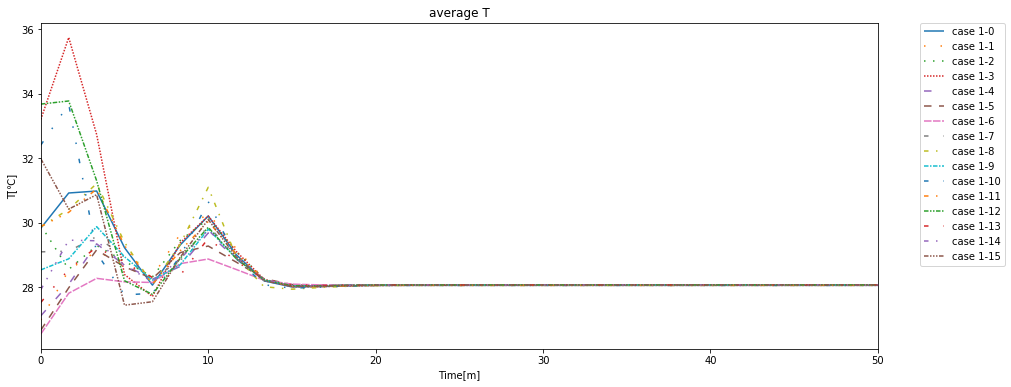

In [63]:
# Tのプロット
for i in range(NUM_PROCESSES):
    plt.plot(time_list, T_list[i], label='case 1-{}'.format(i), \
             linestyle=linestyles[i])
#plt.plot(time_list, T_b, label='case 1-2',linestyle='dashed')
#plt.plot(time_list, T_d, label='case 1-3',linestyle='dashdot')
#plt.plot(time_list, T_f, label='case 1-4',linestyle='dotted')
plt.xlabel("Time[m]")
plt.ylabel("T[℃]")
plt.title('average T')
plt.xlim(0,50)
#plt.ylim(-0.5,2.8)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.savefig("T_123.png",dpi=150)

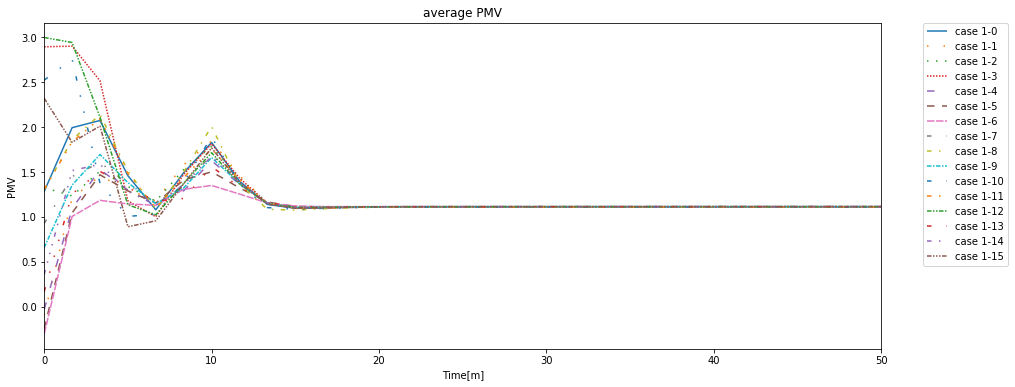

In [64]:
# Tのプロット
for i in range(NUM_PROCESSES):
    plt.plot(time_list, PMV_list[i], label='case 1-{}'.format(i), \
             linestyle=linestyles[i])
#plt.plot(time_list, T_b, label='case 1-2',linestyle='dashed')
#plt.plot(time_list, T_d, label='case 1-3',linestyle='dashdot')
#plt.plot(time_list, T_f, label='case 1-4',linestyle='dotted')
plt.xlabel("Time[m]")
plt.ylabel("PMV")
plt.title('average PMV')
plt.xlim(0,50)
#plt.ylim(-0.5,2.8)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.savefig("T_123.png",dpi=150)

In [125]:
## この環境の部分を変える

class Aircond:
    '''Aircondのクラス'''
    def __init__(self, CASE, stride=500,end=3000,xCells=40,
                         insert_list = [15,15,15,15,33,33,33,51,69,69,69,87,105,105,105,142,142,142,342,342,380,380]):
        self.CASE = CASE
        # メッシュを作らないとpolymeshがないので。
        os.system(CASE.name + '/Makemesh')
        # get nCells
        with open (self.CASE.name + '/constant/polyMesh/neighbour') as f:
            neighbour = f.read()
        nCells_index = neighbour.find('nCells')
        nCells_ = neighbour[nCells_index : nCells_index+15]
        nCells = int(re.sub(r'\D', '', nCells_))
        self.nCells = nCells
        
        self.action_SPEED = np.array([0.1,0.3,0.5])
        self.action_DIRECTION = np.array([-1*np.pi/8, -2*np.pi/8,-3*np.pi/8])
        self.action_TEMPERTURE = np.array([18+273.15,22+273.15,26+273.15])
        self.action_space = np.tile(np.array([0,0,0]),(27,1))
        self.observation_space_ = np.tile(np.array([0,0,0]),(self.nCells,1))
        #self.observation_space = np.tile(np.array([0]), (self.nCells*3,1)
        
        self.xCells = xCells
        self.insert_list = insert_list
        observation_space = np.tile(np.array([0,0,0]), (self.nCells+len(self.insert_list),1))
        U_space_x = observation_space[:,0].reshape(self.xCells,-1)
        U_space_y = observation_space[:,1].reshape(self.xCells,-1)
        T_space = observation_space[:,2].reshape(self.xCells,-1)
        self.observation_space = np.array([U_space_x, U_space_y, T_space]) 
        
        self.stride = stride  # 進めるステップの幅
        # stepが始まってからのtime。始まる前にstepを進めた場合は含まれず0
        self.present_time = 0  
        # openFoam側のcontrolDictに記載されているtime
        self.startTime = 0
        self.endTime = copy(self.stride)
        # いつ終了するか
        self.end = end
        
        # 各辞書ファイルの取得
        self.initialDir = self.CASE.initialDir()+'/'
        self.constant = self.CASE.name + "/constant/"
        self.system = self.CASE.name + "/system/"
        self.initialDir_file = []
        for x in os.listdir(self.initialDir):
            if os.path.isfile(self.initialDir + x):
                self.initialDir_file.append(x)
        self.constant_file = []
        for y in os.listdir(self.constant):
            if os.path.isfile(self.constant + y):
                self.constant_file.append(y)
        self.system_file = []
        for z in os.listdir(self.system):
            if os.path.isfile(self.system + z):
                self.system_file.append(z)
        
        # 各辞書ファイルをそれぞれのファイル名で保存
        for i in range(len(self.initialDir_file)):
            self.__dict__[self.initialDir_file[i]] = ParsedParameterFile(self.initialDir + self.initialDir_file[i])

        for i in range(len(self.system_file)):
            self.__dict__[self.system_file[i]] = ParsedParameterFile(self.system + self.system_file[i])
            
    def initial_to_float(self, numpy_Parsed_value):
        '''uniformをnp.arrayに変換'''
        numpy_Parsed_value = np.array(numpy_Parsed_value)
        if numpy_Parsed_value.ndim==0:
            Parsed_raw = str(numpy_Parsed_value.all())
            Parsed_str = Parsed_raw[8:].strip('()').split(' ')
            Parsed_int = np.array(list(map(float,Parsed_str)))
            #Parsed = np.tile(Parsed_int,(self.nCells,1))
        return Parsed_int
    
    def initial_to_array(self, numpy_Parsed_value):
        '''uniformをnCellの数だけnp.arrayに変換'''
        numpy_Parsed_value = np.array(numpy_Parsed_value)
        if numpy_Parsed_value.ndim==0:
            Parsed_raw = str(numpy_Parsed_value.all())
            Parsed_str = Parsed_raw[8:].strip('()').split(' ')
            Parsed_int = np.array(list(map(float,Parsed_str)))
            Parsed = np.tile(Parsed_int,(self.nCells,1))
        return Parsed

    def make_observation_old(self,Dir):
        '''Dirのpathのobservationを取得'''
        U_value = np.array(ParsedParameterFile(Dir + '/U').content['internalField'])
        T_value = np.array(ParsedParameterFile(Dir + '/T').content['internalField'])
        if U_value.ndim == 0:
            U_value = self.initial_to_array(U_value)
            T_value = self.initial_to_array(T_value)
        U_value_xy = np.delete(U_value, axis=1, obj=2)
        T_value_x = np.reshape(T_value, [-1,1], order='F')
        Observation = np.concatenate([U_value_xy, T_value_x],axis=1)
        return Observation    
    
    def make_observation_onerow(self,Dir):
        '''Dirのpathのobservationを取得
        各U1, U2, Tがすべて一列で並んだ状態を返す'''
        U_value = np.array(ParsedParameterFile(Dir + '/U').content['internalField'])
        T_value = np.array(ParsedParameterFile(Dir + '/T').content['internalField'])
        if U_value.ndim == 0:
            U_value = self.initial_to_array(U_value)
            T_value = self.initial_to_array(T_value)
        #U_value_xy = np.delete(U_value, axis=1, obj=2)
        T_value_x = T_value.reshape(-1, 1)
        U_value_x = U_value[:,0].reshape(-1, 1)
        U_value_y = U_value[:,1].reshape(-1, 1)
        observation = np.concatenate([U_value_x, U_value_y, T_value_x], axis=0)
        return observation
    
    def make_observation(self,Dir,celsius=True):
        '''observationを２次元で取得。
        障害物があるところは全て値を0で埋める。
        self.xCells : x方向のセル数
        self.insert_list : 障害物があり、値を0で埋めるべき場所
        '''
        U_value = np.array(ParsedParameterFile(Dir + '/U').content['internalField'])
        T_value = np.array(ParsedParameterFile(Dir + '/T').content['internalField'])
        if U_value.ndim == 0:
            U_value = self.initial_to_array(U_value)
            T_value = self.initial_to_array(T_value)
        # セルシウス℃に直す
        if celsius:
            T_value = self.Celsius_(T_value)
            T_value = T_value.astype(np.float64)
        U_value_xy = np.delete(U_value, axis=1, obj=2)
        T_value_x = np.reshape(T_value, [-1,1], order='F')
        observation_ = np.concatenate([U_value_xy, T_value_x],axis=1)  # 3 axis observation
        observation_ = np.insert(observation_, self.insert_list, [0,0,0], axis=0)
        U_value_x = observation_[:,0].reshape(self.xCells,-1)
        U_value_y = observation_[:,1].reshape(self.xCells,-1)
        T_value = observation_[:,2].reshape(self.xCells,-1)
        observation = np.array([U_value_x, U_value_y, T_value])
        return observation
    
    def make_action(self):
        '''actionの設定'''
        Action = np.empty((0,3),float)
        for i in range(len(self.action_SPEED)):
            for j in range(len(self.action_DIRECTION)):
                for k in range(len(self.action_TEMPERTURE)):
                    Ux = self.action_SPEED[i]*np.cos(self.action_DIRECTION[j])
                    Uy = self.action_SPEED[i]*np.sin(self.action_DIRECTION[j])
                    Act = np.array([[Ux,Uy,self.action_TEMPERTURE[k]]])
                    Action = np.append(Action,Act,axis=0)
                    
        return Action
    
    def getParsed(self,time_step):
        '''各time_stepのParsedParameterFileを取得'''
        T = ParsedParameterFile(self.CASE.name + '/' + str(time_step) + '/T')
        U = ParsedParameterFile(self.CASE.name + '/' + str(time_step) + '/U')
        TU_list = [T,U]
        return TU_list
    
    
    def getParsedList(self,first_step, last_step, write_step,):
        '''各time_stepのParsedParameterFileを取得'''
        TU_list = []
        for stp in range(first_step, last_step, write_step):
            T = ParsedParameterFile(self.CASE.name + '/' + str(stp) + '/T')
            U = ParsedParameterFile(self.CASE.name + '/' + str(stp) + '/U')
            TU_list.append([T,U])
        return TU_list
    
    # 後にcythonで書き直す予定
    def calc_PMV(self, TA=20,VA=0.3,TR=20,RH=50,AL=1,CLO=1):
        """PMVとPPDを計算
        デフォルト値。TA,VA,TR,RHまでは入力を推奨
        TA = 20  #  温度[℃]
        VA = 0.3  # 流速[m/s]
        TR = 20  # MRT[℃]
        RH = 50  # 相対湿度[%]
        AL = 1  # 活動量[met]
        CLO = 1 # 着衣量[clo]
        
        """
        #***************************************************
        # 外部仕事 W＝0 [W/㎡]とする。
        #***************************************************
        # PMV 計算準備
        #
        M = AL * 58.15
        LCL = CLO
        W = 0
        #PA = (RH / 100 * np.exp(18.6686 - 4030.18 / (TA + 235))) / 0.00750062
        PPK = 673.4 - 1.8 * TA
        PPA = 3.2437814 + 0.00326014 * PPK + 2.00658 * 1E-9 * PPK * PPK * PPK
        PPB = (1165.09 - PPK) * (1 + 0.00121547 * PPK)
        PA = RH / 100 * 22105.8416 / np.exp(2.302585 * PPK * PPA / PPB) * 1000
        EPS = 1E-5
        MW = M - W
        # FCL＝着衣表面積／裸体表面積の比
        if LCL > 0.5:
            FCL = 1.05 + 0.1 * LCL
        else:
            FCL = 1 + 0.2 * LCL
        # 衣服表面温度TCLの初期値設定
        TCL = TA
        TCLA = TCL
        NOI = 1
        # 着衣表面温度の計算
        while True:
            TCLA = 0.8 * TCLA + 0.2 * TCL
            HC = 12.1 * np.sqrt(VA)
            if 2.38 * np.sqrt(np.sqrt(abs(TCL - TA))) > HC:
                HC = 2.38 * np.sqrt(np.sqrt(abs(TCL - TA)))
            TCL = 35.7 - 0.028 * MW - 0.155 * LCL * (3.96 * 1E-8 * FCL * ((TCLA + 273) ** 4 - (TR + 273) ** 4) + FCL * HC * (TCLA - TA))
            NOI = NOI + 1
            if NOI > 150:
                #PMV = 999990.999
                PMB = 3.0
                PPD = 100
                return (PMV,PPD)
            if not abs(TCLA - TCL) > EPS:
                break
        #PMVの計算
        PM1 = 3.96 * 1E-8 * FCL * ((TCL + 273) ** 4 - (TA + 273) ** 4)
        PM2 = FCL * HC * (TCL - TA)
        PM3 = 0.303 * np.exp(-0.036 * M) + 0.028
        if MW > 58.15:
            PM4 = 0.42 * (MW - 58.15)
        else:
            PM4 = 0
        PMV = PM3 * (MW - 3.05 * 0.001 * (5733 - 6.99 * MW - PA) - PM4 - 1.7 * 1E-5 * M * (5867 - PA) - 0.0014 * M * (34 - TA) - PM1 - PM2)
            #PRINT PMV
        if abs(PMV) > 3:
            #PMV = 999990.999
            PMV = 3.0
            PPD = 100
            return (PMV,PPD)
        
        PPD = 100 - 95 * np.exp(-0.0335 * PMV ** 4 - 0.2179 * PMV ** 2)
        
        return (PMV,PPD)
    
    def calc_MRT(self, T_Parsed):
        '''MRTを計算'''
        
        T_wall_list = np.array([])
        if np.array(T_Parsed['internalField']).ndim==0:  # time_step=0
            for boundary in list(T_Parsed['boundaryField']):
                if T_Parsed['boundaryField'][boundary]['type']=='zeroGradient' or \
                T_Parsed['boundaryField'][boundary]['type']=='empty' or \
                    T_Parsed['boundaryField'][boundary]['type']=='fixedValue':
                    T_wall = np.array([])
                else:
                    numpy_Parsed_value = np.array(T_Parsed['boundaryField'][boundary]['value'])
                    T_wall = self.initial_to_float(numpy_Parsed_value)
                T_wall_list = np.append(T_wall_list, T_wall)
                
        else:
            for boundary in list(T_Parsed['boundaryField']):
                if T_Parsed['boundaryField'][boundary]['type']=='fixedValue':
                    numpy_Parsed_value = np.array(T_Parsed['boundaryField'][boundary]['value'])
                    T_wall = self.initial_to_float(numpy_Parsed_value)
                elif T_Parsed['boundaryField'][boundary]['type']=='zeroGradient' or \
                T_Parsed['boundaryField'][boundary]['type']=='empty':
                    T_wall = np.array([])
                else:
                    T_wall = np.array(T_Parsed['boundaryField'][boundary]['value'])
                    if T_wall.ndim==0:
                        T_wall = self.initial_to_float(T_wall)
                T_wall_list = np.append(T_wall_list, T_wall)
        return np.average(T_wall_list)
    
    def Celsius(self, T):
        CelsiusT = T - 273.15
        return CelsiusT
    
    def Celsius_(self, T):
        '''np.arrayの配列をセルシウス℃に変換'''
        if np.array(T).size==1:
            return self.Celsius(T)
        else:
            Celsiuss = np.frompyfunc(self.Celsius,1,1)  # リストに適用可にする
            return Celsiuss(T)
        
    def UScalar(self, U):
        '''Uをスカラーに変換'''
        if np.array(U).size<=3:
            return np.array([np.sqrt(U[0]**2 + U[1]**2)])
        else:
            return np.sqrt(U[:,0]**2 + U[:,1]**2)
        
    def calc_PMV_all(self, TU_Parsed,RH=50,AL=1,CLO=1):
        '''PMVを一つのtime_stepで全点計算
        TU_Parsed : TとUのParsedParameterFileをリストにしたもの
        全ての点のPMVとPPVの値を返す
        time=0でも、すべてのセルの値を返す。'''
        T_Parsed,U_Parsed = TU_Parsed
        T = np.array(T_Parsed['internalField'])
        U = np.array(U_Parsed['internalField'])
        # time_step==0の場合
        if T.ndim==0 or U.ndim==0:
            T = self.initial_to_float(T)
            U = self.initial_to_float(U)
            # Uを速さに変換
            Us = self.UScalar(U)
            MRT = self.calc_MRT(T_Parsed)
            # TとMRTをセルシウス温度に変換
            Tc = self.Celsius_(T)
            MRTc = self.Celsius_(MRT)
            pmv,ppd = self.calc_PMV(TA=Tc,VA=Us,TR=MRTc,RH=RH,AL=AL,CLO=CLO)
            PMV = np.tile(pmv, self.nCells)
            PPD = np.tile(ppd, self.nCells)
        else:   
            # Uを速さに変換
            Us = self.UScalar(U)
            MRT = self.calc_MRT(T_Parsed)
            # TとMRTをセルシウス温度に変換
            Tc = list(self.Celsius_(T))
            MRTc = self.Celsius_(MRT)
            
            length = len(T)
            # ループを早くするため、外に出す。
            PMV = []
            PPD = []
            PMVappend = PMV.append
            PPDappend = PPD.append
            for i in range(length):
                pmv,ppd = self.calc_PMV(TA=Tc[i],VA=Us[i],TR=MRTc,RH=RH,AL=AL,CLO=CLO)
                PMVappend(pmv)
                PPDappend(ppd)
            PMV = np.array(PMV)
            PPD = np.array(PPD)
        return [PMV,PPD]
    
    def calc_PMV_error(self, TU_Parsed,RH=50,AL=1,CLO=1):
        """PMVの全点の2条誤差の合計を計算
        入力はcalc_PMV_allと同じ。返すものだけが違う。
        PMVは、0との2乗誤差、PPDは0との、根平均2乗誤差を返す。
        """
        PMV, PPD = self.calc_PMV_all(TU_Parsed, RH=RH,AL=AL,CLO=CLO)
        PMV_mae = ((PMV - 0)**2).mean()
        PPD_rmse = np.sqrt( ((PPD - 0)**2).mean())
        return PMV_mae, PPD_rmse
    
    def header(self, time_step, filename):
        '''headerファイルを作成'''
        header = """/*--------------------------------*- C++ -*----------------------------------*\
=========                 |
  \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox
   \\    /   O peration     | Website:  https://openfoam.org
    \\  /    A nd           | Version:  6
     \\/     M anipulation  |
\*---------------------------------------------------------------------------*/
FoamFile
{{
    version     2.0;
    format      ascii;
    class       volScalarField;
    location    "{}";
    object      {};
}}
// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //
""".format(time_step, filename)
        return header
    
    def internal(self, list_internal):
        '''internalFieldの値の作成'''
        if len(list_internal)==1:
            internal = """
internalField   uniform {};""".format(list_internal[0])
        else:
            str_= np.frompyfunc(str,1,1)
            str_internal = '\n'.join(str_(list_internal))
            internal = """
internalField   nonuniform List<scalar> 
{}
(
{}
)
;
""".format(self.nCells, str_internal)
        return internal
    
    def makePMVFile(self,time_step):
        '''PMVとPPDファイルを書き込む'''
        
        path_pmv = self.CASE.name + '/' + str(time_step) + '/PMV' # 書き込むパス
        path_ppd = self.CASE.name + '/' + str(time_step) + '/PPD'
        
        demensions = """
dimensions      [0 0 0 0 0 0 0];
"""
        
        boundary = """
boundaryField
{
    ".*"
    {
        type            zeroGradient;
    }
}


// ************************************************************************* //
"""
        # header, dimensions, internal, boundaryの順に書き込む
        f = open(path_pmv, 'w') # ファイルを開く(該当ファイルがなければ新規作成)
        g = open(path_ppd, 'w')
        f.write(self.header(time_step,"PMV")) # headerを記載する
        g.write(self.header(time_step,"PPD"))
        f.write(demensions) # dimensionsを記載する
        g.write(demensions)
        # internalFieldの計算
        TU_Parsed = self.getParsed(time_step)
        PMV,PPD = self.calc_PMV_all(TU_Parsed)
        internal_PMV = self.internal(PMV)
        internal_PPD = self.internal(PPD)
        f.write(internal_PMV)  
        g.write(internal_PPD)
        f.write(boundary)
        g.write(boundary)
        f.close() 
        g.close()

        
    def makePMVList(self,first_step, last_step, write_step):
        '''任意の範囲でPMVファイルを作成'''
        for stp in range(first_step, last_step, write_step):
            self.makePMVFile(stp)
            
        
    def meshNumberFile(self,time_step):
        '''メッシュの並びを確認する'''
        path_mesh = self.CASE.name + '/' + str(time_step) + '/Meshnumber' # 書き込むパス


        demensions = """
dimensions      [0 0 0 0 0 0 0];
"""
        boundary = """
boundaryField
{
    ".*"
    {
        type            zeroGradient;
    }
}


// ************************************************************************* //
"""
        f = open(path_mesh, 'w') # ファイルを開く(該当ファイルがなければ新規作成)
        f.write(self.header(time_step,"PMV")) # headerを記載する
        f.write(demensions) # dimensionsを記載する
        mesh_list = [x for x in range(1,self.nCells+1)]
        internal_mesh = self.internal(mesh_list)
        f.write(internal_mesh)  
        f.write(boundary)
        f.close() 
            
    def calc_ADPI(self,TU_Parsed,occupied_zone_cell):
        '''ADPIを計算する'''
        
        # occupied_zone_cellはaircond5の場合は1~340までのセルが居住域
        T_Parsed,U_Parsed = TU_Parsed
        T = np.array(T_Parsed['internalField'])
        U = np.array(U_Parsed['internalField'])
        # time_step==0の場合
        if T.ndim==0 or U.ndim==0:
            T = self.initial_to_float(T)
            U = self.initial_to_float(U)
        
        Tc = np.average(T)  # 室内の平均温度
        Us = self.UScalar(U)  # 流速
        theta = (T - Tc) - 8.0*(Us - 0.15)  # 有効ドラフト温度
        
        satisfy_theta = np.where((theta > -1.5) & (theta < 1), 1, 0)
        satisfy_Us = np.where(Us < 0.35,1, 0)  # 条件を満たすものを1,満たさないものを0
        satisfy_all = satisfy_theta + satisfy_Us
        satisfy = satisfy_all[:occupied_zone_cell]
        nCells = satisfy.size
        num_satisfy = np.sum(satisfy == 2)
        ADPI = num_satisfy/nCells*100
        
        return (ADPI, theta)
    
    def calc_EUC(self,T_Parsed, occupied_zone_cell,last_cell):
        '''EUCを計算する'''
        
        T = np.array(T_Parsed['internalField'])
        T0 = self.initial_to_float(T_Parsed['boundaryField']['inlet']['value'])[0] # 給気温度

        if T.ndim==0:
            T = self.initial_to_float(T)[0]
            Toz = T
            Tiz = T
        else:
            Toz = np.average(T[occupied_zone_cell:last_cell])  # 居住域外の平均温度  
            Tiz = np.average(T[:occupied_zone_cell])  # 居住域内の平均温度
        EUC = (Toz-T0) / (Tiz-T0) * 100
        return EUC
        
    def getPMVList(self, first_step, last_step, write_step):
        '''任意の範囲のPMVの平均値ファイルを取得'''
        
        # ループを早くするため、外に出す。
        PMV_list = []
        PPD_list = []
        PMVappend = PMV_list.append
        PPDappend = PPD_list.append
        for stp in range(first_step, last_step, write_step):
            TU_Parsed = self.getParsed(stp)
            PMV,PPD = self.calc_PMV_all(TU_Parsed)
            pmv = np.average(np.array(PMV))
            ppd = np.average(np.array(PPD))
            PMVappend(pmv)
            PPDappend(ppd)
        return [PMV_list, PPD_list]
    
    
    def getADPIList(self, first_step, last_step, write_step,occupied_zone_cell=342):
        '''任意の範囲のADPIの値を取得'''
        
        ADPI_list = []
        ADPIappend = ADPI_list.append
        for stp in range(first_step, last_step, write_step):
            TU_Parsed = self.getParsed(stp)
            adpi,theta = self.calc_ADPI(TU_Parsed, occupied_zone_cell)
            ADPIappend(adpi)
        return ADPI_list
    
    def getEUCList(self, first_step, last_step, write_step,
                    occupied_zone_cell=342, last_cell=100000):
        '''任意の範囲のEUCの値を算出'''
        
        EUC_list = []
        EUCappend = EUC_list.append
        for stp in range(first_step, last_step, write_step):
            T_Parsed,U_Parsed = self.getParsed(stp)
            euc = self.calc_EUC(T_Parsed, occupied_zone_cell, last_cell)
            EUCappend(euc)
        return EUC_list
    
    def getTUList(self, first_step, last_step, write_step):
        '''任意の範囲のTとUの平均値を取得'''
        
        T_list = []
        U_list = []
        MRT_list = []
        Tappend = T_list.append
        Uappend = U_list.append
        MRTappend = MRT_list.append
        for stp in range(first_step, last_step, write_step):
            T_Parsed, U_Parsed = self.getParsed(stp)
            T = np.array(T_Parsed['internalField'])
            U = np.array(U_Parsed['internalField'])
            # time_step==0の場合
            if T.ndim==0 or U.ndim==0:
                T = self.initial_to_float(T)
                U = self.initial_to_float(U)
            # Uを速さに変換
            T = np.average(T)
            Us = np.average(np.array(self.UScalar(U)))
            MRT = np.average(np.array(self.calc_MRT(T_Parsed)))
            # TとMRTをセルシウス温度に変換
            Tc = self.Celsius(T)
            MRTc = self.Celsius(MRT)
            Tappend(Tc)
            Uappend(Us)
            MRTappend(MRTc)
        return [T_list,U_list,MRT_list]
        
        
        
    def change_control(self,control):
        if control == 1:
            self.blockMeshDict['blocks'][2] = Vector(20,10,1)
            self.blockMeshDict.writeFile()
            self.controlDict['deltaT'] = 0.02
        if control == 2:
            self.blockMeshDict['blocks'][2] = Vector(40,20,1)
            self.blockMeshDict.writeFile()
            self.controlDict['deltaT'] = 0.02
        if control == 3:
            self.blockMeshDict['blocks'][2] = Vector(20,10,1)
            self.blockMeshDict.writeFile()
            self.controlDict['deltaT'] = 0.01
        if control == 4:
            self.blockMeshDict['blocks'][2] = Vector(40,20,1)
            self.blockMeshDict.writeFile()
            self.controlDict['deltaT'] = 0.01
            
    def write_interval(self, writeInterval):
        self.controlDict['writeInterval'] = writeInterval
        
        
    def reset(self):
        '''環境のリセット'''
        
        # reset parameter
        self.present_time = 0  
        self.startTime = 0
        self.endTime = copy(self.stride)
        
        # reset control Dict
        clDict = ParsedParameterFile(self.CASE.controlDict())
        clDict['startTime'] = self.startTime
        clDict['endTime'] = self.endTime
        clDict.writeFile()
        #self.startTime = clDict['startTime']
        #self.endTime = clDict['endTime']
        
        #os.system('./Allclean')
        os.system(self.CASE.name + '/Makemesh')
        
        # 初期条件の設定（ランダム）
        T_initial = ParsedParameterFile(self.CASE.initialDir() + '/T')
        # random parameter from 26 to 35
        T_rand = np.random.randint(26+273,35+273)
        T_initial['internalField'].setUniform(T_rand)
        T_initial.writeFile()
        
        
        # set action and observation
        self.action_space= self.make_action()
        self.observation = self.make_observation(self.CASE.initialDir())
        return self.observation
    
    def step_old(self, action):
        '''ステップを進める'''
        #clDict = ParsedParameterFile(self.CASE.controlDict())      
        if self.present_time >= self.end:
            done = True
            runOK = 'end'
        else:
            done = False
            
            # actionに従った、境界条件を設定
            # action is 0~26
            U_latest = ParsedParameterFile(self.CASE.latestDir() + '/U')
            T_latest = ParsedParameterFile(self.CASE.latestDir() + '/T')
            self.act = self.action_space[action]
            U_latest['boundaryField']['inlet']['value'].setUniform(Vector(self.act[0],self.act[1],0))
            U_latest.writeFile()
            T_latest['boundaryField']['inlet']['value'].setUniform(self.act[2])
            T_latest.writeFile()
            
            # OpenFOAMのコマンドを実行
            args=shlex.split("buoyantPimpleFoam -case " + self.CASE.name)
            buoyant=BasicRunner(args,silent=True)
            self.summary=buoyant.start()
            runOK = buoyant.runOK()
            
            #os.system("buoyantBoussinesqPimpleFoam")
            
            # clDictのコントロール
            self.present_time += self.stride
            clDict = ParsedParameterFile(self.CASE.controlDict())
            self.startTime += self.stride
            self.endTime += self.stride
            clDict['startTime'] = self.startTime
            clDict['endTime'] = self.endTime
            clDict.writeFile()
            
            self.startTime = clDict['startTime']
            self.endTime = clDict['endTime']
            
            self.observation = self.make_observation(self.CASE.latestDir())
            
        return (self.observation, done, runOK)
    
    
    def step(self, action, reward='PMV'):
        '''ステップを進める
        報酬はPMV等から選択
        '''
        #clDict = ParsedParameterFile(self.CASE.controlDict())      
        if self.present_time >= self.end:
            done = True
            runOK = 'end'
            # rewardと、observationは1ステップ前の値をそのまま使う。
        else:
            done = False
            
            # actionに従った、境界条件を設定
            # action is 0~26
            U_latest = ParsedParameterFile(self.CASE.latestDir() + '/U')
            T_latest = ParsedParameterFile(self.CASE.latestDir() + '/T')
            self.act = self.action_space[action]
            U_latest['boundaryField']['inlet']['value'].setUniform(Vector(self.act[0],self.act[1],0))
            U_latest.writeFile()
            T_latest['boundaryField']['inlet']['value'].setUniform(self.act[2])
            T_latest.writeFile()
            
            # OpenFOAMのコマンドを実行
            args=shlex.split("buoyantPimpleFoam -case " + self.CASE.name)
            buoyant=BasicRunner(args,silent=True)
            self.summary=buoyant.start()
            runOK = buoyant.runOK()
            
            #os.system("buoyantBoussinesqPimpleFoam")
            
            # clDictのコントロール
            self.present_time += self.stride
            clDict = ParsedParameterFile(self.CASE.controlDict())
            self.startTime += self.stride
            self.endTime += self.stride
            clDict['startTime'] = self.startTime
            clDict['endTime'] = self.endTime
            clDict.writeFile()
            
            self.startTime = clDict['startTime']
            self.endTime = clDict['endTime']
            
            self.observation = self.make_observation(self.CASE.latestDir())
            
            # 報酬の計算。make_observationでは、0を補完していれているため、用いない。
            T_new = ParsedParameterFile(self.CASE.latestDir() + '/T')
            U_new = ParsedParameterFile(self.CASE.latestDir() + '/U')
            TU_Parsed = [T_new,U_new]
            PMV_mae, PPD_rmse = self.calc_PMV_error(TU_Parsed, RH=50,AL=1,CLO=1)
            # 報酬は、ズレ分をマイナス、ちかづいたら、プラスにする。
            self.reward = -PMV_mae + 1
            
        
        return (self.observation, self.reward, done, runOK)
        

In [126]:
# aircondを並列でたくさんつくるためのクラス

# ケースの作成
def makecase(NUM_PROCESSES,stride=500, end=3000, xCells=40,
                         insert_list = [15,15,15,15,33,33,33,51,69,69,69,87,105,105,105,142,142,142,342,342,380,380]):
    """並列でたくさんのケースをつくる"""
    os.system("./makecase {}".format(NUM_PROCESSES))
    Envs = []
    Envs_append = Envs.append
    for i in range(NUM_PROCESSES):
        CASE = SolutionDirectory("./Case/case{}".format(i))
        aircond = Aircond(CASE, stride=stride, end=end, xCells=xCells, insert_list=insert_list)
        Envs_append(aircond)
    return Envs

In [128]:
# 定数の設定

#ENV_NAME = 'BreakoutNoFrameskip-v4' 
# Breakout-v0ではなく、BreakoutNoFrameskip-v4を使用
# v0はフレームが自動的に2-4のランダムにskipされますが、今回はフレームスキップはさせないバージョンを使用
# 参考URL https://becominghuman.ai/lets-build-an-atari-ai-part-1-dqn-df57e8ff3b26
# https://github.com/openai/gym/blob/5cb12296274020db9bb6378ce54276b31e7002da/gym/envs/__init__.py#L371
    
NUM_SKIP_FRAME = 4 # skipするframe数です
NUM_STACK_FRAME = 1  # 状態として連続的に保持するframe数です
NOOP_MAX = 30  #  reset時に何もしないフレームを挟む（No-operation）フレーム数の乱数上限です
NUM_PROCESSES = 2 #  並列して同時実行するプロセス数です
NUM_ADVANCED_STEP = 5  # 何ステップ進めて報酬和を計算するのか設定
GAMMA = 0.99  # 時間割引率

TOTAL_FRAMES=10e6  #  学習に使用する総フレーム数
NUM_UPDATES = int(TOTAL_FRAMES / NUM_ADVANCED_STEP / NUM_PROCESSES)  # ネットワークの総更新回数
# NUM_UPDATESは125,000となる


In [129]:
NUM_UPDATES = 10

In [130]:
# A2Cの損失関数の計算のための定数設定
value_loss_coef = 0.5
entropy_coef = 0.01
max_grad_norm = 0.5

# 学習手法RMSpropの設定
lr = 7e-4
eps = 1e-5
alpha = 0.99


In [131]:
# GPUの使用の設定
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)


cpu


In [132]:
# A2Cのディープ・ニューラルネットワークの構築


def init(module, gain):
    '''層の結合パラメータを初期化する関数を定義'''
    nn.init.orthogonal_(module.weight.data, gain=gain)
    nn.init.constant_(module.bias.data, 0)
    return module


class Flatten(nn.Module):
    '''コンボリューション層の出力画像を1次元に変換する層を定義'''

    def forward(self, x):
        return x.view(x.size(0), -1)


class Net(nn.Module):
    def __init__(self, n_out):
        super(Net, self).__init__()

        # 結合パラメータの初期化関数
        def init_(module): return init(
            module, gain=nn.init.calculate_gain('relu'))

        # コンボリューション層の定義
        self.conv = nn.Sequential(
            # 画像サイズの変化12*40→4*18
            init_(nn.Conv2d(3, 32, kernel_size=5,stride=2)),
            # stackするflameは4画像なのでinput=NUM_STACK_FRAME=4である、出力は32とする、
            # sizeの計算  size = (Input_size - Kernel_size + 2*Padding_size)/ Stride_size + 1

            nn.ReLU(),
            # 画像サイズの変化4*18→3*17
            init_(nn.Conv2d(32, 64, kernel_size=2, stride=1)),
            nn.ReLU(),
            init_(nn.Conv2d(64, 64, kernel_size=2, stride=1)),  # 画像サイズの変化3*17→2*16
            nn.ReLU(),
            Flatten(),  # 画像形式を1次元に変換
            init_(nn.Linear(64 * 2 * 16, 512)),  # 64枚の7×7の画像を、512次元のoutputへ
            nn.ReLU()
        )

        # 結合パラメータの初期化関数
        def init_(module): return init(module, gain=1.0)

        # Criticの定義
        self.critic = init_(nn.Linear(512, 1))  # 状態価値なので出力は1つ

        # 結合パラメータの初期化関数
        def init_(module): return init(module, gain=0.01)

        # Actorの定義
        self.actor = init_(nn.Linear(512, n_out))  # 行動を決めるので出力は行動の種類数

        # ネットワークを訓練モードに設定
        self.train()

    def forward(self, x):
        '''ネットワークのフォワード計算を定義します'''
        #input = x / 255.0  # 画像のピクセル値0-255を0-1に正規化する
        input = x  # 正規化はしない
        conv_output = self.conv(input)  # Convolution層の計算
        critic_output = self.critic(conv_output)  # 状態価値の計算
        actor_output = self.actor(conv_output)  # 行動の計算

        return critic_output, actor_output

    def act(self, x):
        '''状態xから行動を確率的に求めます'''
        value, actor_output = self(x)
        probs = F.softmax(actor_output, dim=1)    # dim=1で行動の種類方向に計算
        action = probs.multinomial(num_samples=1)

        return action

    def get_value(self, x):
        '''状態xから状態価値を求めます'''
        value, actor_output = self(x)

        return value

    def evaluate_actions(self, x, actions):
        '''状態xから状態価値、実際の行動actionsのlog確率とエントロピーを求めます'''
        value, actor_output = self(x)

        log_probs = F.log_softmax(actor_output, dim=1)  # dim=1で行動の種類方向に計算
        action_log_probs = log_probs.gather(1, actions)  # 実際の行動のlog_probsを求める

        probs = F.softmax(actor_output, dim=1)  # dim=1で行動の種類方向に計算
        dist_entropy = -(log_probs * probs).sum(-1).mean()

        return value, action_log_probs, dist_entropy


In [63]:
def resets(Envs):
    """resets all"""
    obs = []
    obs_append = obs.append
    for i in range(len(Envs)):
        obs_ = Envs[i].reset()
        obs_append(obs_)
    obs = np.array(obs)
    return obs

In [64]:
def steps(Envs, action):
    """すべての環境で同じだけステップを進める
    obsはnumpy, done, runOKはリスト
    """
    obs = []
    reward = []
    done = []
    runOK = []
    obs_append = obs.append
    reward_append = reward.append
    done_append = done.append
    runOK_append = runOK.append
    for i in range(len(Envs)):
        obs_, reward_, done_, runOK_ = Envs[i].step(action[i])
        obs_append(obs_)
        reward_append(reward_)
        done_append(done_)
        runOK_append(runOK_)
    obs = np.array(obs)
    return obs, reward, done, runOK
    

In [65]:
def make_random_actions(Envs, max_execution=3):
    """適当にステップを進めて、環境をバラバラにする。
    環境のリスト
    max_execution : 進める最大のステップ。0~ステップ分進めることになる。
    random_actionは複素数で返す。0+1Jは補完したもの。
    """
    # 0~max_executions
    # 複素数にして、1jは補完したものとする。
    action_shape = Envs[0].action_space.shape[0]
    random_actions = []
    for i in range(len(Envs)):
        i_th_action = []
        for j in range(random.randint(0,max_execution)):
            i_th_action.append(random.randint(0, action_shape-1))
        random_actions.append(i_th_action)
        
    max_len = max(map(len, random_actions))
    random_actions = np.array(list(map(lambda x:x + [1j]*(max_len-len(x)), random_actions)))
    random_actions = random_actions.astype(np.complex128)
    return random_actions

In [66]:
def random_steps(Envs, random_actions, step_reset=True):
    """random_actions分それぞれステップを進める。
    Envs : 環境のリスト
    random_actions, len(Envs)行,進めるステップ分で構成された、random_step。
    step_reset : Envs内のpresent_timeをリセットするかどうか。
    """
    # random_step分stepを進めて、とりあえず、リストとして保存。
    obs_list = []
    reward_list = []
    done_list = []
    runOK_list = []
    obs_list_append = obs_list.append
    reward_list_append = reward_list.append
    done_list_append = done_list.append
    runOK_list_append = runOK_list.append
    # random_actions.shape[0] == len(Envs)だが、やりたくない環境がある場合
    # やらないために、len(Envs)は使わない
    for i in range(random_actions.shape[0]):
        obs_progress = []
        reward_progress = []
        done_progress = []
        runOK_progress = []
        obs_progress_append = obs_progress.append
        reward_progress_append = reward_progress.append
        done_progress_append = done_progress.append
        runOK_progress_append = runOK_progress.append
        
        for j in range(random_actions.shape[1]):
            if random_actions[i,j].imag==0:  # 補完しただけのものには1jが入ってる
                obs_, done_, reward_, runOK_ = Envs[i].step(int(random_actions[i,j].real))
                obs_progress_append(obs_)
                reward_progress_append(reward_)
            else:
                done_, runOK_ = False, True
            done_progress_append(done_)
            runOK_progress_append(runOK_)
            
        obs_list_append(obs_progress)
        reward_list_append(reward_progress)
        done_list_append(done_progress)
        runOK_list_append(runOK_progress)
    
    # 進めた結果をまとめる。
    # obs → 最後のステップのobservation or 進めない場合、そのままのobservation
    # reward → 最後のステップのreward or 進めない場合、そのままのreward
    # done → 一個でもdoneがあれば、done=Trueとする。
    # runOK → 一個でも、Falseがあれば、Falseとする。
    obs = []
    reward = []
    done = []
    runOK = []
    obs_append = obs.append
    reward_append = reward.append
    done_append = done.append
    runOK_append = runOK.append
    for i in range(random_actions.shape[0]):
        if obs_list[i]==[]:
            obs_ = Envs[i].observation
        else:
            obs_ = obs_list[i][-1]
        obs_append(obs_)
        
        if reward_list[i]==[]:
            reward_ = Envs[i].reward
        else:
            reward_ = reward_list[i][-1]
        reward_append(reward_)
        
        if any(done_list[i]):
            done_ = True
        else:
            done_ = False
        done_append(done_)
        
        if all(runOK_list[i]):
            runOK_ = True
        else:
            runOK_ = False
        runOK_append(runOK_)
    obs = np.array(obs)
    
    if step_reset:
        for i in range(random_actions.shape[0]):
            Envs[i].present_time=0
            
    return obs, reward, done, runOK

In [124]:
# 流体版

# seedの設定
seed_num = 1
torch.manual_seed(seed_num)
if use_cuda:
    torch.cuda.manual_seed(seed_num)

# 実行環境を構築
torch.set_num_threads(seed_num)
# 実行環境を構築
Envs = makecase(NUM_PROCESSES, stride=100)  # strideは本来は300くらいでやる予定。

# 全エージェントが共有して持つ頭脳Brainを生成
n_out = Envs[0].action_space.shape[0]  # 行動の種類は27
actor_critic = Net(n_out).to(device)  # GPUへ
global_brain = Brain(actor_critic)

# 格納用変数の生成
obs_shape = Envs[0].observation_space.shape  # (3, 40, 12)
#obs_shape = (obs_shape[0] * NUM_STACK_FRAME,
#             *obs_shape[1:])  # (4, 84, 84)
# 状態数は一個でやる。よって、current_obsはそのままの値を格納。

# torch.Size([16, 3, 40, 12)
current_obs = torch.zeros(NUM_PROCESSES, *obs_shape).to(device)
rollouts = RolloutStorage(
    NUM_ADVANCED_STEP, NUM_PROCESSES, obs_shape)  # rolloutsのオブジェクト
episode_rewards = torch.zeros([NUM_PROCESSES, 1])  # 現在の試行の報酬を保持
final_rewards = torch.zeros([NUM_PROCESSES, 1])  # 最後の試行の報酬和を保持

# 初期状態の開始
obs = resets(Envs)
obs = torch.from_numpy(obs).float()  # torch.Size([16, 3, 40, 12])
current_obs = obs.to(device) # flameの4番目に最新のobsを格納

# advanced学習用のオブジェクトrolloutsの状態の1つ目に、現在の状態を保存
rollouts.observations[0].copy_(current_obs)

# 実行ループ
for j in tqdm(range(NUM_UPDATES)):
    # advanced学習するstep数ごとに計算
    for step in range(NUM_ADVANCED_STEP):

        # 行動を求める
        with torch.no_grad():
            action = actor_critic.act(rollouts.observations[step])
        
        cpu_actions = action.squeeze(1).cpu().numpy()  # tensorをNumPyに
        
        # 1stepの並列実行、なお返り値のobsのsizeは(16, 1, 84, 84)
        obs, reward, done,runOK = steps(Envs, cpu_actions)
        
        # 報酬をtensorに変換し、試行の総報酬に足す
        # sizeが(16,)になっているのを(16, 1)に変換
        reward = np.expand_dims(np.stack(reward), 1)
        reward = torch.from_numpy(reward).float()
        episode_rewards += reward
        
        # 各実行環境それぞれについて、doneならmaskは0に、継続中ならmaskは1にする
        masks = torch.FloatTensor(
            [[0.0] if done_ or not runOK_ else [1.0] for done_, runOK_ in zip(done,runOK)])
        # 最後の試行の総報酬を更新する
        final_rewards *= masks  # 継続中の場合は1をかけ算してそのまま、done時には0を掛けてリセット
        # 継続中は0を足す、done時にはepisode_rewardsを足す
        final_rewards += (1 - masks) * episode_rewards
        
        
        # 試行の総報酬を更新する
        episode_rewards *= masks  # 継続中のmaskは1なのでそのまま、doneの場合は0に
        
        # masksをGPUへ
        masks = masks.to(device)
        
        # 現在の状態をdone時には全部0にする
        # maskのサイズをtorch.Size([16, 1])→torch.Size([16, 1, 1 ,1])へ変換して、かけ算
        current_obs *= masks.unsqueeze(2).unsqueeze(2)
        
        # frameをstackする
        # torch.Size([16, 1, 40, 12])
        obs = torch.from_numpy(obs).float()
        current_obs = obs.to(device)  # 最新のobsを格納
        
        # メモリオブジェクトに今stepのtransitionを挿入
        rollouts.insert(current_obs, action.data, reward, masks)
        
    # advancedのfor loop終了

    # advancedした最終stepの状態から予想する状態価値を計算
    with torch.no_grad():
        next_value = actor_critic.get_value(
            rollouts.observations[-1]).detach()
        
        
    # 全stepの割引報酬和を計算して、rolloutsの変数returnsを更新
    rollouts.compute_returns(next_value)
    
    
    # ネットワークとrolloutの更新
    global_brain.update(rollouts)
    rollouts.after_update()
    
    # ログ：途中経過の出力
    if j % 100 == 0:
        print("finished frames {}, mean/median reward {:.1f}/{:.1f}, min/max reward {:.1f}/{:.1f}".
              format(j*NUM_PROCESSES*NUM_ADVANCED_STEP,
                     final_rewards.mean(),
                     final_rewards.median(),
                     final_rewards.min(),
                     final_rewards.max()))
    
    # 結合パラメータの保存
    if j % 12500 == 0:
        torch.save(global_brain.actor_critic.state_dict(),
                   'weight_'+str(j)+'.pth')

# 実行ループの終了
torch.save(global_brain.actor_critic.state_dict(), 'weight_end.pth')

# 実行ループの終了
torch.save(global_brain.actor_critic.state_dict(), 'weight_end.pth')


 10%|█         | 1/10 [04:58<44:42, 298.07s/it]

finished frames 0, mean/median reward 0.0/0.0, min/max reward 0.0/0.0


 40%|████      | 4/10 [19:13<28:46, 287.79s/it]

 Interrupted by the Keyboard
Killing PID 10182
 Interrupted by the Keyboard
Killing PID 10199


 50%|█████     | 5/10 [22:59<22:27, 269.43s/it]

 Interrupted by the Keyboard
Killing PID 10252


100%|██████████| 10/10 [23:04<00:00, 138.50s/it]


In [110]:
# 流体版

# seedの設定
seed_num = 1
torch.manual_seed(seed_num)
if use_cuda:
    torch.cuda.manual_seed(seed_num)

# 実行環境を構築
torch.set_num_threads(seed_num)
# 実行環境を構築
Envs = makecase(NUM_PROCESSES, stride=100)  # strideは本来は300くらいでやる予定。

# 全エージェントが共有して持つ頭脳Brainを生成
n_out = Envs[0].action_space.shape[0]  # 行動の種類は27
actor_critic = Net(n_out).to(device)  # GPUへ
global_brain = Brain(actor_critic)

# 格納用変数の生成
obs_shape = Envs[0].observation_space.shape  # (3, 40, 12)
#obs_shape = (obs_shape[0] * NUM_STACK_FRAME,
#             *obs_shape[1:])  # (4, 84, 84)
# 状態数は一個でやる。よって、current_obsはそのままの値を格納。

# torch.Size([16, 3, 40, 12)
current_obs = torch.zeros(NUM_PROCESSES, *obs_shape).to(device)
rollouts = RolloutStorage(
    NUM_ADVANCED_STEP, NUM_PROCESSES, obs_shape)  # rolloutsのオブジェクト
episode_rewards = torch.zeros([NUM_PROCESSES, 1])  # 現在の試行の報酬を保持
final_rewards = torch.zeros([NUM_PROCESSES, 1])  # 最後の試行の報酬和を保持

# 初期状態の開始
obs = resets(Envs)
obs = torch.from_numpy(obs).float()  # torch.Size([16, 3, 40, 12])
current_obs = obs.to(device) # flameの4番目に最新のobsを格納

# advanced学習用のオブジェクトrolloutsの状態の1つ目に、現在の状態を保存
rollouts.observations[0].copy_(current_obs)


tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[25.8500, 25.8500, 25.8500,  ..., 25.8500, 25.8500, 25.8500],
          [25.8500, 25.8500, 2

In [121]:

# 実行ループ
#for j in tqdm(range(NUM_UPDATES)):
    # advanced学習するstep数ごとに計算
    #for step in range(NUM_ADVANCED_STEP):


j=0
step=0

# 行動を求める
with torch.no_grad():
    action = actor_critic.act(rollouts.observations[step])

cpu_actions = action.squeeze(1).cpu().numpy()  # tensorをNumPyに

# 1stepの並列実行、なお返り値のobsのsizeは(16, 1, 84, 84)
obs, reward, done,runOK = steps(Envs, cpu_actions)

# 報酬をtensorに変換し、試行の総報酬に足す
# sizeが(16,)になっているのを(16, 1)に変換
reward = np.expand_dims(np.stack(reward), 1)
reward = torch.from_numpy(reward).float()
episode_rewards += reward

# 各実行環境それぞれについて、doneならmaskは0に、継続中ならmaskは1にする
masks = torch.FloatTensor(
    [[0.0] if done_ or not runOK_ else [1.0] for done_, runOK_ in zip(done,runOK)])
# 最後の試行の総報酬を更新する
final_rewards *= masks  # 継続中の場合は1をかけ算してそのまま、done時には0を掛けてリセット
# 継続中は0を足す、done時にはepisode_rewardsを足す
final_rewards += (1 - masks) * episode_rewards


# 試行の総報酬を更新する
episode_rewards *= masks  # 継続中のmaskは1なのでそのまま、doneの場合は0に

# masksをGPUへ
masks = masks.to(device)

# 現在の状態をdone時には全部0にする
# maskのサイズをtorch.Size([16, 1])→torch.Size([16, 1, 1 ,1])へ変換して、かけ算
current_obs *= masks.unsqueeze(2).unsqueeze(2)

# frameをstackする
# torch.Size([16, 1, 40, 12])
obs = torch.from_numpy(obs).float()
current_obs = obs.to(device)  # 最新のobsを格納

# メモリオブジェクトに今stepのtransitionを挿入
rollouts.insert(current_obs, action.data, reward, masks)

# ------------------

# advancedのfor loop終了

# advancedした最終stepの状態から予想する状態価値を計算
with torch.no_grad():
    next_value = actor_critic.get_value(
        rollouts.observations[-1]).detach()
    
    
# 全stepの割引報酬和を計算して、rolloutsの変数returnsを更新
rollouts.compute_returns(next_value)


# ネットワークとrolloutの更新
global_brain.update(rollouts)
rollouts.after_update()

# ログ：途中経過の出力
if j % 100 == 0:
    print("finished frames {}, mean/median reward {:.1f}/{:.1f}, min/max reward {:.1f}/{:.1f}".
          format(j*NUM_PROCESSES*NUM_ADVANCED_STEP,
                 final_rewards.mean(),
                 final_rewards.median(),
                 final_rewards.min(),
                 final_rewards.max()))

# 結合パラメータの保存
if j % 12500 == 0:
    torch.save(global_brain.actor_critic.state_dict(),
               'weight_'+str(j)+'.pth')

# 実行ループの終了
torch.save(global_brain.actor_critic.state_dict(), 'weight_end.pth')

 Interrupted by the Keyboard
Killing PID 8741
finished frames 0, mean/median reward 0.0/0.0, min/max reward 0.0/0.0


In [47]:
# 微妙。とりあえずは使わない方向。
class SubprocAircond():
    def __init__(self, envs):
        # 今回は並列は考えない。
        # いつか考えようかと思うけど、流体の方にGPU使えばいいかなー。
        self.envs = envs
        self.observation_space = envs[0].observation_space
        self.action_space = envs[0].action_space

    def reset(self):
        Obs = []
        Obs_append = Obs.append
        for env in self.envs:
            obs = env.reset()
            Obs_append(obs)
        return Obs
    
    def step(self, actions):
        Obs, Done, RunOK = [], [], []
        Obs_append = Obs.append
        Done_append = Done.append
        RunOK_append = RunOK.append
        for env, action in zip(self.envs, actions):
            obs, done, runOK = env.step(action)
            Obs_append(obs)
            Done_append(done)
            RunOK_append(runOK)
        return Obs, Done, RunOK

In [44]:
## この環境の部分を変える

class Aircond_old:
    '''Aircondのクラス'''
    def __init__(self, CASE, stride=500, xCells=40,
                         insert_list = [15,15,15,15,33,33,33,51,69,69,69,87,105,105,105,142,142,142,342,342,380,380]):
        self.CASE = CASE
        # メッシュを作らないとpolymeshがないので。
        os.system(CASE.name + '/Makemesh')
        # get nCells
        with open (self.CASE.name + '/constant/polyMesh/neighbour') as f:
            neighbour = f.read()
        nCells_index = neighbour.find('nCells')
        nCells_ = neighbour[nCells_index : nCells_index+15]
        nCells = int(re.sub(r'\D', '', nCells_))
        self.nCells = nCells
        
        self.action_SPEED = np.array([0.1,0.3,0.5])
        self.action_DIRECTION = np.array([-1*np.pi/8, -2*np.pi/8,-3*np.pi/8])
        self.action_TEMPERTURE = np.array([18+273.15,22+273.15,26+273.15])
        self.action_space = np.tile(np.array([0,0,0]),(27,1))
        self.observation_space_ = np.tile(np.array([0,0,0]),(self.nCells,1))
        #self.observation_space = np.tile(np.array([0]), (self.nCells*3,1)
        
        self.xCells = xCells
        self.insert_list = insert_list
        observation_space = np.tile(np.array([0,0,0]), (self.nCells+len(self.insert_list),1))
        U_space_x = observation_space[:,0].reshape(self.xCells,-1)
        U_space_y = observation_space[:,1].reshape(self.xCells,-1)
        T_space = observation_space[:,2].reshape(self.xCells,-1)
        self.observation_space = np.array([U_space_x, U_space_y, T_space]) 
        
        self.stride = stride  # 進めるステップの幅
        # stepが始まってからのtime。始まる前にstepを進めた場合は含まれず0
        self.present_time = 0  
        # openFoam側のcontrolDictに記載されているtime
        self.startTime = 0
        self.endTime = copy(self.stride)
        # いつ終了するか
        self.end = 3000
        
        # 各辞書ファイルの取得
        self.initialDir = self.CASE.initialDir()+'/'
        self.constant = self.CASE.name + "/constant/"
        self.system = self.CASE.name + "/system/"
        self.initialDir_file = []
        for x in os.listdir(self.initialDir):
            if os.path.isfile(self.initialDir + x):
                self.initialDir_file.append(x)
        self.constant_file = []
        for y in os.listdir(self.constant):
            if os.path.isfile(self.constant + y):
                self.constant_file.append(y)
        self.system_file = []
        for z in os.listdir(self.system):
            if os.path.isfile(self.system + z):
                self.system_file.append(z)
        
        # 各辞書ファイルをそれぞれのファイル名で保存
        for i in range(len(self.initialDir_file)):
            self.__dict__[self.initialDir_file[i]] = ParsedParameterFile(self.initialDir + self.initialDir_file[i])

        for i in range(len(self.system_file)):
            self.__dict__[self.system_file[i]] = ParsedParameterFile(self.system + self.system_file[i])
            
    def initial_to_float(self, numpy_Parsed_value):
        '''uniformをnp.arrayに変換'''
        numpy_Parsed_value = np.array(numpy_Parsed_value)
        if numpy_Parsed_value.ndim==0:
            Parsed_raw = str(numpy_Parsed_value.all())
            Parsed_str = Parsed_raw[8:].strip('()').split(' ')
            Parsed_int = np.array(list(map(float,Parsed_str)))
            #Parsed = np.tile(Parsed_int,(self.nCells,1))
        return Parsed_int
    
    def initial_to_array(self, numpy_Parsed_value):
        '''uniformをnCellの数だけnp.arrayに変換'''
        numpy_Parsed_value = np.array(numpy_Parsed_value)
        if numpy_Parsed_value.ndim==0:
            Parsed_raw = str(numpy_Parsed_value.all())
            Parsed_str = Parsed_raw[8:].strip('()').split(' ')
            Parsed_int = np.array(list(map(float,Parsed_str)))
            Parsed = np.tile(Parsed_int,(self.nCells,1))
        return Parsed

    def make_observation_old(self,Dir):
        '''Dirのpathのobservationを取得'''
        U_value = np.array(ParsedParameterFile(Dir + '/U').content['internalField'])
        T_value = np.array(ParsedParameterFile(Dir + '/T').content['internalField'])
        if U_value.ndim == 0:
            U_value = self.initial_to_array(U_value)
            T_value = self.initial_to_array(T_value)
        U_value_xy = np.delete(U_value, axis=1, obj=2)
        T_value_x = np.reshape(T_value, [-1,1], order='F')
        Observation = np.concatenate([U_value_xy, T_value_x],axis=1)
        return Observation    
    
    def make_observation_onerow(self,Dir):
        '''Dirのpathのobservationを取得'''
        U_value = np.array(ParsedParameterFile(Dir + '/U').content['internalField'])
        T_value = np.array(ParsedParameterFile(Dir + '/T').content['internalField'])
        if U_value.ndim == 0:
            U_value = self.initial_to_array(U_value)
            T_value = self.initial_to_array(T_value)
        #U_value_xy = np.delete(U_value, axis=1, obj=2)
        T_value_x = T_value.reshape(-1, 1)
        U_value_x = U_value[:,0].reshape(-1, 1)
        U_value_y = U_value[:,1].reshape(-1, 1)
        observation = np.concatenate([U_value_x, U_value_y, T_value_x], axis=0)
        return observation
    
    def make_observation(self,Dir):
        '''observationを２次元で取得
        self.xCells : x方向のセル数
        self.insert_list : 障害物があり、値を0で埋めるべき場所
        '''
        U_value = np.array(ParsedParameterFile(Dir + '/U').content['internalField'])
        T_value = np.array(ParsedParameterFile(Dir + '/T').content['internalField'])
        if U_value.ndim == 0:
            U_value = self.initial_to_array(U_value)
            T_value = self.initial_to_array(T_value)
        #U_value_xy = np.delete(U_value, axis=1, obj=2)
        U_value_xy = np.delete(U_value, axis=1, obj=2)
        T_value_x = np.reshape(T_value, [-1,1], order='F')
        observation_ = np.concatenate([U_value_xy, T_value_x],axis=1)  # 3 axis observation
        observation_ = np.insert(observation_, self.insert_list, [0,0,0], axis=0)
        U_value_x = observation_[:,0].reshape(self.xCells,-1)
        U_value_y = observation_[:,1].reshape(self.xCells,-1)
        T_value = observation_[:,2].reshape(self.xCells,-1)
        observation = np.array([U_value_x, U_value_y, T_value])
        return observation
    
    def make_action(self):
        '''actionの設定'''
        Action = np.empty((0,3),float)
        for i in range(len(self.action_SPEED)):
            for j in range(len(self.action_DIRECTION)):
                for k in range(len(self.action_TEMPERTURE)):
                    Ux = self.action_SPEED[i]*np.cos(self.action_DIRECTION[j])
                    Uy = self.action_SPEED[i]*np.sin(self.action_DIRECTION[j])
                    Act = np.array([[Ux,Uy,self.action_TEMPERTURE[k]]])
                    Action = np.append(Action,Act,axis=0)
                    
        return Action
    
    def getParsed(self,time_step):
        '''各time_stepのParsedParameterFileを取得'''
        T = ParsedParameterFile(self.CASE.name + '/' + str(time_step) + '/T')
        U = ParsedParameterFile(self.CASE.name + '/' + str(time_step) + '/U')
        TU_list = [T,U]
        return TU_list
    
    
    def getParsedList(self,first_step, last_step, write_step,):
        '''各time_stepのParsedParameterFileを取得'''
        TU_list = []
        for stp in range(first_step, last_step, write_step):
            T = ParsedParameterFile(self.CASE.name + '/' + str(stp) + '/T')
            U = ParsedParameterFile(self.CASE.name + '/' + str(stp) + '/U')
            TU_list.append([T,U])
        return TU_list
    
    # 後にcythonで書き直す予定
    def calc_PMV(self, TA=20,VA=0.3,TR=20,RH=50,AL=1,CLO=1):
        '''PMVとPPDを計算'''
        #AL = 1  # 活動量[met]
        #CLO = 1 # 着衣量[clo]
        #TA = 20  #  温度[℃]
        #TR = 20  # MRT[℃]
        #VA = 0.3  # 流速[m/s]
        #RH = 50  # 相対湿度[%]
        #
        #***************************************************
        # 外部仕事 W＝0 [W/㎡]とする。
        #***************************************************
        # PMV 計算準備
        #
        M = AL * 58.15
        LCL = CLO
        W = 0
        #PA = (RH / 100 * np.exp(18.6686 - 4030.18 / (TA + 235))) / 0.00750062
        PPK = 673.4 - 1.8 * TA
        PPA = 3.2437814 + 0.00326014 * PPK + 2.00658 * 1E-9 * PPK * PPK * PPK
        PPB = (1165.09 - PPK) * (1 + 0.00121547 * PPK)
        PA = RH / 100 * 22105.8416 / np.exp(2.302585 * PPK * PPA / PPB) * 1000
        EPS = 1E-5
        MW = M - W
        # FCL＝着衣表面積／裸体表面積の比
        if LCL > 0.5:
            FCL = 1.05 + 0.1 * LCL
        else:
            FCL = 1 + 0.2 * LCL
        # 衣服表面温度TCLの初期値設定
        TCL = TA
        TCLA = TCL
        NOI = 1
        # 着衣表面温度の計算
        while True:
            TCLA = 0.8 * TCLA + 0.2 * TCL
            HC = 12.1 * np.sqrt(VA)
            if 2.38 * np.sqrt(np.sqrt(abs(TCL - TA))) > HC:
                HC = 2.38 * np.sqrt(np.sqrt(abs(TCL - TA)))
            TCL = 35.7 - 0.028 * MW - 0.155 * LCL * (3.96 * 1E-8 * FCL * ((TCLA + 273) ** 4 - (TR + 273) ** 4) + FCL * HC * (TCLA - TA))
            NOI = NOI + 1
            if NOI > 150:
                #PMV = 999990.999
                PMB = 3.0
                PPD = 100
                return (PMV,PPD)
            if not abs(TCLA - TCL) > EPS:
                break
        #PMVの計算
        PM1 = 3.96 * 1E-8 * FCL * ((TCL + 273) ** 4 - (TA + 273) ** 4)
        PM2 = FCL * HC * (TCL - TA)
        PM3 = 0.303 * np.exp(-0.036 * M) + 0.028
        if MW > 58.15:
            PM4 = 0.42 * (MW - 58.15)
        else:
            PM4 = 0
        PMV = PM3 * (MW - 3.05 * 0.001 * (5733 - 6.99 * MW - PA) - PM4 - 1.7 * 1E-5 * M * (5867 - PA) - 0.0014 * M * (34 - TA) - PM1 - PM2)
            #PRINT PMV
        if abs(PMV) > 3:
            #PMV = 999990.999
            PMV = 3.0
            PPD = 100
            return (PMV,PPD)
        
        PPD = 100 - 95 * np.exp(-0.0335 * PMV ** 4 - 0.2179 * PMV ** 2)
        
        return (PMV,PPD)
    
    def calc_MRT(self, T_Parsed):
        '''MRTを計算'''
        
        T_wall_list = np.array([])
        if np.array(T_Parsed['internalField']).ndim==0:  # time_step=0
            for boundary in list(T_Parsed['boundaryField']):
                if T_Parsed['boundaryField'][boundary]['type']=='zeroGradient' or \
                T_Parsed['boundaryField'][boundary]['type']=='empty' or \
                    T_Parsed['boundaryField'][boundary]['type']=='fixedValue':
                    T_wall = np.array([])
                else:
                    numpy_Parsed_value = np.array(T_Parsed['boundaryField'][boundary]['value'])
                    T_wall = self.initial_to_float(numpy_Parsed_value)
                T_wall_list = np.append(T_wall_list, T_wall)
                
        else:
            for boundary in list(T_Parsed['boundaryField']):
                if T_Parsed['boundaryField'][boundary]['type']=='fixedValue':
                    numpy_Parsed_value = np.array(T_Parsed['boundaryField'][boundary]['value'])
                    T_wall = self.initial_to_float(numpy_Parsed_value)
                elif T_Parsed['boundaryField'][boundary]['type']=='zeroGradient' or \
                T_Parsed['boundaryField'][boundary]['type']=='empty':
                    T_wall = np.array([])
                else:
                    T_wall = np.array(T_Parsed['boundaryField'][boundary]['value'])
                    if T_wall.ndim==0:
                        T_wall = self.initial_to_float(T_wall)
                T_wall_list = np.append(T_wall_list, T_wall)
        return np.average(T_wall_list)
    
    def Celsius(self, T):
        CelsiusT = T - 273.15
        return CelsiusT
    
    def Celsius_(self, T):
        '''セルシウス℃に変換'''
        if np.array(T).size==1:
            return self.Celsius(T)
        else:
            Celsiuss = np.frompyfunc(self.Celsius,1,1)  # リストに適用可にする
            return Celsiuss(T)
        
    def UScalar(self, U):
        '''Uをスカラーに変換'''
        if np.array(U).size<=3:
            return np.array([np.sqrt(U[0]**2 + U[1]**2)])
        else:
            return np.sqrt(U[:,0]**2 + U[:,1]**2)
        
    def calc_PMV_all(self, TU_Parsed):
        '''PMVを一つのtime_stepで全点計算'''
        
        T_Parsed,U_Parsed = TU_Parsed
        T = np.array(T_Parsed['internalField'])
        U = np.array(U_Parsed['internalField'])
        # time_step==0の場合
        # 一つの値に変換する
        if T.ndim==0 or U.ndim==0:
            T = self.initial_to_float(T)
            U = self.initial_to_float(U)
        # Uを速さに変換
        Us = self.UScalar(U)
        MRT = self.calc_MRT(T_Parsed)
        # TとMRTをセルシウス温度に変換
        Tc = list(self.Celsius_(T))
        MRTc = self.Celsius_(MRT)

        length = len(T)
        # ループを早くするため、外に出す。
        PMV = []
        PPD = []
        PMVappend = PMV.append
        PPDappend = PPD.append
        for i in range(length):
            pmv,ppd = self.calc_PMV(TA=Tc[i],VA=Us[i],TR=MRTc,RH=50,AL=1,CLO=1)
            PMVappend(pmv)
            PPDappend(ppd)
        return [PMV,PPD]
    
    def header(self, time_step, filename):
        '''headerファイルを作成'''
        header = """/*--------------------------------*- C++ -*----------------------------------*\
=========                 |
  \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox
   \\    /   O peration     | Website:  https://openfoam.org
    \\  /    A nd           | Version:  6
     \\/     M anipulation  |
\*---------------------------------------------------------------------------*/
FoamFile
{{
    version     2.0;
    format      ascii;
    class       volScalarField;
    location    "{}";
    object      {};
}}
// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //
""".format(time_step, filename)
        return header
    
    def internal(self, list_internal):
        '''internalFieldの値の作成'''
        if len(list_internal)==1:
            internal = """
internalField   uniform {};""".format(list_internal[0])
        else:
            str_= np.frompyfunc(str,1,1)
            str_internal = '\n'.join(str_(list_internal))
            internal = """
internalField   nonuniform List<scalar> 
{}
(
{}
)
;
""".format(self.nCells, str_internal)
        return internal
    
    def makePMVFile(self,time_step):
        '''PMVとPPDファイルを書き込む'''
        
        path_pmv = self.CASE.name + '/' + str(time_step) + '/PMV' # 書き込むパス
        path_ppd = self.CASE.name + '/' + str(time_step) + '/PPD'
        
        demensions = """
dimensions      [0 0 0 0 0 0 0];
"""
        
        boundary = """
boundaryField
{
    ".*"
    {
        type            zeroGradient;
    }
}


// ************************************************************************* //
"""
        # header, dimensions, internal, boundaryの順に書き込む
        f = open(path_pmv, 'w') # ファイルを開く(該当ファイルがなければ新規作成)
        g = open(path_ppd, 'w')
        f.write(self.header(time_step,"PMV")) # headerを記載する
        g.write(self.header(time_step,"PPD"))
        f.write(demensions) # dimensionsを記載する
        g.write(demensions)
        # internalFieldの計算
        TU_Parsed = self.getParsed(time_step)
        PMV,PPD = self.calc_PMV_all(TU_Parsed)
        internal_PMV = self.internal(PMV)
        internal_PPD = self.internal(PPD)
        f.write(internal_PMV)  
        g.write(internal_PPD)
        f.write(boundary)
        g.write(boundary)
        f.close() 
        g.close()

        
    def makePMVList(self,first_step, last_step, write_step):
        '''任意の範囲でPMVファイルを作成'''
        for stp in range(first_step, last_step, write_step):
            self.makePMVFile(stp)
            
        
    def meshNumberFile(self,time_step):
        '''メッシュの並びを確認する'''
        path_mesh = self.CASE.name + '/' + str(time_step) + '/Meshnumber' # 書き込むパス


        demensions = """
dimensions      [0 0 0 0 0 0 0];
"""
        boundary = """
boundaryField
{
    ".*"
    {
        type            zeroGradient;
    }
}


// ************************************************************************* //
"""
        f = open(path_mesh, 'w') # ファイルを開く(該当ファイルがなければ新規作成)
        f.write(self.header(time_step,"PMV")) # headerを記載する
        f.write(demensions) # dimensionsを記載する
        mesh_list = [x for x in range(1,self.nCells+1)]
        internal_mesh = self.internal(mesh_list)
        f.write(internal_mesh)  
        f.write(boundary)
        f.close() 
            
    def calc_ADPI(self,TU_Parsed,occupied_zone_cell):
        '''ADPIを計算する'''
        
        # occupied_zone_cellはaircond5の場合は1~340までのセルが居住域
        T_Parsed,U_Parsed = TU_Parsed
        T = np.array(T_Parsed['internalField'])
        U = np.array(U_Parsed['internalField'])
        # time_step==0の場合
        if T.ndim==0 or U.ndim==0:
            T = self.initial_to_float(T)
            U = self.initial_to_float(U)
        
        Tc = np.average(T)  # 室内の平均温度
        Us = self.UScalar(U)  # 流速
        theta = (T - Tc) - 8.0*(Us - 0.15)  # 有効ドラフト温度
        
        satisfy_theta = np.where((theta > -1.5) & (theta < 1), 1, 0)
        satisfy_Us = np.where(Us < 0.35,1, 0)  # 条件を満たすものを1,満たさないものを0
        satisfy_all = satisfy_theta + satisfy_Us
        satisfy = satisfy_all[:occupied_zone_cell]
        nCells = satisfy.size
        num_satisfy = np.sum(satisfy == 2)
        ADPI = num_satisfy/nCells*100
        
        return (ADPI, theta)
    
    def calc_EUC(self,T_Parsed, occupied_zone_cell,last_cell):
        '''EUCを計算する'''
        
        T = np.array(T_Parsed['internalField'])
        T0 = self.initial_to_float(T_Parsed['boundaryField']['inlet']['value'])[0] # 給気温度

        if T.ndim==0:
            T = self.initial_to_float(T)[0]
            Toz = T
            Tiz = T
        else:
            Toz = np.average(T[occupied_zone_cell:last_cell])  # 居住域外の平均温度  
            Tiz = np.average(T[:occupied_zone_cell])  # 居住域内の平均温度
        EUC = (Toz-T0) / (Tiz-T0) * 100
        return EUC
        
    def getPMVList(self, first_step, last_step, write_step):
        '''任意の範囲のPMVの平均値ファイルを取得'''
        
        # ループを早くするため、外に出す。
        PMV_list = []
        PPD_list = []
        PMVappend = PMV_list.append
        PPDappend = PPD_list.append
        for stp in range(first_step, last_step, write_step):
            TU_Parsed = self.getParsed(stp)
            PMV,PPD = self.calc_PMV_all(TU_Parsed)
            pmv = np.average(np.array(PMV))
            ppd = np.average(np.array(PPD))
            PMVappend(pmv)
            PPDappend(ppd)
        return [PMV_list, PPD_list]
    
    def getPMVerrorList(self, first_step, last_step, write_step):
        '''任意の範囲のPMVの空間平均2乗誤差を取得'''
        
        # 工事中
        PMV_list = []
        PMVappend = PMV_list.append
        for stp in range(first_step, last_step, write_step):
            TU_Parsed = self.getParsed(stp)
            PMV,PPD = self.calc_PMV_all(TU_Parsed)
            
            pmv = np.average(np.array(PMV))
            PMVappend(pmv)
        return [PMV_list, PPD_list]
    
    def getADPIList(self, first_step, last_step, write_step,occupied_zone_cell=342):
        '''任意の範囲のADPIの値を取得'''
        
        ADPI_list = []
        ADPIappend = ADPI_list.append
        for stp in range(first_step, last_step, write_step):
            TU_Parsed = self.getParsed(stp)
            adpi,theta = self.calc_ADPI(TU_Parsed, occupied_zone_cell)
            ADPIappend(adpi)
        return ADPI_list
    
    def getEUCList(self, first_step, last_step, write_step,
                    occupied_zone_cell=342, last_cell=100000):
        '''任意の範囲のEUCの値を算出'''
        
        EUC_list = []
        EUCappend = EUC_list.append
        for stp in range(first_step, last_step, write_step):
            T_Parsed,U_Parsed = self.getParsed(stp)
            euc = self.calc_EUC(T_Parsed, occupied_zone_cell, last_cell)
            EUCappend(euc)
        return EUC_list
    
    def getTUList(self, first_step, last_step, write_step):
        '''任意の範囲のTとUの平均値を取得'''
        
        T_list = []
        U_list = []
        MRT_list = []
        Tappend = T_list.append
        Uappend = U_list.append
        MRTappend = MRT_list.append
        for stp in range(first_step, last_step, write_step):
            T_Parsed, U_Parsed = self.getParsed(stp)
            T = np.array(T_Parsed['internalField'])
            U = np.array(U_Parsed['internalField'])
            # time_step==0の場合
            if T.ndim==0 or U.ndim==0:
                T = self.initial_to_float(T)
                U = self.initial_to_float(U)
            # Uを速さに変換
            T = np.average(T)
            Us = np.average(np.array(self.UScalar(U)))
            MRT = np.average(np.array(self.calc_MRT(T_Parsed)))
            # TとMRTをセルシウス温度に変換
            Tc = self.Celsius(T)
            MRTc = self.Celsius(MRT)
            Tappend(Tc)
            Uappend(Us)
            MRTappend(MRTc)
        return [T_list,U_list,MRT_list]
        
        
        
    def change_control(self,control):
        if control == 1:
            self.blockMeshDict['blocks'][2] = Vector(20,10,1)
            self.blockMeshDict.writeFile()
            self.controlDict['deltaT'] = 0.02
        if control == 2:
            self.blockMeshDict['blocks'][2] = Vector(40,20,1)
            self.blockMeshDict.writeFile()
            self.controlDict['deltaT'] = 0.02
        if control == 3:
            self.blockMeshDict['blocks'][2] = Vector(20,10,1)
            self.blockMeshDict.writeFile()
            self.controlDict['deltaT'] = 0.01
        if control == 4:
            self.blockMeshDict['blocks'][2] = Vector(40,20,1)
            self.blockMeshDict.writeFile()
            self.controlDict['deltaT'] = 0.01
            
    def write_interval(self, writeInterval):
        self.controlDict['writeInterval'] = writeInterval
        
        
    def reset(self):
        '''環境のリセット'''
        
        # reset parameter
        self.present_time = 0  
        self.startTime = 0
        self.endTime = copy(self.stride)
        
        # reset control Dict
        clDict = ParsedParameterFile(self.CASE.controlDict())
        clDict['startTime'] = self.startTime
        clDict['endTime'] = self.endTime
        clDict.writeFile()
        #self.startTime = clDict['startTime']
        #self.endTime = clDict['endTime']
        
        #os.system('./Allclean')
        os.system(self.CASE.name + '/Makemesh')
        
        # 初期条件の設定（ランダム）
        T_initial = ParsedParameterFile(self.CASE.initialDir() + '/T')
        # random parameter from 26 to 35
        T_rand = np.random.randint(26+273,35+273)
        T_initial['internalField'].setUniform(T_rand)
        T_initial.writeFile()
        
        
        # set action and observation
        self.action_space= self.make_action()
        self.observation = self.make_observation(self.CASE.initialDir())
        return self.observation
    
    def step_old(self, action):
        '''ステップを進める'''
        #clDict = ParsedParameterFile(self.CASE.controlDict())      
        if self.present_time >= self.end:
            done = True
            runOK = 'end'
        else:
            done = False
            
            # actionに従った、境界条件を設定
            # action is 0~26
            U_latest = ParsedParameterFile(self.CASE.latestDir() + '/U')
            T_latest = ParsedParameterFile(self.CASE.latestDir() + '/T')
            self.act = self.action_space[action]
            U_latest['boundaryField']['inlet']['value'].setUniform(Vector(self.act[0],self.act[1],0))
            U_latest.writeFile()
            T_latest['boundaryField']['inlet']['value'].setUniform(self.act[2])
            T_latest.writeFile()
            
            # OpenFOAMのコマンドを実行
            args=shlex.split("buoyantPimpleFoam -case " + self.CASE.name)
            buoyant=BasicRunner(args,silent=True)
            self.summary=buoyant.start()
            runOK = buoyant.runOK()
            
            #os.system("buoyantBoussinesqPimpleFoam")
            
            # clDictのコントロール
            self.present_time += self.stride
            clDict = ParsedParameterFile(self.CASE.controlDict())
            self.startTime += self.stride
            self.endTime += self.stride
            clDict['startTime'] = self.startTime
            clDict['endTime'] = self.endTime
            clDict.writeFile()
            
            self.startTime = clDict['startTime']
            self.endTime = clDict['endTime']
            
            self.observation = self.make_observation(self.CASE.latestDir())
            
        return (self.observation, done, runOK)
    
    
    def step(self, action, reward='PMV'):
        '''ステップを進める'''
        #clDict = ParsedParameterFile(self.CASE.controlDict())      
        if self.present_time >= self.end:
            done = True
            runOK = 'end'
        else:
            done = False
            
            # actionに従った、境界条件を設定
            # action is 0~26
            U_latest = ParsedParameterFile(self.CASE.latestDir() + '/U')
            T_latest = ParsedParameterFile(self.CASE.latestDir() + '/T')
            self.act = self.action_space[action]
            U_latest['boundaryField']['inlet']['value'].setUniform(Vector(self.act[0],self.act[1],0))
            U_latest.writeFile()
            T_latest['boundaryField']['inlet']['value'].setUniform(self.act[2])
            T_latest.writeFile()
            
            # OpenFOAMのコマンドを実行
            args=shlex.split("buoyantPimpleFoam -case " + self.CASE.name)
            buoyant=BasicRunner(args,silent=True)
            self.summary=buoyant.start()
            runOK = buoyant.runOK()
            
            #os.system("buoyantBoussinesqPimpleFoam")
            
            # clDictのコントロール
            self.present_time += self.stride
            clDict = ParsedParameterFile(self.CASE.controlDict())
            self.startTime += self.stride
            self.endTime += self.stride
            clDict['startTime'] = self.startTime
            clDict['endTime'] = self.endTime
            clDict.writeFile()
            
            self.startTime = clDict['startTime']
            self.endTime = clDict['endTime']
            
            self.observation = self.make_observation(self.CASE.latestDir())
            
        return (self.observation, done, runOK)
        

In [19]:
# 流体版

# seedの設定
seed_num = 1
torch.manual_seed(seed_num)
if use_cuda:
    torch.cuda.manual_seed(seed_num)

# 実行環境を構築
torch.set_num_threads(seed_num)
# 実行環境を構築
Envs = makecase(NUM_PROCESSES, stride=100)  # strideは本来は300くらいでやる予定。

# 全エージェントが共有して持つ頭脳Brainを生成
n_out = Envs[0].action_space.shape[0]  # 行動の種類は27
actor_critic = Net(n_out).to(device)  # GPUへ
global_brain = Brain(actor_critic)

# 格納用変数の生成
obs_shape = Envs[0].observation_space.shape  # (3, 40, 12)
#obs_shape = (obs_shape[0] * NUM_STACK_FRAME,
#             *obs_shape[1:])  # (4, 84, 84)
# 状態数は一個でやる。よって、current_obsはそのままの値を格納。

# torch.Size([16, 3, 40, 12)
current_obs = torch.zeros(NUM_PROCESSES, *obs_shape).to(device)
rollouts = RolloutStorage(
    NUM_ADVANCED_STEP, NUM_PROCESSES, obs_shape)  # rolloutsのオブジェクト
episode_rewards = torch.zeros([NUM_PROCESSES, 1])  # 現在の試行の報酬を保持
final_rewards = torch.zeros([NUM_PROCESSES, 1])  # 最後の試行の報酬和を保持

# 初期状態の開始
obs = resets(Envs)
obs = torch.from_numpy(obs).float()  # torch.Size([16, 3, 40, 12])
current_obs = obs.to(device) # flameの4番目に最新のobsを格納

# advanced学習用のオブジェクトrolloutsの状態の1つ目に、現在の状態を保存
rollouts.observations[0].copy_(current_obs)

# 実行ループ
for j in tqdm(range(NUM_UPDATES)):
    # advanced学習するstep数ごとに計算
    for step in range(NUM_ADVANCED_STEP):

        # 行動を求める
        with torch.no_grad():
            action = actor_critic.act(rollouts.observations[step])
        
        cpu_actions = action.squeeze(1).cpu().numpy()  # tensorをNumPyに
        
        # 1stepの並列実行、なお返り値のobsのsizeは(16, 1, 84, 84)
        obs, reward, done,runOK = steps(Envs, cpu_actions)
        
        # 報酬をtensorに変換し、試行の総報酬に足す
        # sizeが(16,)になっているのを(16, 1)に変換
        reward = np.expand_dims(np.stack(reward), 1)
        reward = torch.from_numpy(reward).float()
        episode_rewards += reward
        
        # 各実行環境それぞれについて、doneならmaskは0に、継続中ならmaskは1にする
        masks = torch.FloatTensor(
            [[0.0] if done_ or not runOK_ else [1.0] for done_, runOK_ in zip(done,runOK)])
        # 最後の試行の総報酬を更新する
        final_rewards *= masks  # 継続中の場合は1をかけ算してそのまま、done時には0を掛けてリセット
        # 継続中は0を足す、done時にはepisode_rewardsを足す
        final_rewards += (1 - masks) * episode_rewards
        
        
        # 試行の総報酬を更新する
        episode_rewards *= masks  # 継続中のmaskは1なのでそのまま、doneの場合は0に
        
        # masksをGPUへ
        masks = masks.to(device)
        
        # 現在の状態をdone時には全部0にする
        # maskのサイズをtorch.Size([16, 1])→torch.Size([16, 1, 1 ,1])へ変換して、かけ算
        current_obs *= masks.unsqueeze(2).unsqueeze(2)
        
        # frameをstackする
        # torch.Size([16, 1, 40, 12])
        obs = torch.from_numpy(obs).float()
        current_obs = obs.to(device)  # 最新のobsを格納
        
        # メモリオブジェクトに今stepのtransitionを挿入
        rollouts.insert(current_obs, action.data, reward, masks)
        
    # advancedのfor loop終了

    # advancedした最終stepの状態から予想する状態価値を計算
    with torch.no_grad():
        next_value = actor_critic.get_value(
            rollouts.observations[-1]).detach()
        
        
    # 全stepの割引報酬和を計算して、rolloutsの変数returnsを更新
    rollouts.compute_returns(next_value)
    
    
    # ネットワークとrolloutの更新
    global_brain.update(rollouts)
    rollouts.after_update()
    
    # ログ：途中経過の出力
    if j % 100 == 0:
        print("finished frames {}, mean/median reward {:.1f}/{:.1f}, min/max reward {:.1f}/{:.1f}".
              format(j*NUM_PROCESSES*NUM_ADVANCED_STEP,
                     final_rewards.mean(),
                     final_rewards.median(),
                     final_rewards.min(),
                     final_rewards.max()))
    
    # 結合パラメータの保存
    if j % 12500 == 0:
        torch.save(global_brain.actor_critic.state_dict(),
                   'weight_'+str(j)+'.pth')

# 実行ループの終了
torch.save(global_brain.actor_critic.state_dict(), 'weight_end.pth')

# 実行ループの終了
torch.save(global_brain.actor_critic.state_dict(), 'weight_end.pth')


TypeError: __init__() got an unexpected keyword argument 'x_direction_Cells'

In [110]:
# 流体版

# seedの設定
seed_num = 1
torch.manual_seed(seed_num)
if use_cuda:
    torch.cuda.manual_seed(seed_num)

# 実行環境を構築
torch.set_num_threads(seed_num)
# 実行環境を構築
Envs = makecase(NUM_PROCESSES, stride=100)  # strideは本来は300くらいでやる予定。

# 全エージェントが共有して持つ頭脳Brainを生成
n_out = Envs[0].action_space.shape[0]  # 行動の種類は27
actor_critic = Net(n_out).to(device)  # GPUへ
global_brain = Brain(actor_critic)

# 格納用変数の生成
obs_shape = Envs[0].observation_space.shape  # (3, 40, 12)
#obs_shape = (obs_shape[0] * NUM_STACK_FRAME,
#             *obs_shape[1:])  # (4, 84, 84)
# 状態数は一個でやる。よって、current_obsはそのままの値を格納。

# torch.Size([16, 3, 40, 12)
current_obs = torch.zeros(NUM_PROCESSES, *obs_shape).to(device)
rollouts = RolloutStorage(
    NUM_ADVANCED_STEP, NUM_PROCESSES, obs_shape)  # rolloutsのオブジェクト
episode_rewards = torch.zeros([NUM_PROCESSES, 1])  # 現在の試行の報酬を保持
final_rewards = torch.zeros([NUM_PROCESSES, 1])  # 最後の試行の報酬和を保持

# 初期状態の開始
obs = resets(Envs)
obs = torch.from_numpy(obs).float()  # torch.Size([16, 3, 40, 12])
current_obs = obs.to(device) # flameの4番目に最新のobsを格納

# advanced学習用のオブジェクトrolloutsの状態の1つ目に、現在の状態を保存
rollouts.observations[0].copy_(current_obs)


tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[25.8500, 25.8500, 25.8500,  ..., 25.8500, 25.8500, 25.8500],
          [25.8500, 25.8500, 2

In [121]:

# 実行ループ
#for j in tqdm(range(NUM_UPDATES)):
    # advanced学習するstep数ごとに計算
    #for step in range(NUM_ADVANCED_STEP):


j=0
step=0

# 行動を求める
with torch.no_grad():
    action = actor_critic.act(rollouts.observations[step])

cpu_actions = action.squeeze(1).cpu().numpy()  # tensorをNumPyに

# 1stepの並列実行、なお返り値のobsのsizeは(16, 1, 84, 84)
obs, reward, done,runOK = steps(Envs, cpu_actions)

# 報酬をtensorに変換し、試行の総報酬に足す
# sizeが(16,)になっているのを(16, 1)に変換
reward = np.expand_dims(np.stack(reward), 1)
reward = torch.from_numpy(reward).float()
episode_rewards += reward

# 各実行環境それぞれについて、doneならmaskは0に、継続中ならmaskは1にする
masks = torch.FloatTensor(
    [[0.0] if done_ or not runOK_ else [1.0] for done_, runOK_ in zip(done,runOK)])
# 最後の試行の総報酬を更新する
final_rewards *= masks  # 継続中の場合は1をかけ算してそのまま、done時には0を掛けてリセット
# 継続中は0を足す、done時にはepisode_rewardsを足す
final_rewards += (1 - masks) * episode_rewards


# 試行の総報酬を更新する
episode_rewards *= masks  # 継続中のmaskは1なのでそのまま、doneの場合は0に

# masksをGPUへ
masks = masks.to(device)

# 現在の状態をdone時には全部0にする
# maskのサイズをtorch.Size([16, 1])→torch.Size([16, 1, 1 ,1])へ変換して、かけ算
current_obs *= masks.unsqueeze(2).unsqueeze(2)

# frameをstackする
# torch.Size([16, 1, 40, 12])
obs = torch.from_numpy(obs).float()
current_obs = obs.to(device)  # 最新のobsを格納

# メモリオブジェクトに今stepのtransitionを挿入
rollouts.insert(current_obs, action.data, reward, masks)

# ------------------

# advancedのfor loop終了

# advancedした最終stepの状態から予想する状態価値を計算
with torch.no_grad():
    next_value = actor_critic.get_value(
        rollouts.observations[-1]).detach()
    
    
# 全stepの割引報酬和を計算して、rolloutsの変数returnsを更新
rollouts.compute_returns(next_value)


# ネットワークとrolloutの更新
global_brain.update(rollouts)
rollouts.after_update()

# ログ：途中経過の出力
if j % 100 == 0:
    print("finished frames {}, mean/median reward {:.1f}/{:.1f}, min/max reward {:.1f}/{:.1f}".
          format(j*NUM_PROCESSES*NUM_ADVANCED_STEP,
                 final_rewards.mean(),
                 final_rewards.median(),
                 final_rewards.min(),
                 final_rewards.max()))

# 結合パラメータの保存
if j % 12500 == 0:
    torch.save(global_brain.actor_critic.state_dict(),
               'weight_'+str(j)+'.pth')

# 実行ループの終了
torch.save(global_brain.actor_critic.state_dict(), 'weight_end.pth')

 Interrupted by the Keyboard
Killing PID 8741
finished frames 0, mean/median reward 0.0/0.0, min/max reward 0.0/0.0
